In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

In [2]:
from nlb_tools.nwb_interface import NWBDataset
dataset = NWBDataset("./000128/sub-Jenkins/", "*train", split_heldout=False) 
### always 3 lines of warning popout; need around 20s

/home/marmoset/miniconda3/envs/cebra/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/marmoset/miniconda3/envs/cebra/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/home/marmoset/miniconda3/envs/cebra/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [3]:
#### Bin 1ms resolution into X ms and Smooth spikes with X ms std Gaussian kernel; need around 20s
bin_size = 5
dataset.resample(bin_size)
dataset.smooth_spk(50, overwrite=True, name='smth_50') ## 50ms used by NLB21.ipynb and Gallego2020
# display(dataset.data.head()) ## 5 rows × 332=8+162+162 neurons(when keep both raw&smoothed spikes)
# print(dataset.trial_info) ### [2295 rows=trials x 18 columns]
# print(dataset.data['spikes']) ### 5ms bin>>>[1390461 rows x 182 columns=neurons]
# print(dataset.data) ## [1390461 rows x 190 columns]; extra 8 are cursor_pos/2+eye_pos/2+hand_pos/2+hand_vel/2

In [4]:
neural_all = dataset.data['spikes'] 
hand_xy = dataset.data['hand_pos'] 
hand_vel = dataset.data['hand_vel'] 
move_onset_time = dataset.trial_info['move_onset_time']
trial_type=dataset.trial_info['trial_type'] ## maze configuration that was used for the trial---36
#### 0=1-target no-barrier, 1=1-target with barriers, 2=3-target with barriers
trial_version=dataset.trial_info['trial_version'] 
active_target = dataset.trial_info['active_target'] ## (2295trials for MC_maze,)
target_pos_raw = dataset.trial_info['target_pos']  ## (2295,); each line has >=1 XY locations

dur = int(500/bin_size)
    
import pandas as pd

trials = pd.DataFrame()
neural_all_trials = pd.DataFrame()
for i, onset_time in enumerate(move_onset_time): ## loop through 0 to 2294 (i=0:2294)
    # Define the time range
    
    start_time = onset_time - pd.Timedelta(milliseconds = 50) ## (2295,)
    end_time = onset_time + pd.Timedelta(milliseconds = 450) ## (2295,)
    
    filtered_data = hand_xy.loc[start_time:end_time].copy()  # Use copy() here to avoid SettingWithCopyWarning
    filtered_data['x_norm'] = filtered_data['x']-filtered_data['x'][0]
    filtered_data['y_norm'] = filtered_data['y']-filtered_data['y'][0]
    
    filtered_data['hand_vel_x'] = hand_vel['x'].loc[start_time:end_time].copy()
    filtered_data['hand_vel_y'] = hand_vel['y'].loc[start_time:end_time].copy()
    
    filtered_data['trial_type'] = trial_type.iloc[i]  # Using iloc to match index
    filtered_data['trial_version'] = trial_version.iloc[i]  # Using iloc to match index
    
    T_xy = target_pos_raw[:][i][active_target[i]]
    filtered_data['target_x'] = T_xy[0]
    filtered_data['target_y'] = T_xy[1]
    angle_target = np.arctan2(T_xy[1], T_xy[0]) * (180 / np.pi)
    angle_target_adjusted = np.where(angle_target < 0, angle_target + 360, angle_target)
    filtered_data['angle_target_final'] = angle_target_adjusted
    filtered_data['angle_target_final_int'] = angle_target_adjusted.astype(int)
    
    
    neural_1trial = neural_all.loc[start_time:end_time].copy() ### (100bin, 182neurons)
    neural_all_trials = pd.concat([neural_all_trials, neural_1trial.iloc[0:dur, :]])
    
    trials = pd.concat([trials, filtered_data.iloc[0:dur, :]]) ## only use 25 or 50 values

    ###***very useful for checking assignment***###
#     print('i='+str(i)+' trails_shape='+str(trials.shape)+' duration='+str(end_time-start_time))
#     if filtered_data.shape[0]==51:
#         print(start_time)
#         print(end_time)
    ###***very useful for checking assignment***###
# Optionally, reset the index if needed
trials.reset_index(inplace=True)

# print('trials=', trials) ### [229500=2295trials*100bin x 12 columns]
# print('neural_all_trials=', neural_all_trials)  ### [229500=2295trials*100bin x 182neurons]

number of trials in this type= 26
x=132 y=56 target angle=22.988717736706878
Num_tt= 26
t_type= 13
number of trials in this type= 20
x=2 y=82 target angle=88.60281900786036
Num_tt= 20
t_type= 29
number of trials in this type= 21
x=-77 y=82 target angle=133.1988384763553
Num_tt= 21
t_type= 17
number of trials in this type= 22
x=-123 y=25 target angle=168.51101210796958
Num_tt= 22
t_type= 38
number of trials in this type= 22
x=-116 y=-77 target angle=213.57593453564073
Num_tt= 22
t_type= 6
number of trials in this type= 18
x=123 y=-81 target angle=326.633634564801
Num_tt= 18
t_type= 18
c_num=1
c_num=2
c_num=3
c_num=4
c_num=5
c_num=6


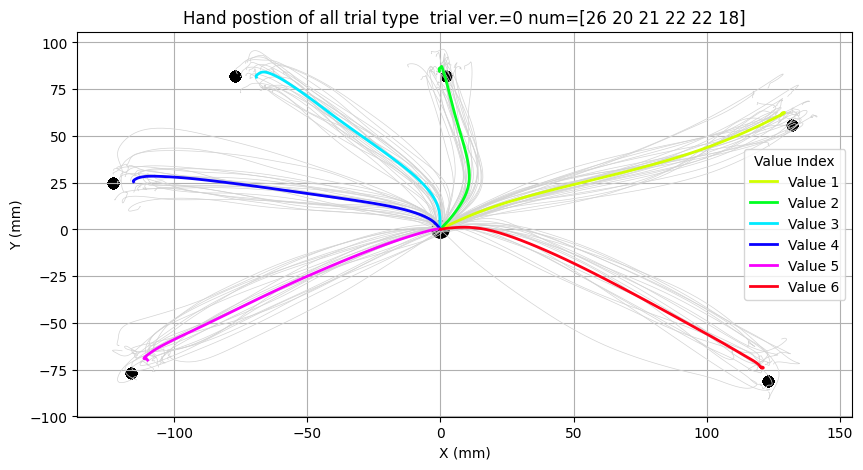

In [5]:
# full_types = [1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39]

# full_types = [1,8,19, 13, 37] ## top-right 37down-22down-29down-22-34
# full_types = [29, 35] ## top 88-88
# full_types = [17, 26, 9, 31, 38] ## top-left 133-143-146-148down-168
# full_types = [30, 3, 11, 20] ## left 178-182-183-185
# full_types = [6,16,36,  24,22] ## bottom-left 213down-215down-215down-216-226
# full_types = [10] ## bottom
# full_types = [34,15,2, 33,28,12,18,39] ## bottom-right 326-328-328-327down-333down-337down-326down-347down


###### Four or Three curve-straight pairs ######
# full_types = [13, 38, 6, 18] ## 6 or 16maybe better
# full_types = [13, 38, 18]
# type_name = 'Type: curve-straight'
# t_version = 0

###### Three up-down curve pair ######
## [37,1] ## top-right [31,38] ## top-left [34,18] ## bottom-right
# full_types = [37,1, 31,38, 34,18]
# type_name = 'Type: curve-up-down'
# t_version = 1 ## select>=1

full_types = [13, 29, 17, 38, 6, 18]
type_name = 'Type: straight'
t_version = 0

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.scatter(0, 0, s=150, c='black')
trace_x_mean_all = np.empty((len(full_types), dur))
trace_y_mean_all = np.empty((len(full_types), dur))
Num_tt_all = np.zeros([len(full_types),], dtype=int)
t = 0
for t_type in full_types:
    filtered_indices = trials.index[(trials['trial_type'] == t_type) & (trials['trial_version'] == t_version)]
    Num_tt = int(len(filtered_indices)/dur)
    print('number of trials in this type=', str(Num_tt))
    if filtered_indices.size == 0:
        print('empty')
    else: 
        print('x='+str(trials['target_x'][filtered_indices[0]])+
              ' y='+str(trials['target_y'][filtered_indices[0]])+
             ' target angle='+str(trials['angle_target_final'][filtered_indices[0]])) 
    Num_tt_all[t] = Num_tt
    trace_x_values = np.empty((Num_tt, dur))
    trace_y_values = np.empty((Num_tt, dur))
    print('Num_tt=', Num_tt)
    for i in range(Num_tt):
        
        idx = filtered_indices[dur*i:dur*(i+1)]
        trace_x = trials['x_norm'][idx] ## (dur,) positions minus the starting points
        trace_y = trials['y_norm'][idx]
        ax.plot(trace_x, trace_y, color='lightgrey', linewidth=0.5)
        trace_x_values[i] = trace_x ## (dur, )
        trace_y_values[i] = trace_y
        ax.scatter(trials['target_x'][idx], trials['target_y'][idx], s=50, c='black')

    trace_x_mean = np.mean(trace_x_values, axis=0)
    trace_y_mean = np.mean(trace_y_values, axis=0)
    print('t_type=', t_type)
    trace_x_mean_all[t] = trace_x_mean
    trace_y_mean_all[t] = trace_y_mean
    t = t + 1

c_num = 0
t = 0
colors = plt.cm.hsv(np.linspace(0.2, 1, len(full_types))) ## start from "0" will mix the color at 0&1
for t_type in full_types:
    if abs(np.sum(trace_x_mean_all[t,:]))>0:   
        c_num=c_num+1
        print('c_num='+str(c_num))
        ax.plot(trace_x_mean_all[t,:], trace_y_mean_all[t,:], linewidth=2, 
            color=colors[c_num-1], label=f'Value {c_num}')
        t = t + 1
           
ax.legend(title='Value Index')

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Hand postion of all trial type '+' trial ver.='+str(t_version)+' num='+str(Num_tt_all))
# plt.scatter(x_values, y_values) ### active targets
plt.scatter(0, 0, s=150, c='black')
plt.grid(True)
# plt.show()

Text(0.5, 1.0, 'Discrete labels #trials=129.0')

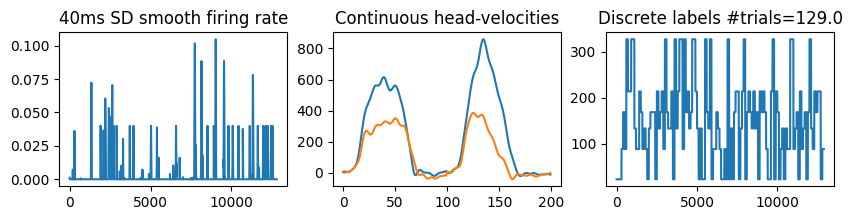

In [6]:
model_indices = trials.index[(trials['trial_type'].isin(full_types)) & (trials['trial_version'] == t_version)]

neural = neural_all_trials.iloc[model_indices, :].to_numpy() 

con_index_x = trials['hand_vel_x'][model_indices].values 
con_index_y = trials['hand_vel_y'][model_indices].values
discrete_index = trials['angle_target_final'][model_indices].values
discrete_index_bin = discrete_index/10 
discrete_index_bin = 10*np.floor(discrete_index_bin)
version_index = trials['trial_version'][model_indices].values
continuous_index = np.column_stack((con_index_x, con_index_y, discrete_index)) 
# continuous_index = np.column_stack((con_index_x, con_index_y, discrete_index_bin)) ## combine motion types

fig = plt.figure(figsize=(10, 2))
plt.subplot(131)
plt.plot(neural[:, 25][dur*1:]) ## randomly selected neuron
plt.title('40ms SD smooth firing rate')
plt.subplot(132)
plt.plot(continuous_index[:, 0][:dur*2])
plt.plot(continuous_index[:, 1][:dur*2]) ## yellow
plt.title('Continuous head-velocities')
plt.subplot(133)
plt.plot(continuous_index[:, 2])
plt.title('Discrete labels #trials='+str(len(discrete_index)/dur))

In [7]:
### 
N_trial = int(continuous_index.shape[0]/dur)
train_trial = int(N_trial*0.8)
test_trial = N_trial-train_trial
def split_data(neural, continuous_index, version_index, train_trial): 
    split_idx = train_trial*dur ## 40bin per trial
    neural_train = neural[:split_idx]
    neural_test = neural[split_idx:]
    continuous_index_train = continuous_index[:split_idx]
    continuous_index_test = continuous_index[split_idx:]
    version_index_train = version_index[:split_idx]
    version_index_test = version_index[split_idx:]
    return neural_train,neural_test,continuous_index_train,continuous_index_test,\
version_index_train,version_index_test

### (28000=56*600, 172neurons) (8000=16*500, 172)      (28000, 3) (8000, 3)
neural_train, neural_test, continuous_index_train, continuous_index_test, \
version_index_train,version_index_test = split_data(neural, continuous_index, version_index, train_trial)

target_angle_train = continuous_index_train[:, 2].copy()
### continuous_index_train[:, 2] = 0
target_angle_test = continuous_index_test[:, 2].copy()
### continuous_index_test[:, 2] = 0

print('train trial='+str(train_trial)+' test trial='+str(test_trial))
print('continuous_index_train=', continuous_index_train[:5])
print('neural=', neural[0:5, 0:5]) ##(8360bin, 63neurons).
print('neural_train=',neural_train.shape,'neural_test=',neural_test.shape,
      'continuous_index_train=',continuous_index_train.shape,'continuous_index_test=',continuous_index_test.shape)

train trial=103 test trial=26
continuous_index_train= [[ 4.63600518e+00  7.33580460e-01  2.29887177e+01]
 [ 7.13839460e+00  4.54493110e-02  2.29887177e+01]
 [ 6.84530495e+00 -1.83116691e-03  2.29887177e+01]
 [ 5.38734135e+00  1.32815594e+00  2.29887177e+01]
 [ 4.32456356e+00  3.93601403e+00  2.29887177e+01]]
neural= [[0.         0.01398065 0.         0.         0.        ]
 [0.         0.01608157 0.         0.         0.        ]
 [0.         0.0188298  0.         0.         0.        ]
 [0.         0.02133828 0.         0.         0.        ]
 [0.         0.023962   0.         0.         0.        ]]
neural_train= (10300, 182) neural_test= (2600, 182) continuous_index_train= (10300, 3) continuous_index_test= (2600, 3)


In [9]:
iterations = 5000
lr = 1e-4
output_dimension = 3
cebra_veldir_model = CEBRA(model_architecture='offset1-model',
                        batch_size=512,
                        learning_rate = lr,
                        temperature = 1,
                        output_dimension = output_dimension ,
                        max_iterations=iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=1)
cebra_veldir_model.fit(neural_train, continuous_index_train) ## (28000, 162) and (28000, 3)

cebra_veldir_train = cebra_veldir_model.transform(neural_train) ## get(28000, 3embed-dim)
cebra_veldir_test  = cebra_veldir_model.transform(neural_test)  ## get(8000, 3embed-dim)

integrations/sklearn/cebra "fit" start
fit --- partial_fit
inside partial_fit
inside _prepare fit
inside _partial_fit
Is this solver/base._get_loader being called?
solver/base fit-_get_loader done


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9386 temperature:  1.0000:   0%| | 1/5000 [0

************ iteration # 0  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9385 temperature:  1.0000:   0%| | 2/5000 [0

************ iteration # 1  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9388 temperature:  1.0000:   0%| | 3/5000 [0

************ iteration # 2  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9384 temperature:  1.0000:   0%| | 4/5000 [0

************ iteration # 3  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9387 temperature:  1.0000:   0%| | 6/5000 [0

************ iteration # 4  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 5  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9387 temperature:  1.0000:   0%| | 7/5000 [0

************ iteration # 6  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9383 temperature:  1.0000:   0%| | 8/5000 [0

************ iteration # 7  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9389 temperature:  1.0000:   0%| | 10/5000 [

************ iteration # 8  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 9  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -1.0000 neg:  7.2383 total:  5.9383 temperature:  1.0000:   0%| | 11/5000 [

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 10  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9382 temperature:  1.0000:   0%| | 12/5000 [

************ iteration # 11  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9382 temperature:  1.0000:   0%| | 13/5000 [

************ iteration # 12  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9383 temperature:  1.0000:   0%| | 14/5000 [

************ iteration # 13  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9381 temperature:  1.0000:   0%| | 15/5000 [

************ iteration # 14  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9383 temperature:  1.0000:   0%| | 16/5000 [

************ iteration # 15  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9383 temperature:  1.0000:   0%| | 17/5000 [

************ iteration # 16  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9384 temperature:  1.0000:   0%| | 18/5000 [

************ iteration # 17  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9381 temperature:  1.0000:   0%| | 20/5000 [

************ iteration # 18  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 19  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -1.0000 neg:  7.2383 total:  5.9384 temperature:  1.0000:   0%| | 20/5000 [

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9384 temperature:  1.0000:   0%| | 21/5000 [

************ iteration # 20  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9380 temperature:  1.0000:   0%| | 22/5000 [

************ iteration # 21  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9386 temperature:  1.0000:   0%| | 23/5000 [

************ iteration # 22  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9382 temperature:  1.0000:   0%| | 24/5000 [

************ iteration # 23  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9379 temperature:  1.0000:   0%| | 25/5000 [

************ iteration # 24  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9379 temperature:  1.0000:   1%| | 26/5000 [

************ iteration # 25  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9385 temperature:  1.0000:   1%| | 27/5000 [

************ iteration # 26  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9386 temperature:  1.0000:   1%| | 28/5000 [

************ iteration # 27  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9380 temperature:  1.0000:   1%| | 29/5000 [

************ iteration # 28  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9383 temperature:  1.0000:   1%| | 30/5000 [

************ iteration # 29  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9379 temperature:  1.0000:   1%| | 31/5000 [

************ iteration # 30  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9378 temperature:  1.0000:   1%| | 32/5000 [

************ iteration # 31  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9380 temperature:  1.0000:   1%| | 33/5000 [

************ iteration # 32  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9379 temperature:  1.0000:   1%| | 34/5000 [

************ iteration # 33  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9377 temperature:  1.0000:   1%| | 36/5000 [

************ iteration # 34  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 35  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9378 temperature:  1.0000:   1%| | 37/5000 [

************ iteration # 36  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9377 temperature:  1.0000:   1%| | 38/5000 [

************ iteration # 37  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9376 temperature:  1.0000:   1%| | 39/5000 [

************ iteration # 38  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9376 temperature:  1.0000:   1%| | 40/5000 [

************ iteration # 39  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9377 temperature:  1.0000:   1%| | 41/5000 [

************ iteration # 40  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9376 temperature:  1.0000:   1%| | 42/5000 [

************ iteration # 41  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9375 temperature:  1.0000:   1%| | 43/5000 [

************ iteration # 42  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9375 temperature:  1.0000:   1%| | 44/5000 [

************ iteration # 43  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9376 temperature:  1.0000:   1%| | 45/5000 [

************ iteration # 44  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9386 temperature:  1.0000:   1%| | 46/5000 [

************ iteration # 45  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9376 temperature:  1.0000:   1%| | 47/5000 [

************ iteration # 46  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9375 temperature:  1.0000:   1%| | 48/5000 [

************ iteration # 47  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9374 temperature:  1.0000:   1%| | 49/5000 [

************ iteration # 48  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9376 temperature:  1.0000:   1%| | 50/5000 [

************ iteration # 49  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9372 temperature:  1.0000:   1%| | 51/5000 [

************ iteration # 50  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9374 temperature:  1.0000:   1%| | 52/5000 [

************ iteration # 51  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 52  done****************


pos: -1.0000 neg:  7.2383 total:  5.9372 temperature:  1.0000:   1%| | 53/5000 [

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9393 temperature:  1.0000:   1%| | 54/5000 [

************ iteration # 53  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9393 temperature:  1.0000:   1%| | 55/5000 [

************ iteration # 54  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9377 temperature:  1.0000:   1%| | 56/5000 [

************ iteration # 55  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9372 temperature:  1.0000:   1%| | 57/5000 [

************ iteration # 56  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9372 temperature:  1.0000:   1%| | 58/5000 [

************ iteration # 57  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9370 temperature:  1.0000:   1%| | 59/5000 [

************ iteration # 58  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9369 temperature:  1.0000:   1%| | 60/5000 [

************ iteration # 59  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9369 temperature:  1.0000:   1%| | 61/5000 [

************ iteration # 60  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9372 temperature:  1.0000:   1%| | 62/5000 [

************ iteration # 61  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9365 temperature:  1.0000:   1%| | 63/5000 [

************ iteration # 62  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9378 temperature:  1.0000:   1%| | 65/5000 [

************ iteration # 63  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 64  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9363 temperature:  1.0000:   1%| | 67/5000 [

************ iteration # 65  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 66  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2383 total:  5.9367 temperature:  1.0000:   1%| | 68/5000 [

************ iteration # 67  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9361 temperature:  1.0000:   1%| | 70/5000 [

************ iteration # 68  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 69  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9361 temperature:  1.0000:   1%| | 72/5000 [

************ iteration # 70  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 71  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -1.0000 neg:  7.2382 total:  5.9355 temperature:  1.0000:   1%| | 73/5000 [

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 72  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9371 temperature:  1.0000:   2%| | 75/5000 [

************ iteration # 73  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 74  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9356 temperature:  1.0000:   2%| | 77/5000 [

************ iteration # 75  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 76  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -1.0000 neg:  7.2382 total:  5.9354 temperature:  1.0000:   2%| | 78/5000 [

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 77  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9357 temperature:  1.0000:   2%| | 79/5000 [

************ iteration # 78  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9352 temperature:  1.0000:   2%| | 80/5000 [

************ iteration # 79  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9349 temperature:  1.0000:   2%| | 81/5000 [

************ iteration # 80  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9354 temperature:  1.0000:   2%| | 82/5000 [

************ iteration # 81  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9351 temperature:  1.0000:   2%| | 83/5000 [

************ iteration # 82  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -1.0000 neg:  7.2382 total:  5.9351 temperature:  1.0000:   2%| | 84/5000 [

************ iteration # 83  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2382 total:  5.9349 temperature:  1.0000:   2%| | 85/5000 [

************ iteration # 84  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2381 total:  5.9342 temperature:  1.0000:   2%| | 86/5000 [

************ iteration # 85  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2381 total:  5.9347 temperature:  1.0000:   2%| | 87/5000 [

************ iteration # 86  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2381 total:  5.9349 temperature:  1.0000:   2%| | 88/5000 [

************ iteration # 87  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2381 total:  5.9340 temperature:  1.0000:   2%| | 89/5000 [

************ iteration # 88  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2381 total:  5.9339 temperature:  1.0000:   2%| | 90/5000 [

************ iteration # 89  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2381 total:  5.9339 temperature:  1.0000:   2%| | 91/5000 [

************ iteration # 90  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2381 total:  5.9337 temperature:  1.0000:   2%| | 93/5000 [

************ iteration # 91  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 92  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2380 total:  5.9333 temperature:  1.0000:   2%| | 94/5000 [

************ iteration # 93  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2380 total:  5.9339 temperature:  1.0000:   2%| | 95/5000 [

************ iteration # 94  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2380 total:  5.9327 temperature:  1.0000:   2%| | 96/5000 [

************ iteration # 95  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2380 total:  5.9335 temperature:  1.0000:   2%| | 97/5000 [

************ iteration # 96  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2380 total:  5.9328 temperature:  1.0000:   2%| | 98/5000 [

************ iteration # 97  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2379 total:  5.9330 temperature:  1.0000:   2%| | 99/5000 [

************ iteration # 98  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2379 total:  5.9328 temperature:  1.0000:   2%| | 100/5000 

************ iteration # 99  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2379 total:  5.9321 temperature:  1.0000:   2%| | 101/5000 

************ iteration # 100  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2378 total:  5.9314 temperature:  1.0000:   2%| | 102/5000 

************ iteration # 101  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2379 total:  5.9326 temperature:  1.0000:   2%| | 103/5000 

************ iteration # 102  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2378 total:  5.9312 temperature:  1.0000:   2%| | 104/5000 

************ iteration # 103  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9999 neg:  7.2378 total:  5.9311 temperature:  1.0000:   2%| | 105/5000 

************ iteration # 104  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2377 total:  5.9304 temperature:  1.0000:   2%| | 106/5000 

************ iteration # 105  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2377 total:  5.9315 temperature:  1.0000:   2%| | 107/5000 

************ iteration # 106  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2377 total:  5.9311 temperature:  1.0000:   2%| | 108/5000 

************ iteration # 107  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2376 total:  5.9302 temperature:  1.0000:   2%| | 109/5000 

************ iteration # 108  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2376 total:  5.9290 temperature:  1.0000:   2%| | 110/5000 

************ iteration # 109  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2375 total:  5.9296 temperature:  1.0000:   2%| | 111/5000 

************ iteration # 110  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2375 total:  5.9304 temperature:  1.0000:   2%| | 112/5000 

************ iteration # 111  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9997 neg:  7.2375 total:  5.9295 temperature:  1.0000:   2%| | 113/5000 

************ iteration # 112  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9998 neg:  7.2374 total:  5.9282 temperature:  1.0000:   2%| | 114/5000 

************ iteration # 113  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9997 neg:  7.2374 total:  5.9307 temperature:  1.0000:   2%| | 115/5000 

************ iteration # 114  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9997 neg:  7.2372 total:  5.9270 temperature:  1.0000:   2%| | 116/5000 

************ iteration # 115  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9996 neg:  7.2372 total:  5.9287 temperature:  1.0000:   2%| | 117/5000 

************ iteration # 116  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9996 neg:  7.2372 total:  5.9287 temperature:  1.0000:   2%| | 118/5000 

************ iteration # 117  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9996 neg:  7.2371 total:  5.9270 temperature:  1.0000:   2%| | 119/5000 

************ iteration # 118  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9996 neg:  7.2371 total:  5.9270 temperature:  1.0000:   2%| | 120/5000 

************ iteration # 119  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9996 neg:  7.2370 total:  5.9281 temperature:  1.0000:   2%| | 121/5000 

************ iteration # 120  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9996 neg:  7.2368 total:  5.9259 temperature:  1.0000:   2%| | 122/5000 

************ iteration # 121  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9996 neg:  7.2368 total:  5.9264 temperature:  1.0000:   2%| | 123/5000 

************ iteration # 122  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9995 neg:  7.2366 total:  5.9249 temperature:  1.0000:   2%| | 124/5000 

************ iteration # 123  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9995 neg:  7.2365 total:  5.9250 temperature:  1.0000:   2%| | 125/5000 

************ iteration # 124  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9995 neg:  7.2365 total:  5.9271 temperature:  1.0000:   3%| | 126/5000 

************ iteration # 125  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9994 neg:  7.2363 total:  5.9236 temperature:  1.0000:   3%| | 127/5000 

************ iteration # 126  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9994 neg:  7.2362 total:  5.9253 temperature:  1.0000:   3%| | 128/5000 

************ iteration # 127  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9993 neg:  7.2362 total:  5.9237 temperature:  1.0000:   3%| | 129/5000 

************ iteration # 128  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9993 neg:  7.2358 total:  5.9211 temperature:  1.0000:   3%| | 130/5000 

************ iteration # 129  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9993 neg:  7.2355 total:  5.9229 temperature:  1.0000:   3%| | 131/5000 

************ iteration # 130  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9992 neg:  7.2357 total:  5.9239 temperature:  1.0000:   3%| | 132/5000 

************ iteration # 131  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9992 neg:  7.2355 total:  5.9223 temperature:  1.0000:   3%| | 133/5000 

************ iteration # 132  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9992 neg:  7.2352 total:  5.9192 temperature:  1.0000:   3%| | 134/5000 

************ iteration # 133  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9990 neg:  7.2350 total:  5.9228 temperature:  1.0000:   3%| | 135/5000 

************ iteration # 134  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9991 neg:  7.2349 total:  5.9202 temperature:  1.0000:   3%| | 136/5000 

************ iteration # 135  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9987 neg:  7.2345 total:  5.9199 temperature:  1.0000:   3%| | 137/5000 

************ iteration # 136  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9987 neg:  7.2343 total:  5.9221 temperature:  1.0000:   3%| | 139/5000 

************ iteration # 137  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 138  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9986 neg:  7.2336 total:  5.9159 temperature:  1.0000:   3%| | 140/5000 

************ iteration # 139  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9988 neg:  7.2334 total:  5.9145 temperature:  1.0000:   3%| | 141/5000 

************ iteration # 140  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9981 neg:  7.2326 total:  5.9131 temperature:  1.0000:   3%| | 142/5000 

************ iteration # 141  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9981 neg:  7.2326 total:  5.9131 temperature:  1.0000:   3%| | 143/5000 

************ iteration # 142  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9983 neg:  7.2323 total:  5.9122 temperature:  1.0000:   3%| | 144/5000 

************ iteration # 143  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9983 neg:  7.2316 total:  5.9117 temperature:  1.0000:   3%| | 145/5000 

************ iteration # 144  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9983 neg:  7.2313 total:  5.9127 temperature:  1.0000:   3%| | 146/5000 

************ iteration # 145  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9978 neg:  7.2310 total:  5.9134 temperature:  1.0000:   3%| | 147/5000 

************ iteration # 146  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9975 neg:  7.2306 total:  5.9149 temperature:  1.0000:   3%| | 148/5000 

************ iteration # 147  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9976 neg:  7.2289 total:  5.9103 temperature:  1.0000:   3%| | 150/5000 

************ iteration # 148  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 149  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9973 neg:  7.2293 total:  5.9115 temperature:  1.0000:   3%| | 151/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 150  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9969 neg:  7.2278 total:  5.9090 temperature:  1.0000:   3%| | 153/5000 

************ iteration # 151  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 152  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9965 neg:  7.2267 total:  5.9061 temperature:  1.0000:   3%| | 154/5000 

************ iteration # 153  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9962 neg:  7.2264 total:  5.9036 temperature:  1.0000:   3%| | 155/5000 

************ iteration # 154  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9961 neg:  7.2221 total:  5.8939 temperature:  1.0000:   3%| | 156/5000 

************ iteration # 155  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 156  done****************


pos: -0.9961 neg:  7.2221 total:  5.8939 temperature:  1.0000:   3%| | 157/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9962 neg:  7.2220 total:  5.9012 temperature:  1.0000:   3%| | 158/5000 

************ iteration # 157  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9946 neg:  7.2211 total:  5.9006 temperature:  1.0000:   3%| | 159/5000 

************ iteration # 158  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9946 neg:  7.2200 total:  5.8962 temperature:  1.0000:   3%| | 160/5000 

************ iteration # 159  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9946 neg:  7.2189 total:  5.8948 temperature:  1.0000:   3%| | 161/5000 

************ iteration # 160  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9947 neg:  7.2175 total:  5.8927 temperature:  1.0000:   3%| | 162/5000 

************ iteration # 161  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9925 neg:  7.2141 total:  5.8979 temperature:  1.0000:   3%| | 163/5000 

************ iteration # 162  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9925 neg:  7.2141 total:  5.8979 temperature:  1.0000:   3%| | 164/5000 

************ iteration # 163  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9938 neg:  7.2119 total:  5.8845 temperature:  1.0000:   3%| | 165/5000 

************ iteration # 164  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9914 neg:  7.2102 total:  5.8893 temperature:  1.0000:   3%| | 166/5000 

************ iteration # 165  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9915 neg:  7.2085 total:  5.8857 temperature:  1.0000:   3%| | 167/5000 

************ iteration # 166  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9903 neg:  7.2051 total:  5.8862 temperature:  1.0000:   3%| | 168/5000 

************ iteration # 167  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9889 neg:  7.2005 total:  5.8806 temperature:  1.0000:   3%| | 170/5000 

************ iteration # 168  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 169  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9877 neg:  7.1926 total:  5.8796 temperature:  1.0000:   3%| | 171/5000 

************ iteration # 170  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9877 neg:  7.1926 total:  5.8796 temperature:  1.0000:   3%| | 172/5000 

************ iteration # 171  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9876 neg:  7.1866 total:  5.8676 temperature:  1.0000:   3%| | 173/5000 

************ iteration # 172  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9865 neg:  7.1866 total:  5.8705 temperature:  1.0000:   3%| | 174/5000 

************ iteration # 173  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9869 neg:  7.1796 total:  5.8664 temperature:  1.0000:   4%| | 175/5000 

************ iteration # 174  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9845 neg:  7.1717 total:  5.8653 temperature:  1.0000:   4%| | 176/5000 

************ iteration # 175  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9823 neg:  7.1713 total:  5.8616 temperature:  1.0000:   4%| | 177/5000 

************ iteration # 176  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9775 neg:  7.1614 total:  5.8626 temperature:  1.0000:   4%| | 178/5000 

************ iteration # 177  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9785 neg:  7.1619 total:  5.8666 temperature:  1.0000:   4%| | 179/5000 

************ iteration # 178  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9765 neg:  7.1496 total:  5.8469 temperature:  1.0000:   4%| | 180/5000 

************ iteration # 179  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9728 neg:  7.1397 total:  5.8604 temperature:  1.0000:   4%| | 182/5000 

************ iteration # 180  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 181  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  7.1244 total:  5.8529 temperature:  1.0000:   4%| | 183/5000 

************ iteration # 182  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  7.1006 total:  5.8446 temperature:  1.0000:   4%| | 185/5000 

************ iteration # 183  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 184  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  7.0945 total:  5.8372 temperature:  1.0000:   4%| | 186/5000 

************ iteration # 185  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9475 neg:  7.0756 total:  5.8434 temperature:  1.0000:   4%| | 187/5000 

************ iteration # 186  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  7.0630 total:  5.8346 temperature:  1.0000:   4%| | 188/5000 

************ iteration # 187  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9418 neg:  7.0484 total:  5.8381 temperature:  1.0000:   4%| | 189/5000 

************ iteration # 188  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9418 neg:  7.0484 total:  5.8381 temperature:  1.0000:   4%| | 190/5000 

************ iteration # 189  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9378 neg:  7.0217 total:  5.8266 temperature:  1.0000:   4%| | 191/5000 

************ iteration # 190  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9335 neg:  7.0129 total:  5.8309 temperature:  1.0000:   4%| | 192/5000 

************ iteration # 191  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9338 neg:  7.0005 total:  5.8231 temperature:  1.0000:   4%| | 193/5000 

************ iteration # 192  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9215 neg:  7.0011 total:  5.8254 temperature:  1.0000:   4%| | 194/5000 

************ iteration # 193  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9121 neg:  6.9793 total:  5.8268 temperature:  1.0000:   4%| | 195/5000 

************ iteration # 194  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9244 neg:  6.9538 total:  5.8209 temperature:  1.0000:   4%| | 196/5000 

************ iteration # 195  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9229 neg:  6.9841 total:  5.8252 temperature:  1.0000:   4%| | 197/5000 

************ iteration # 196  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9310 neg:  6.9830 total:  5.8287 temperature:  1.0000:   4%| | 198/5000 

************ iteration # 197  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9303 neg:  6.9907 total:  5.8235 temperature:  1.0000:   4%| | 199/5000 

************ iteration # 198  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9331 neg:  7.0007 total:  5.8459 temperature:  1.0000:   4%| | 200/5000 

************ iteration # 199  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9323 neg:  7.0025 total:  5.8275 temperature:  1.0000:   4%| | 201/5000 

************ iteration # 200  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9354 neg:  6.9899 total:  5.8251 temperature:  1.0000:   4%| | 202/5000 

************ iteration # 201  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9152 neg:  7.0127 total:  5.8385 temperature:  1.0000:   4%| | 203/5000 

************ iteration # 202  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9368 neg:  6.9933 total:  5.8112 temperature:  1.0000:   4%| | 204/5000 

************ iteration # 203  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9376 neg:  6.9834 total:  5.8136 temperature:  1.0000:   4%| | 206/5000 

************ iteration # 204  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 205  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9404 neg:  6.9838 total:  5.8071 temperature:  1.0000:   4%| | 207/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 206  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9288 neg:  6.9919 total:  5.8059 temperature:  1.0000:   4%| | 208/5000 

************ iteration # 207  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9306 neg:  6.9927 total:  5.8230 temperature:  1.0000:   4%| | 209/5000 

************ iteration # 208  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9377 neg:  6.9825 total:  5.8013 temperature:  1.0000:   4%| | 210/5000 

************ iteration # 209  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9459 neg:  7.0087 total:  5.8050 temperature:  1.0000:   4%| | 211/5000 

************ iteration # 210  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9355 neg:  6.9909 total:  5.7866 temperature:  1.0000:   4%| | 213/5000 

************ iteration # 211  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 212  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9347 neg:  7.0007 total:  5.8115 temperature:  1.0000:   4%| | 214/5000 

************ iteration # 213  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9422 neg:  7.0005 total:  5.8078 temperature:  1.0000:   4%| | 215/5000 

************ iteration # 214  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9434 neg:  6.9961 total:  5.8042 temperature:  1.0000:   4%| | 216/5000 

************ iteration # 215  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9343 neg:  7.0108 total:  5.8146 temperature:  1.0000:   4%| | 217/5000 

************ iteration # 216  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9363 neg:  6.9784 total:  5.8057 temperature:  1.0000:   4%| | 218/5000 

************ iteration # 217  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9377 neg:  6.9970 total:  5.8117 temperature:  1.0000:   4%| | 219/5000 

************ iteration # 218  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9389 neg:  6.9948 total:  5.8036 temperature:  1.0000:   4%| | 220/5000 

************ iteration # 219  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9301 neg:  6.9930 total:  5.8121 temperature:  1.0000:   4%| | 221/5000 

************ iteration # 220  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9380 neg:  6.9844 total:  5.7970 temperature:  1.0000:   4%| | 222/5000 

************ iteration # 221  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9419 neg:  6.9908 total:  5.8069 temperature:  1.0000:   4%| | 223/5000 

************ iteration # 222  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9335 neg:  6.9801 total:  5.7923 temperature:  1.0000:   4%| | 224/5000 

************ iteration # 223  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 224  done****************


pos: -0.9335 neg:  6.9801 total:  5.7923 temperature:  1.0000:   4%| | 225/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9403 neg:  6.9953 total:  5.8097 temperature:  1.0000:   5%| | 227/5000 

************ iteration # 225  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 226  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9349 neg:  6.9732 total:  5.7901 temperature:  1.0000:   5%| | 228/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 227  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9405 neg:  7.0001 total:  5.8161 temperature:  1.0000:   5%| | 229/5000 

************ iteration # 228  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9308 neg:  6.9705 total:  5.7949 temperature:  1.0000:   5%| | 230/5000 

************ iteration # 229  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9251 neg:  6.9684 total:  5.8063 temperature:  1.0000:   5%| | 231/5000 

************ iteration # 230  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9391 neg:  6.9622 total:  5.7902 temperature:  1.0000:   5%| | 232/5000 

************ iteration # 231  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9303 neg:  6.9663 total:  5.8043 temperature:  1.0000:   5%| | 233/5000 

************ iteration # 232  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9413 neg:  6.9670 total:  5.7940 temperature:  1.0000:   5%| | 234/5000 

************ iteration # 233  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9440 neg:  6.9841 total:  5.8071 temperature:  1.0000:   5%| | 235/5000 

************ iteration # 234  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9351 neg:  6.9771 total:  5.8050 temperature:  1.0000:   5%| | 237/5000 

************ iteration # 235  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 236  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9308 neg:  6.9829 total:  5.7872 temperature:  1.0000:   5%| | 238/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 237  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9451 neg:  6.9865 total:  5.7956 temperature:  1.0000:   5%| | 239/5000 

************ iteration # 238  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9417 neg:  6.9864 total:  5.7842 temperature:  1.0000:   5%| | 240/5000 

************ iteration # 239  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9416 neg:  6.9845 total:  5.7892 temperature:  1.0000:   5%| | 241/5000 

************ iteration # 240  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9359 neg:  6.9853 total:  5.7994 temperature:  1.0000:   5%| | 242/5000 

************ iteration # 241  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9387 neg:  6.9890 total:  5.8002 temperature:  1.0000:   5%| | 244/5000 

************ iteration # 242  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 243  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9439 neg:  6.9748 total:  5.7995 temperature:  1.0000:   5%| | 245/5000 

************ iteration # 244  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9503 neg:  6.9841 total:  5.8030 temperature:  1.0000:   5%| | 247/5000 

************ iteration # 245  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 246  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9449 neg:  6.9810 total:  5.8076 temperature:  1.0000:   5%| | 248/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 247  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9368 neg:  6.9763 total:  5.7995 temperature:  1.0000:   5%| | 250/5000 

************ iteration # 248  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 249  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9381 neg:  6.9739 total:  5.7806 temperature:  1.0000:   5%| | 251/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 250  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9506 neg:  6.9928 total:  5.7749 temperature:  1.0000:   5%| | 252/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 251  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9442 neg:  6.9838 total:  5.7936 temperature:  1.0000:   5%| | 253/5000 

************ iteration # 252  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9442 neg:  6.9838 total:  5.7936 temperature:  1.0000:   5%| | 254/5000 

************ iteration # 253  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9427 neg:  6.9769 total:  5.7923 temperature:  1.0000:   5%| | 255/5000 

************ iteration # 254  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9380 neg:  6.9629 total:  5.8082 temperature:  1.0000:   5%| | 256/5000 

************ iteration # 255  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9380 neg:  6.9629 total:  5.8082 temperature:  1.0000:   5%| | 257/5000 

************ iteration # 256  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9346 neg:  6.9612 total:  5.7842 temperature:  1.0000:   5%| | 258/5000 

************ iteration # 257  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9450 neg:  6.9835 total:  5.7940 temperature:  1.0000:   5%| | 260/5000 

************ iteration # 258  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 259  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9469 neg:  6.9816 total:  5.7587 temperature:  1.0000:   5%| | 261/5000 

************ iteration # 260  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 261  done****************


pos: -0.9551 neg:  6.9777 total:  5.7784 temperature:  1.0000:   5%| | 263/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 262  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.9813 total:  5.7918 temperature:  1.0000:   5%| | 264/5000 

************ iteration # 263  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9444 neg:  6.9793 total:  5.7802 temperature:  1.0000:   5%| | 265/5000 

************ iteration # 264  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9356 neg:  6.9548 total:  5.7780 temperature:  1.0000:   5%| | 266/5000 

************ iteration # 265  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9436 neg:  6.9662 total:  5.7882 temperature:  1.0000:   5%| | 267/5000 

************ iteration # 266  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9494 neg:  6.9531 total:  5.7670 temperature:  1.0000:   5%| | 268/5000 

************ iteration # 267  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9479 neg:  6.9706 total:  5.7758 temperature:  1.0000:   5%| | 269/5000 

************ iteration # 268  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9395 neg:  6.9760 total:  5.8032 temperature:  1.0000:   5%| | 270/5000 

************ iteration # 269  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.9770 total:  5.7867 temperature:  1.0000:   5%| | 271/5000 

************ iteration # 270  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.9742 total:  5.7854 temperature:  1.0000:   5%| | 272/5000 

************ iteration # 271  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9467 neg:  6.9652 total:  5.7599 temperature:  1.0000:   5%| | 273/5000 

************ iteration # 272  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9376 neg:  6.9691 total:  5.7881 temperature:  1.0000:   5%| | 274/5000 

************ iteration # 273  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9502 neg:  6.9650 total:  5.7641 temperature:  1.0000:   6%| | 275/5000 

************ iteration # 274  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9388 neg:  6.9660 total:  5.7850 temperature:  1.0000:   6%| | 276/5000 

************ iteration # 275  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9467 neg:  6.9583 total:  5.7534 temperature:  1.0000:   6%| | 277/5000 

************ iteration # 276  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9356 neg:  6.9572 total:  5.7740 temperature:  1.0000:   6%| | 278/5000 

************ iteration # 277  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9409 neg:  6.9670 total:  5.7669 temperature:  1.0000:   6%| | 279/5000 

************ iteration # 278  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9411 neg:  6.9533 total:  5.7818 temperature:  1.0000:   6%| | 280/5000 

************ iteration # 279  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9387 neg:  6.9600 total:  5.7731 temperature:  1.0000:   6%| | 281/5000 

************ iteration # 280  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9441 neg:  6.9595 total:  5.7608 temperature:  1.0000:   6%| | 282/5000 

************ iteration # 281  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.9878 total:  5.7786 temperature:  1.0000:   6%| | 283/5000 

************ iteration # 282  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.9570 total:  5.7554 temperature:  1.0000:   6%| | 284/5000 

************ iteration # 283  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9476 neg:  6.9529 total:  5.7883 temperature:  1.0000:   6%| | 285/5000 

************ iteration # 284  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9417 neg:  6.9250 total:  5.7577 temperature:  1.0000:   6%| | 286/5000 

************ iteration # 285  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9364 neg:  6.9284 total:  5.7641 temperature:  1.0000:   6%| | 287/5000 

************ iteration # 286  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9456 neg:  6.9450 total:  5.7768 temperature:  1.0000:   6%| | 288/5000 

************ iteration # 287  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9433 neg:  6.9443 total:  5.7514 temperature:  1.0000:   6%| | 289/5000 

************ iteration # 288  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9373 neg:  6.9278 total:  5.7629 temperature:  1.0000:   6%| | 290/5000 

************ iteration # 289  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9526 neg:  6.9524 total:  5.7540 temperature:  1.0000:   6%| | 291/5000 

************ iteration # 290  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.9741 total:  5.7486 temperature:  1.0000:   6%| | 292/5000 

************ iteration # 291  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9469 neg:  6.9468 total:  5.7575 temperature:  1.0000:   6%| | 293/5000 

************ iteration # 292  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9459 neg:  6.9554 total:  5.7598 temperature:  1.0000:   6%| | 294/5000 

************ iteration # 293  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9402 neg:  6.9502 total:  5.7925 temperature:  1.0000:   6%| | 295/5000 

************ iteration # 294  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9452 neg:  6.9356 total:  5.7660 temperature:  1.0000:   6%| | 296/5000 

************ iteration # 295  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9462 neg:  6.9322 total:  5.7502 temperature:  1.0000:   6%| | 297/5000 

************ iteration # 296  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.9620 total:  5.7707 temperature:  1.0000:   6%| | 298/5000 

************ iteration # 297  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9490 neg:  6.9477 total:  5.7633 temperature:  1.0000:   6%| | 299/5000 

************ iteration # 298  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9379 neg:  6.9511 total:  5.7684 temperature:  1.0000:   6%| | 300/5000 

************ iteration # 299  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9445 neg:  6.9497 total:  5.7714 temperature:  1.0000:   6%| | 301/5000 

************ iteration # 300  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9461 neg:  6.9641 total:  5.7656 temperature:  1.0000:   6%| | 302/5000 

************ iteration # 301  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9464 neg:  6.9735 total:  5.7621 temperature:  1.0000:   6%| | 303/5000 

************ iteration # 302  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.9687 total:  5.7624 temperature:  1.0000:   6%| | 304/5000 

************ iteration # 303  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9419 neg:  6.9506 total:  5.7544 temperature:  1.0000:   6%| | 305/5000 

************ iteration # 304  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.9499 total:  5.7723 temperature:  1.0000:   6%| | 306/5000 

************ iteration # 305  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 306  done****************


pos: -0.9429 neg:  6.9289 total:  5.7379 temperature:  1.0000:   6%| | 308/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 307  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9518 neg:  6.9494 total:  5.7593 temperature:  1.0000:   6%| | 309/5000 

************ iteration # 308  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.9224 total:  5.7402 temperature:  1.0000:   6%| | 310/5000 

************ iteration # 309  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9507 neg:  6.9341 total:  5.7730 temperature:  1.0000:   6%| | 311/5000 

************ iteration # 310  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.9515 total:  5.7693 temperature:  1.0000:   6%| | 312/5000 

************ iteration # 311  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.9599 total:  5.7454 temperature:  1.0000:   6%| | 313/5000 

************ iteration # 312  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9476 neg:  6.9420 total:  5.7536 temperature:  1.0000:   6%| | 314/5000 

************ iteration # 313  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.9470 total:  5.7514 temperature:  1.0000:   6%| | 315/5000 

************ iteration # 314  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.9551 total:  5.7695 temperature:  1.0000:   6%| | 316/5000 

************ iteration # 315  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.9308 total:  5.7488 temperature:  1.0000:   6%| | 317/5000 

************ iteration # 316  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9445 neg:  6.9428 total:  5.7676 temperature:  1.0000:   6%| | 318/5000 

************ iteration # 317  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9445 neg:  6.9428 total:  5.7676 temperature:  1.0000:   6%| | 319/5000 

************ iteration # 318  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9483 neg:  6.9523 total:  5.7708 temperature:  1.0000:   6%| | 320/5000 

************ iteration # 319  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9437 neg:  6.9319 total:  5.7628 temperature:  1.0000:   6%| | 321/5000 

************ iteration # 320  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9423 neg:  6.9503 total:  5.7693 temperature:  1.0000:   6%| | 322/5000 

************ iteration # 321  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9504 neg:  6.9603 total:  5.7533 temperature:  1.0000:   6%| | 323/5000 

************ iteration # 322  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9486 neg:  6.9563 total:  5.7510 temperature:  1.0000:   6%| | 324/5000 

************ iteration # 323  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.9483 total:  5.7408 temperature:  1.0000:   6%| | 325/5000 

************ iteration # 324  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.9483 total:  5.7408 temperature:  1.0000:   7%| | 326/5000 

************ iteration # 325  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9491 neg:  6.9431 total:  5.7584 temperature:  1.0000:   7%| | 327/5000 

************ iteration # 326  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9431 neg:  6.9330 total:  5.7576 temperature:  1.0000:   7%| | 328/5000 

************ iteration # 327  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9502 neg:  6.9495 total:  5.7648 temperature:  1.0000:   7%| | 329/5000 

************ iteration # 328  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9436 neg:  6.9416 total:  5.7458 temperature:  1.0000:   7%| | 330/5000 

************ iteration # 329  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.9449 total:  5.7644 temperature:  1.0000:   7%| | 331/5000 

************ iteration # 330  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.9215 total:  5.7498 temperature:  1.0000:   7%| | 332/5000 

************ iteration # 331  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9508 neg:  6.9576 total:  5.7553 temperature:  1.0000:   7%| | 333/5000 

************ iteration # 332  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.9509 total:  5.7424 temperature:  1.0000:   7%| | 334/5000 

************ iteration # 333  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9476 neg:  6.9469 total:  5.7484 temperature:  1.0000:   7%| | 335/5000 

************ iteration # 334  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9440 neg:  6.9211 total:  5.7429 temperature:  1.0000:   7%| | 337/5000 

************ iteration # 335  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 336  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.9337 total:  5.7546 temperature:  1.0000:   7%| | 338/5000 

************ iteration # 337  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.9337 total:  5.7546 temperature:  1.0000:   7%| | 339/5000 

************ iteration # 338  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9461 neg:  6.9236 total:  5.7470 temperature:  1.0000:   7%| | 340/5000 

************ iteration # 339  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9448 neg:  6.9263 total:  5.7646 temperature:  1.0000:   7%| | 341/5000 

************ iteration # 340  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9417 neg:  6.9255 total:  5.7443 temperature:  1.0000:   7%| | 342/5000 

************ iteration # 341  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9435 neg:  6.9219 total:  5.7478 temperature:  1.0000:   7%| | 343/5000 

************ iteration # 342  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9478 neg:  6.9711 total:  5.7585 temperature:  1.0000:   7%| | 344/5000 

************ iteration # 343  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9510 neg:  6.9296 total:  5.7546 temperature:  1.0000:   7%| | 345/5000 

************ iteration # 344  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9510 neg:  6.9296 total:  5.7546 temperature:  1.0000:   7%| | 346/5000 

************ iteration # 345  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.9174 total:  5.7293 temperature:  1.0000:   7%| | 347/5000 

************ iteration # 346  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.9422 total:  5.7631 temperature:  1.0000:   7%| | 348/5000 

************ iteration # 347  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9400 neg:  6.9144 total:  5.7498 temperature:  1.0000:   7%| | 350/5000 

************ iteration # 348  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 349  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9308 neg:  6.9090 total:  5.7448 temperature:  1.0000:   7%| | 351/5000 

************ iteration # 350  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9435 neg:  6.8803 total:  5.7215 temperature:  1.0000:   7%| | 352/5000 

************ iteration # 351  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.9077 total:  5.7166 temperature:  1.0000:   7%| | 353/5000 

************ iteration # 352  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.9264 total:  5.7316 temperature:  1.0000:   7%| | 354/5000 

************ iteration # 353  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9426 neg:  6.9428 total:  5.7410 temperature:  1.0000:   7%| | 355/5000 

************ iteration # 354  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9465 neg:  6.9285 total:  5.7383 temperature:  1.0000:   7%| | 356/5000 

************ iteration # 355  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9465 neg:  6.9285 total:  5.7383 temperature:  1.0000:   7%| | 357/5000 

************ iteration # 356  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9477 neg:  6.9270 total:  5.7392 temperature:  1.0000:   7%| | 358/5000 

************ iteration # 357  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9426 neg:  6.9294 total:  5.7451 temperature:  1.0000:   7%| | 359/5000 

************ iteration # 358  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.9011 total:  5.7260 temperature:  1.0000:   7%| | 360/5000 

************ iteration # 359  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9391 neg:  6.9278 total:  5.7502 temperature:  1.0000:   7%| | 361/5000 

************ iteration # 360  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9442 neg:  6.9028 total:  5.7381 temperature:  1.0000:   7%| | 362/5000 

************ iteration # 361  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9420 neg:  6.8865 total:  5.7042 temperature:  1.0000:   7%| | 363/5000 

************ iteration # 362  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9420 neg:  6.8865 total:  5.7042 temperature:  1.0000:   7%| | 364/5000 

************ iteration # 363  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9470 neg:  6.9081 total:  5.7211 temperature:  1.0000:   7%| | 365/5000 

************ iteration # 364  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9471 neg:  6.9127 total:  5.7384 temperature:  1.0000:   7%| | 366/5000 

************ iteration # 365  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.8880 total:  5.7090 temperature:  1.0000:   7%| | 368/5000 

************ iteration # 366  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 367  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9403 neg:  6.9018 total:  5.7423 temperature:  1.0000:   7%| | 370/5000 

************ iteration # 368  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 369  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9340 neg:  6.8967 total:  5.7526 temperature:  1.0000:   7%| | 371/5000 

************ iteration # 370  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9316 neg:  6.8778 total:  5.7314 temperature:  1.0000:   7%| | 372/5000 

************ iteration # 371  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9456 neg:  6.9036 total:  5.7244 temperature:  1.0000:   7%| | 373/5000 

************ iteration # 372  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9366 neg:  6.9226 total:  5.7449 temperature:  1.0000:   7%| | 374/5000 

************ iteration # 373  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.9214 total:  5.7303 temperature:  1.0000:   8%| | 375/5000 

************ iteration # 374  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.9214 total:  5.7303 temperature:  1.0000:   8%| | 376/5000 

************ iteration # 375  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9415 neg:  6.8984 total:  5.7293 temperature:  1.0000:   8%| | 377/5000 

************ iteration # 376  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9382 neg:  6.9040 total:  5.7302 temperature:  1.0000:   8%| | 378/5000 

************ iteration # 377  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9438 neg:  6.9012 total:  5.7249 temperature:  1.0000:   8%| | 379/5000 

************ iteration # 378  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9330 neg:  6.8702 total:  5.7264 temperature:  1.0000:   8%| | 380/5000 

************ iteration # 379  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9464 neg:  6.8563 total:  5.7095 temperature:  1.0000:   8%| | 381/5000 

************ iteration # 380  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9293 neg:  6.9029 total:  5.7453 temperature:  1.0000:   8%| | 382/5000 

************ iteration # 381  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9441 neg:  6.8922 total:  5.7154 temperature:  1.0000:   8%| | 383/5000 

************ iteration # 382  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.9003 total:  5.7250 temperature:  1.0000:   8%| | 384/5000 

************ iteration # 383  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 384  done****************


pos: -0.9499 neg:  6.9003 total:  5.7250 temperature:  1.0000:   8%| | 385/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.8965 total:  5.7266 temperature:  1.0000:   8%| | 386/5000 

************ iteration # 385  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.8874 total:  5.7176 temperature:  1.0000:   8%| | 387/5000 

************ iteration # 386  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.8874 total:  5.7176 temperature:  1.0000:   8%| | 388/5000 

************ iteration # 387  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9361 neg:  6.8718 total:  5.7242 temperature:  1.0000:   8%| | 390/5000 

************ iteration # 388  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 389  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9366 neg:  6.8815 total:  5.7254 temperature:  1.0000:   8%| | 391/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 390  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9336 neg:  6.9011 total:  5.7264 temperature:  1.0000:   8%| | 392/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 391  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9415 neg:  6.8946 total:  5.7211 temperature:  1.0000:   8%| | 393/5000 

************ iteration # 392  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9492 neg:  6.8945 total:  5.7114 temperature:  1.0000:   8%| | 394/5000 

************ iteration # 393  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9390 neg:  6.8947 total:  5.7175 temperature:  1.0000:   8%| | 395/5000 

************ iteration # 394  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9443 neg:  6.8935 total:  5.7131 temperature:  1.0000:   8%| | 396/5000 

************ iteration # 395  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9362 neg:  6.8549 total:  5.7084 temperature:  1.0000:   8%| | 397/5000 

************ iteration # 396  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9362 neg:  6.8549 total:  5.7084 temperature:  1.0000:   8%| | 398/5000 

************ iteration # 397  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9456 neg:  6.8560 total:  5.6961 temperature:  1.0000:   8%| | 399/5000 

************ iteration # 398  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9466 neg:  6.8817 total:  5.7036 temperature:  1.0000:   8%| | 400/5000 

************ iteration # 399  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9466 neg:  6.8817 total:  5.7036 temperature:  1.0000:   8%| | 401/5000 

************ iteration # 400  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9404 neg:  6.8702 total:  5.7031 temperature:  1.0000:   8%| | 402/5000 

************ iteration # 401  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9389 neg:  6.8621 total:  5.6946 temperature:  1.0000:   8%| | 403/5000 

************ iteration # 402  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9459 neg:  6.8735 total:  5.7024 temperature:  1.0000:   8%| | 404/5000 

************ iteration # 403  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9491 neg:  6.8640 total:  5.6965 temperature:  1.0000:   8%| | 405/5000 

************ iteration # 404  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9414 neg:  6.8567 total:  5.6938 temperature:  1.0000:   8%| | 406/5000 

************ iteration # 405  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9337 neg:  6.8569 total:  5.6962 temperature:  1.0000:   8%| | 407/5000 

************ iteration # 406  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9392 neg:  6.8594 total:  5.7056 temperature:  1.0000:   8%| | 408/5000 

************ iteration # 407  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9285 neg:  6.8496 total:  5.7011 temperature:  1.0000:   8%| | 409/5000 

************ iteration # 408  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9399 neg:  6.8691 total:  5.7020 temperature:  1.0000:   8%| | 410/5000 

************ iteration # 409  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9505 neg:  6.8828 total:  5.7101 temperature:  1.0000:   8%| | 411/5000 

************ iteration # 410  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.8918 total:  5.7223 temperature:  1.0000:   8%| | 412/5000 

************ iteration # 411  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9360 neg:  6.8783 total:  5.7046 temperature:  1.0000:   8%| | 413/5000 

************ iteration # 412  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9208 neg:  6.8563 total:  5.7216 temperature:  1.0000:   8%| | 414/5000 

************ iteration # 413  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9358 neg:  6.8358 total:  5.6988 temperature:  1.0000:   8%| | 416/5000 

************ iteration # 414  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 415  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9311 neg:  6.8520 total:  5.7157 temperature:  1.0000:   8%| | 417/5000 

************ iteration # 416  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9463 neg:  6.8936 total:  5.7106 temperature:  1.0000:   8%| | 418/5000 

************ iteration # 417  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9432 neg:  6.8626 total:  5.6872 temperature:  1.0000:   8%| | 420/5000 

************ iteration # 418  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 419  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9359 neg:  6.8897 total:  5.7141 temperature:  1.0000:   8%| | 422/5000 

************ iteration # 420  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 421  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9336 neg:  6.8535 total:  5.6814 temperature:  1.0000:   8%| | 423/5000 

************ iteration # 422  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9404 neg:  6.8352 total:  5.6858 temperature:  1.0000:   8%| | 424/5000 

************ iteration # 423  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9435 neg:  6.8631 total:  5.6903 temperature:  1.0000:   8%| | 425/5000 

************ iteration # 424  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9407 neg:  6.8210 total:  5.6858 temperature:  1.0000:   9%| | 427/5000 

************ iteration # 425  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 426  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9484 neg:  6.8868 total:  5.6888 temperature:  1.0000:   9%| | 429/5000 

************ iteration # 427  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 428  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.8666 total:  5.6932 temperature:  1.0000:   9%| | 430/5000 

************ iteration # 429  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9423 neg:  6.8228 total:  5.6766 temperature:  1.0000:   9%| | 431/5000 

************ iteration # 430  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9265 neg:  6.8267 total:  5.6925 temperature:  1.0000:   9%| | 432/5000 

************ iteration # 431  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9279 neg:  6.8349 total:  5.6969 temperature:  1.0000:   9%| | 433/5000 

************ iteration # 432  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9416 neg:  6.8321 total:  5.6897 temperature:  1.0000:   9%| | 434/5000 

************ iteration # 433  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9250 neg:  6.8509 total:  5.6931 temperature:  1.0000:   9%| | 435/5000 

************ iteration # 434  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9392 neg:  6.8348 total:  5.6817 temperature:  1.0000:   9%| | 436/5000 

************ iteration # 435  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.8462 total:  5.6860 temperature:  1.0000:   9%| | 438/5000 

************ iteration # 436  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 437  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9468 neg:  6.8735 total:  5.6925 temperature:  1.0000:   9%| | 440/5000 

************ iteration # 438  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 439  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9302 neg:  6.7958 total:  5.6728 temperature:  1.0000:   9%| | 442/5000 

************ iteration # 440  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 441  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9364 neg:  6.8260 total:  5.6806 temperature:  1.0000:   9%| | 443/5000 

************ iteration # 442  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9362 neg:  6.8275 total:  5.6783 temperature:  1.0000:   9%| | 444/5000 

************ iteration # 443  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9421 neg:  6.8524 total:  5.6963 temperature:  1.0000:   9%| | 445/5000 

************ iteration # 444  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.8802 total:  5.6837 temperature:  1.0000:   9%| | 446/5000 

************ iteration # 445  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.8802 total:  5.6837 temperature:  1.0000:   9%| | 447/5000 

************ iteration # 446  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9489 neg:  6.8622 total:  5.6844 temperature:  1.0000:   9%| | 448/5000 

************ iteration # 447  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9303 neg:  6.8443 total:  5.6913 temperature:  1.0000:   9%| | 449/5000 

************ iteration # 448  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9334 neg:  6.8064 total:  5.6822 temperature:  1.0000:   9%| | 450/5000 

************ iteration # 449  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9318 neg:  6.8132 total:  5.6831 temperature:  1.0000:   9%| | 451/5000 

************ iteration # 450  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9442 neg:  6.8580 total:  5.6763 temperature:  1.0000:   9%| | 452/5000 

************ iteration # 451  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9437 neg:  6.8531 total:  5.6797 temperature:  1.0000:   9%| | 453/5000 

************ iteration # 452  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9476 neg:  6.8341 total:  5.6765 temperature:  1.0000:   9%| | 454/5000 

************ iteration # 453  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9412 neg:  6.8473 total:  5.6721 temperature:  1.0000:   9%| | 455/5000 

************ iteration # 454  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9464 neg:  6.8435 total:  5.6682 temperature:  1.0000:   9%| | 456/5000 

************ iteration # 455  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 456  done****************


pos: -0.9464 neg:  6.8435 total:  5.6682 temperature:  1.0000:   9%| | 457/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9409 neg:  6.8107 total:  5.6829 temperature:  1.0000:   9%| | 458/5000 

************ iteration # 457  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9379 neg:  6.8413 total:  5.6853 temperature:  1.0000:   9%| | 459/5000 

************ iteration # 458  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9341 neg:  6.8126 total:  5.6754 temperature:  1.0000:   9%| | 460/5000 

************ iteration # 459  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9346 neg:  6.8367 total:  5.6884 temperature:  1.0000:   9%| | 461/5000 

************ iteration # 460  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9515 neg:  6.8303 total:  5.6589 temperature:  1.0000:   9%| | 462/5000 

************ iteration # 461  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9448 neg:  6.8366 total:  5.6687 temperature:  1.0000:   9%| | 464/5000 

************ iteration # 462  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 463  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.8165 total:  5.6786 temperature:  1.0000:   9%| | 466/5000 

************ iteration # 464  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 465  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9216 neg:  6.8058 total:  5.6822 temperature:  1.0000:   9%| | 468/5000 

************ iteration # 466  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 467  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9265 neg:  6.7957 total:  5.6806 temperature:  1.0000:   9%| | 469/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 468  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.8459 total:  5.6642 temperature:  1.0000:   9%| | 471/5000 

************ iteration # 469  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 470  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9480 neg:  6.8432 total:  5.6715 temperature:  1.0000:   9%| | 473/5000 

************ iteration # 471  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 472  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9296 neg:  6.8098 total:  5.6781 temperature:  1.0000:   9%| | 474/5000 

************ iteration # 473  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9244 neg:  6.7774 total:  5.6737 temperature:  1.0000:  10%| | 475/5000 

************ iteration # 474  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9244 neg:  6.7774 total:  5.6737 temperature:  1.0000:  10%| | 476/5000 

************ iteration # 475  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.8239 total:  5.6711 temperature:  1.0000:  10%| | 477/5000 

************ iteration # 476  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.8796 total:  5.6838 temperature:  1.0000:  10%| | 478/5000 

************ iteration # 477  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9511 neg:  6.8892 total:  5.6814 temperature:  1.0000:  10%| | 479/5000 

************ iteration # 478  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.8645 total:  5.6605 temperature:  1.0000:  10%| | 480/5000 

************ iteration # 479  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9367 neg:  6.8163 total:  5.6687 temperature:  1.0000:  10%| | 481/5000 

************ iteration # 480  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9256 neg:  6.7825 total:  5.6679 temperature:  1.0000:  10%| | 482/5000 

************ iteration # 481  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9400 neg:  6.7739 total:  5.6754 temperature:  1.0000:  10%| | 483/5000 

************ iteration # 482  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9428 neg:  6.8484 total:  5.6957 temperature:  1.0000:  10%| | 484/5000 

************ iteration # 483  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9439 neg:  6.8247 total:  5.6688 temperature:  1.0000:  10%| | 485/5000 

************ iteration # 484  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.8551 total:  5.6653 temperature:  1.0000:  10%| | 486/5000 

************ iteration # 485  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9409 neg:  6.8587 total:  5.6747 temperature:  1.0000:  10%| | 487/5000 

************ iteration # 486  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9439 neg:  6.8388 total:  5.6766 temperature:  1.0000:  10%| | 488/5000 

************ iteration # 487  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9467 neg:  6.8181 total:  5.6603 temperature:  1.0000:  10%| | 489/5000 

************ iteration # 488  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9440 neg:  6.8046 total:  5.6726 temperature:  1.0000:  10%| | 490/5000 

************ iteration # 489  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9311 neg:  6.7897 total:  5.6656 temperature:  1.0000:  10%| | 491/5000 

************ iteration # 490  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9405 neg:  6.7955 total:  5.6588 temperature:  1.0000:  10%| | 492/5000 

************ iteration # 491  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9348 neg:  6.8169 total:  5.6636 temperature:  1.0000:  10%| | 493/5000 

************ iteration # 492  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9334 neg:  6.8436 total:  5.6741 temperature:  1.0000:  10%| | 494/5000 

************ iteration # 493  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9469 neg:  6.8176 total:  5.6631 temperature:  1.0000:  10%| | 495/5000 

************ iteration # 494  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9432 neg:  6.8462 total:  5.6802 temperature:  1.0000:  10%| | 496/5000 

************ iteration # 495  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9336 neg:  6.8299 total:  5.6718 temperature:  1.0000:  10%| | 497/5000 

************ iteration # 496  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9342 neg:  6.7814 total:  5.6633 temperature:  1.0000:  10%| | 498/5000 

************ iteration # 497  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9425 neg:  6.8149 total:  5.6700 temperature:  1.0000:  10%| | 499/5000 

************ iteration # 498  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9435 neg:  6.8082 total:  5.6589 temperature:  1.0000:  10%| | 500/5000 

************ iteration # 499  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9489 neg:  6.8651 total:  5.6701 temperature:  1.0000:  10%| | 502/5000 

************ iteration # 500  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 501  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9317 neg:  6.8291 total:  5.6722 temperature:  1.0000:  10%| | 503/5000 

************ iteration # 502  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9391 neg:  6.8164 total:  5.6627 temperature:  1.0000:  10%| | 504/5000 

************ iteration # 503  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9251 neg:  6.8100 total:  5.6878 temperature:  1.0000:  10%| | 505/5000 

************ iteration # 504  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9207 neg:  6.8027 total:  5.6844 temperature:  1.0000:  10%| | 506/5000 

************ iteration # 505  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9362 neg:  6.8070 total:  5.6587 temperature:  1.0000:  10%| | 507/5000 

************ iteration # 506  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9408 neg:  6.8122 total:  5.6559 temperature:  1.0000:  10%| | 508/5000 

************ iteration # 507  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.8447 total:  5.6632 temperature:  1.0000:  10%| | 509/5000 

************ iteration # 508  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9368 neg:  6.8541 total:  5.6672 temperature:  1.0000:  10%| | 510/5000 

************ iteration # 509  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9386 neg:  6.7840 total:  5.6555 temperature:  1.0000:  10%| | 511/5000 

************ iteration # 510  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9474 neg:  6.8555 total:  5.6701 temperature:  1.0000:  10%| | 512/5000 

************ iteration # 511  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9246 neg:  6.7940 total:  5.6621 temperature:  1.0000:  10%| | 513/5000 

************ iteration # 512  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9374 neg:  6.8007 total:  5.6603 temperature:  1.0000:  10%| | 514/5000 

************ iteration # 513  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9396 neg:  6.8280 total:  5.6634 temperature:  1.0000:  10%| | 515/5000 

************ iteration # 514  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9455 neg:  6.8134 total:  5.6767 temperature:  1.0000:  10%| | 517/5000 

************ iteration # 515  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 516  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9359 neg:  6.7895 total:  5.6497 temperature:  1.0000:  10%| | 518/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 517  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.8290 total:  5.6729 temperature:  1.0000:  10%| | 519/5000 

************ iteration # 518  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9483 neg:  6.8332 total:  5.6676 temperature:  1.0000:  10%| | 520/5000 

************ iteration # 519  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9388 neg:  6.8071 total:  5.6614 temperature:  1.0000:  10%| | 521/5000 

************ iteration # 520  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9440 neg:  6.8018 total:  5.6603 temperature:  1.0000:  10%| | 522/5000 

************ iteration # 521  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9470 neg:  6.8268 total:  5.6597 temperature:  1.0000:  10%| | 523/5000 

************ iteration # 522  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9404 neg:  6.8212 total:  5.6653 temperature:  1.0000:  10%| | 524/5000 

************ iteration # 523  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9380 neg:  6.8138 total:  5.6598 temperature:  1.0000:  10%| | 525/5000 

************ iteration # 524  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9440 neg:  6.8105 total:  5.6563 temperature:  1.0000:  11%| | 526/5000 

************ iteration # 525  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9392 neg:  6.8242 total:  5.6678 temperature:  1.0000:  11%| | 527/5000 

************ iteration # 526  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9279 neg:  6.7877 total:  5.6664 temperature:  1.0000:  11%| | 529/5000 

************ iteration # 527  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 528  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9340 neg:  6.8130 total:  5.6621 temperature:  1.0000:  11%| | 530/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 529  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9475 neg:  6.8389 total:  5.6535 temperature:  1.0000:  11%| | 531/5000 

************ iteration # 530  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9513 neg:  6.8499 total:  5.6571 temperature:  1.0000:  11%| | 533/5000 

************ iteration # 531  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 532  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9522 neg:  6.8423 total:  5.6623 temperature:  1.0000:  11%| | 534/5000 

************ iteration # 533  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9395 neg:  6.8142 total:  5.6482 temperature:  1.0000:  11%| | 535/5000 

************ iteration # 534  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9400 neg:  6.7919 total:  5.6629 temperature:  1.0000:  11%| | 536/5000 

************ iteration # 535  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9439 neg:  6.8354 total:  5.6640 temperature:  1.0000:  11%| | 537/5000 

************ iteration # 536  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7763 total:  5.6342 temperature:  1.0000:  11%| | 538/5000 

************ iteration # 537  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9302 neg:  6.8152 total:  5.6671 temperature:  1.0000:  11%| | 539/5000 

************ iteration # 538  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9421 neg:  6.8028 total:  5.6471 temperature:  1.0000:  11%| | 540/5000 

************ iteration # 539  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9352 neg:  6.8068 total:  5.6607 temperature:  1.0000:  11%| | 541/5000 

************ iteration # 540  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9442 neg:  6.8033 total:  5.6413 temperature:  1.0000:  11%| | 542/5000 

************ iteration # 541  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9470 neg:  6.8489 total:  5.6594 temperature:  1.0000:  11%| | 543/5000 

************ iteration # 542  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9482 neg:  6.8149 total:  5.6479 temperature:  1.0000:  11%| | 544/5000 

************ iteration # 543  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9353 neg:  6.8277 total:  5.6643 temperature:  1.0000:  11%| | 545/5000 

************ iteration # 544  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9387 neg:  6.8036 total:  5.6545 temperature:  1.0000:  11%| | 546/5000 

************ iteration # 545  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9392 neg:  6.8056 total:  5.6699 temperature:  1.0000:  11%| | 547/5000 

************ iteration # 546  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9424 neg:  6.7751 total:  5.6561 temperature:  1.0000:  11%| | 548/5000 

************ iteration # 547  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9430 neg:  6.7971 total:  5.6541 temperature:  1.0000:  11%| | 549/5000 

************ iteration # 548  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.8532 total:  5.6728 temperature:  1.0000:  11%| | 550/5000 

************ iteration # 549  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9404 neg:  6.8163 total:  5.6590 temperature:  1.0000:  11%| | 552/5000 

************ iteration # 550  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 551  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9364 neg:  6.8137 total:  5.6706 temperature:  1.0000:  11%| | 554/5000 

************ iteration # 552  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 553  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9361 neg:  6.7721 total:  5.6515 temperature:  1.0000:  11%| | 555/5000 

************ iteration # 554  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9522 neg:  6.8296 total:  5.6557 temperature:  1.0000:  11%| | 557/5000 

************ iteration # 555  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 556  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.8289 total:  5.6536 temperature:  1.0000:  11%| | 558/5000 

************ iteration # 557  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9474 neg:  6.8316 total:  5.6644 temperature:  1.0000:  11%| | 559/5000 

************ iteration # 558  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.8448 total:  5.6598 temperature:  1.0000:  11%| | 560/5000 

************ iteration # 559  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9443 neg:  6.8345 total:  5.6615 temperature:  1.0000:  11%| | 561/5000 

************ iteration # 560  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9395 neg:  6.8005 total:  5.6664 temperature:  1.0000:  11%| | 562/5000 

************ iteration # 561  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9358 neg:  6.8111 total:  5.6561 temperature:  1.0000:  11%| | 563/5000 

************ iteration # 562  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9443 neg:  6.8301 total:  5.6485 temperature:  1.0000:  11%| | 564/5000 

************ iteration # 563  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9443 neg:  6.8301 total:  5.6485 temperature:  1.0000:  11%| | 565/5000 

************ iteration # 564  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9402 neg:  6.8283 total:  5.6672 temperature:  1.0000:  11%| | 566/5000 

************ iteration # 565  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9357 neg:  6.8142 total:  5.6655 temperature:  1.0000:  11%| | 567/5000 

************ iteration # 566  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9387 neg:  6.7701 total:  5.6490 temperature:  1.0000:  11%| | 568/5000 

************ iteration # 567  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.8478 total:  5.6579 temperature:  1.0000:  11%| | 569/5000 

************ iteration # 568  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 569  done****************


pos: -0.9572 neg:  6.8478 total:  5.6579 temperature:  1.0000:  11%| | 570/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.8358 total:  5.6511 temperature:  1.0000:  11%| | 571/5000 

************ iteration # 570  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9216 neg:  6.7780 total:  5.6611 temperature:  1.0000:  11%| | 572/5000 

************ iteration # 571  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9216 neg:  6.7780 total:  5.6611 temperature:  1.0000:  11%| | 573/5000 

************ iteration # 572  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9279 neg:  6.7585 total:  5.6604 temperature:  1.0000:  11%| | 574/5000 

************ iteration # 573  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9309 neg:  6.7769 total:  5.6557 temperature:  1.0000:  12%| | 575/5000 

************ iteration # 574  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9407 neg:  6.8331 total:  5.6538 temperature:  1.0000:  12%| | 577/5000 

************ iteration # 575  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 576  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9562 neg:  6.8390 total:  5.6588 temperature:  1.0000:  12%| | 577/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.8390 total:  5.6588 temperature:  1.0000:  12%| | 578/5000 

************ iteration # 577  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.8245 total:  5.6468 temperature:  1.0000:  12%| | 580/5000 

************ iteration # 578  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 579  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9549 neg:  6.8044 total:  5.6454 temperature:  1.0000:  12%| | 581/5000 

************ iteration # 580  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9391 neg:  6.8368 total:  5.6727 temperature:  1.0000:  12%| | 582/5000 

************ iteration # 581  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9395 neg:  6.7693 total:  5.6536 temperature:  1.0000:  12%| | 583/5000 

************ iteration # 582  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9305 neg:  6.7737 total:  5.6575 temperature:  1.0000:  12%| | 584/5000 

************ iteration # 583  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.7981 total:  5.6544 temperature:  1.0000:  12%| | 585/5000 

************ iteration # 584  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9363 neg:  6.8097 total:  5.6563 temperature:  1.0000:  12%| | 586/5000 

************ iteration # 585  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7904 total:  5.6357 temperature:  1.0000:  12%| | 587/5000 

************ iteration # 586  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7904 total:  5.6357 temperature:  1.0000:  12%| | 588/5000 

************ iteration # 587  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9462 neg:  6.8280 total:  5.6579 temperature:  1.0000:  12%| | 589/5000 

************ iteration # 588  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9454 neg:  6.8348 total:  5.6754 temperature:  1.0000:  12%| | 590/5000 

************ iteration # 589  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9271 neg:  6.8116 total:  5.6628 temperature:  1.0000:  12%| | 592/5000 

************ iteration # 590  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 591  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9447 neg:  6.7958 total:  5.6455 temperature:  1.0000:  12%| | 593/5000 

************ iteration # 592  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9441 neg:  6.8284 total:  5.6603 temperature:  1.0000:  12%| | 594/5000 

************ iteration # 593  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.8235 total:  5.6518 temperature:  1.0000:  12%| | 595/5000 

************ iteration # 594  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.8405 total:  5.6582 temperature:  1.0000:  12%| | 596/5000 

************ iteration # 595  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9372 neg:  6.7828 total:  5.6426 temperature:  1.0000:  12%| | 597/5000 

************ iteration # 596  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9372 neg:  6.7828 total:  5.6426 temperature:  1.0000:  12%| | 598/5000 

************ iteration # 597  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9433 neg:  6.7639 total:  5.6445 temperature:  1.0000:  12%| | 599/5000 

************ iteration # 598  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9246 neg:  6.7534 total:  5.6572 temperature:  1.0000:  12%| | 600/5000 

************ iteration # 599  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9370 neg:  6.7573 total:  5.6528 temperature:  1.0000:  12%| | 601/5000 

************ iteration # 600  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9473 neg:  6.8383 total:  5.6501 temperature:  1.0000:  12%| | 602/5000 

************ iteration # 601  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.8485 total:  5.6477 temperature:  1.0000:  12%| | 603/5000 

************ iteration # 602  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.8339 total:  5.6537 temperature:  1.0000:  12%| | 604/5000 

************ iteration # 603  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9466 neg:  6.8475 total:  5.6662 temperature:  1.0000:  12%| | 605/5000 

************ iteration # 604  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9424 neg:  6.7808 total:  5.6451 temperature:  1.0000:  12%| | 606/5000 

************ iteration # 605  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9424 neg:  6.7808 total:  5.6451 temperature:  1.0000:  12%| | 607/5000 

************ iteration # 606  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9326 neg:  6.7663 total:  5.6479 temperature:  1.0000:  12%| | 608/5000 

************ iteration # 607  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9421 neg:  6.7552 total:  5.6429 temperature:  1.0000:  12%| | 609/5000 

************ iteration # 608  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9502 neg:  6.8169 total:  5.6515 temperature:  1.0000:  12%| | 610/5000 

************ iteration # 609  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9551 neg:  6.8362 total:  5.6555 temperature:  1.0000:  12%| | 611/5000 

************ iteration # 610  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9451 neg:  6.8171 total:  5.6496 temperature:  1.0000:  12%| | 612/5000 

************ iteration # 611  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9451 neg:  6.8171 total:  5.6496 temperature:  1.0000:  12%| | 613/5000 

************ iteration # 612  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9405 neg:  6.7961 total:  5.6449 temperature:  1.0000:  12%| | 614/5000 

************ iteration # 613  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9510 neg:  6.7849 total:  5.6488 temperature:  1.0000:  12%| | 615/5000 

************ iteration # 614  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9343 neg:  6.7889 total:  5.6504 temperature:  1.0000:  12%| | 616/5000 

************ iteration # 615  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9354 neg:  6.7748 total:  5.6500 temperature:  1.0000:  12%| | 617/5000 

************ iteration # 616  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9485 neg:  6.8049 total:  5.6328 temperature:  1.0000:  12%| | 618/5000 

************ iteration # 617  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9431 neg:  6.8449 total:  5.6619 temperature:  1.0000:  12%| | 619/5000 

************ iteration # 618  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9504 neg:  6.8275 total:  5.6600 temperature:  1.0000:  12%| | 620/5000 

************ iteration # 619  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9433 neg:  6.8222 total:  5.6648 temperature:  1.0000:  12%| | 621/5000 

************ iteration # 620  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9340 neg:  6.8015 total:  5.6652 temperature:  1.0000:  12%| | 622/5000 

************ iteration # 621  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 622  done****************


pos: -0.9266 neg:  6.7339 total:  5.6491 temperature:  1.0000:  12%| | 624/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 623  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9471 neg:  6.7993 total:  5.6400 temperature:  1.0000:  13%|▏| 626/5000 

************ iteration # 624  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 625  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.8650 total:  5.6558 temperature:  1.0000:  13%|▏| 627/5000 

************ iteration # 626  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.8627 total:  5.6505 temperature:  1.0000:  13%|▏| 628/5000 

************ iteration # 627  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9381 neg:  6.8249 total:  5.6540 temperature:  1.0000:  13%|▏| 630/5000 

************ iteration # 628  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 629  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9299 neg:  6.8101 total:  5.6564 temperature:  1.0000:  13%|▏| 631/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 630  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9310 neg:  6.7561 total:  5.6597 temperature:  1.0000:  13%|▏| 633/5000 

************ iteration # 631  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 632  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9455 neg:  6.7978 total:  5.6434 temperature:  1.0000:  13%|▏| 635/5000 

************ iteration # 633  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 634  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.8185 total:  5.6414 temperature:  1.0000:  13%|▏| 636/5000 

************ iteration # 635  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9551 neg:  6.8848 total:  5.6508 temperature:  1.0000:  13%|▏| 637/5000 

************ iteration # 636  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.8684 total:  5.6542 temperature:  1.0000:  13%|▏| 638/5000 

************ iteration # 637  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9465 neg:  6.8337 total:  5.6496 temperature:  1.0000:  13%|▏| 639/5000 

************ iteration # 638  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.8361 total:  5.6494 temperature:  1.0000:  13%|▏| 640/5000 

************ iteration # 639  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9355 neg:  6.7916 total:  5.6561 temperature:  1.0000:  13%|▏| 641/5000 

************ iteration # 640  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9334 neg:  6.7651 total:  5.6533 temperature:  1.0000:  13%|▏| 642/5000 

************ iteration # 641  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9318 neg:  6.7552 total:  5.6621 temperature:  1.0000:  13%|▏| 643/5000 

************ iteration # 642  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9413 neg:  6.7350 total:  5.6448 temperature:  1.0000:  13%|▏| 644/5000 

************ iteration # 643  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9461 neg:  6.7758 total:  5.6365 temperature:  1.0000:  13%|▏| 645/5000 

************ iteration # 644  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.8326 total:  5.6560 temperature:  1.0000:  13%|▏| 646/5000 

************ iteration # 645  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.8208 total:  5.6443 temperature:  1.0000:  13%|▏| 647/5000 

************ iteration # 646  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.8208 total:  5.6443 temperature:  1.0000:  13%|▏| 648/5000 

************ iteration # 647  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9402 neg:  6.7936 total:  5.6481 temperature:  1.0000:  13%|▏| 649/5000 

************ iteration # 648  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9402 neg:  6.7936 total:  5.6481 temperature:  1.0000:  13%|▏| 650/5000 

************ iteration # 649  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9449 neg:  6.7942 total:  5.6471 temperature:  1.0000:  13%|▏| 651/5000 

************ iteration # 650  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9345 neg:  6.7521 total:  5.6443 temperature:  1.0000:  13%|▏| 652/5000 

************ iteration # 651  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9401 neg:  6.7819 total:  5.6434 temperature:  1.0000:  13%|▏| 653/5000 

************ iteration # 652  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9466 neg:  6.8341 total:  5.6616 temperature:  1.0000:  13%|▏| 654/5000 

************ iteration # 653  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.8435 total:  5.6535 temperature:  1.0000:  13%|▏| 655/5000 

************ iteration # 654  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9522 neg:  6.8617 total:  5.6623 temperature:  1.0000:  13%|▏| 656/5000 

************ iteration # 655  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9549 neg:  6.7980 total:  5.6421 temperature:  1.0000:  13%|▏| 657/5000 

************ iteration # 656  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9463 neg:  6.8056 total:  5.6552 temperature:  1.0000:  13%|▏| 658/5000 

************ iteration # 657  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9447 neg:  6.7858 total:  5.6503 temperature:  1.0000:  13%|▏| 659/5000 

************ iteration # 658  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9407 neg:  6.7738 total:  5.6463 temperature:  1.0000:  13%|▏| 660/5000 

************ iteration # 659  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9407 neg:  6.7738 total:  5.6463 temperature:  1.0000:  13%|▏| 661/5000 

************ iteration # 660  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9417 neg:  6.8156 total:  5.6560 temperature:  1.0000:  13%|▏| 662/5000 

************ iteration # 661  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.8151 total:  5.6491 temperature:  1.0000:  13%|▏| 663/5000 

************ iteration # 662  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.8386 total:  5.6445 temperature:  1.0000:  13%|▏| 664/5000 

************ iteration # 663  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.8549 total:  5.6501 temperature:  1.0000:  13%|▏| 665/5000 

************ iteration # 664  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.8148 total:  5.6535 temperature:  1.0000:  13%|▏| 666/5000 

************ iteration # 665  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9355 neg:  6.7466 total:  5.6465 temperature:  1.0000:  13%|▏| 667/5000 

************ iteration # 666  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9441 neg:  6.7975 total:  5.6527 temperature:  1.0000:  13%|▏| 669/5000 

************ iteration # 667  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 668  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.7866 total:  5.6354 temperature:  1.0000:  13%|▏| 671/5000 

************ iteration # 669  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 670  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.8303 total:  5.6475 temperature:  1.0000:  13%|▏| 673/5000 

************ iteration # 671  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 672  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9593 neg:  6.8281 total:  5.6385 temperature:  1.0000:  13%|▏| 674/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 673  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.8262 total:  5.6485 temperature:  1.0000:  14%|▏| 675/5000 

************ iteration # 674  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9458 neg:  6.7785 total:  5.6464 temperature:  1.0000:  14%|▏| 676/5000 

************ iteration # 675  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9333 neg:  6.7736 total:  5.6614 temperature:  1.0000:  14%|▏| 677/5000 

************ iteration # 676  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9437 neg:  6.7806 total:  5.6427 temperature:  1.0000:  14%|▏| 678/5000 

************ iteration # 677  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7740 total:  5.6437 temperature:  1.0000:  14%|▏| 680/5000 

************ iteration # 678  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 679  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9502 neg:  6.8239 total:  5.6442 temperature:  1.0000:  14%|▏| 681/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 680  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.8171 total:  5.6345 temperature:  1.0000:  14%|▏| 682/5000 

************ iteration # 681  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.8111 total:  5.6413 temperature:  1.0000:  14%|▏| 683/5000 

************ iteration # 682  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7775 total:  5.6428 temperature:  1.0000:  14%|▏| 684/5000 

************ iteration # 683  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.7907 total:  5.6403 temperature:  1.0000:  14%|▏| 685/5000 

************ iteration # 684  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9478 neg:  6.7892 total:  5.6408 temperature:  1.0000:  14%|▏| 686/5000 

************ iteration # 685  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9447 neg:  6.7961 total:  5.6385 temperature:  1.0000:  14%|▏| 687/5000 

************ iteration # 686  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9518 neg:  6.8199 total:  5.6487 temperature:  1.0000:  14%|▏| 688/5000 

************ iteration # 687  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9434 neg:  6.7887 total:  5.6340 temperature:  1.0000:  14%|▏| 689/5000 

************ iteration # 688  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.8059 total:  5.6372 temperature:  1.0000:  14%|▏| 690/5000 

************ iteration # 689  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9424 neg:  6.7973 total:  5.6446 temperature:  1.0000:  14%|▏| 691/5000 

************ iteration # 690  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9490 neg:  6.8065 total:  5.6427 temperature:  1.0000:  14%|▏| 692/5000 

************ iteration # 691  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9476 neg:  6.7871 total:  5.6465 temperature:  1.0000:  14%|▏| 693/5000 

************ iteration # 692  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.8093 total:  5.6382 temperature:  1.0000:  14%|▏| 694/5000 

************ iteration # 693  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9513 neg:  6.7934 total:  5.6494 temperature:  1.0000:  14%|▏| 695/5000 

************ iteration # 694  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9413 neg:  6.8123 total:  5.6549 temperature:  1.0000:  14%|▏| 696/5000 

************ iteration # 695  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9364 neg:  6.7999 total:  5.6592 temperature:  1.0000:  14%|▏| 697/5000 

************ iteration # 696  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9268 neg:  6.7551 total:  5.6499 temperature:  1.0000:  14%|▏| 698/5000 

************ iteration # 697  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9494 neg:  6.7853 total:  5.6447 temperature:  1.0000:  14%|▏| 699/5000 

************ iteration # 698  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9513 neg:  6.8067 total:  5.6412 temperature:  1.0000:  14%|▏| 700/5000 

************ iteration # 699  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9395 neg:  6.7976 total:  5.6567 temperature:  1.0000:  14%|▏| 701/5000 

************ iteration # 700  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9522 neg:  6.7832 total:  5.6389 temperature:  1.0000:  14%|▏| 702/5000 

************ iteration # 701  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9522 neg:  6.7832 total:  5.6389 temperature:  1.0000:  14%|▏| 703/5000 

************ iteration # 702  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9490 neg:  6.7909 total:  5.6360 temperature:  1.0000:  14%|▏| 704/5000 

************ iteration # 703  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.8258 total:  5.6431 temperature:  1.0000:  14%|▏| 705/5000 

************ iteration # 704  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9483 neg:  6.7634 total:  5.6397 temperature:  1.0000:  14%|▏| 706/5000 

************ iteration # 705  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9483 neg:  6.7634 total:  5.6397 temperature:  1.0000:  14%|▏| 707/5000 

************ iteration # 706  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7772 total:  5.6295 temperature:  1.0000:  14%|▏| 709/5000 

************ iteration # 707  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 708  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9473 neg:  6.7963 total:  5.6455 temperature:  1.0000:  14%|▏| 710/5000 

************ iteration # 709  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9488 neg:  6.8248 total:  5.6455 temperature:  1.0000:  14%|▏| 712/5000 

************ iteration # 710  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 711  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.8140 total:  5.6558 temperature:  1.0000:  14%|▏| 714/5000 

************ iteration # 712  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 713  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9469 neg:  6.7864 total:  5.6495 temperature:  1.0000:  14%|▏| 715/5000 

************ iteration # 714  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9479 neg:  6.8005 total:  5.6402 temperature:  1.0000:  14%|▏| 716/5000 

************ iteration # 715  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.8190 total:  5.6449 temperature:  1.0000:  14%|▏| 717/5000 

************ iteration # 716  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.8190 total:  5.6449 temperature:  1.0000:  14%|▏| 718/5000 

************ iteration # 717  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9487 neg:  6.7746 total:  5.6374 temperature:  1.0000:  14%|▏| 719/5000 

************ iteration # 718  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.7869 total:  5.6428 temperature:  1.0000:  14%|▏| 720/5000 

************ iteration # 719  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.8280 total:  5.6492 temperature:  1.0000:  14%|▏| 721/5000 

************ iteration # 720  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.7726 total:  5.6412 temperature:  1.0000:  14%|▏| 722/5000 

************ iteration # 721  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9519 neg:  6.8145 total:  5.6478 temperature:  1.0000:  14%|▏| 723/5000 

************ iteration # 722  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.8330 total:  5.6583 temperature:  1.0000:  14%|▏| 725/5000 

************ iteration # 723  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 724  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9516 neg:  6.7861 total:  5.6384 temperature:  1.0000:  15%|▏| 727/5000 

************ iteration # 725  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 726  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9492 neg:  6.8228 total:  5.6456 temperature:  1.0000:  15%|▏| 728/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 727  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9474 neg:  6.7797 total:  5.6360 temperature:  1.0000:  15%|▏| 730/5000 

************ iteration # 728  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 729  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7900 total:  5.6329 temperature:  1.0000:  15%|▏| 732/5000 

************ iteration # 730  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 731  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9472 neg:  6.8133 total:  5.6567 temperature:  1.0000:  15%|▏| 734/5000 

************ iteration # 732  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 733  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7714 total:  5.6404 temperature:  1.0000:  15%|▏| 735/5000 

************ iteration # 734  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9482 neg:  6.7827 total:  5.6439 temperature:  1.0000:  15%|▏| 736/5000 

************ iteration # 735  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9516 neg:  6.8139 total:  5.6445 temperature:  1.0000:  15%|▏| 737/5000 

************ iteration # 736  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.8243 total:  5.6498 temperature:  1.0000:  15%|▏| 738/5000 

************ iteration # 737  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9480 neg:  6.8271 total:  5.6504 temperature:  1.0000:  15%|▏| 739/5000 

************ iteration # 738  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.7694 total:  5.6344 temperature:  1.0000:  15%|▏| 740/5000 

************ iteration # 739  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.8068 total:  5.6513 temperature:  1.0000:  15%|▏| 741/5000 

************ iteration # 740  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9413 neg:  6.7863 total:  5.6494 temperature:  1.0000:  15%|▏| 742/5000 

************ iteration # 741  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9458 neg:  6.8157 total:  5.6472 temperature:  1.0000:  15%|▏| 743/5000 

************ iteration # 742  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9465 neg:  6.7897 total:  5.6311 temperature:  1.0000:  15%|▏| 744/5000 

************ iteration # 743  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9423 neg:  6.7741 total:  5.6461 temperature:  1.0000:  15%|▏| 745/5000 

************ iteration # 744  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.8045 total:  5.6377 temperature:  1.0000:  15%|▏| 746/5000 

************ iteration # 745  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9503 neg:  6.8082 total:  5.6377 temperature:  1.0000:  15%|▏| 748/5000 

************ iteration # 746  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 747  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9462 neg:  6.7657 total:  5.6373 temperature:  1.0000:  15%|▏| 749/5000 

************ iteration # 748  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.8191 total:  5.6356 temperature:  1.0000:  15%|▏| 750/5000 

************ iteration # 749  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9494 neg:  6.7873 total:  5.6374 temperature:  1.0000:  15%|▏| 751/5000 

************ iteration # 750  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7719 total:  5.6309 temperature:  1.0000:  15%|▏| 752/5000 

************ iteration # 751  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.8140 total:  5.6429 temperature:  1.0000:  15%|▏| 753/5000 

************ iteration # 752  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9525 neg:  6.7899 total:  5.6504 temperature:  1.0000:  15%|▏| 754/5000 

************ iteration # 753  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9471 neg:  6.8274 total:  5.6465 temperature:  1.0000:  15%|▏| 755/5000 

************ iteration # 754  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.8094 total:  5.6416 temperature:  1.0000:  15%|▏| 756/5000 

************ iteration # 755  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9507 neg:  6.7868 total:  5.6400 temperature:  1.0000:  15%|▏| 757/5000 

************ iteration # 756  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7879 total:  5.6400 temperature:  1.0000:  15%|▏| 758/5000 

************ iteration # 757  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9437 neg:  6.7906 total:  5.6357 temperature:  1.0000:  15%|▏| 759/5000 

************ iteration # 758  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9455 neg:  6.7289 total:  5.6370 temperature:  1.0000:  15%|▏| 760/5000 

************ iteration # 759  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8395 total:  5.6532 temperature:  1.0000:  15%|▏| 761/5000 

************ iteration # 760  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.8296 total:  5.6363 temperature:  1.0000:  15%|▏| 762/5000 

************ iteration # 761  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9488 neg:  6.8205 total:  5.6397 temperature:  1.0000:  15%|▏| 763/5000 

************ iteration # 762  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9554 neg:  6.8115 total:  5.6263 temperature:  1.0000:  15%|▏| 764/5000 

************ iteration # 763  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9529 neg:  6.7806 total:  5.6374 temperature:  1.0000:  15%|▏| 765/5000 

************ iteration # 764  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9467 neg:  6.7580 total:  5.6330 temperature:  1.0000:  15%|▏| 766/5000 

************ iteration # 765  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9377 neg:  6.7824 total:  5.6473 temperature:  1.0000:  15%|▏| 767/5000 

************ iteration # 766  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7935 total:  5.6447 temperature:  1.0000:  15%|▏| 768/5000 

************ iteration # 767  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9462 neg:  6.7568 total:  5.6341 temperature:  1.0000:  15%|▏| 769/5000 

************ iteration # 768  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9477 neg:  6.7575 total:  5.6237 temperature:  1.0000:  15%|▏| 770/5000 

************ iteration # 769  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.8193 total:  5.6393 temperature:  1.0000:  15%|▏| 771/5000 

************ iteration # 770  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.8537 total:  5.6508 temperature:  1.0000:  15%|▏| 772/5000 

************ iteration # 771  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.8483 total:  5.6555 temperature:  1.0000:  15%|▏| 773/5000 

************ iteration # 772  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9488 neg:  6.7842 total:  5.6349 temperature:  1.0000:  15%|▏| 774/5000 

************ iteration # 773  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9396 neg:  6.7738 total:  5.6415 temperature:  1.0000:  16%|▏| 775/5000 

************ iteration # 774  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9343 neg:  6.7408 total:  5.6432 temperature:  1.0000:  16%|▏| 776/5000 

************ iteration # 775  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9422 neg:  6.7749 total:  5.6412 temperature:  1.0000:  16%|▏| 777/5000 

************ iteration # 776  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9441 neg:  6.8096 total:  5.6516 temperature:  1.0000:  16%|▏| 778/5000 

************ iteration # 777  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.8057 total:  5.6486 temperature:  1.0000:  16%|▏| 779/5000 

************ iteration # 778  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.8285 total:  5.6353 temperature:  1.0000:  16%|▏| 780/5000 

************ iteration # 779  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.8285 total:  5.6353 temperature:  1.0000:  16%|▏| 781/5000 

************ iteration # 780  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7652 total:  5.6300 temperature:  1.0000:  16%|▏| 782/5000 

************ iteration # 781  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9481 neg:  6.7720 total:  5.6395 temperature:  1.0000:  16%|▏| 783/5000 

************ iteration # 782  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9458 neg:  6.7907 total:  5.6518 temperature:  1.0000:  16%|▏| 784/5000 

************ iteration # 783  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9445 neg:  6.7600 total:  5.6393 temperature:  1.0000:  16%|▏| 785/5000 

************ iteration # 784  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9514 neg:  6.7911 total:  5.6421 temperature:  1.0000:  16%|▏| 786/5000 

************ iteration # 785  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.8131 total:  5.6440 temperature:  1.0000:  16%|▏| 788/5000 

************ iteration # 786  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 787  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9555 neg:  6.8118 total:  5.6403 temperature:  1.0000:  16%|▏| 789/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 788  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.8087 total:  5.6309 temperature:  1.0000:  16%|▏| 790/5000 

************ iteration # 789  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.8087 total:  5.6309 temperature:  1.0000:  16%|▏| 791/5000 

************ iteration # 790  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7785 total:  5.6338 temperature:  1.0000:  16%|▏| 792/5000 

************ iteration # 791  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.7954 total:  5.6468 temperature:  1.0000:  16%|▏| 793/5000 

************ iteration # 792  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.7489 total:  5.6287 temperature:  1.0000:  16%|▏| 794/5000 

************ iteration # 793  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.8194 total:  5.6501 temperature:  1.0000:  16%|▏| 795/5000 

************ iteration # 794  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.8026 total:  5.6413 temperature:  1.0000:  16%|▏| 796/5000 

************ iteration # 795  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9378 neg:  6.7693 total:  5.6407 temperature:  1.0000:  16%|▏| 797/5000 

************ iteration # 796  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.8240 total:  5.6411 temperature:  1.0000:  16%|▏| 798/5000 

************ iteration # 797  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.7970 total:  5.6384 temperature:  1.0000:  16%|▏| 799/5000 

************ iteration # 798  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.7970 total:  5.6384 temperature:  1.0000:  16%|▏| 800/5000 

************ iteration # 799  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.8199 total:  5.6473 temperature:  1.0000:  16%|▏| 801/5000 

************ iteration # 800  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9431 neg:  6.7878 total:  5.6396 temperature:  1.0000:  16%|▏| 802/5000 

************ iteration # 801  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7947 total:  5.6378 temperature:  1.0000:  16%|▏| 803/5000 

************ iteration # 802  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.7750 total:  5.6388 temperature:  1.0000:  16%|▏| 804/5000 

************ iteration # 803  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.7750 total:  5.6388 temperature:  1.0000:  16%|▏| 805/5000 

************ iteration # 804  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7835 total:  5.6517 temperature:  1.0000:  16%|▏| 806/5000 

************ iteration # 805  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.7695 total:  5.6333 temperature:  1.0000:  16%|▏| 807/5000 

************ iteration # 806  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9452 neg:  6.7959 total:  5.6421 temperature:  1.0000:  16%|▏| 808/5000 

************ iteration # 807  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.8165 total:  5.6357 temperature:  1.0000:  16%|▏| 809/5000 

************ iteration # 808  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.8283 total:  5.6358 temperature:  1.0000:  16%|▏| 811/5000 

************ iteration # 809  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 810  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8150 total:  5.6431 temperature:  1.0000:  16%|▏| 812/5000 

************ iteration # 811  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9387 neg:  6.7970 total:  5.6531 temperature:  1.0000:  16%|▏| 814/5000 

************ iteration # 812  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 813  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9334 neg:  6.7446 total:  5.6442 temperature:  1.0000:  16%|▏| 815/5000 

************ iteration # 814  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9311 neg:  6.7288 total:  5.6412 temperature:  1.0000:  16%|▏| 816/5000 

************ iteration # 815  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7822 total:  5.6342 temperature:  1.0000:  16%|▏| 817/5000 

************ iteration # 816  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9510 neg:  6.8300 total:  5.6403 temperature:  1.0000:  16%|▏| 818/5000 

************ iteration # 817  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8096 total:  5.6345 temperature:  1.0000:  16%|▏| 819/5000 

************ iteration # 818  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.8065 total:  5.6458 temperature:  1.0000:  16%|▏| 820/5000 

************ iteration # 819  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.8065 total:  5.6458 temperature:  1.0000:  16%|▏| 821/5000 

************ iteration # 820  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9328 neg:  6.7441 total:  5.6434 temperature:  1.0000:  16%|▏| 823/5000 

************ iteration # 821  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 822  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9441 neg:  6.7491 total:  5.6434 temperature:  1.0000:  16%|▏| 824/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 823  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9483 neg:  6.7923 total:  5.6444 temperature:  1.0000:  16%|▏| 825/5000 

************ iteration # 824  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.8256 total:  5.6451 temperature:  1.0000:  17%|▏| 826/5000 

************ iteration # 825  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.8256 total:  5.6451 temperature:  1.0000:  17%|▏| 827/5000 

************ iteration # 826  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.8382 total:  5.6425 temperature:  1.0000:  17%|▏| 828/5000 

************ iteration # 827  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.8170 total:  5.6322 temperature:  1.0000:  17%|▏| 829/5000 

************ iteration # 828  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9465 neg:  6.8079 total:  5.6447 temperature:  1.0000:  17%|▏| 830/5000 

************ iteration # 829  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9307 neg:  6.7724 total:  5.6468 temperature:  1.0000:  17%|▏| 831/5000 

************ iteration # 830  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9437 neg:  6.7390 total:  5.6404 temperature:  1.0000:  17%|▏| 832/5000 

************ iteration # 831  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9336 neg:  6.7676 total:  5.6447 temperature:  1.0000:  17%|▏| 833/5000 

************ iteration # 832  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9514 neg:  6.7933 total:  5.6424 temperature:  1.0000:  17%|▏| 834/5000 

************ iteration # 833  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.8315 total:  5.6419 temperature:  1.0000:  17%|▏| 835/5000 

************ iteration # 834  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.8164 total:  5.6415 temperature:  1.0000:  17%|▏| 836/5000 

************ iteration # 835  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9528 neg:  6.8070 total:  5.6381 temperature:  1.0000:  17%|▏| 837/5000 

************ iteration # 836  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.7819 total:  5.6330 temperature:  1.0000:  17%|▏| 838/5000 

************ iteration # 837  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.7819 total:  5.6330 temperature:  1.0000:  17%|▏| 839/5000 

************ iteration # 838  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9477 neg:  6.7531 total:  5.6336 temperature:  1.0000:  17%|▏| 840/5000 

************ iteration # 839  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9522 neg:  6.7965 total:  5.6529 temperature:  1.0000:  17%|▏| 841/5000 

************ iteration # 840  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9448 neg:  6.7659 total:  5.6344 temperature:  1.0000:  17%|▏| 842/5000 

************ iteration # 841  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7548 total:  5.6270 temperature:  1.0000:  17%|▏| 843/5000 

************ iteration # 842  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9520 neg:  6.7986 total:  5.6407 temperature:  1.0000:  17%|▏| 844/5000 

************ iteration # 843  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9492 neg:  6.7856 total:  5.6301 temperature:  1.0000:  17%|▏| 845/5000 

************ iteration # 844  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.8540 total:  5.6507 temperature:  1.0000:  17%|▏| 846/5000 

************ iteration # 845  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9464 neg:  6.7822 total:  5.6295 temperature:  1.0000:  17%|▏| 847/5000 

************ iteration # 846  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9529 neg:  6.7896 total:  5.6300 temperature:  1.0000:  17%|▏| 848/5000 

************ iteration # 847  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.7844 total:  5.6449 temperature:  1.0000:  17%|▏| 849/5000 

************ iteration # 848  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9458 neg:  6.7694 total:  5.6358 temperature:  1.0000:  17%|▏| 850/5000 

************ iteration # 849  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9449 neg:  6.7797 total:  5.6422 temperature:  1.0000:  17%|▏| 851/5000 

************ iteration # 850  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.8040 total:  5.6384 temperature:  1.0000:  17%|▏| 852/5000 

************ iteration # 851  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.8233 total:  5.6356 temperature:  1.0000:  17%|▏| 853/5000 

************ iteration # 852  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7861 total:  5.6330 temperature:  1.0000:  17%|▏| 854/5000 

************ iteration # 853  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9488 neg:  6.8015 total:  5.6445 temperature:  1.0000:  17%|▏| 855/5000 

************ iteration # 854  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.7588 total:  5.6319 temperature:  1.0000:  17%|▏| 856/5000 

************ iteration # 855  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9450 neg:  6.7862 total:  5.6453 temperature:  1.0000:  17%|▏| 857/5000 

************ iteration # 856  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9373 neg:  6.7860 total:  5.6434 temperature:  1.0000:  17%|▏| 858/5000 

************ iteration # 857  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9475 neg:  6.7578 total:  5.6397 temperature:  1.0000:  17%|▏| 859/5000 

************ iteration # 858  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9519 neg:  6.7899 total:  5.6351 temperature:  1.0000:  17%|▏| 860/5000 

************ iteration # 859  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.8033 total:  5.6382 temperature:  1.0000:  17%|▏| 861/5000 

************ iteration # 860  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9503 neg:  6.8244 total:  5.6442 temperature:  1.0000:  17%|▏| 862/5000 

************ iteration # 861  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7866 total:  5.6358 temperature:  1.0000:  17%|▏| 863/5000 

************ iteration # 862  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9480 neg:  6.7823 total:  5.6361 temperature:  1.0000:  17%|▏| 864/5000 

************ iteration # 863  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.7906 total:  5.6328 temperature:  1.0000:  17%|▏| 865/5000 

************ iteration # 864  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.7906 total:  5.6328 temperature:  1.0000:  17%|▏| 866/5000 

************ iteration # 865  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9392 neg:  6.7548 total:  5.6246 temperature:  1.0000:  17%|▏| 867/5000 

************ iteration # 866  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.8095 total:  5.6385 temperature:  1.0000:  17%|▏| 868/5000 

************ iteration # 867  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.8095 total:  5.6385 temperature:  1.0000:  17%|▏| 869/5000 

************ iteration # 868  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9514 neg:  6.8244 total:  5.6447 temperature:  1.0000:  17%|▏| 870/5000 

************ iteration # 869  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8107 total:  5.6291 temperature:  1.0000:  17%|▏| 871/5000 

************ iteration # 870  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.8064 total:  5.6370 temperature:  1.0000:  17%|▏| 872/5000 

************ iteration # 871  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.8062 total:  5.6363 temperature:  1.0000:  17%|▏| 873/5000 

************ iteration # 872  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9518 neg:  6.7729 total:  5.6385 temperature:  1.0000:  17%|▏| 874/5000 

************ iteration # 873  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.7762 total:  5.6317 temperature:  1.0000:  18%|▏| 875/5000 

************ iteration # 874  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.8171 total:  5.6422 temperature:  1.0000:  18%|▏| 877/5000 

************ iteration # 875  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 876  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9506 neg:  6.8302 total:  5.6506 temperature:  1.0000:  18%|▏| 877/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.8302 total:  5.6506 temperature:  1.0000:  18%|▏| 878/5000 

************ iteration # 877  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8104 total:  5.6387 temperature:  1.0000:  18%|▏| 879/5000 

************ iteration # 878  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9468 neg:  6.7592 total:  5.6358 temperature:  1.0000:  18%|▏| 880/5000 

************ iteration # 879  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.7967 total:  5.6328 temperature:  1.0000:  18%|▏| 881/5000 

************ iteration # 880  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9539 neg:  6.7972 total:  5.6337 temperature:  1.0000:  18%|▏| 882/5000 

************ iteration # 881  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7844 total:  5.6338 temperature:  1.0000:  18%|▏| 883/5000 

************ iteration # 882  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9529 neg:  6.7834 total:  5.6309 temperature:  1.0000:  18%|▏| 884/5000 

************ iteration # 883  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9486 neg:  6.7802 total:  5.6381 temperature:  1.0000:  18%|▏| 886/5000 

************ iteration # 884  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 885  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9569 neg:  6.7903 total:  5.6261 temperature:  1.0000:  18%|▏| 886/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7903 total:  5.6261 temperature:  1.0000:  18%|▏| 887/5000 

************ iteration # 886  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.8094 total:  5.6476 temperature:  1.0000:  18%|▏| 888/5000 

************ iteration # 887  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.8244 total:  5.6437 temperature:  1.0000:  18%|▏| 889/5000 

************ iteration # 888  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9415 neg:  6.7689 total:  5.6394 temperature:  1.0000:  18%|▏| 890/5000 

************ iteration # 889  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7831 total:  5.6352 temperature:  1.0000:  18%|▏| 891/5000 

************ iteration # 890  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9368 neg:  6.7659 total:  5.6390 temperature:  1.0000:  18%|▏| 892/5000 

************ iteration # 891  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7417 total:  5.6300 temperature:  1.0000:  18%|▏| 893/5000 

************ iteration # 892  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.8032 total:  5.6371 temperature:  1.0000:  18%|▏| 894/5000 

************ iteration # 893  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9503 neg:  6.8227 total:  5.6523 temperature:  1.0000:  18%|▏| 895/5000 

************ iteration # 894  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9514 neg:  6.7674 total:  5.6299 temperature:  1.0000:  18%|▏| 896/5000 

************ iteration # 895  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7766 total:  5.6375 temperature:  1.0000:  18%|▏| 897/5000 

************ iteration # 896  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7971 total:  5.6387 temperature:  1.0000:  18%|▏| 898/5000 

************ iteration # 897  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.8129 total:  5.6390 temperature:  1.0000:  18%|▏| 899/5000 

************ iteration # 898  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7826 total:  5.6372 temperature:  1.0000:  18%|▏| 900/5000 

************ iteration # 899  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7826 total:  5.6372 temperature:  1.0000:  18%|▏| 901/5000 

************ iteration # 900  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9459 neg:  6.7828 total:  5.6428 temperature:  1.0000:  18%|▏| 903/5000 

************ iteration # 901  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 902  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9411 neg:  6.7749 total:  5.6448 temperature:  1.0000:  18%|▏| 903/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9453 neg:  6.7970 total:  5.6391 temperature:  1.0000:  18%|▏| 904/5000 

************ iteration # 903  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 904  done****************


pos: -0.9453 neg:  6.7970 total:  5.6391 temperature:  1.0000:  18%|▏| 905/5000 

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7979 total:  5.6411 temperature:  1.0000:  18%|▏| 906/5000 

************ iteration # 905  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7850 total:  5.6337 temperature:  1.0000:  18%|▏| 908/5000 

************ iteration # 906  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 907  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.8212 total:  5.6488 temperature:  1.0000:  18%|▏| 909/5000 

************ iteration # 908  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7811 total:  5.6361 temperature:  1.0000:  18%|▏| 910/5000 

************ iteration # 909  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9509 neg:  6.7597 total:  5.6312 temperature:  1.0000:  18%|▏| 911/5000 

************ iteration # 910  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9484 neg:  6.7673 total:  5.6276 temperature:  1.0000:  18%|▏| 912/5000 

************ iteration # 911  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9484 neg:  6.7673 total:  5.6276 temperature:  1.0000:  18%|▏| 913/5000 

************ iteration # 912  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7929 total:  5.6349 temperature:  1.0000:  18%|▏| 915/5000 

************ iteration # 913  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 914  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9575 neg:  6.7848 total:  5.6245 temperature:  1.0000:  18%|▏| 916/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 915  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7899 total:  5.6236 temperature:  1.0000:  18%|▏| 918/5000 

************ iteration # 916  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 917  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.8053 total:  5.6413 temperature:  1.0000:  18%|▏| 919/5000 

************ iteration # 918  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9497 neg:  6.7569 total:  5.6331 temperature:  1.0000:  18%|▏| 920/5000 

************ iteration # 919  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.8132 total:  5.6574 temperature:  1.0000:  18%|▏| 921/5000 

************ iteration # 920  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7965 total:  5.6393 temperature:  1.0000:  18%|▏| 923/5000 

************ iteration # 921  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 922  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7787 total:  5.6370 temperature:  1.0000:  18%|▏| 924/5000 

************ iteration # 923  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9470 neg:  6.7596 total:  5.6450 temperature:  1.0000:  18%|▏| 925/5000 

************ iteration # 924  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9520 neg:  6.7884 total:  5.6346 temperature:  1.0000:  19%|▏| 926/5000 

************ iteration # 925  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9516 neg:  6.8071 total:  5.6426 temperature:  1.0000:  19%|▏| 927/5000 

************ iteration # 926  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.8198 total:  5.6436 temperature:  1.0000:  19%|▏| 928/5000 

************ iteration # 927  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9410 neg:  6.7986 total:  5.6432 temperature:  1.0000:  19%|▏| 929/5000 

************ iteration # 928  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9507 neg:  6.8305 total:  5.6520 temperature:  1.0000:  19%|▏| 930/5000 

************ iteration # 929  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7783 total:  5.6424 temperature:  1.0000:  19%|▏| 931/5000 

************ iteration # 930  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9468 neg:  6.7676 total:  5.6335 temperature:  1.0000:  19%|▏| 932/5000 

************ iteration # 931  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.7552 total:  5.6198 temperature:  1.0000:  19%|▏| 933/5000 

************ iteration # 932  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.7552 total:  5.6198 temperature:  1.0000:  19%|▏| 934/5000 

************ iteration # 933  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.8050 total:  5.6306 temperature:  1.0000:  19%|▏| 935/5000 

************ iteration # 934  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.8050 total:  5.6306 temperature:  1.0000:  19%|▏| 936/5000 

************ iteration # 935  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9474 neg:  6.7730 total:  5.6364 temperature:  1.0000:  19%|▏| 938/5000 

************ iteration # 936  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 937  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9456 neg:  6.7631 total:  5.6363 temperature:  1.0000:  19%|▏| 939/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 938  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9458 neg:  6.7353 total:  5.6312 temperature:  1.0000:  19%|▏| 940/5000 

************ iteration # 939  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9497 neg:  6.7679 total:  5.6332 temperature:  1.0000:  19%|▏| 941/5000 

************ iteration # 940  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.8161 total:  5.6416 temperature:  1.0000:  19%|▏| 942/5000 

************ iteration # 941  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.8502 total:  5.6397 temperature:  1.0000:  19%|▏| 943/5000 

************ iteration # 942  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9539 neg:  6.8386 total:  5.6445 temperature:  1.0000:  19%|▏| 945/5000 

************ iteration # 943  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 944  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9551 neg:  6.8070 total:  5.6370 temperature:  1.0000:  19%|▏| 946/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 945  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9417 neg:  6.7480 total:  5.6404 temperature:  1.0000:  19%|▏| 947/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 946  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.7540 total:  5.6446 temperature:  1.0000:  19%|▏| 948/5000 

************ iteration # 947  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.7540 total:  5.6446 temperature:  1.0000:  19%|▏| 949/5000 

************ iteration # 948  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9539 neg:  6.7810 total:  5.6322 temperature:  1.0000:  19%|▏| 950/5000 

************ iteration # 949  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.8507 total:  5.6411 temperature:  1.0000:  19%|▏| 951/5000 

************ iteration # 950  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.8507 total:  5.6411 temperature:  1.0000:  19%|▏| 952/5000 

************ iteration # 951  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.8091 total:  5.6402 temperature:  1.0000:  19%|▏| 953/5000 

************ iteration # 952  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.7533 total:  5.6399 temperature:  1.0000:  19%|▏| 955/5000 

************ iteration # 953  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 954  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9463 neg:  6.7416 total:  5.6337 temperature:  1.0000:  19%|▏| 956/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 955  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9490 neg:  6.7419 total:  5.6331 temperature:  1.0000:  19%|▏| 957/5000 

************ iteration # 956  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7793 total:  5.6425 temperature:  1.0000:  19%|▏| 958/5000 

************ iteration # 957  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.8296 total:  5.6304 temperature:  1.0000:  19%|▏| 959/5000 

************ iteration # 958  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.8694 total:  5.6514 temperature:  1.0000:  19%|▏| 960/5000 

************ iteration # 959  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.8270 total:  5.6432 temperature:  1.0000:  19%|▏| 961/5000 

************ iteration # 960  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7961 total:  5.6332 temperature:  1.0000:  19%|▏| 962/5000 

************ iteration # 961  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7731 total:  5.6311 temperature:  1.0000:  19%|▏| 963/5000 

************ iteration # 962  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9451 neg:  6.7632 total:  5.6361 temperature:  1.0000:  19%|▏| 964/5000 

************ iteration # 963  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7779 total:  5.6342 temperature:  1.0000:  19%|▏| 965/5000 

************ iteration # 964  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9530 neg:  6.7821 total:  5.6403 temperature:  1.0000:  19%|▏| 966/5000 

************ iteration # 965  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9513 neg:  6.7645 total:  5.6238 temperature:  1.0000:  19%|▏| 967/5000 

************ iteration # 966  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9513 neg:  6.7645 total:  5.6238 temperature:  1.0000:  19%|▏| 968/5000 

************ iteration # 967  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.8078 total:  5.6418 temperature:  1.0000:  19%|▏| 969/5000 

************ iteration # 968  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7888 total:  5.6273 temperature:  1.0000:  19%|▏| 970/5000 

************ iteration # 969  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9464 neg:  6.7821 total:  5.6454 temperature:  1.0000:  19%|▏| 971/5000 

************ iteration # 970  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9464 neg:  6.7821 total:  5.6454 temperature:  1.0000:  19%|▏| 972/5000 

************ iteration # 971  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7805 total:  5.6327 temperature:  1.0000:  19%|▏| 973/5000 

************ iteration # 972  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.7748 total:  5.6312 temperature:  1.0000:  20%|▏| 975/5000 

************ iteration # 973  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 974  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9559 neg:  6.7881 total:  5.6296 temperature:  1.0000:  20%|▏| 976/5000 

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 975  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7903 total:  5.6271 temperature:  1.0000:  20%|▏| 977/5000 

************ iteration # 976  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.8122 total:  5.6368 temperature:  1.0000:  20%|▏| 978/5000 

************ iteration # 977  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.8122 total:  5.6368 temperature:  1.0000:  20%|▏| 979/5000 

************ iteration # 978  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7912 total:  5.6358 temperature:  1.0000:  20%|▏| 980/5000 

************ iteration # 979  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9526 neg:  6.8026 total:  5.6414 temperature:  1.0000:  20%|▏| 981/5000 

************ iteration # 980  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9526 neg:  6.8026 total:  5.6414 temperature:  1.0000:  20%|▏| 982/5000 

************ iteration # 981  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.7553 total:  5.6234 temperature:  1.0000:  20%|▏| 983/5000 

************ iteration # 982  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7499 total:  5.6239 temperature:  1.0000:  20%|▏| 984/5000 

************ iteration # 983  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.8168 total:  5.6397 temperature:  1.0000:  20%|▏| 985/5000 

************ iteration # 984  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.8040 total:  5.6380 temperature:  1.0000:  20%|▏| 986/5000 

************ iteration # 985  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7716 total:  5.6227 temperature:  1.0000:  20%|▏| 987/5000 

************ iteration # 986  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9545 neg:  6.8322 total:  5.6395 temperature:  1.0000:  20%|▏| 988/5000 

************ iteration # 987  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9545 neg:  6.8322 total:  5.6395 temperature:  1.0000:  20%|▏| 989/5000 

************ iteration # 988  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7902 total:  5.6290 temperature:  1.0000:  20%|▏| 990/5000 

************ iteration # 989  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.7547 total:  5.6277 temperature:  1.0000:  20%|▏| 991/5000 

************ iteration # 990  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7465 total:  5.6385 temperature:  1.0000:  20%|▏| 992/5000 

************ iteration # 991  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7465 total:  5.6385 temperature:  1.0000:  20%|▏| 993/5000 

************ iteration # 992  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7715 total:  5.6261 temperature:  1.0000:  20%|▏| 994/5000 

************ iteration # 993  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.8298 total:  5.6312 temperature:  1.0000:  20%|▏| 995/5000 

************ iteration # 994  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.8298 total:  5.6312 temperature:  1.0000:  20%|▏| 996/5000 

************ iteration # 995  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.8064 total:  5.6333 temperature:  1.0000:  20%|▏| 997/5000 

************ iteration # 996  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.7848 total:  5.6288 temperature:  1.0000:  20%|▏| 998/5000 

************ iteration # 997  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9508 neg:  6.7687 total:  5.6318 temperature:  1.0000:  20%|▏| 999/5000 

************ iteration # 998  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9455 neg:  6.7749 total:  5.6391 temperature:  1.0000:  20%|▏| 1000/5000

************ iteration # 999  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.7714 total:  5.6315 temperature:  1.0000:  20%|▏| 1001/5000

************ iteration # 1000  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7466 total:  5.6258 temperature:  1.0000:  20%|▏| 1002/5000

************ iteration # 1001  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.8105 total:  5.6439 temperature:  1.0000:  20%|▏| 1003/5000

************ iteration # 1002  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.8343 total:  5.6387 temperature:  1.0000:  20%|▏| 1004/5000

************ iteration # 1003  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.8056 total:  5.6246 temperature:  1.0000:  20%|▏| 1005/5000

************ iteration # 1004  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.7883 total:  5.6419 temperature:  1.0000:  20%|▏| 1006/5000

************ iteration # 1005  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9431 neg:  6.7867 total:  5.6366 temperature:  1.0000:  20%|▏| 1007/5000

************ iteration # 1006  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9428 neg:  6.7459 total:  5.6421 temperature:  1.0000:  20%|▏| 1008/5000

************ iteration # 1007  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.8033 total:  5.6370 temperature:  1.0000:  20%|▏| 1009/5000

************ iteration # 1008  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.8025 total:  5.6302 temperature:  1.0000:  20%|▏| 1010/5000

************ iteration # 1009  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7818 total:  5.6442 temperature:  1.0000:  20%|▏| 1011/5000

************ iteration # 1010  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.7911 total:  5.6393 temperature:  1.0000:  20%|▏| 1012/5000

************ iteration # 1011  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9492 neg:  6.7767 total:  5.6431 temperature:  1.0000:  20%|▏| 1013/5000

************ iteration # 1012  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.7665 total:  5.6284 temperature:  1.0000:  20%|▏| 1014/5000

************ iteration # 1013  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7889 total:  5.6386 temperature:  1.0000:  20%|▏| 1015/5000

************ iteration # 1014  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7718 total:  5.6276 temperature:  1.0000:  20%|▏| 1016/5000

************ iteration # 1015  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7701 total:  5.6310 temperature:  1.0000:  20%|▏| 1017/5000

************ iteration # 1016  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.8115 total:  5.6362 temperature:  1.0000:  20%|▏| 1018/5000

************ iteration # 1017  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7901 total:  5.6371 temperature:  1.0000:  20%|▏| 1019/5000

************ iteration # 1018  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7669 total:  5.6254 temperature:  1.0000:  20%|▏| 1020/5000

************ iteration # 1019  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.8155 total:  5.6489 temperature:  1.0000:  20%|▏| 1021/5000

************ iteration # 1020  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.8155 total:  5.6489 temperature:  1.0000:  20%|▏| 1022/5000

************ iteration # 1021  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.7691 total:  5.6369 temperature:  1.0000:  20%|▏| 1023/5000

************ iteration # 1022  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9428 neg:  6.7789 total:  5.6432 temperature:  1.0000:  20%|▏| 1024/5000

************ iteration # 1023  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9502 neg:  6.7734 total:  5.6412 temperature:  1.0000:  20%|▏| 1025/5000

************ iteration # 1024  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9515 neg:  6.7519 total:  5.6319 temperature:  1.0000:  21%|▏| 1026/5000

************ iteration # 1025  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7875 total:  5.6265 temperature:  1.0000:  21%|▏| 1027/5000

************ iteration # 1026  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.8247 total:  5.6261 temperature:  1.0000:  21%|▏| 1028/5000

************ iteration # 1027  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.8247 total:  5.6261 temperature:  1.0000:  21%|▏| 1029/5000

************ iteration # 1028  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7693 total:  5.6291 temperature:  1.0000:  21%|▏| 1030/5000

************ iteration # 1029  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7686 total:  5.6252 temperature:  1.0000:  21%|▏| 1031/5000

************ iteration # 1030  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7586 total:  5.6242 temperature:  1.0000:  21%|▏| 1033/5000

************ iteration # 1031  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1032  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7491 total:  5.6253 temperature:  1.0000:  21%|▏| 1034/5000

************ iteration # 1033  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.8031 total:  5.6458 temperature:  1.0000:  21%|▏| 1035/5000

************ iteration # 1034  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.8010 total:  5.6283 temperature:  1.0000:  21%|▏| 1036/5000

************ iteration # 1035  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9476 neg:  6.7627 total:  5.6327 temperature:  1.0000:  21%|▏| 1037/5000

************ iteration # 1036  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7885 total:  5.6309 temperature:  1.0000:  21%|▏| 1039/5000

************ iteration # 1037  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1038  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.8274 total:  5.6426 temperature:  1.0000:  21%|▏| 1040/5000

************ iteration # 1039  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7715 total:  5.6266 temperature:  1.0000:  21%|▏| 1041/5000

************ iteration # 1040  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7966 total:  5.6353 temperature:  1.0000:  21%|▏| 1042/5000

************ iteration # 1041  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7886 total:  5.6349 temperature:  1.0000:  21%|▏| 1043/5000

************ iteration # 1042  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7696 total:  5.6289 temperature:  1.0000:  21%|▏| 1044/5000

************ iteration # 1043  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9528 neg:  6.7969 total:  5.6395 temperature:  1.0000:  21%|▏| 1045/5000

************ iteration # 1044  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7791 total:  5.6291 temperature:  1.0000:  21%|▏| 1046/5000

************ iteration # 1045  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7791 total:  5.6291 temperature:  1.0000:  21%|▏| 1047/5000

************ iteration # 1046  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7715 total:  5.6219 temperature:  1.0000:  21%|▏| 1048/5000

************ iteration # 1047  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7760 total:  5.6250 temperature:  1.0000:  21%|▏| 1049/5000

************ iteration # 1048  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7874 total:  5.6313 temperature:  1.0000:  21%|▏| 1050/5000

************ iteration # 1049  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9505 neg:  6.8064 total:  5.6408 temperature:  1.0000:  21%|▏| 1051/5000

************ iteration # 1050  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7957 total:  5.6434 temperature:  1.0000:  21%|▏| 1052/5000

************ iteration # 1051  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.8006 total:  5.6393 temperature:  1.0000:  21%|▏| 1053/5000

************ iteration # 1052  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9466 neg:  6.7885 total:  5.6416 temperature:  1.0000:  21%|▏| 1054/5000

************ iteration # 1053  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.7519 total:  5.6306 temperature:  1.0000:  21%|▏| 1055/5000

************ iteration # 1054  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7858 total:  5.6349 temperature:  1.0000:  21%|▏| 1057/5000

************ iteration # 1055  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1056  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9572 neg:  6.8058 total:  5.6330 temperature:  1.0000:  21%|▏| 1058/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1057  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.8042 total:  5.6299 temperature:  1.0000:  21%|▏| 1059/5000

************ iteration # 1058  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.8110 total:  5.6363 temperature:  1.0000:  21%|▏| 1060/5000

************ iteration # 1059  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9514 neg:  6.7808 total:  5.6328 temperature:  1.0000:  21%|▏| 1062/5000

************ iteration # 1060  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1061  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9449 neg:  6.8023 total:  5.6384 temperature:  1.0000:  21%|▏| 1063/5000

************ iteration # 1062  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.8020 total:  5.6403 temperature:  1.0000:  21%|▏| 1064/5000

************ iteration # 1063  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.8020 total:  5.6403 temperature:  1.0000:  21%|▏| 1065/5000

************ iteration # 1064  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9416 neg:  6.7688 total:  5.6375 temperature:  1.0000:  21%|▏| 1066/5000

************ iteration # 1065  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8041 total:  5.6282 temperature:  1.0000:  21%|▏| 1067/5000

************ iteration # 1066  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7595 total:  5.6191 temperature:  1.0000:  21%|▏| 1068/5000

************ iteration # 1067  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9525 neg:  6.8390 total:  5.6432 temperature:  1.0000:  21%|▏| 1069/5000

************ iteration # 1068  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7770 total:  5.6323 temperature:  1.0000:  21%|▏| 1070/5000

************ iteration # 1069  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9528 neg:  6.7789 total:  5.6324 temperature:  1.0000:  21%|▏| 1071/5000

************ iteration # 1070  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9509 neg:  6.7505 total:  5.6320 temperature:  1.0000:  21%|▏| 1072/5000

************ iteration # 1071  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.7615 total:  5.6302 temperature:  1.0000:  21%|▏| 1073/5000

************ iteration # 1072  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7700 total:  5.6239 temperature:  1.0000:  21%|▏| 1074/5000

************ iteration # 1073  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.8201 total:  5.6328 temperature:  1.0000:  22%|▏| 1075/5000

************ iteration # 1074  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.8021 total:  5.6239 temperature:  1.0000:  22%|▏| 1076/5000

************ iteration # 1075  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.8210 total:  5.6440 temperature:  1.0000:  22%|▏| 1077/5000

************ iteration # 1076  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.8055 total:  5.6375 temperature:  1.0000:  22%|▏| 1078/5000

************ iteration # 1077  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7576 total:  5.6239 temperature:  1.0000:  22%|▏| 1079/5000

************ iteration # 1078  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7798 total:  5.6391 temperature:  1.0000:  22%|▏| 1080/5000

************ iteration # 1079  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7534 total:  5.6263 temperature:  1.0000:  22%|▏| 1081/5000

************ iteration # 1080  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9502 neg:  6.7579 total:  5.6289 temperature:  1.0000:  22%|▏| 1082/5000

************ iteration # 1081  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9526 neg:  6.7779 total:  5.6216 temperature:  1.0000:  22%|▏| 1083/5000

************ iteration # 1082  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7912 total:  5.6325 temperature:  1.0000:  22%|▏| 1084/5000

************ iteration # 1083  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.8173 total:  5.6271 temperature:  1.0000:  22%|▏| 1085/5000

************ iteration # 1084  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.8145 total:  5.6375 temperature:  1.0000:  22%|▏| 1086/5000

************ iteration # 1085  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.8049 total:  5.6369 temperature:  1.0000:  22%|▏| 1087/5000

************ iteration # 1086  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9494 neg:  6.8007 total:  5.6441 temperature:  1.0000:  22%|▏| 1088/5000

************ iteration # 1087  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7566 total:  5.6322 temperature:  1.0000:  22%|▏| 1089/5000

************ iteration # 1088  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9386 neg:  6.7692 total:  5.6309 temperature:  1.0000:  22%|▏| 1090/5000

************ iteration # 1089  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.7475 total:  5.6247 temperature:  1.0000:  22%|▏| 1091/5000

************ iteration # 1090  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9515 neg:  6.7597 total:  5.6382 temperature:  1.0000:  22%|▏| 1092/5000

************ iteration # 1091  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7854 total:  5.6214 temperature:  1.0000:  22%|▏| 1093/5000

************ iteration # 1092  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.8338 total:  5.6322 temperature:  1.0000:  22%|▏| 1094/5000

************ iteration # 1093  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.8145 total:  5.6311 temperature:  1.0000:  22%|▏| 1095/5000

************ iteration # 1094  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.8145 total:  5.6311 temperature:  1.0000:  22%|▏| 1096/5000

************ iteration # 1095  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7600 total:  5.6319 temperature:  1.0000:  22%|▏| 1097/5000

************ iteration # 1096  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7818 total:  5.6433 temperature:  1.0000:  22%|▏| 1099/5000

************ iteration # 1097  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1098  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7564 total:  5.6343 temperature:  1.0000:  22%|▏| 1100/5000

************ iteration # 1099  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9520 neg:  6.7895 total:  5.6295 temperature:  1.0000:  22%|▏| 1101/5000

************ iteration # 1100  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7883 total:  5.6321 temperature:  1.0000:  22%|▏| 1102/5000

************ iteration # 1101  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7924 total:  5.6299 temperature:  1.0000:  22%|▏| 1103/5000

************ iteration # 1102  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.8062 total:  5.6221 temperature:  1.0000:  22%|▏| 1104/5000

************ iteration # 1103  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7871 total:  5.6258 temperature:  1.0000:  22%|▏| 1105/5000

************ iteration # 1104  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7737 total:  5.6229 temperature:  1.0000:  22%|▏| 1106/5000

************ iteration # 1105  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7637 total:  5.6193 temperature:  1.0000:  22%|▏| 1107/5000

************ iteration # 1106  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9489 neg:  6.7824 total:  5.6241 temperature:  1.0000:  22%|▏| 1108/5000

************ iteration # 1107  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7952 total:  5.6252 temperature:  1.0000:  22%|▏| 1109/5000

************ iteration # 1108  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.8040 total:  5.6295 temperature:  1.0000:  22%|▏| 1110/5000

************ iteration # 1109  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.8044 total:  5.6296 temperature:  1.0000:  22%|▏| 1111/5000

************ iteration # 1110  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7974 total:  5.6306 temperature:  1.0000:  22%|▏| 1112/5000

************ iteration # 1111  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7974 total:  5.6306 temperature:  1.0000:  22%|▏| 1113/5000

************ iteration # 1112  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7590 total:  5.6222 temperature:  1.0000:  22%|▏| 1114/5000

************ iteration # 1113  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.8054 total:  5.6411 temperature:  1.0000:  22%|▏| 1115/5000

************ iteration # 1114  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7726 total:  5.6275 temperature:  1.0000:  22%|▏| 1116/5000

************ iteration # 1115  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7726 total:  5.6275 temperature:  1.0000:  22%|▏| 1117/5000

************ iteration # 1116  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7718 total:  5.6302 temperature:  1.0000:  22%|▏| 1119/5000

************ iteration # 1117  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1118  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9528 neg:  6.8199 total:  5.6423 temperature:  1.0000:  22%|▏| 1120/5000

************ iteration # 1119  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7810 total:  5.6270 temperature:  1.0000:  22%|▏| 1121/5000

************ iteration # 1120  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7838 total:  5.6225 temperature:  1.0000:  22%|▏| 1122/5000

************ iteration # 1121  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7942 total:  5.6248 temperature:  1.0000:  22%|▏| 1123/5000

************ iteration # 1122  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7969 total:  5.6330 temperature:  1.0000:  22%|▏| 1124/5000

************ iteration # 1123  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7715 total:  5.6318 temperature:  1.0000:  22%|▏| 1125/5000

************ iteration # 1124  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.7779 total:  5.6325 temperature:  1.0000:  23%|▏| 1126/5000

************ iteration # 1125  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7930 total:  5.6344 temperature:  1.0000:  23%|▏| 1127/5000

************ iteration # 1126  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7628 total:  5.6167 temperature:  1.0000:  23%|▏| 1128/5000

************ iteration # 1127  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.8042 total:  5.6390 temperature:  1.0000:  23%|▏| 1129/5000

************ iteration # 1128  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.8079 total:  5.6261 temperature:  1.0000:  23%|▏| 1130/5000

************ iteration # 1129  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7482 total:  5.6283 temperature:  1.0000:  23%|▏| 1131/5000

************ iteration # 1130  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7482 total:  5.6283 temperature:  1.0000:  23%|▏| 1132/5000

************ iteration # 1131  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9471 neg:  6.7760 total:  5.6414 temperature:  1.0000:  23%|▏| 1133/5000

************ iteration # 1132  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7635 total:  5.6286 temperature:  1.0000:  23%|▏| 1134/5000

************ iteration # 1133  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7635 total:  5.6286 temperature:  1.0000:  23%|▏| 1135/5000

************ iteration # 1134  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.8096 total:  5.6295 temperature:  1.0000:  23%|▏| 1136/5000

************ iteration # 1135  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7954 total:  5.6320 temperature:  1.0000:  23%|▏| 1137/5000

************ iteration # 1136  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7966 total:  5.6349 temperature:  1.0000:  23%|▏| 1138/5000

************ iteration # 1137  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7872 total:  5.6281 temperature:  1.0000:  23%|▏| 1140/5000

************ iteration # 1138  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1139  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7640 total:  5.6238 temperature:  1.0000:  23%|▏| 1141/5000

************ iteration # 1140  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7985 total:  5.6371 temperature:  1.0000:  23%|▏| 1143/5000

************ iteration # 1141  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1142  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7686 total:  5.6283 temperature:  1.0000:  23%|▏| 1144/5000

************ iteration # 1143  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7914 total:  5.6277 temperature:  1.0000:  23%|▏| 1145/5000

************ iteration # 1144  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.8102 total:  5.6342 temperature:  1.0000:  23%|▏| 1146/5000

************ iteration # 1145  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7955 total:  5.6333 temperature:  1.0000:  23%|▏| 1147/5000

************ iteration # 1146  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7911 total:  5.6239 temperature:  1.0000:  23%|▏| 1148/5000

************ iteration # 1147  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7556 total:  5.6271 temperature:  1.0000:  23%|▏| 1149/5000

************ iteration # 1148  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9493 neg:  6.7571 total:  5.6347 temperature:  1.0000:  23%|▏| 1150/5000

************ iteration # 1149  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7920 total:  5.6313 temperature:  1.0000:  23%|▏| 1151/5000

************ iteration # 1150  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.7600 total:  5.6248 temperature:  1.0000:  23%|▏| 1152/5000

************ iteration # 1151  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.8015 total:  5.6197 temperature:  1.0000:  23%|▏| 1153/5000

************ iteration # 1152  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.8118 total:  5.6368 temperature:  1.0000:  23%|▏| 1155/5000

************ iteration # 1153  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1154  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7721 total:  5.6423 temperature:  1.0000:  23%|▏| 1157/5000

************ iteration # 1155  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1156  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9448 neg:  6.7895 total:  5.6355 temperature:  1.0000:  23%|▏| 1159/5000

************ iteration # 1157  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1158  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7430 total:  5.6292 temperature:  1.0000:  23%|▏| 1160/5000

FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1159  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7534 total:  5.6279 temperature:  1.0000:  23%|▏| 1161/5000

************ iteration # 1160  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.8391 total:  5.6364 temperature:  1.0000:  23%|▏| 1163/5000

************ iteration # 1161  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1162  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9514 neg:  6.7919 total:  5.6227 temperature:  1.0000:  23%|▏| 1164/5000

************ iteration # 1163  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.8043 total:  5.6278 temperature:  1.0000:  23%|▏| 1165/5000

************ iteration # 1164  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.8022 total:  5.6266 temperature:  1.0000:  23%|▏| 1166/5000

************ iteration # 1165  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7758 total:  5.6379 temperature:  1.0000:  23%|▏| 1167/5000

************ iteration # 1166  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9445 neg:  6.7350 total:  5.6383 temperature:  1.0000:  23%|▏| 1168/5000

************ iteration # 1167  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7508 total:  5.6239 temperature:  1.0000:  23%|▏| 1169/5000

************ iteration # 1168  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7819 total:  5.6326 temperature:  1.0000:  23%|▏| 1170/5000

************ iteration # 1169  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.8018 total:  5.6362 temperature:  1.0000:  23%|▏| 1171/5000

************ iteration # 1170  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7933 total:  5.6231 temperature:  1.0000:  23%|▏| 1172/5000

************ iteration # 1171  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8052 total:  5.6281 temperature:  1.0000:  23%|▏| 1173/5000

************ iteration # 1172  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.7812 total:  5.6184 temperature:  1.0000:  23%|▏| 1174/5000

************ iteration # 1173  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9554 neg:  6.8069 total:  5.6365 temperature:  1.0000:  24%|▏| 1175/5000

************ iteration # 1174  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7399 total:  5.6184 temperature:  1.0000:  24%|▏| 1176/5000

************ iteration # 1175  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7676 total:  5.6236 temperature:  1.0000:  24%|▏| 1177/5000

************ iteration # 1176  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.8189 total:  5.6325 temperature:  1.0000:  24%|▏| 1178/5000

************ iteration # 1177  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7953 total:  5.6335 temperature:  1.0000:  24%|▏| 1179/5000

************ iteration # 1178  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7526 total:  5.6232 temperature:  1.0000:  24%|▏| 1180/5000

************ iteration # 1179  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7842 total:  5.6289 temperature:  1.0000:  24%|▏| 1181/5000

************ iteration # 1180  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7843 total:  5.6273 temperature:  1.0000:  24%|▏| 1182/5000

************ iteration # 1181  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9549 neg:  6.7883 total:  5.6319 temperature:  1.0000:  24%|▏| 1183/5000

************ iteration # 1182  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7890 total:  5.6340 temperature:  1.0000:  24%|▏| 1184/5000

************ iteration # 1183  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.7523 total:  5.6261 temperature:  1.0000:  24%|▏| 1185/5000

************ iteration # 1184  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.7523 total:  5.6261 temperature:  1.0000:  24%|▏| 1186/5000

************ iteration # 1185  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7674 total:  5.6261 temperature:  1.0000:  24%|▏| 1187/5000

************ iteration # 1186  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.8027 total:  5.6386 temperature:  1.0000:  24%|▏| 1188/5000

************ iteration # 1187  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7615 total:  5.6228 temperature:  1.0000:  24%|▏| 1189/5000

************ iteration # 1188  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9545 neg:  6.7559 total:  5.6242 temperature:  1.0000:  24%|▏| 1190/5000

************ iteration # 1189  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7883 total:  5.6294 temperature:  1.0000:  24%|▏| 1191/5000

************ iteration # 1190  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7828 total:  5.6314 temperature:  1.0000:  24%|▏| 1192/5000

************ iteration # 1191  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.8044 total:  5.6302 temperature:  1.0000:  24%|▏| 1193/5000

************ iteration # 1192  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7962 total:  5.6373 temperature:  1.0000:  24%|▏| 1194/5000

************ iteration # 1193  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7547 total:  5.6140 temperature:  1.0000:  24%|▏| 1195/5000

************ iteration # 1194  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7410 total:  5.6147 temperature:  1.0000:  24%|▏| 1196/5000

************ iteration # 1195  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7580 total:  5.6233 temperature:  1.0000:  24%|▏| 1197/5000

************ iteration # 1196  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.8043 total:  5.6343 temperature:  1.0000:  24%|▏| 1198/5000

************ iteration # 1197  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.8123 total:  5.6362 temperature:  1.0000:  24%|▏| 1199/5000

************ iteration # 1198  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.7861 total:  5.6344 temperature:  1.0000:  24%|▏| 1200/5000

************ iteration # 1199  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7988 total:  5.6328 temperature:  1.0000:  24%|▏| 1201/5000

************ iteration # 1200  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7686 total:  5.6255 temperature:  1.0000:  24%|▏| 1202/5000

************ iteration # 1201  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7702 total:  5.6259 temperature:  1.0000:  24%|▏| 1203/5000

************ iteration # 1202  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.8051 total:  5.6488 temperature:  1.0000:  24%|▏| 1204/5000

************ iteration # 1203  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.8051 total:  5.6488 temperature:  1.0000:  24%|▏| 1205/5000

************ iteration # 1204  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7518 total:  5.6249 temperature:  1.0000:  24%|▏| 1206/5000

************ iteration # 1205  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7911 total:  5.6329 temperature:  1.0000:  24%|▏| 1207/5000

************ iteration # 1206  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7944 total:  5.6280 temperature:  1.0000:  24%|▏| 1208/5000

************ iteration # 1207  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7707 total:  5.6266 temperature:  1.0000:  24%|▏| 1209/5000

************ iteration # 1208  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8110 total:  5.6313 temperature:  1.0000:  24%|▏| 1210/5000

************ iteration # 1209  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7490 total:  5.6205 temperature:  1.0000:  24%|▏| 1211/5000

************ iteration # 1210  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7673 total:  5.6224 temperature:  1.0000:  24%|▏| 1212/5000

************ iteration # 1211  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7673 total:  5.6224 temperature:  1.0000:  24%|▏| 1213/5000

************ iteration # 1212  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7882 total:  5.6289 temperature:  1.0000:  24%|▏| 1214/5000

************ iteration # 1213  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9478 neg:  6.7695 total:  5.6348 temperature:  1.0000:  24%|▏| 1215/5000

************ iteration # 1214  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.7871 total:  5.6297 temperature:  1.0000:  24%|▏| 1216/5000

************ iteration # 1215  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7856 total:  5.6226 temperature:  1.0000:  24%|▏| 1217/5000

************ iteration # 1216  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7910 total:  5.6347 temperature:  1.0000:  24%|▏| 1218/5000

************ iteration # 1217  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7910 total:  5.6347 temperature:  1.0000:  24%|▏| 1219/5000

************ iteration # 1218  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7551 total:  5.6171 temperature:  1.0000:  24%|▏| 1220/5000

************ iteration # 1219  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7615 total:  5.6334 temperature:  1.0000:  24%|▏| 1221/5000

************ iteration # 1220  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9501 neg:  6.7729 total:  5.6296 temperature:  1.0000:  24%|▏| 1222/5000

************ iteration # 1221  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7909 total:  5.6284 temperature:  1.0000:  24%|▏| 1223/5000

************ iteration # 1222  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7701 total:  5.6256 temperature:  1.0000:  24%|▏| 1225/5000

************ iteration # 1223  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1224  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7903 total:  5.6229 temperature:  1.0000:  25%|▏| 1226/5000

************ iteration # 1225  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7611 total:  5.6171 temperature:  1.0000:  25%|▏| 1227/5000

************ iteration # 1226  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.8095 total:  5.6392 temperature:  1.0000:  25%|▏| 1228/5000

************ iteration # 1227  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7753 total:  5.6306 temperature:  1.0000:  25%|▏| 1229/5000

************ iteration # 1228  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.7374 total:  5.6346 temperature:  1.0000:  25%|▏| 1230/5000

************ iteration # 1229  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9500 neg:  6.7656 total:  5.6272 temperature:  1.0000:  25%|▏| 1231/5000

************ iteration # 1230  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7740 total:  5.6248 temperature:  1.0000:  25%|▏| 1232/5000

************ iteration # 1231  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7810 total:  5.6246 temperature:  1.0000:  25%|▏| 1233/5000

************ iteration # 1232  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7766 total:  5.6166 temperature:  1.0000:  25%|▏| 1234/5000

************ iteration # 1233  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7766 total:  5.6166 temperature:  1.0000:  25%|▏| 1235/5000

************ iteration # 1234  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7957 total:  5.6292 temperature:  1.0000:  25%|▏| 1236/5000

************ iteration # 1235  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.8056 total:  5.6296 temperature:  1.0000:  25%|▏| 1237/5000

************ iteration # 1236  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.7328 total:  5.6250 temperature:  1.0000:  25%|▏| 1238/5000

************ iteration # 1237  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.7328 total:  5.6250 temperature:  1.0000:  25%|▏| 1239/5000

************ iteration # 1238  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8200 total:  5.6318 temperature:  1.0000:  25%|▏| 1240/5000

************ iteration # 1239  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7872 total:  5.6258 temperature:  1.0000:  25%|▏| 1241/5000

************ iteration # 1240  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7872 total:  5.6258 temperature:  1.0000:  25%|▏| 1242/5000

************ iteration # 1241  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7989 total:  5.6294 temperature:  1.0000:  25%|▏| 1243/5000

************ iteration # 1242  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7725 total:  5.6228 temperature:  1.0000:  25%|▏| 1244/5000

************ iteration # 1243  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7779 total:  5.6308 temperature:  1.0000:  25%|▏| 1245/5000

************ iteration # 1244  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7795 total:  5.6340 temperature:  1.0000:  25%|▏| 1246/5000

************ iteration # 1245  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7795 total:  5.6340 temperature:  1.0000:  25%|▏| 1247/5000

************ iteration # 1246  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9503 neg:  6.7347 total:  5.6283 temperature:  1.0000:  25%|▏| 1248/5000

************ iteration # 1247  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9503 neg:  6.7347 total:  5.6283 temperature:  1.0000:  25%|▏| 1249/5000

************ iteration # 1248  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.8109 total:  5.6296 temperature:  1.0000:  25%|▎| 1250/5000

************ iteration # 1249  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.8109 total:  5.6296 temperature:  1.0000:  25%|▎| 1251/5000

************ iteration # 1250  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7830 total:  5.6293 temperature:  1.0000:  25%|▎| 1252/5000

************ iteration # 1251  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7716 total:  5.6192 temperature:  1.0000:  25%|▎| 1253/5000

************ iteration # 1252  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.8249 total:  5.6434 temperature:  1.0000:  25%|▎| 1254/5000

************ iteration # 1253  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7702 total:  5.6239 temperature:  1.0000:  25%|▎| 1255/5000

************ iteration # 1254  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7603 total:  5.6277 temperature:  1.0000:  25%|▎| 1256/5000

************ iteration # 1255  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9519 neg:  6.7474 total:  5.6293 temperature:  1.0000:  25%|▎| 1257/5000

************ iteration # 1256  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7785 total:  5.6304 temperature:  1.0000:  25%|▎| 1258/5000

************ iteration # 1257  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7785 total:  5.6304 temperature:  1.0000:  25%|▎| 1259/5000

************ iteration # 1258  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.8131 total:  5.6372 temperature:  1.0000:  25%|▎| 1260/5000

************ iteration # 1259  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7599 total:  5.6155 temperature:  1.0000:  25%|▎| 1261/5000

************ iteration # 1260  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7817 total:  5.6246 temperature:  1.0000:  25%|▎| 1262/5000

************ iteration # 1261  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7986 total:  5.6315 temperature:  1.0000:  25%|▎| 1263/5000

************ iteration # 1262  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7794 total:  5.6312 temperature:  1.0000:  25%|▎| 1264/5000

************ iteration # 1263  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9507 neg:  6.7449 total:  5.6298 temperature:  1.0000:  25%|▎| 1265/5000

************ iteration # 1264  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7590 total:  5.6295 temperature:  1.0000:  25%|▎| 1266/5000

************ iteration # 1265  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7641 total:  5.6224 temperature:  1.0000:  25%|▎| 1267/5000

************ iteration # 1266  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7896 total:  5.6269 temperature:  1.0000:  25%|▎| 1268/5000

************ iteration # 1267  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7942 total:  5.6242 temperature:  1.0000:  25%|▎| 1269/5000

************ iteration # 1268  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9507 neg:  6.7908 total:  5.6245 temperature:  1.0000:  25%|▎| 1270/5000

************ iteration # 1269  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7925 total:  5.6291 temperature:  1.0000:  25%|▎| 1271/5000

************ iteration # 1270  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7525 total:  5.6259 temperature:  1.0000:  25%|▎| 1272/5000

************ iteration # 1271  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9504 neg:  6.7475 total:  5.6292 temperature:  1.0000:  25%|▎| 1273/5000

************ iteration # 1272  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7556 total:  5.6269 temperature:  1.0000:  25%|▎| 1274/5000

************ iteration # 1273  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7945 total:  5.6231 temperature:  1.0000:  26%|▎| 1275/5000

************ iteration # 1274  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.8334 total:  5.6513 temperature:  1.0000:  26%|▎| 1276/5000

************ iteration # 1275  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.8156 total:  5.6435 temperature:  1.0000:  26%|▎| 1277/5000

************ iteration # 1276  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9505 neg:  6.7375 total:  5.6226 temperature:  1.0000:  26%|▎| 1278/5000

************ iteration # 1277  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9492 neg:  6.7709 total:  5.6350 temperature:  1.0000:  26%|▎| 1279/5000

************ iteration # 1278  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7450 total:  5.6176 temperature:  1.0000:  26%|▎| 1280/5000

************ iteration # 1279  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7320 total:  5.6212 temperature:  1.0000:  26%|▎| 1281/5000

************ iteration # 1280  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7964 total:  5.6264 temperature:  1.0000:  26%|▎| 1282/5000

************ iteration # 1281  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.8375 total:  5.6241 temperature:  1.0000:  26%|▎| 1283/5000

************ iteration # 1282  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.8689 total:  5.6433 temperature:  1.0000:  26%|▎| 1284/5000

************ iteration # 1283  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7954 total:  5.6249 temperature:  1.0000:  26%|▎| 1285/5000

************ iteration # 1284  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7845 total:  5.6306 temperature:  1.0000:  26%|▎| 1286/5000

************ iteration # 1285  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9429 neg:  6.7586 total:  5.6374 temperature:  1.0000:  26%|▎| 1287/5000

************ iteration # 1286  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9427 neg:  6.7333 total:  5.6325 temperature:  1.0000:  26%|▎| 1288/5000

************ iteration # 1287  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9526 neg:  6.7567 total:  5.6232 temperature:  1.0000:  26%|▎| 1289/5000

************ iteration # 1288  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9509 neg:  6.7617 total:  5.6282 temperature:  1.0000:  26%|▎| 1290/5000

************ iteration # 1289  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8269 total:  5.6333 temperature:  1.0000:  26%|▎| 1291/5000

************ iteration # 1290  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.8313 total:  5.6272 temperature:  1.0000:  26%|▎| 1292/5000

************ iteration # 1291  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7876 total:  5.6231 temperature:  1.0000:  26%|▎| 1293/5000

************ iteration # 1292  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7886 total:  5.6243 temperature:  1.0000:  26%|▎| 1294/5000

************ iteration # 1293  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9452 neg:  6.7688 total:  5.6360 temperature:  1.0000:  26%|▎| 1295/5000

************ iteration # 1294  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9516 neg:  6.7511 total:  5.6284 temperature:  1.0000:  26%|▎| 1296/5000

************ iteration # 1295  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9465 neg:  6.7380 total:  5.6260 temperature:  1.0000:  26%|▎| 1297/5000

************ iteration # 1296  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.8061 total:  5.6300 temperature:  1.0000:  26%|▎| 1298/5000

************ iteration # 1297  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7837 total:  5.6177 temperature:  1.0000:  26%|▎| 1299/5000

************ iteration # 1298  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7820 total:  5.6325 temperature:  1.0000:  26%|▎| 1300/5000

************ iteration # 1299  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7776 total:  5.6354 temperature:  1.0000:  26%|▎| 1301/5000

************ iteration # 1300  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.8027 total:  5.6279 temperature:  1.0000:  26%|▎| 1302/5000

************ iteration # 1301  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.7777 total:  5.6298 temperature:  1.0000:  26%|▎| 1303/5000

************ iteration # 1302  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7491 total:  5.6297 temperature:  1.0000:  26%|▎| 1304/5000

************ iteration # 1303  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.7520 total:  5.6219 temperature:  1.0000:  26%|▎| 1305/5000

************ iteration # 1304  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7919 total:  5.6312 temperature:  1.0000:  26%|▎| 1306/5000

************ iteration # 1305  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7787 total:  5.6275 temperature:  1.0000:  26%|▎| 1307/5000

************ iteration # 1306  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.8120 total:  5.6275 temperature:  1.0000:  26%|▎| 1308/5000

************ iteration # 1307  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.8025 total:  5.6339 temperature:  1.0000:  26%|▎| 1309/5000

************ iteration # 1308  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.8138 total:  5.6383 temperature:  1.0000:  26%|▎| 1310/5000

************ iteration # 1309  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9487 neg:  6.7372 total:  5.6242 temperature:  1.0000:  26%|▎| 1311/5000

************ iteration # 1310  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7517 total:  5.6247 temperature:  1.0000:  26%|▎| 1312/5000

************ iteration # 1311  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7380 total:  5.6156 temperature:  1.0000:  26%|▎| 1313/5000

************ iteration # 1312  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.8061 total:  5.6241 temperature:  1.0000:  26%|▎| 1314/5000

************ iteration # 1313  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9716 neg:  6.8268 total:  5.6281 temperature:  1.0000:  26%|▎| 1315/5000

************ iteration # 1314  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.8045 total:  5.6273 temperature:  1.0000:  26%|▎| 1316/5000

************ iteration # 1315  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7947 total:  5.6321 temperature:  1.0000:  26%|▎| 1317/5000

************ iteration # 1316  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9496 neg:  6.7475 total:  5.6301 temperature:  1.0000:  26%|▎| 1318/5000

************ iteration # 1317  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7320 total:  5.6340 temperature:  1.0000:  26%|▎| 1319/5000

************ iteration # 1318  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9530 neg:  6.7606 total:  5.6209 temperature:  1.0000:  26%|▎| 1320/5000

************ iteration # 1319  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7648 total:  5.6229 temperature:  1.0000:  26%|▎| 1321/5000

************ iteration # 1320  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.8024 total:  5.6243 temperature:  1.0000:  26%|▎| 1322/5000

************ iteration # 1321  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.8024 total:  5.6243 temperature:  1.0000:  26%|▎| 1323/5000

************ iteration # 1322  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.8027 total:  5.6401 temperature:  1.0000:  26%|▎| 1324/5000

************ iteration # 1323  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9463 neg:  6.7474 total:  5.6304 temperature:  1.0000:  26%|▎| 1325/5000

************ iteration # 1324  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9463 neg:  6.7474 total:  5.6304 temperature:  1.0000:  27%|▎| 1326/5000

************ iteration # 1325  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.7633 total:  5.6223 temperature:  1.0000:  27%|▎| 1327/5000

************ iteration # 1326  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7762 total:  5.6264 temperature:  1.0000:  27%|▎| 1328/5000

************ iteration # 1327  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7837 total:  5.6246 temperature:  1.0000:  27%|▎| 1329/5000

************ iteration # 1328  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.8035 total:  5.6214 temperature:  1.0000:  27%|▎| 1330/5000

************ iteration # 1329  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.8341 total:  5.6282 temperature:  1.0000:  27%|▎| 1331/5000

************ iteration # 1330  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7789 total:  5.6268 temperature:  1.0000:  27%|▎| 1332/5000

************ iteration # 1331  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7844 total:  5.6211 temperature:  1.0000:  27%|▎| 1333/5000

************ iteration # 1332  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7587 total:  5.6305 temperature:  1.0000:  27%|▎| 1334/5000

************ iteration # 1333  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.7505 total:  5.6305 temperature:  1.0000:  27%|▎| 1335/5000

************ iteration # 1334  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7893 total:  5.6197 temperature:  1.0000:  27%|▎| 1337/5000

************ iteration # 1335  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1336  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7711 total:  5.6249 temperature:  1.0000:  27%|▎| 1338/5000

************ iteration # 1337  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.8118 total:  5.6316 temperature:  1.0000:  27%|▎| 1339/5000

************ iteration # 1338  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7483 total:  5.6248 temperature:  1.0000:  27%|▎| 1340/5000

************ iteration # 1339  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7772 total:  5.6198 temperature:  1.0000:  27%|▎| 1341/5000

************ iteration # 1340  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7676 total:  5.6246 temperature:  1.0000:  27%|▎| 1342/5000

************ iteration # 1341  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7934 total:  5.6245 temperature:  1.0000:  27%|▎| 1343/5000

************ iteration # 1342  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7934 total:  5.6245 temperature:  1.0000:  27%|▎| 1344/5000

************ iteration # 1343  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7826 total:  5.6228 temperature:  1.0000:  27%|▎| 1345/5000

************ iteration # 1344  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.8128 total:  5.6366 temperature:  1.0000:  27%|▎| 1346/5000

************ iteration # 1345  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7872 total:  5.6296 temperature:  1.0000:  27%|▎| 1347/5000

************ iteration # 1346  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7911 total:  5.6326 temperature:  1.0000:  27%|▎| 1348/5000

************ iteration # 1347  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7882 total:  5.6333 temperature:  1.0000:  27%|▎| 1349/5000

************ iteration # 1348  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7268 total:  5.6298 temperature:  1.0000:  27%|▎| 1350/5000

************ iteration # 1349  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9481 neg:  6.7519 total:  5.6256 temperature:  1.0000:  27%|▎| 1351/5000

************ iteration # 1350  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.8009 total:  5.6300 temperature:  1.0000:  27%|▎| 1352/5000

************ iteration # 1351  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.8272 total:  5.6326 temperature:  1.0000:  27%|▎| 1353/5000

************ iteration # 1352  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.8188 total:  5.6291 temperature:  1.0000:  27%|▎| 1354/5000

************ iteration # 1353  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7903 total:  5.6342 temperature:  1.0000:  27%|▎| 1355/5000

************ iteration # 1354  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7693 total:  5.6282 temperature:  1.0000:  27%|▎| 1356/5000

************ iteration # 1355  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7449 total:  5.6183 temperature:  1.0000:  27%|▎| 1357/5000

************ iteration # 1356  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9515 neg:  6.7700 total:  5.6349 temperature:  1.0000:  27%|▎| 1358/5000

************ iteration # 1357  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7724 total:  5.6257 temperature:  1.0000:  27%|▎| 1359/5000

************ iteration # 1358  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9508 neg:  6.7550 total:  5.6286 temperature:  1.0000:  27%|▎| 1360/5000

************ iteration # 1359  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7795 total:  5.6289 temperature:  1.0000:  27%|▎| 1361/5000

************ iteration # 1360  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8032 total:  5.6323 temperature:  1.0000:  27%|▎| 1363/5000

************ iteration # 1361  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1362  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.8156 total:  5.6318 temperature:  1.0000:  27%|▎| 1364/5000

************ iteration # 1363  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7710 total:  5.6252 temperature:  1.0000:  27%|▎| 1365/5000

************ iteration # 1364  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7650 total:  5.6309 temperature:  1.0000:  27%|▎| 1367/5000

************ iteration # 1365  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1366  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9520 neg:  6.7585 total:  5.6301 temperature:  1.0000:  27%|▎| 1368/5000

************ iteration # 1367  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7982 total:  5.6289 temperature:  1.0000:  27%|▎| 1369/5000

************ iteration # 1368  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.8032 total:  5.6279 temperature:  1.0000:  27%|▎| 1370/5000

************ iteration # 1369  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7976 total:  5.6311 temperature:  1.0000:  27%|▎| 1371/5000

************ iteration # 1370  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7958 total:  5.6226 temperature:  1.0000:  27%|▎| 1372/5000

************ iteration # 1371  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.8073 total:  5.6289 temperature:  1.0000:  27%|▎| 1373/5000

************ iteration # 1372  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7308 total:  5.6234 temperature:  1.0000:  27%|▎| 1374/5000

************ iteration # 1373  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.7847 total:  5.6324 temperature:  1.0000:  28%|▎| 1375/5000

************ iteration # 1374  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7873 total:  5.6292 temperature:  1.0000:  28%|▎| 1376/5000

************ iteration # 1375  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9545 neg:  6.7724 total:  5.6328 temperature:  1.0000:  28%|▎| 1377/5000

************ iteration # 1376  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7842 total:  5.6276 temperature:  1.0000:  28%|▎| 1378/5000

************ iteration # 1377  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7629 total:  5.6243 temperature:  1.0000:  28%|▎| 1379/5000

************ iteration # 1378  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.8287 total:  5.6376 temperature:  1.0000:  28%|▎| 1380/5000

************ iteration # 1379  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.8091 total:  5.6238 temperature:  1.0000:  28%|▎| 1381/5000

************ iteration # 1380  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7605 total:  5.6238 temperature:  1.0000:  28%|▎| 1382/5000

************ iteration # 1381  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7594 total:  5.6209 temperature:  1.0000:  28%|▎| 1383/5000

************ iteration # 1382  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7519 total:  5.6158 temperature:  1.0000:  28%|▎| 1384/5000

************ iteration # 1383  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7805 total:  5.6319 temperature:  1.0000:  28%|▎| 1385/5000

************ iteration # 1384  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7775 total:  5.6250 temperature:  1.0000:  28%|▎| 1386/5000

************ iteration # 1385  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7752 total:  5.6196 temperature:  1.0000:  28%|▎| 1387/5000

************ iteration # 1386  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8145 total:  5.6334 temperature:  1.0000:  28%|▎| 1388/5000

************ iteration # 1387  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8145 total:  5.6334 temperature:  1.0000:  28%|▎| 1389/5000

************ iteration # 1388  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7614 total:  5.6207 temperature:  1.0000:  28%|▎| 1390/5000

************ iteration # 1389  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7390 total:  5.6237 temperature:  1.0000:  28%|▎| 1391/5000

************ iteration # 1390  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9494 neg:  6.7672 total:  5.6304 temperature:  1.0000:  28%|▎| 1393/5000

************ iteration # 1391  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1392  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.8544 total:  5.6357 temperature:  1.0000:  28%|▎| 1394/5000

************ iteration # 1393  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7951 total:  5.6231 temperature:  1.0000:  28%|▎| 1396/5000

************ iteration # 1394  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1395  done****************


pos: -0.9526 neg:  6.7547 total:  5.6244 temperature:  1.0000:  28%|▎| 1397/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1396  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9555 neg:  6.7475 total:  5.6323 temperature:  1.0000:  28%|▎| 1398/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1397  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.7578 total:  5.6282 temperature:  1.0000:  28%|▎| 1399/5000

************ iteration # 1398  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7540 total:  5.6277 temperature:  1.0000:  28%|▎| 1400/5000

************ iteration # 1399  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7667 total:  5.6244 temperature:  1.0000:  28%|▎| 1401/5000

************ iteration # 1400  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.8042 total:  5.6351 temperature:  1.0000:  28%|▎| 1402/5000

************ iteration # 1401  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7892 total:  5.6284 temperature:  1.0000:  28%|▎| 1403/5000

************ iteration # 1402  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.8083 total:  5.6275 temperature:  1.0000:  28%|▎| 1404/5000

************ iteration # 1403  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9495 neg:  6.7774 total:  5.6286 temperature:  1.0000:  28%|▎| 1405/5000

************ iteration # 1404  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7450 total:  5.6202 temperature:  1.0000:  28%|▎| 1406/5000

************ iteration # 1405  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7507 total:  5.6194 temperature:  1.0000:  28%|▎| 1407/5000

************ iteration # 1406  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9530 neg:  6.7848 total:  5.6314 temperature:  1.0000:  28%|▎| 1408/5000

************ iteration # 1407  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7722 total:  5.6135 temperature:  1.0000:  28%|▎| 1409/5000

************ iteration # 1408  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7722 total:  5.6135 temperature:  1.0000:  28%|▎| 1410/5000

************ iteration # 1409  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7804 total:  5.6294 temperature:  1.0000:  28%|▎| 1412/5000

************ iteration # 1410  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1411  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7944 total:  5.6404 temperature:  1.0000:  28%|▎| 1413/5000

************ iteration # 1412  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7692 total:  5.6279 temperature:  1.0000:  28%|▎| 1414/5000

************ iteration # 1413  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9420 neg:  6.6980 total:  5.6353 temperature:  1.0000:  28%|▎| 1415/5000

************ iteration # 1414  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.7329 total:  5.6212 temperature:  1.0000:  28%|▎| 1416/5000

************ iteration # 1415  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.8375 total:  5.6350 temperature:  1.0000:  28%|▎| 1417/5000

************ iteration # 1416  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.8065 total:  5.6279 temperature:  1.0000:  28%|▎| 1418/5000

************ iteration # 1417  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7595 total:  5.6222 temperature:  1.0000:  28%|▎| 1419/5000

************ iteration # 1418  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7595 total:  5.6222 temperature:  1.0000:  28%|▎| 1420/5000

************ iteration # 1419  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7499 total:  5.6279 temperature:  1.0000:  28%|▎| 1422/5000

************ iteration # 1420  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1421  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7710 total:  5.6175 temperature:  1.0000:  28%|▎| 1423/5000

************ iteration # 1422  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7953 total:  5.6242 temperature:  1.0000:  28%|▎| 1424/5000

************ iteration # 1423  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.8105 total:  5.6323 temperature:  1.0000:  28%|▎| 1425/5000

************ iteration # 1424  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7801 total:  5.6204 temperature:  1.0000:  29%|▎| 1426/5000

************ iteration # 1425  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9510 neg:  6.7986 total:  5.6322 temperature:  1.0000:  29%|▎| 1427/5000

************ iteration # 1426  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7536 total:  5.6249 temperature:  1.0000:  29%|▎| 1429/5000

************ iteration # 1427  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1428  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7604 total:  5.6223 temperature:  1.0000:  29%|▎| 1431/5000

************ iteration # 1429  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1430  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7549 total:  5.6337 temperature:  1.0000:  29%|▎| 1432/5000

************ iteration # 1431  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7605 total:  5.6172 temperature:  1.0000:  29%|▎| 1433/5000

************ iteration # 1432  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.8052 total:  5.6282 temperature:  1.0000:  29%|▎| 1434/5000

************ iteration # 1433  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7915 total:  5.6290 temperature:  1.0000:  29%|▎| 1435/5000

************ iteration # 1434  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7524 total:  5.6136 temperature:  1.0000:  29%|▎| 1436/5000

************ iteration # 1435  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9529 neg:  6.7895 total:  5.6260 temperature:  1.0000:  29%|▎| 1437/5000

************ iteration # 1436  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7832 total:  5.6279 temperature:  1.0000:  29%|▎| 1438/5000

************ iteration # 1437  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7922 total:  5.6292 temperature:  1.0000:  29%|▎| 1439/5000

************ iteration # 1438  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7446 total:  5.6143 temperature:  1.0000:  29%|▎| 1440/5000

************ iteration # 1439  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7861 total:  5.6229 temperature:  1.0000:  29%|▎| 1441/5000

************ iteration # 1440  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7861 total:  5.6229 temperature:  1.0000:  29%|▎| 1442/5000

************ iteration # 1441  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7848 total:  5.6223 temperature:  1.0000:  29%|▎| 1443/5000

************ iteration # 1442  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7848 total:  5.6223 temperature:  1.0000:  29%|▎| 1444/5000

************ iteration # 1443  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7903 total:  5.6206 temperature:  1.0000:  29%|▎| 1445/5000

************ iteration # 1444  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7881 total:  5.6173 temperature:  1.0000:  29%|▎| 1446/5000

************ iteration # 1445  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7881 total:  5.6173 temperature:  1.0000:  29%|▎| 1447/5000

************ iteration # 1446  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.8093 total:  5.6204 temperature:  1.0000:  29%|▎| 1448/5000

************ iteration # 1447  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7502 total:  5.6178 temperature:  1.0000:  29%|▎| 1449/5000

************ iteration # 1448  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7942 total:  5.6323 temperature:  1.0000:  29%|▎| 1450/5000

************ iteration # 1449  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7885 total:  5.6244 temperature:  1.0000:  29%|▎| 1451/5000

************ iteration # 1450  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7781 total:  5.6244 temperature:  1.0000:  29%|▎| 1452/5000

************ iteration # 1451  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7481 total:  5.6146 temperature:  1.0000:  29%|▎| 1453/5000

************ iteration # 1452  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7814 total:  5.6203 temperature:  1.0000:  29%|▎| 1454/5000

************ iteration # 1453  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7736 total:  5.6280 temperature:  1.0000:  29%|▎| 1455/5000

************ iteration # 1454  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7714 total:  5.6266 temperature:  1.0000:  29%|▎| 1456/5000

************ iteration # 1455  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.7864 total:  5.6267 temperature:  1.0000:  29%|▎| 1457/5000

************ iteration # 1456  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7644 total:  5.6205 temperature:  1.0000:  29%|▎| 1459/5000

************ iteration # 1457  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1458  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7944 total:  5.6291 temperature:  1.0000:  29%|▎| 1460/5000

************ iteration # 1459  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7726 total:  5.6156 temperature:  1.0000:  29%|▎| 1461/5000

************ iteration # 1460  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.7651 total:  5.6274 temperature:  1.0000:  29%|▎| 1462/5000

************ iteration # 1461  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7754 total:  5.6270 temperature:  1.0000:  29%|▎| 1463/5000

************ iteration # 1462  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7939 total:  5.6287 temperature:  1.0000:  29%|▎| 1464/5000

************ iteration # 1463  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7544 total:  5.6258 temperature:  1.0000:  29%|▎| 1465/5000

************ iteration # 1464  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7903 total:  5.6312 temperature:  1.0000:  29%|▎| 1467/5000

************ iteration # 1465  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1466  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7967 total:  5.6274 temperature:  1.0000:  29%|▎| 1468/5000

************ iteration # 1467  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.8109 total:  5.6282 temperature:  1.0000:  29%|▎| 1469/5000

************ iteration # 1468  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7614 total:  5.6168 temperature:  1.0000:  29%|▎| 1470/5000

************ iteration # 1469  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7858 total:  5.6269 temperature:  1.0000:  29%|▎| 1471/5000

************ iteration # 1470  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7890 total:  5.6281 temperature:  1.0000:  29%|▎| 1472/5000

************ iteration # 1471  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7320 total:  5.6211 temperature:  1.0000:  29%|▎| 1473/5000

************ iteration # 1472  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7758 total:  5.6223 temperature:  1.0000:  29%|▎| 1474/5000

************ iteration # 1473  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7856 total:  5.6241 temperature:  1.0000:  30%|▎| 1475/5000

************ iteration # 1474  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7931 total:  5.6326 temperature:  1.0000:  30%|▎| 1476/5000

************ iteration # 1475  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7793 total:  5.6304 temperature:  1.0000:  30%|▎| 1477/5000

************ iteration # 1476  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7861 total:  5.6185 temperature:  1.0000:  30%|▎| 1478/5000

************ iteration # 1477  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7837 total:  5.6271 temperature:  1.0000:  30%|▎| 1479/5000

************ iteration # 1478  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7872 total:  5.6285 temperature:  1.0000:  30%|▎| 1480/5000

************ iteration # 1479  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7628 total:  5.6376 temperature:  1.0000:  30%|▎| 1481/5000

************ iteration # 1480  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9518 neg:  6.7419 total:  5.6301 temperature:  1.0000:  30%|▎| 1482/5000

************ iteration # 1481  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9505 neg:  6.7521 total:  5.6285 temperature:  1.0000:  30%|▎| 1483/5000

************ iteration # 1482  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7816 total:  5.6213 temperature:  1.0000:  30%|▎| 1484/5000

************ iteration # 1483  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7725 total:  5.6263 temperature:  1.0000:  30%|▎| 1485/5000

************ iteration # 1484  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7990 total:  5.6296 temperature:  1.0000:  30%|▎| 1486/5000

************ iteration # 1485  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7736 total:  5.6281 temperature:  1.0000:  30%|▎| 1487/5000

************ iteration # 1486  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9486 neg:  6.7633 total:  5.6256 temperature:  1.0000:  30%|▎| 1488/5000

************ iteration # 1487  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9545 neg:  6.7554 total:  5.6276 temperature:  1.0000:  30%|▎| 1489/5000

************ iteration # 1488  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7814 total:  5.6169 temperature:  1.0000:  30%|▎| 1490/5000

************ iteration # 1489  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7785 total:  5.6210 temperature:  1.0000:  30%|▎| 1491/5000

************ iteration # 1490  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7902 total:  5.6306 temperature:  1.0000:  30%|▎| 1492/5000

************ iteration # 1491  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7892 total:  5.6225 temperature:  1.0000:  30%|▎| 1493/5000

************ iteration # 1492  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7785 total:  5.6234 temperature:  1.0000:  30%|▎| 1494/5000

************ iteration # 1493  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7785 total:  5.6234 temperature:  1.0000:  30%|▎| 1495/5000

************ iteration # 1494  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7669 total:  5.6316 temperature:  1.0000:  30%|▎| 1496/5000

************ iteration # 1495  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7637 total:  5.6201 temperature:  1.0000:  30%|▎| 1497/5000

************ iteration # 1496  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7595 total:  5.6229 temperature:  1.0000:  30%|▎| 1498/5000

************ iteration # 1497  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7568 total:  5.6226 temperature:  1.0000:  30%|▎| 1499/5000

************ iteration # 1498  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7817 total:  5.6213 temperature:  1.0000:  30%|▎| 1501/5000

************ iteration # 1499  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1500  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.8194 total:  5.6312 temperature:  1.0000:  30%|▎| 1502/5000

************ iteration # 1501  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7894 total:  5.6245 temperature:  1.0000:  30%|▎| 1504/5000

************ iteration # 1502  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1503  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7476 total:  5.6269 temperature:  1.0000:  30%|▎| 1505/5000

************ iteration # 1504  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7697 total:  5.6305 temperature:  1.0000:  30%|▎| 1506/5000

************ iteration # 1505  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9434 neg:  6.7215 total:  5.6325 temperature:  1.0000:  30%|▎| 1507/5000

************ iteration # 1506  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9520 neg:  6.7312 total:  5.6273 temperature:  1.0000:  30%|▎| 1508/5000

************ iteration # 1507  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7946 total:  5.6314 temperature:  1.0000:  30%|▎| 1509/5000

************ iteration # 1508  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7757 total:  5.6165 temperature:  1.0000:  30%|▎| 1510/5000

************ iteration # 1509  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.8468 total:  5.6310 temperature:  1.0000:  30%|▎| 1511/5000

************ iteration # 1510  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7884 total:  5.6253 temperature:  1.0000:  30%|▎| 1512/5000

************ iteration # 1511  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7905 total:  5.6349 temperature:  1.0000:  30%|▎| 1513/5000

************ iteration # 1512  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7686 total:  5.6383 temperature:  1.0000:  30%|▎| 1514/5000

************ iteration # 1513  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9386 neg:  6.7523 total:  5.6447 temperature:  1.0000:  30%|▎| 1515/5000

************ iteration # 1514  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.7460 total:  5.6298 temperature:  1.0000:  30%|▎| 1516/5000

************ iteration # 1515  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7780 total:  5.6271 temperature:  1.0000:  30%|▎| 1517/5000

************ iteration # 1516  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.8042 total:  5.6219 temperature:  1.0000:  30%|▎| 1518/5000

************ iteration # 1517  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7958 total:  5.6265 temperature:  1.0000:  30%|▎| 1519/5000

************ iteration # 1518  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.8425 total:  5.6339 temperature:  1.0000:  30%|▎| 1520/5000

************ iteration # 1519  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7449 total:  5.6196 temperature:  1.0000:  30%|▎| 1522/5000

************ iteration # 1520  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1521  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9484 neg:  6.7631 total:  5.6350 temperature:  1.0000:  30%|▎| 1523/5000

************ iteration # 1522  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9494 neg:  6.7543 total:  5.6298 temperature:  1.0000:  30%|▎| 1524/5000

************ iteration # 1523  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7268 total:  5.6228 temperature:  1.0000:  30%|▎| 1525/5000

************ iteration # 1524  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8082 total:  5.6346 temperature:  1.0000:  31%|▎| 1526/5000

************ iteration # 1525  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8082 total:  5.6346 temperature:  1.0000:  31%|▎| 1527/5000

************ iteration # 1526  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.8012 total:  5.6257 temperature:  1.0000:  31%|▎| 1528/5000

************ iteration # 1527  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7931 total:  5.6274 temperature:  1.0000:  31%|▎| 1529/5000

************ iteration # 1528  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7806 total:  5.6254 temperature:  1.0000:  31%|▎| 1530/5000

************ iteration # 1529  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7533 total:  5.6252 temperature:  1.0000:  31%|▎| 1531/5000

************ iteration # 1530  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7582 total:  5.6253 temperature:  1.0000:  31%|▎| 1532/5000

************ iteration # 1531  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7886 total:  5.6271 temperature:  1.0000:  31%|▎| 1533/5000

************ iteration # 1532  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7886 total:  5.6271 temperature:  1.0000:  31%|▎| 1534/5000

************ iteration # 1533  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7928 total:  5.6311 temperature:  1.0000:  31%|▎| 1535/5000

************ iteration # 1534  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.8058 total:  5.6329 temperature:  1.0000:  31%|▎| 1536/5000

************ iteration # 1535  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.8280 total:  5.6379 temperature:  1.0000:  31%|▎| 1537/5000

************ iteration # 1536  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7589 total:  5.6243 temperature:  1.0000:  31%|▎| 1538/5000

************ iteration # 1537  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7854 total:  5.6203 temperature:  1.0000:  31%|▎| 1539/5000

************ iteration # 1538  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7752 total:  5.6341 temperature:  1.0000:  31%|▎| 1540/5000

************ iteration # 1539  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7747 total:  5.6120 temperature:  1.0000:  31%|▎| 1541/5000

************ iteration # 1540  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7891 total:  5.6300 temperature:  1.0000:  31%|▎| 1542/5000

************ iteration # 1541  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7607 total:  5.6157 temperature:  1.0000:  31%|▎| 1543/5000

************ iteration # 1542  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7582 total:  5.6209 temperature:  1.0000:  31%|▎| 1544/5000

************ iteration # 1543  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7952 total:  5.6284 temperature:  1.0000:  31%|▎| 1545/5000

************ iteration # 1544  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.8062 total:  5.6306 temperature:  1.0000:  31%|▎| 1546/5000

************ iteration # 1545  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7811 total:  5.6271 temperature:  1.0000:  31%|▎| 1547/5000

************ iteration # 1546  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7372 total:  5.6219 temperature:  1.0000:  31%|▎| 1548/5000

************ iteration # 1547  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9534 neg:  6.7691 total:  5.6265 temperature:  1.0000:  31%|▎| 1549/5000

************ iteration # 1548  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7886 total:  5.6219 temperature:  1.0000:  31%|▎| 1550/5000

************ iteration # 1549  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7761 total:  5.6278 temperature:  1.0000:  31%|▎| 1551/5000

************ iteration # 1550  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.8037 total:  5.6298 temperature:  1.0000:  31%|▎| 1552/5000

************ iteration # 1551  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8050 total:  5.6294 temperature:  1.0000:  31%|▎| 1553/5000

************ iteration # 1552  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7736 total:  5.6307 temperature:  1.0000:  31%|▎| 1554/5000

************ iteration # 1553  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7736 total:  5.6307 temperature:  1.0000:  31%|▎| 1555/5000

************ iteration # 1554  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7365 total:  5.6200 temperature:  1.0000:  31%|▎| 1556/5000

************ iteration # 1555  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7562 total:  5.6259 temperature:  1.0000:  31%|▎| 1557/5000

************ iteration # 1556  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7878 total:  5.6307 temperature:  1.0000:  31%|▎| 1558/5000

************ iteration # 1557  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7976 total:  5.6261 temperature:  1.0000:  31%|▎| 1559/5000

************ iteration # 1558  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7749 total:  5.6214 temperature:  1.0000:  31%|▎| 1560/5000

************ iteration # 1559  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.8067 total:  5.6335 temperature:  1.0000:  31%|▎| 1561/5000

************ iteration # 1560  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7624 total:  5.6178 temperature:  1.0000:  31%|▎| 1562/5000

************ iteration # 1561  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7673 total:  5.6132 temperature:  1.0000:  31%|▎| 1563/5000

************ iteration # 1562  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.7787 total:  5.6290 temperature:  1.0000:  31%|▎| 1564/5000

************ iteration # 1563  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.8228 total:  5.6325 temperature:  1.0000:  31%|▎| 1565/5000

************ iteration # 1564  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7944 total:  5.6274 temperature:  1.0000:  31%|▎| 1566/5000

************ iteration # 1565  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7642 total:  5.6245 temperature:  1.0000:  31%|▎| 1567/5000

************ iteration # 1566  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7752 total:  5.6310 temperature:  1.0000:  31%|▎| 1568/5000

************ iteration # 1567  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.7848 total:  5.6297 temperature:  1.0000:  31%|▎| 1569/5000

************ iteration # 1568  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9527 neg:  6.7598 total:  5.6313 temperature:  1.0000:  31%|▎| 1570/5000

************ iteration # 1569  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7985 total:  5.6242 temperature:  1.0000:  31%|▎| 1571/5000

************ iteration # 1570  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7910 total:  5.6243 temperature:  1.0000:  31%|▎| 1572/5000

************ iteration # 1571  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7826 total:  5.6156 temperature:  1.0000:  31%|▎| 1573/5000

************ iteration # 1572  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7999 total:  5.6368 temperature:  1.0000:  31%|▎| 1574/5000

************ iteration # 1573  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.7904 total:  5.6332 temperature:  1.0000:  32%|▎| 1575/5000

************ iteration # 1574  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7447 total:  5.6197 temperature:  1.0000:  32%|▎| 1576/5000

************ iteration # 1575  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.7351 total:  5.6249 temperature:  1.0000:  32%|▎| 1578/5000

************ iteration # 1576  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1577  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9606 neg:  6.7504 total:  5.6203 temperature:  1.0000:  32%|▎| 1579/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1578  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7929 total:  5.6240 temperature:  1.0000:  32%|▎| 1581/5000

************ iteration # 1579  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1580  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7864 total:  5.6356 temperature:  1.0000:  32%|▎| 1583/5000

************ iteration # 1581  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1582  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7580 total:  5.6217 temperature:  1.0000:  32%|▎| 1584/5000

************ iteration # 1583  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7514 total:  5.6207 temperature:  1.0000:  32%|▎| 1585/5000

************ iteration # 1584  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7287 total:  5.6217 temperature:  1.0000:  32%|▎| 1586/5000

************ iteration # 1585  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7914 total:  5.6200 temperature:  1.0000:  32%|▎| 1587/5000

************ iteration # 1586  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7738 total:  5.6262 temperature:  1.0000:  32%|▎| 1588/5000

************ iteration # 1587  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9506 neg:  6.7738 total:  5.6262 temperature:  1.0000:  32%|▎| 1589/5000

************ iteration # 1588  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7805 total:  5.6188 temperature:  1.0000:  32%|▎| 1590/5000

************ iteration # 1589  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7876 total:  5.6277 temperature:  1.0000:  32%|▎| 1591/5000

************ iteration # 1590  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7827 total:  5.6290 temperature:  1.0000:  32%|▎| 1592/5000

************ iteration # 1591  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7827 total:  5.6290 temperature:  1.0000:  32%|▎| 1593/5000

************ iteration # 1592  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7714 total:  5.6364 temperature:  1.0000:  32%|▎| 1594/5000

************ iteration # 1593  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.7481 total:  5.6132 temperature:  1.0000:  32%|▎| 1595/5000

************ iteration # 1594  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9468 neg:  6.7411 total:  5.6246 temperature:  1.0000:  32%|▎| 1596/5000

************ iteration # 1595  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7752 total:  5.6218 temperature:  1.0000:  32%|▎| 1597/5000

************ iteration # 1596  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7686 total:  5.6225 temperature:  1.0000:  32%|▎| 1598/5000

************ iteration # 1597  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.8142 total:  5.6371 temperature:  1.0000:  32%|▎| 1599/5000

************ iteration # 1598  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7828 total:  5.6186 temperature:  1.0000:  32%|▎| 1600/5000

************ iteration # 1599  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7974 total:  5.6228 temperature:  1.0000:  32%|▎| 1601/5000

************ iteration # 1600  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7704 total:  5.6266 temperature:  1.0000:  32%|▎| 1603/5000

************ iteration # 1601  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1602  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7370 total:  5.6219 temperature:  1.0000:  32%|▎| 1604/5000

************ iteration # 1603  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7434 total:  5.6196 temperature:  1.0000:  32%|▎| 1605/5000

************ iteration # 1604  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9715 neg:  6.8007 total:  5.6263 temperature:  1.0000:  32%|▎| 1606/5000

************ iteration # 1605  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7720 total:  5.6200 temperature:  1.0000:  32%|▎| 1607/5000

************ iteration # 1606  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.8045 total:  5.6283 temperature:  1.0000:  32%|▎| 1608/5000

************ iteration # 1607  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.8039 total:  5.6283 temperature:  1.0000:  32%|▎| 1609/5000

************ iteration # 1608  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7845 total:  5.6309 temperature:  1.0000:  32%|▎| 1610/5000

************ iteration # 1609  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7436 total:  5.6177 temperature:  1.0000:  32%|▎| 1611/5000

************ iteration # 1610  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7224 total:  5.6233 temperature:  1.0000:  32%|▎| 1612/5000

************ iteration # 1611  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9529 neg:  6.7558 total:  5.6251 temperature:  1.0000:  32%|▎| 1613/5000

************ iteration # 1612  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7615 total:  5.6242 temperature:  1.0000:  32%|▎| 1614/5000

************ iteration # 1613  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.8108 total:  5.6300 temperature:  1.0000:  32%|▎| 1615/5000

************ iteration # 1614  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.8017 total:  5.6235 temperature:  1.0000:  32%|▎| 1617/5000

************ iteration # 1615  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1616  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.8095 total:  5.6305 temperature:  1.0000:  32%|▎| 1618/5000

************ iteration # 1617  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7418 total:  5.6107 temperature:  1.0000:  32%|▎| 1619/5000

************ iteration # 1618  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7895 total:  5.6304 temperature:  1.0000:  32%|▎| 1620/5000

************ iteration # 1619  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7459 total:  5.6259 temperature:  1.0000:  32%|▎| 1621/5000

************ iteration # 1620  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7851 total:  5.6216 temperature:  1.0000:  32%|▎| 1622/5000

************ iteration # 1621  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7796 total:  5.6331 temperature:  1.0000:  32%|▎| 1623/5000

************ iteration # 1622  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.7641 total:  5.6213 temperature:  1.0000:  32%|▎| 1624/5000

************ iteration # 1623  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8181 total:  5.6277 temperature:  1.0000:  32%|▎| 1625/5000

************ iteration # 1624  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7959 total:  5.6223 temperature:  1.0000:  33%|▎| 1626/5000

************ iteration # 1625  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7621 total:  5.6206 temperature:  1.0000:  33%|▎| 1627/5000

************ iteration # 1626  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7621 total:  5.6206 temperature:  1.0000:  33%|▎| 1628/5000

************ iteration # 1627  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7810 total:  5.6299 temperature:  1.0000:  33%|▎| 1629/5000

************ iteration # 1628  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7714 total:  5.6304 temperature:  1.0000:  33%|▎| 1630/5000

************ iteration # 1629  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7765 total:  5.6289 temperature:  1.0000:  33%|▎| 1631/5000

************ iteration # 1630  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7457 total:  5.6251 temperature:  1.0000:  33%|▎| 1632/5000

************ iteration # 1631  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7952 total:  5.6236 temperature:  1.0000:  33%|▎| 1633/5000

************ iteration # 1632  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7853 total:  5.6272 temperature:  1.0000:  33%|▎| 1634/5000

************ iteration # 1633  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7804 total:  5.6228 temperature:  1.0000:  33%|▎| 1635/5000

************ iteration # 1634  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7911 total:  5.6186 temperature:  1.0000:  33%|▎| 1636/5000

************ iteration # 1635  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7856 total:  5.6241 temperature:  1.0000:  33%|▎| 1637/5000

************ iteration # 1636  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7853 total:  5.6273 temperature:  1.0000:  33%|▎| 1638/5000

************ iteration # 1637  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9492 neg:  6.7547 total:  5.6246 temperature:  1.0000:  33%|▎| 1639/5000

************ iteration # 1638  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7508 total:  5.6215 temperature:  1.0000:  33%|▎| 1640/5000

************ iteration # 1639  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7761 total:  5.6263 temperature:  1.0000:  33%|▎| 1641/5000

************ iteration # 1640  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7975 total:  5.6308 temperature:  1.0000:  33%|▎| 1642/5000

************ iteration # 1641  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7982 total:  5.6307 temperature:  1.0000:  33%|▎| 1643/5000

************ iteration # 1642  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7739 total:  5.6279 temperature:  1.0000:  33%|▎| 1644/5000

************ iteration # 1643  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7740 total:  5.6239 temperature:  1.0000:  33%|▎| 1645/5000

************ iteration # 1644  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.8003 total:  5.6316 temperature:  1.0000:  33%|▎| 1646/5000

************ iteration # 1645  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7678 total:  5.6232 temperature:  1.0000:  33%|▎| 1647/5000

************ iteration # 1646  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7678 total:  5.6232 temperature:  1.0000:  33%|▎| 1648/5000

************ iteration # 1647  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7902 total:  5.6202 temperature:  1.0000:  33%|▎| 1649/5000

************ iteration # 1648  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.7733 total:  5.6232 temperature:  1.0000:  33%|▎| 1650/5000

************ iteration # 1649  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7931 total:  5.6200 temperature:  1.0000:  33%|▎| 1651/5000

************ iteration # 1650  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7647 total:  5.6239 temperature:  1.0000:  33%|▎| 1652/5000

************ iteration # 1651  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7737 total:  5.6294 temperature:  1.0000:  33%|▎| 1653/5000

************ iteration # 1652  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7737 total:  5.6294 temperature:  1.0000:  33%|▎| 1654/5000

************ iteration # 1653  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7637 total:  5.6254 temperature:  1.0000:  33%|▎| 1655/5000

************ iteration # 1654  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7680 total:  5.6262 temperature:  1.0000:  33%|▎| 1656/5000

************ iteration # 1655  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7680 total:  5.6262 temperature:  1.0000:  33%|▎| 1657/5000

************ iteration # 1656  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7659 total:  5.6216 temperature:  1.0000:  33%|▎| 1658/5000

************ iteration # 1657  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8234 total:  5.6347 temperature:  1.0000:  33%|▎| 1659/5000

************ iteration # 1658  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7803 total:  5.6175 temperature:  1.0000:  33%|▎| 1660/5000

************ iteration # 1659  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.7700 total:  5.6163 temperature:  1.0000:  33%|▎| 1661/5000

************ iteration # 1660  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7738 total:  5.6267 temperature:  1.0000:  33%|▎| 1662/5000

************ iteration # 1661  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.7487 total:  5.6278 temperature:  1.0000:  33%|▎| 1663/5000

************ iteration # 1662  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7501 total:  5.6222 temperature:  1.0000:  33%|▎| 1664/5000

************ iteration # 1663  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7611 total:  5.6267 temperature:  1.0000:  33%|▎| 1665/5000

************ iteration # 1664  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7750 total:  5.6230 temperature:  1.0000:  33%|▎| 1666/5000

************ iteration # 1665  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.8018 total:  5.6315 temperature:  1.0000:  33%|▎| 1667/5000

************ iteration # 1666  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.8231 total:  5.6298 temperature:  1.0000:  33%|▎| 1668/5000

************ iteration # 1667  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7810 total:  5.6254 temperature:  1.0000:  33%|▎| 1669/5000

************ iteration # 1668  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7748 total:  5.6229 temperature:  1.0000:  33%|▎| 1670/5000

************ iteration # 1669  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7748 total:  5.6229 temperature:  1.0000:  33%|▎| 1671/5000

************ iteration # 1670  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7609 total:  5.6348 temperature:  1.0000:  33%|▎| 1672/5000

************ iteration # 1671  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9497 neg:  6.7436 total:  5.6239 temperature:  1.0000:  33%|▎| 1673/5000

************ iteration # 1672  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9497 neg:  6.7436 total:  5.6239 temperature:  1.0000:  33%|▎| 1674/5000

************ iteration # 1673  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7810 total:  5.6233 temperature:  1.0000:  34%|▎| 1675/5000

************ iteration # 1674  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.8047 total:  5.6246 temperature:  1.0000:  34%|▎| 1676/5000

************ iteration # 1675  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8238 total:  5.6365 temperature:  1.0000:  34%|▎| 1677/5000

************ iteration # 1676  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7544 total:  5.6228 temperature:  1.0000:  34%|▎| 1679/5000

************ iteration # 1677  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1678  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7519 total:  5.6289 temperature:  1.0000:  34%|▎| 1680/5000

************ iteration # 1679  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7583 total:  5.6237 temperature:  1.0000:  34%|▎| 1681/5000

************ iteration # 1680  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.7408 total:  5.6213 temperature:  1.0000:  34%|▎| 1682/5000

************ iteration # 1681  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7887 total:  5.6219 temperature:  1.0000:  34%|▎| 1683/5000

************ iteration # 1682  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.8233 total:  5.6299 temperature:  1.0000:  34%|▎| 1684/5000

************ iteration # 1683  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.8427 total:  5.6235 temperature:  1.0000:  34%|▎| 1685/5000

************ iteration # 1684  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7898 total:  5.6298 temperature:  1.0000:  34%|▎| 1686/5000

************ iteration # 1685  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9512 neg:  6.6940 total:  5.6275 temperature:  1.0000:  34%|▎| 1687/5000

************ iteration # 1686  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7568 total:  5.6357 temperature:  1.0000:  34%|▎| 1689/5000

************ iteration # 1687  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1688  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7859 total:  5.6206 temperature:  1.0000:  34%|▎| 1691/5000

************ iteration # 1689  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1690  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9681 neg:  6.7993 total:  5.6204 temperature:  1.0000:  34%|▎| 1692/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1691  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7767 total:  5.6268 temperature:  1.0000:  34%|▎| 1694/5000

************ iteration # 1692  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1693  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9546 neg:  6.7691 total:  5.6276 temperature:  1.0000:  34%|▎| 1695/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1694  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9513 neg:  6.7350 total:  5.6276 temperature:  1.0000:  34%|▎| 1697/5000

************ iteration # 1695  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1696  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.8142 total:  5.6248 temperature:  1.0000:  34%|▎| 1698/5000

************ iteration # 1697  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.8281 total:  5.6256 temperature:  1.0000:  34%|▎| 1700/5000

************ iteration # 1698  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1699  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.8205 total:  5.6206 temperature:  1.0000:  34%|▎| 1701/5000

************ iteration # 1700  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7817 total:  5.6252 temperature:  1.0000:  34%|▎| 1702/5000

************ iteration # 1701  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9461 neg:  6.7745 total:  5.6317 temperature:  1.0000:  34%|▎| 1703/5000

************ iteration # 1702  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7539 total:  5.6268 temperature:  1.0000:  34%|▎| 1704/5000

************ iteration # 1703  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9451 neg:  6.7307 total:  5.6326 temperature:  1.0000:  34%|▎| 1705/5000

************ iteration # 1704  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7587 total:  5.6249 temperature:  1.0000:  34%|▎| 1706/5000

************ iteration # 1705  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7772 total:  5.6239 temperature:  1.0000:  34%|▎| 1707/5000

************ iteration # 1706  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.8224 total:  5.6356 temperature:  1.0000:  34%|▎| 1708/5000

************ iteration # 1707  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7981 total:  5.6286 temperature:  1.0000:  34%|▎| 1709/5000

************ iteration # 1708  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7730 total:  5.6135 temperature:  1.0000:  34%|▎| 1710/5000

************ iteration # 1709  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7934 total:  5.6222 temperature:  1.0000:  34%|▎| 1711/5000

************ iteration # 1710  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7579 total:  5.6244 temperature:  1.0000:  34%|▎| 1712/5000

************ iteration # 1711  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7487 total:  5.6285 temperature:  1.0000:  34%|▎| 1713/5000

************ iteration # 1712  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.7545 total:  5.6272 temperature:  1.0000:  34%|▎| 1714/5000

************ iteration # 1713  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7315 total:  5.6234 temperature:  1.0000:  34%|▎| 1715/5000

************ iteration # 1714  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7796 total:  5.6209 temperature:  1.0000:  34%|▎| 1716/5000

************ iteration # 1715  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7982 total:  5.6265 temperature:  1.0000:  34%|▎| 1717/5000

************ iteration # 1716  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.8209 total:  5.6216 temperature:  1.0000:  34%|▎| 1719/5000

************ iteration # 1717  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1718  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7660 total:  5.6235 temperature:  1.0000:  34%|▎| 1720/5000

************ iteration # 1719  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9469 neg:  6.7456 total:  5.6247 temperature:  1.0000:  34%|▎| 1721/5000

************ iteration # 1720  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9469 neg:  6.7456 total:  5.6247 temperature:  1.0000:  34%|▎| 1722/5000

************ iteration # 1721  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7621 total:  5.6243 temperature:  1.0000:  34%|▎| 1723/5000

************ iteration # 1722  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.8056 total:  5.6240 temperature:  1.0000:  34%|▎| 1724/5000

************ iteration # 1723  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.8151 total:  5.6284 temperature:  1.0000:  35%|▎| 1726/5000

************ iteration # 1724  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1725  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.8017 total:  5.6258 temperature:  1.0000:  35%|▎| 1727/5000

************ iteration # 1726  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7390 total:  5.6120 temperature:  1.0000:  35%|▎| 1728/5000

************ iteration # 1727  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7390 total:  5.6120 temperature:  1.0000:  35%|▎| 1729/5000

************ iteration # 1728  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9519 neg:  6.7590 total:  5.6295 temperature:  1.0000:  35%|▎| 1730/5000

************ iteration # 1729  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7806 total:  5.6278 temperature:  1.0000:  35%|▎| 1731/5000

************ iteration # 1730  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7912 total:  5.6237 temperature:  1.0000:  35%|▎| 1732/5000

************ iteration # 1731  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7701 total:  5.6218 temperature:  1.0000:  35%|▎| 1733/5000

************ iteration # 1732  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.8005 total:  5.6337 temperature:  1.0000:  35%|▎| 1734/5000

************ iteration # 1733  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7592 total:  5.6219 temperature:  1.0000:  35%|▎| 1735/5000

************ iteration # 1734  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7630 total:  5.6280 temperature:  1.0000:  35%|▎| 1737/5000

************ iteration # 1735  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1736  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9477 neg:  6.7132 total:  5.6239 temperature:  1.0000:  35%|▎| 1738/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1737  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7872 total:  5.6288 temperature:  1.0000:  35%|▎| 1739/5000

************ iteration # 1738  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7662 total:  5.6246 temperature:  1.0000:  35%|▎| 1740/5000

************ iteration # 1739  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.8074 total:  5.6298 temperature:  1.0000:  35%|▎| 1741/5000

************ iteration # 1740  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7813 total:  5.6232 temperature:  1.0000:  35%|▎| 1742/5000

************ iteration # 1741  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7582 total:  5.6215 temperature:  1.0000:  35%|▎| 1743/5000

************ iteration # 1742  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7625 total:  5.6258 temperature:  1.0000:  35%|▎| 1745/5000

************ iteration # 1743  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1744  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9602 neg:  6.7806 total:  5.6262 temperature:  1.0000:  35%|▎| 1746/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1745  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9515 neg:  6.7775 total:  5.6327 temperature:  1.0000:  35%|▎| 1747/5000

************ iteration # 1746  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7748 total:  5.6291 temperature:  1.0000:  35%|▎| 1748/5000

************ iteration # 1747  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7520 total:  5.6232 temperature:  1.0000:  35%|▎| 1749/5000

************ iteration # 1748  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.7101 total:  5.6179 temperature:  1.0000:  35%|▎| 1750/5000

************ iteration # 1749  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.8252 total:  5.6344 temperature:  1.0000:  35%|▎| 1752/5000

************ iteration # 1750  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1751  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9622 neg:  6.8008 total:  5.6267 temperature:  1.0000:  35%|▎| 1753/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1752  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7809 total:  5.6282 temperature:  1.0000:  35%|▎| 1754/5000

************ iteration # 1753  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7065 total:  5.6178 temperature:  1.0000:  35%|▎| 1755/5000

************ iteration # 1754  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7618 total:  5.6289 temperature:  1.0000:  35%|▎| 1756/5000

************ iteration # 1755  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7460 total:  5.6166 temperature:  1.0000:  35%|▎| 1757/5000

************ iteration # 1756  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7674 total:  5.6154 temperature:  1.0000:  35%|▎| 1758/5000

************ iteration # 1757  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.8030 total:  5.6204 temperature:  1.0000:  35%|▎| 1759/5000

************ iteration # 1758  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.8032 total:  5.6263 temperature:  1.0000:  35%|▎| 1760/5000

************ iteration # 1759  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7958 total:  5.6251 temperature:  1.0000:  35%|▎| 1761/5000

************ iteration # 1760  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7430 total:  5.6203 temperature:  1.0000:  35%|▎| 1762/5000

************ iteration # 1761  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7486 total:  5.6176 temperature:  1.0000:  35%|▎| 1763/5000

************ iteration # 1762  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7728 total:  5.6239 temperature:  1.0000:  35%|▎| 1764/5000

************ iteration # 1763  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.8195 total:  5.6310 temperature:  1.0000:  35%|▎| 1765/5000

************ iteration # 1764  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7946 total:  5.6222 temperature:  1.0000:  35%|▎| 1766/5000

************ iteration # 1765  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7937 total:  5.6292 temperature:  1.0000:  35%|▎| 1768/5000

************ iteration # 1766  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1767  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7525 total:  5.6239 temperature:  1.0000:  35%|▎| 1769/5000

************ iteration # 1768  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7504 total:  5.6248 temperature:  1.0000:  35%|▎| 1770/5000

************ iteration # 1769  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7449 total:  5.6173 temperature:  1.0000:  35%|▎| 1771/5000

************ iteration # 1770  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.8029 total:  5.6328 temperature:  1.0000:  35%|▎| 1772/5000

************ iteration # 1771  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7919 total:  5.6182 temperature:  1.0000:  35%|▎| 1773/5000

************ iteration # 1772  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.8274 total:  5.6357 temperature:  1.0000:  35%|▎| 1774/5000

************ iteration # 1773  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7757 total:  5.6207 temperature:  1.0000:  36%|▎| 1775/5000

************ iteration # 1774  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7613 total:  5.6200 temperature:  1.0000:  36%|▎| 1776/5000

************ iteration # 1775  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7714 total:  5.6263 temperature:  1.0000:  36%|▎| 1777/5000

************ iteration # 1776  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7627 total:  5.6176 temperature:  1.0000:  36%|▎| 1778/5000

************ iteration # 1777  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7945 total:  5.6301 temperature:  1.0000:  36%|▎| 1779/5000

************ iteration # 1778  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.8022 total:  5.6241 temperature:  1.0000:  36%|▎| 1780/5000

************ iteration # 1779  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7932 total:  5.6235 temperature:  1.0000:  36%|▎| 1781/5000

************ iteration # 1780  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.8075 total:  5.6327 temperature:  1.0000:  36%|▎| 1782/5000

************ iteration # 1781  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7447 total:  5.6258 temperature:  1.0000:  36%|▎| 1783/5000

************ iteration # 1782  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7444 total:  5.6188 temperature:  1.0000:  36%|▎| 1784/5000

************ iteration # 1783  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7674 total:  5.6207 temperature:  1.0000:  36%|▎| 1785/5000

************ iteration # 1784  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.8126 total:  5.6321 temperature:  1.0000:  36%|▎| 1786/5000

************ iteration # 1785  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7885 total:  5.6208 temperature:  1.0000:  36%|▎| 1787/5000

************ iteration # 1786  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.8344 total:  5.6344 temperature:  1.0000:  36%|▎| 1788/5000

************ iteration # 1787  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7751 total:  5.6151 temperature:  1.0000:  36%|▎| 1789/5000

************ iteration # 1788  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.7683 total:  5.6232 temperature:  1.0000:  36%|▎| 1790/5000

************ iteration # 1789  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7682 total:  5.6293 temperature:  1.0000:  36%|▎| 1791/5000

************ iteration # 1790  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7595 total:  5.6242 temperature:  1.0000:  36%|▎| 1792/5000

************ iteration # 1791  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7754 total:  5.6247 temperature:  1.0000:  36%|▎| 1793/5000

************ iteration # 1792  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7754 total:  5.6247 temperature:  1.0000:  36%|▎| 1794/5000

************ iteration # 1793  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7970 total:  5.6320 temperature:  1.0000:  36%|▎| 1795/5000

************ iteration # 1794  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.8031 total:  5.6235 temperature:  1.0000:  36%|▎| 1796/5000

************ iteration # 1795  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7759 total:  5.6190 temperature:  1.0000:  36%|▎| 1797/5000

************ iteration # 1796  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7958 total:  5.6289 temperature:  1.0000:  36%|▎| 1798/5000

************ iteration # 1797  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7974 total:  5.6227 temperature:  1.0000:  36%|▎| 1799/5000

************ iteration # 1798  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7880 total:  5.6233 temperature:  1.0000:  36%|▎| 1800/5000

************ iteration # 1799  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9518 neg:  6.7715 total:  5.6265 temperature:  1.0000:  36%|▎| 1802/5000

************ iteration # 1800  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1801  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7599 total:  5.6270 temperature:  1.0000:  36%|▎| 1803/5000

************ iteration # 1802  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7679 total:  5.6226 temperature:  1.0000:  36%|▎| 1804/5000

************ iteration # 1803  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7729 total:  5.6269 temperature:  1.0000:  36%|▎| 1805/5000

************ iteration # 1804  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7505 total:  5.6161 temperature:  1.0000:  36%|▎| 1806/5000

************ iteration # 1805  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.8222 total:  5.6298 temperature:  1.0000:  36%|▎| 1807/5000

************ iteration # 1806  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7709 total:  5.6189 temperature:  1.0000:  36%|▎| 1808/5000

************ iteration # 1807  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7614 total:  5.6231 temperature:  1.0000:  36%|▎| 1809/5000

************ iteration # 1808  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7729 total:  5.6271 temperature:  1.0000:  36%|▎| 1810/5000

************ iteration # 1809  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7612 total:  5.6273 temperature:  1.0000:  36%|▎| 1811/5000

************ iteration # 1810  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7657 total:  5.6173 temperature:  1.0000:  36%|▎| 1812/5000

************ iteration # 1811  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.8212 total:  5.6273 temperature:  1.0000:  36%|▎| 1813/5000

************ iteration # 1812  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7960 total:  5.6277 temperature:  1.0000:  36%|▎| 1814/5000

************ iteration # 1813  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7611 total:  5.6224 temperature:  1.0000:  36%|▎| 1815/5000

************ iteration # 1814  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7673 total:  5.6298 temperature:  1.0000:  36%|▎| 1816/5000

************ iteration # 1815  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7819 total:  5.6292 temperature:  1.0000:  36%|▎| 1817/5000

************ iteration # 1816  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7819 total:  5.6292 temperature:  1.0000:  36%|▎| 1818/5000

************ iteration # 1817  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.8006 total:  5.6258 temperature:  1.0000:  36%|▎| 1819/5000

************ iteration # 1818  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7957 total:  5.6299 temperature:  1.0000:  36%|▎| 1820/5000

************ iteration # 1819  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.8022 total:  5.6380 temperature:  1.0000:  36%|▎| 1821/5000

************ iteration # 1820  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7437 total:  5.6206 temperature:  1.0000:  36%|▎| 1822/5000

************ iteration # 1821  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7666 total:  5.6240 temperature:  1.0000:  36%|▎| 1823/5000

************ iteration # 1822  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9545 neg:  6.7822 total:  5.6241 temperature:  1.0000:  36%|▎| 1824/5000

************ iteration # 1823  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7712 total:  5.6216 temperature:  1.0000:  36%|▎| 1825/5000

************ iteration # 1824  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.8199 total:  5.6333 temperature:  1.0000:  37%|▎| 1826/5000

************ iteration # 1825  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7969 total:  5.6318 temperature:  1.0000:  37%|▎| 1827/5000

************ iteration # 1826  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7791 total:  5.6245 temperature:  1.0000:  37%|▎| 1828/5000

************ iteration # 1827  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7221 total:  5.6185 temperature:  1.0000:  37%|▎| 1829/5000

************ iteration # 1828  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7738 total:  5.6251 temperature:  1.0000:  37%|▎| 1830/5000

************ iteration # 1829  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7277 total:  5.6205 temperature:  1.0000:  37%|▎| 1831/5000

************ iteration # 1830  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7727 total:  5.6199 temperature:  1.0000:  37%|▎| 1832/5000

************ iteration # 1831  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8384 total:  5.6443 temperature:  1.0000:  37%|▎| 1833/5000

************ iteration # 1832  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8384 total:  5.6443 temperature:  1.0000:  37%|▎| 1834/5000

************ iteration # 1833  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7881 total:  5.6262 temperature:  1.0000:  37%|▎| 1835/5000

************ iteration # 1834  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.7138 total:  5.6282 temperature:  1.0000:  37%|▎| 1836/5000

************ iteration # 1835  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9525 neg:  6.7236 total:  5.6298 temperature:  1.0000:  37%|▎| 1837/5000

************ iteration # 1836  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7318 total:  5.6153 temperature:  1.0000:  37%|▎| 1838/5000

************ iteration # 1837  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.8088 total:  5.6248 temperature:  1.0000:  37%|▎| 1839/5000

************ iteration # 1838  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.8266 total:  5.6306 temperature:  1.0000:  37%|▎| 1840/5000

************ iteration # 1839  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7516 total:  5.6123 temperature:  1.0000:  37%|▎| 1842/5000

************ iteration # 1840  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1841  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9615 neg:  6.7843 total:  5.6304 temperature:  1.0000:  37%|▎| 1843/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1842  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.7426 total:  5.6359 temperature:  1.0000:  37%|▎| 1845/5000

************ iteration # 1843  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1844  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7192 total:  5.6223 temperature:  1.0000:  37%|▎| 1846/5000

************ iteration # 1845  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7552 total:  5.6238 temperature:  1.0000:  37%|▎| 1847/5000

************ iteration # 1846  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.8139 total:  5.6250 temperature:  1.0000:  37%|▎| 1848/5000

************ iteration # 1847  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.8267 total:  5.6280 temperature:  1.0000:  37%|▎| 1849/5000

************ iteration # 1848  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.8251 total:  5.6302 temperature:  1.0000:  37%|▎| 1850/5000

************ iteration # 1849  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7857 total:  5.6242 temperature:  1.0000:  37%|▎| 1851/5000

************ iteration # 1850  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7674 total:  5.6247 temperature:  1.0000:  37%|▎| 1852/5000

************ iteration # 1851  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7381 total:  5.6356 temperature:  1.0000:  37%|▎| 1853/5000

************ iteration # 1852  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9499 neg:  6.7356 total:  5.6231 temperature:  1.0000:  37%|▎| 1854/5000

************ iteration # 1853  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7378 total:  5.6281 temperature:  1.0000:  37%|▎| 1855/5000

************ iteration # 1854  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7867 total:  5.6255 temperature:  1.0000:  37%|▎| 1856/5000

************ iteration # 1855  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7863 total:  5.6252 temperature:  1.0000:  37%|▎| 1857/5000

************ iteration # 1856  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8415 total:  5.6267 temperature:  1.0000:  37%|▎| 1858/5000

************ iteration # 1857  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.8316 total:  5.6386 temperature:  1.0000:  37%|▎| 1859/5000

************ iteration # 1858  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7924 total:  5.6329 temperature:  1.0000:  37%|▎| 1860/5000

************ iteration # 1859  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9530 neg:  6.7516 total:  5.6294 temperature:  1.0000:  37%|▎| 1861/5000

************ iteration # 1860  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.6933 total:  5.6292 temperature:  1.0000:  37%|▎| 1862/5000

************ iteration # 1861  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7636 total:  5.6274 temperature:  1.0000:  37%|▎| 1863/5000

************ iteration # 1862  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7891 total:  5.6251 temperature:  1.0000:  37%|▎| 1864/5000

************ iteration # 1863  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7846 total:  5.6155 temperature:  1.0000:  37%|▎| 1865/5000

************ iteration # 1864  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.8175 total:  5.6235 temperature:  1.0000:  37%|▎| 1866/5000

************ iteration # 1865  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.8404 total:  5.6366 temperature:  1.0000:  37%|▎| 1867/5000

************ iteration # 1866  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7700 total:  5.6216 temperature:  1.0000:  37%|▎| 1868/5000

************ iteration # 1867  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7639 total:  5.6214 temperature:  1.0000:  37%|▎| 1869/5000

************ iteration # 1868  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.8011 total:  5.6257 temperature:  1.0000:  37%|▎| 1870/5000

************ iteration # 1869  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7458 total:  5.6184 temperature:  1.0000:  37%|▎| 1872/5000

************ iteration # 1870  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1871  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7591 total:  5.6266 temperature:  1.0000:  37%|▎| 1873/5000

************ iteration # 1872  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.8036 total:  5.6183 temperature:  1.0000:  37%|▎| 1874/5000

************ iteration # 1873  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.8166 total:  5.6254 temperature:  1.0000:  38%|▍| 1875/5000

************ iteration # 1874  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7954 total:  5.6282 temperature:  1.0000:  38%|▍| 1876/5000

************ iteration # 1875  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7920 total:  5.6235 temperature:  1.0000:  38%|▍| 1877/5000

************ iteration # 1876  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7533 total:  5.6211 temperature:  1.0000:  38%|▍| 1878/5000

************ iteration # 1877  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7549 total:  5.6238 temperature:  1.0000:  38%|▍| 1879/5000

************ iteration # 1878  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9539 neg:  6.7420 total:  5.6240 temperature:  1.0000:  38%|▍| 1880/5000

************ iteration # 1879  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7550 total:  5.6336 temperature:  1.0000:  38%|▍| 1881/5000

************ iteration # 1880  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7690 total:  5.6278 temperature:  1.0000:  38%|▍| 1882/5000

************ iteration # 1881  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7539 total:  5.6192 temperature:  1.0000:  38%|▍| 1883/5000

************ iteration # 1882  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8002 total:  5.6323 temperature:  1.0000:  38%|▍| 1884/5000

************ iteration # 1883  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7897 total:  5.6224 temperature:  1.0000:  38%|▍| 1885/5000

************ iteration # 1884  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7995 total:  5.6348 temperature:  1.0000:  38%|▍| 1886/5000

************ iteration # 1885  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7605 total:  5.6228 temperature:  1.0000:  38%|▍| 1887/5000

************ iteration # 1886  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9541 neg:  6.7689 total:  5.6324 temperature:  1.0000:  38%|▍| 1888/5000

************ iteration # 1887  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7205 total:  5.6253 temperature:  1.0000:  38%|▍| 1889/5000

************ iteration # 1888  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7681 total:  5.6274 temperature:  1.0000:  38%|▍| 1890/5000

************ iteration # 1889  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7796 total:  5.6244 temperature:  1.0000:  38%|▍| 1891/5000

************ iteration # 1890  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.8015 total:  5.6229 temperature:  1.0000:  38%|▍| 1892/5000

************ iteration # 1891  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.8015 total:  5.6229 temperature:  1.0000:  38%|▍| 1893/5000

************ iteration # 1892  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7975 total:  5.6222 temperature:  1.0000:  38%|▍| 1894/5000

************ iteration # 1893  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7706 total:  5.6170 temperature:  1.0000:  38%|▍| 1895/5000

************ iteration # 1894  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7536 total:  5.6206 temperature:  1.0000:  38%|▍| 1896/5000

************ iteration # 1895  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9476 neg:  6.7382 total:  5.6314 temperature:  1.0000:  38%|▍| 1897/5000

************ iteration # 1896  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7736 total:  5.6240 temperature:  1.0000:  38%|▍| 1898/5000

************ iteration # 1897  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7768 total:  5.6237 temperature:  1.0000:  38%|▍| 1899/5000

************ iteration # 1898  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.8001 total:  5.6274 temperature:  1.0000:  38%|▍| 1900/5000

************ iteration # 1899  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7892 total:  5.6203 temperature:  1.0000:  38%|▍| 1901/5000

************ iteration # 1900  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7869 total:  5.6273 temperature:  1.0000:  38%|▍| 1903/5000

************ iteration # 1901  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1902  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9582 neg:  6.7592 total:  5.6194 temperature:  1.0000:  38%|▍| 1904/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1903  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9537 neg:  6.7125 total:  5.6189 temperature:  1.0000:  38%|▍| 1905/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1904  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7394 total:  5.6253 temperature:  1.0000:  38%|▍| 1906/5000

************ iteration # 1905  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7823 total:  5.6210 temperature:  1.0000:  38%|▍| 1907/5000

************ iteration # 1906  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9747 neg:  6.8204 total:  5.6164 temperature:  1.0000:  38%|▍| 1908/5000

************ iteration # 1907  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9747 neg:  6.8204 total:  5.6164 temperature:  1.0000:  38%|▍| 1909/5000

************ iteration # 1908  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7927 total:  5.6231 temperature:  1.0000:  38%|▍| 1910/5000

************ iteration # 1909  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7896 total:  5.6300 temperature:  1.0000:  38%|▍| 1911/5000

************ iteration # 1910  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9500 neg:  6.7347 total:  5.6291 temperature:  1.0000:  38%|▍| 1912/5000

************ iteration # 1911  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9509 neg:  6.7614 total:  5.6285 temperature:  1.0000:  38%|▍| 1914/5000

************ iteration # 1912  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1913  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9602 neg:  6.7856 total:  5.6296 temperature:  1.0000:  38%|▍| 1915/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1914  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7894 total:  5.6202 temperature:  1.0000:  38%|▍| 1916/5000

************ iteration # 1915  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.8225 total:  5.6287 temperature:  1.0000:  38%|▍| 1917/5000

************ iteration # 1916  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.8150 total:  5.6238 temperature:  1.0000:  38%|▍| 1918/5000

************ iteration # 1917  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7610 total:  5.6223 temperature:  1.0000:  38%|▍| 1919/5000

************ iteration # 1918  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.7898 total:  5.6353 temperature:  1.0000:  38%|▍| 1920/5000

************ iteration # 1919  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9523 neg:  6.7508 total:  5.6272 temperature:  1.0000:  38%|▍| 1921/5000

************ iteration # 1920  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7330 total:  5.6174 temperature:  1.0000:  38%|▍| 1922/5000

************ iteration # 1921  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7643 total:  5.6251 temperature:  1.0000:  38%|▍| 1923/5000

************ iteration # 1922  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7528 total:  5.6262 temperature:  1.0000:  38%|▍| 1924/5000

************ iteration # 1923  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.8174 total:  5.6280 temperature:  1.0000:  38%|▍| 1925/5000

************ iteration # 1924  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.8275 total:  5.6300 temperature:  1.0000:  39%|▍| 1926/5000

************ iteration # 1925  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7910 total:  5.6245 temperature:  1.0000:  39%|▍| 1927/5000

************ iteration # 1926  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7822 total:  5.6273 temperature:  1.0000:  39%|▍| 1928/5000

************ iteration # 1927  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7213 total:  5.6258 temperature:  1.0000:  39%|▍| 1929/5000

************ iteration # 1928  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9549 neg:  6.7368 total:  5.6235 temperature:  1.0000:  39%|▍| 1930/5000

************ iteration # 1929  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.7642 total:  5.6323 temperature:  1.0000:  39%|▍| 1931/5000

************ iteration # 1930  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7725 total:  5.6281 temperature:  1.0000:  39%|▍| 1932/5000

************ iteration # 1931  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7618 total:  5.6183 temperature:  1.0000:  39%|▍| 1933/5000

************ iteration # 1932  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7696 total:  5.6182 temperature:  1.0000:  39%|▍| 1934/5000

************ iteration # 1933  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7857 total:  5.6205 temperature:  1.0000:  39%|▍| 1935/5000

************ iteration # 1934  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7921 total:  5.6306 temperature:  1.0000:  39%|▍| 1936/5000

************ iteration # 1935  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7791 total:  5.6242 temperature:  1.0000:  39%|▍| 1937/5000

************ iteration # 1936  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7588 total:  5.6278 temperature:  1.0000:  39%|▍| 1938/5000

************ iteration # 1937  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7712 total:  5.6202 temperature:  1.0000:  39%|▍| 1939/5000

************ iteration # 1938  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7411 total:  5.6229 temperature:  1.0000:  39%|▍| 1940/5000

************ iteration # 1939  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7693 total:  5.6265 temperature:  1.0000:  39%|▍| 1941/5000

************ iteration # 1940  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.8148 total:  5.6281 temperature:  1.0000:  39%|▍| 1942/5000

************ iteration # 1941  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.8054 total:  5.6343 temperature:  1.0000:  39%|▍| 1943/5000

************ iteration # 1942  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7583 total:  5.6194 temperature:  1.0000:  39%|▍| 1944/5000

************ iteration # 1943  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7669 total:  5.6270 temperature:  1.0000:  39%|▍| 1945/5000

************ iteration # 1944  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7522 total:  5.6211 temperature:  1.0000:  39%|▍| 1946/5000

************ iteration # 1945  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9454 neg:  6.7743 total:  5.6399 temperature:  1.0000:  39%|▍| 1947/5000

************ iteration # 1946  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7863 total:  5.6230 temperature:  1.0000:  39%|▍| 1948/5000

************ iteration # 1947  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7853 total:  5.6187 temperature:  1.0000:  39%|▍| 1949/5000

************ iteration # 1948  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7836 total:  5.6222 temperature:  1.0000:  39%|▍| 1950/5000

************ iteration # 1949  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7949 total:  5.6258 temperature:  1.0000:  39%|▍| 1951/5000

************ iteration # 1950  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7540 total:  5.6143 temperature:  1.0000:  39%|▍| 1952/5000

************ iteration # 1951  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.8042 total:  5.6313 temperature:  1.0000:  39%|▍| 1953/5000

************ iteration # 1952  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7477 total:  5.6210 temperature:  1.0000:  39%|▍| 1954/5000

************ iteration # 1953  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7653 total:  5.6254 temperature:  1.0000:  39%|▍| 1955/5000

************ iteration # 1954  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7848 total:  5.6237 temperature:  1.0000:  39%|▍| 1956/5000

************ iteration # 1955  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.8066 total:  5.6284 temperature:  1.0000:  39%|▍| 1957/5000

************ iteration # 1956  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7898 total:  5.6216 temperature:  1.0000:  39%|▍| 1958/5000

************ iteration # 1957  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7838 total:  5.6269 temperature:  1.0000:  39%|▍| 1959/5000

************ iteration # 1958  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7693 total:  5.6278 temperature:  1.0000:  39%|▍| 1960/5000

************ iteration # 1959  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.7469 total:  5.6177 temperature:  1.0000:  39%|▍| 1961/5000

************ iteration # 1960  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7462 total:  5.6194 temperature:  1.0000:  39%|▍| 1962/5000

************ iteration # 1961  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7481 total:  5.6216 temperature:  1.0000:  39%|▍| 1963/5000

************ iteration # 1962  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7866 total:  5.6191 temperature:  1.0000:  39%|▍| 1964/5000

************ iteration # 1963  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.8150 total:  5.6356 temperature:  1.0000:  39%|▍| 1965/5000

************ iteration # 1964  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7658 total:  5.6190 temperature:  1.0000:  39%|▍| 1966/5000

************ iteration # 1965  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7841 total:  5.6213 temperature:  1.0000:  39%|▍| 1967/5000

************ iteration # 1966  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7483 total:  5.6182 temperature:  1.0000:  39%|▍| 1968/5000

************ iteration # 1967  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7856 total:  5.6337 temperature:  1.0000:  39%|▍| 1969/5000

************ iteration # 1968  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7593 total:  5.6160 temperature:  1.0000:  39%|▍| 1970/5000

************ iteration # 1969  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7692 total:  5.6196 temperature:  1.0000:  39%|▍| 1971/5000

************ iteration # 1970  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7621 total:  5.6111 temperature:  1.0000:  39%|▍| 1972/5000

************ iteration # 1971  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7699 total:  5.6203 temperature:  1.0000:  39%|▍| 1974/5000

************ iteration # 1972  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 1973  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7626 total:  5.6151 temperature:  1.0000:  40%|▍| 1975/5000

************ iteration # 1974  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.8186 total:  5.6307 temperature:  1.0000:  40%|▍| 1976/5000

************ iteration # 1975  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7716 total:  5.6313 temperature:  1.0000:  40%|▍| 1977/5000

************ iteration # 1976  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9551 neg:  6.7461 total:  5.6238 temperature:  1.0000:  40%|▍| 1978/5000

************ iteration # 1977  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7566 total:  5.6244 temperature:  1.0000:  40%|▍| 1979/5000

************ iteration # 1978  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7566 total:  5.6244 temperature:  1.0000:  40%|▍| 1980/5000

************ iteration # 1979  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.7670 total:  5.6172 temperature:  1.0000:  40%|▍| 1981/5000

************ iteration # 1980  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8164 total:  5.6257 temperature:  1.0000:  40%|▍| 1982/5000

************ iteration # 1981  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.8183 total:  5.6299 temperature:  1.0000:  40%|▍| 1983/5000

************ iteration # 1982  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7748 total:  5.6198 temperature:  1.0000:  40%|▍| 1984/5000

************ iteration # 1983  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7689 total:  5.6158 temperature:  1.0000:  40%|▍| 1985/5000

************ iteration # 1984  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7709 total:  5.6338 temperature:  1.0000:  40%|▍| 1986/5000

************ iteration # 1985  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7511 total:  5.6264 temperature:  1.0000:  40%|▍| 1987/5000

************ iteration # 1986  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7574 total:  5.6176 temperature:  1.0000:  40%|▍| 1988/5000

************ iteration # 1987  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7578 total:  5.6239 temperature:  1.0000:  40%|▍| 1989/5000

************ iteration # 1988  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7693 total:  5.6237 temperature:  1.0000:  40%|▍| 1990/5000

************ iteration # 1989  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.8040 total:  5.6274 temperature:  1.0000:  40%|▍| 1991/5000

************ iteration # 1990  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.8040 total:  5.6274 temperature:  1.0000:  40%|▍| 1992/5000

************ iteration # 1991  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7822 total:  5.6226 temperature:  1.0000:  40%|▍| 1993/5000

************ iteration # 1992  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7656 total:  5.6199 temperature:  1.0000:  40%|▍| 1994/5000

************ iteration # 1993  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7595 total:  5.6124 temperature:  1.0000:  40%|▍| 1995/5000

************ iteration # 1994  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7763 total:  5.6211 temperature:  1.0000:  40%|▍| 1996/5000

************ iteration # 1995  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7980 total:  5.6261 temperature:  1.0000:  40%|▍| 1997/5000

************ iteration # 1996  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7980 total:  5.6261 temperature:  1.0000:  40%|▍| 1998/5000

************ iteration # 1997  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7857 total:  5.6192 temperature:  1.0000:  40%|▍| 1999/5000

************ iteration # 1998  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7905 total:  5.6361 temperature:  1.0000:  40%|▍| 2000/5000

************ iteration # 1999  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7597 total:  5.6123 temperature:  1.0000:  40%|▍| 2001/5000

************ iteration # 2000  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7726 total:  5.6239 temperature:  1.0000:  40%|▍| 2002/5000

************ iteration # 2001  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7772 total:  5.6250 temperature:  1.0000:  40%|▍| 2003/5000

************ iteration # 2002  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7661 total:  5.6161 temperature:  1.0000:  40%|▍| 2004/5000

************ iteration # 2003  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7639 total:  5.6251 temperature:  1.0000:  40%|▍| 2005/5000

************ iteration # 2004  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7735 total:  5.6230 temperature:  1.0000:  40%|▍| 2006/5000

************ iteration # 2005  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.8125 total:  5.6283 temperature:  1.0000:  40%|▍| 2007/5000

************ iteration # 2006  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7787 total:  5.6160 temperature:  1.0000:  40%|▍| 2008/5000

************ iteration # 2007  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7352 total:  5.6198 temperature:  1.0000:  40%|▍| 2009/5000

************ iteration # 2008  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7607 total:  5.6300 temperature:  1.0000:  40%|▍| 2011/5000

************ iteration # 2009  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2010  done****************


pos: -0.9695 neg:  6.7892 total:  5.6272 temperature:  1.0000:  40%|▍| 2012/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2011  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7625 total:  5.6144 temperature:  1.0000:  40%|▍| 2013/5000

************ iteration # 2012  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7613 total:  5.6229 temperature:  1.0000:  40%|▍| 2014/5000

************ iteration # 2013  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7716 total:  5.6157 temperature:  1.0000:  40%|▍| 2015/5000

************ iteration # 2014  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7539 total:  5.6202 temperature:  1.0000:  40%|▍| 2016/5000

************ iteration # 2015  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7834 total:  5.6272 temperature:  1.0000:  40%|▍| 2017/5000

************ iteration # 2016  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7489 total:  5.6226 temperature:  1.0000:  40%|▍| 2018/5000

************ iteration # 2017  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7918 total:  5.6186 temperature:  1.0000:  40%|▍| 2020/5000

************ iteration # 2018  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2019  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])


pos: -0.9640 neg:  6.7908 total:  5.6201 temperature:  1.0000:  40%|▍| 2020/5000

LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7908 total:  5.6201 temperature:  1.0000:  40%|▍| 2021/5000

************ iteration # 2020  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7705 total:  5.6239 temperature:  1.0000:  40%|▍| 2022/5000

************ iteration # 2021  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7491 total:  5.6184 temperature:  1.0000:  40%|▍| 2023/5000

************ iteration # 2022  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7659 total:  5.6214 temperature:  1.0000:  40%|▍| 2024/5000

************ iteration # 2023  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7808 total:  5.6177 temperature:  1.0000:  40%|▍| 2025/5000

************ iteration # 2024  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7863 total:  5.6184 temperature:  1.0000:  41%|▍| 2026/5000

************ iteration # 2025  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7536 total:  5.6204 temperature:  1.0000:  41%|▍| 2027/5000

************ iteration # 2026  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7723 total:  5.6236 temperature:  1.0000:  41%|▍| 2028/5000

************ iteration # 2027  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7844 total:  5.6227 temperature:  1.0000:  41%|▍| 2029/5000

************ iteration # 2028  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7570 total:  5.6215 temperature:  1.0000:  41%|▍| 2030/5000

************ iteration # 2029  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7639 total:  5.6206 temperature:  1.0000:  41%|▍| 2031/5000

************ iteration # 2030  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7718 total:  5.6281 temperature:  1.0000:  41%|▍| 2032/5000

************ iteration # 2031  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7844 total:  5.6227 temperature:  1.0000:  41%|▍| 2033/5000

************ iteration # 2032  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7844 total:  5.6185 temperature:  1.0000:  41%|▍| 2034/5000

************ iteration # 2033  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7803 total:  5.6175 temperature:  1.0000:  41%|▍| 2035/5000

************ iteration # 2034  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9511 neg:  6.7881 total:  5.6311 temperature:  1.0000:  41%|▍| 2036/5000

************ iteration # 2035  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7861 total:  5.6279 temperature:  1.0000:  41%|▍| 2037/5000

************ iteration # 2036  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7391 total:  5.6211 temperature:  1.0000:  41%|▍| 2038/5000

************ iteration # 2037  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7560 total:  5.6175 temperature:  1.0000:  41%|▍| 2039/5000

************ iteration # 2038  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.8002 total:  5.6258 temperature:  1.0000:  41%|▍| 2040/5000

************ iteration # 2039  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7714 total:  5.6155 temperature:  1.0000:  41%|▍| 2041/5000

************ iteration # 2040  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7703 total:  5.6121 temperature:  1.0000:  41%|▍| 2042/5000

************ iteration # 2041  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8011 total:  5.6207 temperature:  1.0000:  41%|▍| 2043/5000

************ iteration # 2042  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7822 total:  5.6246 temperature:  1.0000:  41%|▍| 2044/5000

************ iteration # 2043  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7633 total:  5.6242 temperature:  1.0000:  41%|▍| 2045/5000

************ iteration # 2044  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9554 neg:  6.7357 total:  5.6205 temperature:  1.0000:  41%|▍| 2046/5000

************ iteration # 2045  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7318 total:  5.6201 temperature:  1.0000:  41%|▍| 2047/5000

************ iteration # 2046  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7551 total:  5.6252 temperature:  1.0000:  41%|▍| 2048/5000

************ iteration # 2047  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7467 total:  5.6175 temperature:  1.0000:  41%|▍| 2049/5000

************ iteration # 2048  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7467 total:  5.6175 temperature:  1.0000:  41%|▍| 2050/5000

************ iteration # 2049  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.8239 total:  5.6272 temperature:  1.0000:  41%|▍| 2051/5000

************ iteration # 2050  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.8157 total:  5.6290 temperature:  1.0000:  41%|▍| 2052/5000

************ iteration # 2051  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7851 total:  5.6207 temperature:  1.0000:  41%|▍| 2053/5000

************ iteration # 2052  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.7597 total:  5.6268 temperature:  1.0000:  41%|▍| 2054/5000

************ iteration # 2053  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7274 total:  5.6236 temperature:  1.0000:  41%|▍| 2055/5000

************ iteration # 2054  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7611 total:  5.6187 temperature:  1.0000:  41%|▍| 2056/5000

************ iteration # 2055  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7716 total:  5.6186 temperature:  1.0000:  41%|▍| 2057/5000

************ iteration # 2056  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7719 total:  5.6116 temperature:  1.0000:  41%|▍| 2058/5000

************ iteration # 2057  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7616 total:  5.6191 temperature:  1.0000:  41%|▍| 2059/5000

************ iteration # 2058  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7857 total:  5.6245 temperature:  1.0000:  41%|▍| 2061/5000

************ iteration # 2059  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2060  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7480 total:  5.6240 temperature:  1.0000:  41%|▍| 2062/5000

************ iteration # 2061  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9508 neg:  6.7313 total:  5.6311 temperature:  1.0000:  41%|▍| 2063/5000

************ iteration # 2062  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7511 total:  5.6278 temperature:  1.0000:  41%|▍| 2064/5000

************ iteration # 2063  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7511 total:  5.6278 temperature:  1.0000:  41%|▍| 2065/5000

************ iteration # 2064  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7834 total:  5.6292 temperature:  1.0000:  41%|▍| 2066/5000

************ iteration # 2065  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7925 total:  5.6206 temperature:  1.0000:  41%|▍| 2067/5000

************ iteration # 2066  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9726 neg:  6.8346 total:  5.6319 temperature:  1.0000:  41%|▍| 2068/5000

************ iteration # 2067  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7880 total:  5.6218 temperature:  1.0000:  41%|▍| 2069/5000

************ iteration # 2068  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.8055 total:  5.6277 temperature:  1.0000:  41%|▍| 2070/5000

************ iteration # 2069  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9527 neg:  6.7287 total:  5.6197 temperature:  1.0000:  41%|▍| 2071/5000

************ iteration # 2070  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7564 total:  5.6205 temperature:  1.0000:  41%|▍| 2072/5000

************ iteration # 2071  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7445 total:  5.6200 temperature:  1.0000:  41%|▍| 2073/5000

************ iteration # 2072  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7591 total:  5.6078 temperature:  1.0000:  41%|▍| 2074/5000

************ iteration # 2073  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.8066 total:  5.6232 temperature:  1.0000:  42%|▍| 2075/5000

************ iteration # 2074  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7855 total:  5.6156 temperature:  1.0000:  42%|▍| 2076/5000

************ iteration # 2075  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.8103 total:  5.6360 temperature:  1.0000:  42%|▍| 2077/5000

************ iteration # 2076  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7724 total:  5.6260 temperature:  1.0000:  42%|▍| 2078/5000

************ iteration # 2077  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7330 total:  5.6224 temperature:  1.0000:  42%|▍| 2079/5000

************ iteration # 2078  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7187 total:  5.6130 temperature:  1.0000:  42%|▍| 2080/5000

************ iteration # 2079  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7959 total:  5.6257 temperature:  1.0000:  42%|▍| 2081/5000

************ iteration # 2080  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7959 total:  5.6257 temperature:  1.0000:  42%|▍| 2082/5000

************ iteration # 2081  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.8187 total:  5.6320 temperature:  1.0000:  42%|▍| 2083/5000

************ iteration # 2082  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.8034 total:  5.6240 temperature:  1.0000:  42%|▍| 2084/5000

************ iteration # 2083  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9736 neg:  6.7722 total:  5.6184 temperature:  1.0000:  42%|▍| 2085/5000

************ iteration # 2084  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7678 total:  5.6229 temperature:  1.0000:  42%|▍| 2086/5000

************ iteration # 2085  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9503 neg:  6.7140 total:  5.6252 temperature:  1.0000:  42%|▍| 2087/5000

************ iteration # 2086  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7333 total:  5.6167 temperature:  1.0000:  42%|▍| 2088/5000

************ iteration # 2087  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7923 total:  5.6285 temperature:  1.0000:  42%|▍| 2089/5000

************ iteration # 2088  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7932 total:  5.6214 temperature:  1.0000:  42%|▍| 2090/5000

************ iteration # 2089  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7877 total:  5.6215 temperature:  1.0000:  42%|▍| 2091/5000

************ iteration # 2090  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7892 total:  5.6267 temperature:  1.0000:  42%|▍| 2092/5000

************ iteration # 2091  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7895 total:  5.6240 temperature:  1.0000:  42%|▍| 2093/5000

************ iteration # 2092  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7657 total:  5.6186 temperature:  1.0000:  42%|▍| 2094/5000

************ iteration # 2093  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7892 total:  5.6293 temperature:  1.0000:  42%|▍| 2095/5000

************ iteration # 2094  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7526 total:  5.6210 temperature:  1.0000:  42%|▍| 2096/5000

************ iteration # 2095  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7510 total:  5.6169 temperature:  1.0000:  42%|▍| 2097/5000

************ iteration # 2096  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7932 total:  5.6244 temperature:  1.0000:  42%|▍| 2098/5000

************ iteration # 2097  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.8044 total:  5.6241 temperature:  1.0000:  42%|▍| 2099/5000

************ iteration # 2098  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7830 total:  5.6183 temperature:  1.0000:  42%|▍| 2100/5000

************ iteration # 2099  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7855 total:  5.6227 temperature:  1.0000:  42%|▍| 2101/5000

************ iteration # 2100  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7740 total:  5.6157 temperature:  1.0000:  42%|▍| 2102/5000

************ iteration # 2101  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7615 total:  5.6223 temperature:  1.0000:  42%|▍| 2103/5000

************ iteration # 2102  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7768 total:  5.6232 temperature:  1.0000:  42%|▍| 2105/5000

************ iteration # 2103  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2104  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7693 total:  5.6157 temperature:  1.0000:  42%|▍| 2106/5000

************ iteration # 2105  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7924 total:  5.6271 temperature:  1.0000:  42%|▍| 2107/5000

************ iteration # 2106  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7737 total:  5.6163 temperature:  1.0000:  42%|▍| 2108/5000

************ iteration # 2107  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7735 total:  5.6206 temperature:  1.0000:  42%|▍| 2109/5000

************ iteration # 2108  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.7736 total:  5.6266 temperature:  1.0000:  42%|▍| 2110/5000

************ iteration # 2109  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7561 total:  5.6209 temperature:  1.0000:  42%|▍| 2111/5000

************ iteration # 2110  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7994 total:  5.6182 temperature:  1.0000:  42%|▍| 2112/5000

************ iteration # 2111  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.8059 total:  5.6238 temperature:  1.0000:  42%|▍| 2113/5000

************ iteration # 2112  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.8074 total:  5.6240 temperature:  1.0000:  42%|▍| 2114/5000

************ iteration # 2113  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7978 total:  5.6286 temperature:  1.0000:  42%|▍| 2115/5000

************ iteration # 2114  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9520 neg:  6.7429 total:  5.6286 temperature:  1.0000:  42%|▍| 2116/5000

************ iteration # 2115  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7139 total:  5.6184 temperature:  1.0000:  42%|▍| 2117/5000

************ iteration # 2116  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7889 total:  5.6281 temperature:  1.0000:  42%|▍| 2118/5000

************ iteration # 2117  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7759 total:  5.6188 temperature:  1.0000:  42%|▍| 2119/5000

************ iteration # 2118  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7910 total:  5.6254 temperature:  1.0000:  42%|▍| 2121/5000

************ iteration # 2119  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2120  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7717 total:  5.6265 temperature:  1.0000:  42%|▍| 2122/5000

************ iteration # 2121  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7487 total:  5.6274 temperature:  1.0000:  42%|▍| 2123/5000

************ iteration # 2122  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9517 neg:  6.7318 total:  5.6265 temperature:  1.0000:  42%|▍| 2124/5000

************ iteration # 2123  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7708 total:  5.6271 temperature:  1.0000:  42%|▍| 2125/5000

************ iteration # 2124  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7696 total:  5.6159 temperature:  1.0000:  43%|▍| 2126/5000

************ iteration # 2125  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7862 total:  5.6201 temperature:  1.0000:  43%|▍| 2127/5000

************ iteration # 2126  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7862 total:  5.6201 temperature:  1.0000:  43%|▍| 2128/5000

************ iteration # 2127  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7632 total:  5.6228 temperature:  1.0000:  43%|▍| 2129/5000

************ iteration # 2128  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7904 total:  5.6167 temperature:  1.0000:  43%|▍| 2130/5000

************ iteration # 2129  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7894 total:  5.6291 temperature:  1.0000:  43%|▍| 2131/5000

************ iteration # 2130  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7568 total:  5.6214 temperature:  1.0000:  43%|▍| 2132/5000

************ iteration # 2131  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7677 total:  5.6245 temperature:  1.0000:  43%|▍| 2133/5000

************ iteration # 2132  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7781 total:  5.6198 temperature:  1.0000:  43%|▍| 2134/5000

************ iteration # 2133  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7746 total:  5.6238 temperature:  1.0000:  43%|▍| 2135/5000

************ iteration # 2134  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7895 total:  5.6348 temperature:  1.0000:  43%|▍| 2137/5000

************ iteration # 2135  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2136  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7845 total:  5.6221 temperature:  1.0000:  43%|▍| 2138/5000

************ iteration # 2137  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7773 total:  5.6135 temperature:  1.0000:  43%|▍| 2139/5000

************ iteration # 2138  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7666 total:  5.6156 temperature:  1.0000:  43%|▍| 2140/5000

************ iteration # 2139  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7287 total:  5.6119 temperature:  1.0000:  43%|▍| 2141/5000

************ iteration # 2140  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.8111 total:  5.6299 temperature:  1.0000:  43%|▍| 2142/5000

************ iteration # 2141  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7790 total:  5.6214 temperature:  1.0000:  43%|▍| 2143/5000

************ iteration # 2142  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7790 total:  5.6214 temperature:  1.0000:  43%|▍| 2144/5000

************ iteration # 2143  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.7419 total:  5.6187 temperature:  1.0000:  43%|▍| 2145/5000

************ iteration # 2144  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7827 total:  5.6277 temperature:  1.0000:  43%|▍| 2146/5000

************ iteration # 2145  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7773 total:  5.6254 temperature:  1.0000:  43%|▍| 2147/5000

************ iteration # 2146  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7773 total:  5.6254 temperature:  1.0000:  43%|▍| 2148/5000

************ iteration # 2147  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7758 total:  5.6137 temperature:  1.0000:  43%|▍| 2149/5000

************ iteration # 2148  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.8001 total:  5.6169 temperature:  1.0000:  43%|▍| 2150/5000

************ iteration # 2149  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7405 total:  5.6143 temperature:  1.0000:  43%|▍| 2151/5000

************ iteration # 2150  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7405 total:  5.6143 temperature:  1.0000:  43%|▍| 2152/5000

************ iteration # 2151  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7683 total:  5.6165 temperature:  1.0000:  43%|▍| 2153/5000

************ iteration # 2152  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7985 total:  5.6350 temperature:  1.0000:  43%|▍| 2155/5000

************ iteration # 2153  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2154  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9467 neg:  6.7346 total:  5.6289 temperature:  1.0000:  43%|▍| 2156/5000

************ iteration # 2155  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7388 total:  5.6166 temperature:  1.0000:  43%|▍| 2157/5000

************ iteration # 2156  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7817 total:  5.6173 temperature:  1.0000:  43%|▍| 2159/5000

************ iteration # 2157  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2158  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.8004 total:  5.6167 temperature:  1.0000:  43%|▍| 2160/5000

************ iteration # 2159  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.8090 total:  5.6292 temperature:  1.0000:  43%|▍| 2161/5000

************ iteration # 2160  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7431 total:  5.6213 temperature:  1.0000:  43%|▍| 2162/5000

************ iteration # 2161  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7389 total:  5.6199 temperature:  1.0000:  43%|▍| 2163/5000

************ iteration # 2162  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.8004 total:  5.6311 temperature:  1.0000:  43%|▍| 2164/5000

************ iteration # 2163  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.8004 total:  5.6311 temperature:  1.0000:  43%|▍| 2165/5000

************ iteration # 2164  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7691 total:  5.6205 temperature:  1.0000:  43%|▍| 2166/5000

************ iteration # 2165  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7816 total:  5.6287 temperature:  1.0000:  43%|▍| 2167/5000

************ iteration # 2166  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7907 total:  5.6216 temperature:  1.0000:  43%|▍| 2168/5000

************ iteration # 2167  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7683 total:  5.6231 temperature:  1.0000:  43%|▍| 2169/5000

************ iteration # 2168  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7683 total:  5.6231 temperature:  1.0000:  43%|▍| 2170/5000

************ iteration # 2169  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7916 total:  5.6283 temperature:  1.0000:  43%|▍| 2171/5000

************ iteration # 2170  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7595 total:  5.6201 temperature:  1.0000:  43%|▍| 2172/5000

************ iteration # 2171  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7864 total:  5.6269 temperature:  1.0000:  43%|▍| 2173/5000

************ iteration # 2172  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7780 total:  5.6254 temperature:  1.0000:  43%|▍| 2174/5000

************ iteration # 2173  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7639 total:  5.6185 temperature:  1.0000:  44%|▍| 2175/5000

************ iteration # 2174  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7688 total:  5.6192 temperature:  1.0000:  44%|▍| 2176/5000

************ iteration # 2175  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7820 total:  5.6238 temperature:  1.0000:  44%|▍| 2177/5000

************ iteration # 2176  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7840 total:  5.6183 temperature:  1.0000:  44%|▍| 2178/5000

************ iteration # 2177  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7658 total:  5.6134 temperature:  1.0000:  44%|▍| 2179/5000

************ iteration # 2178  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7973 total:  5.6176 temperature:  1.0000:  44%|▍| 2180/5000

************ iteration # 2179  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7294 total:  5.6216 temperature:  1.0000:  44%|▍| 2181/5000

************ iteration # 2180  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7507 total:  5.6132 temperature:  1.0000:  44%|▍| 2182/5000

************ iteration # 2181  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8142 total:  5.6255 temperature:  1.0000:  44%|▍| 2183/5000

************ iteration # 2182  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7892 total:  5.6249 temperature:  1.0000:  44%|▍| 2184/5000

************ iteration # 2183  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.8063 total:  5.6387 temperature:  1.0000:  44%|▍| 2186/5000

************ iteration # 2184  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2185  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9510 neg:  6.7581 total:  5.6329 temperature:  1.0000:  44%|▍| 2188/5000

************ iteration # 2186  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2187  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7564 total:  5.6304 temperature:  1.0000:  44%|▍| 2189/5000

************ iteration # 2188  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.8161 total:  5.6288 temperature:  1.0000:  44%|▍| 2190/5000

************ iteration # 2189  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7715 total:  5.6259 temperature:  1.0000:  44%|▍| 2192/5000

************ iteration # 2190  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2191  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8180 total:  5.6334 temperature:  1.0000:  44%|▍| 2193/5000

************ iteration # 2192  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7393 total:  5.6133 temperature:  1.0000:  44%|▍| 2194/5000

************ iteration # 2193  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7315 total:  5.6152 temperature:  1.0000:  44%|▍| 2195/5000

************ iteration # 2194  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7920 total:  5.6252 temperature:  1.0000:  44%|▍| 2196/5000

************ iteration # 2195  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.8067 total:  5.6326 temperature:  1.0000:  44%|▍| 2197/5000

************ iteration # 2196  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7885 total:  5.6257 temperature:  1.0000:  44%|▍| 2198/5000

************ iteration # 2197  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7864 total:  5.6289 temperature:  1.0000:  44%|▍| 2199/5000

************ iteration # 2198  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7586 total:  5.6255 temperature:  1.0000:  44%|▍| 2200/5000

************ iteration # 2199  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.7205 total:  5.6219 temperature:  1.0000:  44%|▍| 2201/5000

************ iteration # 2200  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7848 total:  5.6260 temperature:  1.0000:  44%|▍| 2202/5000

************ iteration # 2201  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7775 total:  5.6179 temperature:  1.0000:  44%|▍| 2203/5000

************ iteration # 2202  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7915 total:  5.6211 temperature:  1.0000:  44%|▍| 2204/5000

************ iteration # 2203  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7931 total:  5.6210 temperature:  1.0000:  44%|▍| 2205/5000

************ iteration # 2204  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.8146 total:  5.6224 temperature:  1.0000:  44%|▍| 2206/5000

************ iteration # 2205  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.8136 total:  5.6317 temperature:  1.0000:  44%|▍| 2207/5000

************ iteration # 2206  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7349 total:  5.6240 temperature:  1.0000:  44%|▍| 2209/5000

************ iteration # 2207  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2208  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7802 total:  5.6155 temperature:  1.0000:  44%|▍| 2211/5000

************ iteration # 2209  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2210  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.8096 total:  5.6273 temperature:  1.0000:  44%|▍| 2213/5000

************ iteration # 2211  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2212  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.8088 total:  5.6344 temperature:  1.0000:  44%|▍| 2214/5000

************ iteration # 2213  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7392 total:  5.6246 temperature:  1.0000:  44%|▍| 2215/5000

************ iteration # 2214  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7362 total:  5.6157 temperature:  1.0000:  44%|▍| 2216/5000

************ iteration # 2215  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7331 total:  5.6097 temperature:  1.0000:  44%|▍| 2217/5000

************ iteration # 2216  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7360 total:  5.6211 temperature:  1.0000:  44%|▍| 2218/5000

************ iteration # 2217  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.8192 total:  5.6320 temperature:  1.0000:  44%|▍| 2219/5000

************ iteration # 2218  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7948 total:  5.6197 temperature:  1.0000:  44%|▍| 2220/5000

************ iteration # 2219  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.8203 total:  5.6288 temperature:  1.0000:  44%|▍| 2221/5000

************ iteration # 2220  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7760 total:  5.6125 temperature:  1.0000:  44%|▍| 2222/5000

************ iteration # 2221  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7218 total:  5.6205 temperature:  1.0000:  44%|▍| 2223/5000

************ iteration # 2222  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7457 total:  5.6216 temperature:  1.0000:  44%|▍| 2224/5000

************ iteration # 2223  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7703 total:  5.6291 temperature:  1.0000:  44%|▍| 2225/5000

************ iteration # 2224  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7790 total:  5.6215 temperature:  1.0000:  45%|▍| 2226/5000

************ iteration # 2225  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7812 total:  5.6219 temperature:  1.0000:  45%|▍| 2227/5000

************ iteration # 2226  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8065 total:  5.6190 temperature:  1.0000:  45%|▍| 2228/5000

************ iteration # 2227  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7733 total:  5.6204 temperature:  1.0000:  45%|▍| 2229/5000

************ iteration # 2228  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8087 total:  5.6318 temperature:  1.0000:  45%|▍| 2230/5000

************ iteration # 2229  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7543 total:  5.6050 temperature:  1.0000:  45%|▍| 2231/5000

************ iteration # 2230  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7881 total:  5.6209 temperature:  1.0000:  45%|▍| 2232/5000

************ iteration # 2231  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7575 total:  5.6266 temperature:  1.0000:  45%|▍| 2233/5000

************ iteration # 2232  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7639 total:  5.6184 temperature:  1.0000:  45%|▍| 2234/5000

************ iteration # 2233  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7577 total:  5.6184 temperature:  1.0000:  45%|▍| 2235/5000

************ iteration # 2234  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.8046 total:  5.6232 temperature:  1.0000:  45%|▍| 2236/5000

************ iteration # 2235  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7836 total:  5.6242 temperature:  1.0000:  45%|▍| 2237/5000

************ iteration # 2236  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7822 total:  5.6140 temperature:  1.0000:  45%|▍| 2238/5000

************ iteration # 2237  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7597 total:  5.6197 temperature:  1.0000:  45%|▍| 2239/5000

************ iteration # 2238  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7656 total:  5.6195 temperature:  1.0000:  45%|▍| 2240/5000

************ iteration # 2239  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7734 total:  5.6251 temperature:  1.0000:  45%|▍| 2241/5000

************ iteration # 2240  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7497 total:  5.6151 temperature:  1.0000:  45%|▍| 2242/5000

************ iteration # 2241  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7608 total:  5.6208 temperature:  1.0000:  45%|▍| 2244/5000

************ iteration # 2242  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2243  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9677 neg:  6.7861 total:  5.6190 temperature:  1.0000:  45%|▍| 2245/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2244  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7989 total:  5.6151 temperature:  1.0000:  45%|▍| 2247/5000

************ iteration # 2245  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2246  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7394 total:  5.6228 temperature:  1.0000:  45%|▍| 2248/5000

************ iteration # 2247  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7909 total:  5.6213 temperature:  1.0000:  45%|▍| 2249/5000

************ iteration # 2248  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7460 total:  5.6283 temperature:  1.0000:  45%|▍| 2250/5000

************ iteration # 2249  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7499 total:  5.6184 temperature:  1.0000:  45%|▍| 2251/5000

************ iteration # 2250  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7516 total:  5.6186 temperature:  1.0000:  45%|▍| 2252/5000

************ iteration # 2251  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8169 total:  5.6267 temperature:  1.0000:  45%|▍| 2253/5000

************ iteration # 2252  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.7737 total:  5.6187 temperature:  1.0000:  45%|▍| 2254/5000

************ iteration # 2253  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7857 total:  5.6127 temperature:  1.0000:  45%|▍| 2255/5000

************ iteration # 2254  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7714 total:  5.6160 temperature:  1.0000:  45%|▍| 2257/5000

************ iteration # 2255  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2256  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9584 neg:  6.8143 total:  5.6333 temperature:  1.0000:  45%|▍| 2258/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2257  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7641 total:  5.6233 temperature:  1.0000:  45%|▍| 2259/5000

************ iteration # 2258  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7373 total:  5.6215 temperature:  1.0000:  45%|▍| 2261/5000

************ iteration # 2259  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2260  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9674 neg:  6.7832 total:  5.6233 temperature:  1.0000:  45%|▍| 2262/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2261  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.8110 total:  5.6310 temperature:  1.0000:  45%|▍| 2263/5000

************ iteration # 2262  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.8391 total:  5.6370 temperature:  1.0000:  45%|▍| 2264/5000

************ iteration # 2263  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7538 total:  5.6139 temperature:  1.0000:  45%|▍| 2265/5000

************ iteration # 2264  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7995 total:  5.6255 temperature:  1.0000:  45%|▍| 2266/5000

************ iteration # 2265  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7683 total:  5.6116 temperature:  1.0000:  45%|▍| 2267/5000

************ iteration # 2266  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7669 total:  5.6152 temperature:  1.0000:  45%|▍| 2268/5000

************ iteration # 2267  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7636 total:  5.6250 temperature:  1.0000:  45%|▍| 2270/5000

************ iteration # 2268  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2269  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7640 total:  5.6208 temperature:  1.0000:  45%|▍| 2271/5000

************ iteration # 2270  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7957 total:  5.6196 temperature:  1.0000:  45%|▍| 2272/5000

************ iteration # 2271  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.8051 total:  5.6230 temperature:  1.0000:  45%|▍| 2274/5000

************ iteration # 2272  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2273  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7741 total:  5.6220 temperature:  1.0000:  46%|▍| 2275/5000

************ iteration # 2274  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7886 total:  5.6179 temperature:  1.0000:  46%|▍| 2276/5000

************ iteration # 2275  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7632 total:  5.6231 temperature:  1.0000:  46%|▍| 2277/5000

************ iteration # 2276  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7721 total:  5.6221 temperature:  1.0000:  46%|▍| 2278/5000

************ iteration # 2277  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7832 total:  5.6272 temperature:  1.0000:  46%|▍| 2279/5000

************ iteration # 2278  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9497 neg:  6.7632 total:  5.6225 temperature:  1.0000:  46%|▍| 2280/5000

************ iteration # 2279  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.7921 total:  5.6293 temperature:  1.0000:  46%|▍| 2281/5000

************ iteration # 2280  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7923 total:  5.6226 temperature:  1.0000:  46%|▍| 2282/5000

************ iteration # 2281  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7536 total:  5.6192 temperature:  1.0000:  46%|▍| 2283/5000

************ iteration # 2282  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7611 total:  5.6246 temperature:  1.0000:  46%|▍| 2284/5000

************ iteration # 2283  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9513 neg:  6.7686 total:  5.6320 temperature:  1.0000:  46%|▍| 2285/5000

************ iteration # 2284  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7439 total:  5.6194 temperature:  1.0000:  46%|▍| 2286/5000

************ iteration # 2285  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7503 total:  5.6147 temperature:  1.0000:  46%|▍| 2287/5000

************ iteration # 2286  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.7847 total:  5.6226 temperature:  1.0000:  46%|▍| 2288/5000

************ iteration # 2287  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7733 total:  5.6131 temperature:  1.0000:  46%|▍| 2289/5000

************ iteration # 2288  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7920 total:  5.6244 temperature:  1.0000:  46%|▍| 2290/5000

************ iteration # 2289  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7996 total:  5.6295 temperature:  1.0000:  46%|▍| 2291/5000

************ iteration # 2290  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7866 total:  5.6235 temperature:  1.0000:  46%|▍| 2292/5000

************ iteration # 2291  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7677 total:  5.6330 temperature:  1.0000:  46%|▍| 2293/5000

************ iteration # 2292  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9492 neg:  6.7268 total:  5.6205 temperature:  1.0000:  46%|▍| 2294/5000

************ iteration # 2293  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7367 total:  5.6208 temperature:  1.0000:  46%|▍| 2295/5000

************ iteration # 2294  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7499 total:  5.6246 temperature:  1.0000:  46%|▍| 2296/5000

************ iteration # 2295  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7725 total:  5.6198 temperature:  1.0000:  46%|▍| 2297/5000

************ iteration # 2296  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.8156 total:  5.6315 temperature:  1.0000:  46%|▍| 2298/5000

************ iteration # 2297  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7898 total:  5.6138 temperature:  1.0000:  46%|▍| 2299/5000

************ iteration # 2298  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7450 total:  5.6146 temperature:  1.0000:  46%|▍| 2300/5000

************ iteration # 2299  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7674 total:  5.6191 temperature:  1.0000:  46%|▍| 2301/5000

************ iteration # 2300  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7667 total:  5.6214 temperature:  1.0000:  46%|▍| 2302/5000

************ iteration # 2301  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7572 total:  5.6162 temperature:  1.0000:  46%|▍| 2303/5000

************ iteration # 2302  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7631 total:  5.6148 temperature:  1.0000:  46%|▍| 2304/5000

************ iteration # 2303  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7824 total:  5.6269 temperature:  1.0000:  46%|▍| 2305/5000

************ iteration # 2304  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7746 total:  5.6139 temperature:  1.0000:  46%|▍| 2306/5000

************ iteration # 2305  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8030 total:  5.6221 temperature:  1.0000:  46%|▍| 2307/5000

************ iteration # 2306  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7623 total:  5.6259 temperature:  1.0000:  46%|▍| 2308/5000

************ iteration # 2307  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7450 total:  5.6117 temperature:  1.0000:  46%|▍| 2309/5000

************ iteration # 2308  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7760 total:  5.6192 temperature:  1.0000:  46%|▍| 2310/5000

************ iteration # 2309  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7792 total:  5.6215 temperature:  1.0000:  46%|▍| 2311/5000

************ iteration # 2310  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7733 total:  5.6207 temperature:  1.0000:  46%|▍| 2312/5000

************ iteration # 2311  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7747 total:  5.6246 temperature:  1.0000:  46%|▍| 2313/5000

************ iteration # 2312  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7696 total:  5.6179 temperature:  1.0000:  46%|▍| 2314/5000

************ iteration # 2313  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7943 total:  5.6184 temperature:  1.0000:  46%|▍| 2315/5000

************ iteration # 2314  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7943 total:  5.6184 temperature:  1.0000:  46%|▍| 2316/5000

************ iteration # 2315  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7860 total:  5.6194 temperature:  1.0000:  46%|▍| 2317/5000

************ iteration # 2316  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7653 total:  5.6204 temperature:  1.0000:  46%|▍| 2318/5000

************ iteration # 2317  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7653 total:  5.6204 temperature:  1.0000:  46%|▍| 2319/5000

************ iteration # 2318  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7616 total:  5.6245 temperature:  1.0000:  46%|▍| 2320/5000

************ iteration # 2319  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7817 total:  5.6225 temperature:  1.0000:  46%|▍| 2321/5000

************ iteration # 2320  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7710 total:  5.6190 temperature:  1.0000:  46%|▍| 2322/5000

************ iteration # 2321  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7197 total:  5.6105 temperature:  1.0000:  46%|▍| 2323/5000

************ iteration # 2322  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7896 total:  5.6171 temperature:  1.0000:  46%|▍| 2324/5000

************ iteration # 2323  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.7836 total:  5.6118 temperature:  1.0000:  46%|▍| 2325/5000

************ iteration # 2324  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7669 total:  5.6165 temperature:  1.0000:  47%|▍| 2326/5000

************ iteration # 2325  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.8136 total:  5.6234 temperature:  1.0000:  47%|▍| 2327/5000

************ iteration # 2326  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7679 total:  5.6191 temperature:  1.0000:  47%|▍| 2328/5000

************ iteration # 2327  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7963 total:  5.6290 temperature:  1.0000:  47%|▍| 2329/5000

************ iteration # 2328  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7572 total:  5.6267 temperature:  1.0000:  47%|▍| 2330/5000

************ iteration # 2329  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7415 total:  5.6194 temperature:  1.0000:  47%|▍| 2331/5000

************ iteration # 2330  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7532 total:  5.6191 temperature:  1.0000:  47%|▍| 2332/5000

************ iteration # 2331  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7954 total:  5.6167 temperature:  1.0000:  47%|▍| 2333/5000

************ iteration # 2332  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7868 total:  5.6123 temperature:  1.0000:  47%|▍| 2334/5000

************ iteration # 2333  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7832 total:  5.6157 temperature:  1.0000:  47%|▍| 2335/5000

************ iteration # 2334  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7968 total:  5.6244 temperature:  1.0000:  47%|▍| 2336/5000

************ iteration # 2335  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7911 total:  5.6164 temperature:  1.0000:  47%|▍| 2337/5000

************ iteration # 2336  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7670 total:  5.6170 temperature:  1.0000:  47%|▍| 2338/5000

************ iteration # 2337  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7644 total:  5.6248 temperature:  1.0000:  47%|▍| 2339/5000

************ iteration # 2338  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7379 total:  5.6203 temperature:  1.0000:  47%|▍| 2340/5000

************ iteration # 2339  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7751 total:  5.6308 temperature:  1.0000:  47%|▍| 2341/5000

************ iteration # 2340  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7933 total:  5.6234 temperature:  1.0000:  47%|▍| 2342/5000

************ iteration # 2341  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.8179 total:  5.6244 temperature:  1.0000:  47%|▍| 2343/5000

************ iteration # 2342  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.7779 total:  5.6213 temperature:  1.0000:  47%|▍| 2344/5000

************ iteration # 2343  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7844 total:  5.6175 temperature:  1.0000:  47%|▍| 2345/5000

************ iteration # 2344  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7722 total:  5.6193 temperature:  1.0000:  47%|▍| 2346/5000

************ iteration # 2345  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7543 total:  5.6232 temperature:  1.0000:  47%|▍| 2348/5000

************ iteration # 2346  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2347  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7851 total:  5.6165 temperature:  1.0000:  47%|▍| 2349/5000

************ iteration # 2348  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7753 total:  5.6194 temperature:  1.0000:  47%|▍| 2350/5000

************ iteration # 2349  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7978 total:  5.6212 temperature:  1.0000:  47%|▍| 2351/5000

************ iteration # 2350  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7894 total:  5.6240 temperature:  1.0000:  47%|▍| 2352/5000

************ iteration # 2351  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2352  done****************


pos: -0.9643 neg:  6.7894 total:  5.6240 temperature:  1.0000:  47%|▍| 2353/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7768 total:  5.6211 temperature:  1.0000:  47%|▍| 2354/5000

************ iteration # 2353  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7353 total:  5.6158 temperature:  1.0000:  47%|▍| 2355/5000

************ iteration # 2354  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.8007 total:  5.6177 temperature:  1.0000:  47%|▍| 2356/5000

************ iteration # 2355  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7901 total:  5.6179 temperature:  1.0000:  47%|▍| 2357/5000

************ iteration # 2356  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7901 total:  5.6179 temperature:  1.0000:  47%|▍| 2358/5000

************ iteration # 2357  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7731 total:  5.6198 temperature:  1.0000:  47%|▍| 2359/5000

************ iteration # 2358  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7822 total:  5.6162 temperature:  1.0000:  47%|▍| 2360/5000

************ iteration # 2359  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7470 total:  5.6142 temperature:  1.0000:  47%|▍| 2361/5000

************ iteration # 2360  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7847 total:  5.6275 temperature:  1.0000:  47%|▍| 2362/5000

************ iteration # 2361  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7518 total:  5.6163 temperature:  1.0000:  47%|▍| 2363/5000

************ iteration # 2362  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7597 total:  5.6148 temperature:  1.0000:  47%|▍| 2364/5000

************ iteration # 2363  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.8135 total:  5.6299 temperature:  1.0000:  47%|▍| 2365/5000

************ iteration # 2364  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7777 total:  5.6253 temperature:  1.0000:  47%|▍| 2366/5000

************ iteration # 2365  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7633 total:  5.6175 temperature:  1.0000:  47%|▍| 2367/5000

************ iteration # 2366  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7738 total:  5.6258 temperature:  1.0000:  47%|▍| 2368/5000

************ iteration # 2367  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7740 total:  5.6106 temperature:  1.0000:  47%|▍| 2369/5000

************ iteration # 2368  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7347 total:  5.6174 temperature:  1.0000:  47%|▍| 2370/5000

************ iteration # 2369  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.8013 total:  5.6333 temperature:  1.0000:  47%|▍| 2371/5000

************ iteration # 2370  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.8013 total:  5.6198 temperature:  1.0000:  47%|▍| 2372/5000

************ iteration # 2371  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7731 total:  5.6254 temperature:  1.0000:  47%|▍| 2373/5000

************ iteration # 2372  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7731 total:  5.6254 temperature:  1.0000:  47%|▍| 2374/5000

************ iteration # 2373  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7618 total:  5.6229 temperature:  1.0000:  48%|▍| 2375/5000

************ iteration # 2374  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.6974 total:  5.6230 temperature:  1.0000:  48%|▍| 2376/5000

************ iteration # 2375  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7855 total:  5.6270 temperature:  1.0000:  48%|▍| 2377/5000

************ iteration # 2376  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.8117 total:  5.6327 temperature:  1.0000:  48%|▍| 2378/5000

************ iteration # 2377  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7901 total:  5.6188 temperature:  1.0000:  48%|▍| 2379/5000

************ iteration # 2378  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7832 total:  5.6188 temperature:  1.0000:  48%|▍| 2380/5000

************ iteration # 2379  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7832 total:  5.6188 temperature:  1.0000:  48%|▍| 2381/5000

************ iteration # 2380  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7846 total:  5.6227 temperature:  1.0000:  48%|▍| 2382/5000

************ iteration # 2381  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7638 total:  5.6230 temperature:  1.0000:  48%|▍| 2383/5000

************ iteration # 2382  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7456 total:  5.6209 temperature:  1.0000:  48%|▍| 2384/5000

************ iteration # 2383  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7105 total:  5.6206 temperature:  1.0000:  48%|▍| 2385/5000

************ iteration # 2384  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7967 total:  5.6207 temperature:  1.0000:  48%|▍| 2386/5000

************ iteration # 2385  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7884 total:  5.6253 temperature:  1.0000:  48%|▍| 2387/5000

************ iteration # 2386  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.8206 total:  5.6201 temperature:  1.0000:  48%|▍| 2388/5000

************ iteration # 2387  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7875 total:  5.6201 temperature:  1.0000:  48%|▍| 2389/5000

************ iteration # 2388  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7946 total:  5.6203 temperature:  1.0000:  48%|▍| 2390/5000

************ iteration # 2389  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7399 total:  5.6158 temperature:  1.0000:  48%|▍| 2391/5000

************ iteration # 2390  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7500 total:  5.6248 temperature:  1.0000:  48%|▍| 2392/5000

************ iteration # 2391  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7690 total:  5.6242 temperature:  1.0000:  48%|▍| 2394/5000

************ iteration # 2392  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2393  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7896 total:  5.6232 temperature:  1.0000:  48%|▍| 2395/5000

************ iteration # 2394  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2395  done****************


pos: -0.9643 neg:  6.7896 total:  5.6232 temperature:  1.0000:  48%|▍| 2396/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9717 neg:  6.7726 total:  5.6109 temperature:  1.0000:  48%|▍| 2397/5000

************ iteration # 2396  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7316 total:  5.6111 temperature:  1.0000:  48%|▍| 2398/5000

************ iteration # 2397  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7889 total:  5.6249 temperature:  1.0000:  48%|▍| 2399/5000

************ iteration # 2398  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7889 total:  5.6249 temperature:  1.0000:  48%|▍| 2400/5000

************ iteration # 2399  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7407 total:  5.6179 temperature:  1.0000:  48%|▍| 2401/5000

************ iteration # 2400  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7494 total:  5.6192 temperature:  1.0000:  48%|▍| 2402/5000

************ iteration # 2401  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7905 total:  5.6178 temperature:  1.0000:  48%|▍| 2403/5000

************ iteration # 2402  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7795 total:  5.6183 temperature:  1.0000:  48%|▍| 2404/5000

************ iteration # 2403  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7744 total:  5.6144 temperature:  1.0000:  48%|▍| 2405/5000

************ iteration # 2404  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.7934 total:  5.6178 temperature:  1.0000:  48%|▍| 2406/5000

************ iteration # 2405  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.7934 total:  5.6178 temperature:  1.0000:  48%|▍| 2407/5000

************ iteration # 2406  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7790 total:  5.6309 temperature:  1.0000:  48%|▍| 2408/5000

************ iteration # 2407  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7790 total:  5.6309 temperature:  1.0000:  48%|▍| 2409/5000

************ iteration # 2408  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9487 neg:  6.7228 total:  5.6253 temperature:  1.0000:  48%|▍| 2410/5000

************ iteration # 2409  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7483 total:  5.6309 temperature:  1.0000:  48%|▍| 2411/5000

************ iteration # 2410  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7906 total:  5.6230 temperature:  1.0000:  48%|▍| 2412/5000

************ iteration # 2411  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.8082 total:  5.6226 temperature:  1.0000:  48%|▍| 2413/5000

************ iteration # 2412  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7602 total:  5.6097 temperature:  1.0000:  48%|▍| 2414/5000

************ iteration # 2413  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7950 total:  5.6259 temperature:  1.0000:  48%|▍| 2415/5000

************ iteration # 2414  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7589 total:  5.6162 temperature:  1.0000:  48%|▍| 2416/5000

************ iteration # 2415  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7682 total:  5.6227 temperature:  1.0000:  48%|▍| 2417/5000

************ iteration # 2416  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7390 total:  5.6190 temperature:  1.0000:  48%|▍| 2419/5000

************ iteration # 2417  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2418  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7876 total:  5.6266 temperature:  1.0000:  48%|▍| 2421/5000

************ iteration # 2419  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2420  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9686 neg:  6.7469 total:  5.6148 temperature:  1.0000:  48%|▍| 2422/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2421  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7852 total:  5.6230 temperature:  1.0000:  48%|▍| 2423/5000

************ iteration # 2422  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7869 total:  5.6224 temperature:  1.0000:  48%|▍| 2424/5000

************ iteration # 2423  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7585 total:  5.6175 temperature:  1.0000:  48%|▍| 2425/5000

************ iteration # 2424  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7599 total:  5.6195 temperature:  1.0000:  49%|▍| 2426/5000

************ iteration # 2425  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7423 total:  5.6140 temperature:  1.0000:  49%|▍| 2427/5000

************ iteration # 2426  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7607 total:  5.6193 temperature:  1.0000:  49%|▍| 2428/5000

************ iteration # 2427  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7742 total:  5.6157 temperature:  1.0000:  49%|▍| 2429/5000

************ iteration # 2428  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7974 total:  5.6214 temperature:  1.0000:  49%|▍| 2431/5000

************ iteration # 2429  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2430  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7876 total:  5.6163 temperature:  1.0000:  49%|▍| 2432/5000

************ iteration # 2431  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7738 total:  5.6188 temperature:  1.0000:  49%|▍| 2433/5000

************ iteration # 2432  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7585 total:  5.6160 temperature:  1.0000:  49%|▍| 2434/5000

************ iteration # 2433  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7698 total:  5.6190 temperature:  1.0000:  49%|▍| 2435/5000

************ iteration # 2434  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7575 total:  5.6154 temperature:  1.0000:  49%|▍| 2436/5000

************ iteration # 2435  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7537 total:  5.6190 temperature:  1.0000:  49%|▍| 2437/5000

************ iteration # 2436  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.8177 total:  5.6306 temperature:  1.0000:  49%|▍| 2438/5000

************ iteration # 2437  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.8005 total:  5.6328 temperature:  1.0000:  49%|▍| 2439/5000

************ iteration # 2438  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7672 total:  5.6106 temperature:  1.0000:  49%|▍| 2440/5000

************ iteration # 2439  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.7510 total:  5.6189 temperature:  1.0000:  49%|▍| 2441/5000

************ iteration # 2440  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7863 total:  5.6246 temperature:  1.0000:  49%|▍| 2442/5000

************ iteration # 2441  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7528 total:  5.6123 temperature:  1.0000:  49%|▍| 2443/5000

************ iteration # 2442  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7954 total:  5.6211 temperature:  1.0000:  49%|▍| 2444/5000

************ iteration # 2443  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7495 total:  5.6104 temperature:  1.0000:  49%|▍| 2445/5000

************ iteration # 2444  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7523 total:  5.6189 temperature:  1.0000:  49%|▍| 2446/5000

************ iteration # 2445  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7747 total:  5.6217 temperature:  1.0000:  49%|▍| 2447/5000

************ iteration # 2446  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7861 total:  5.6191 temperature:  1.0000:  49%|▍| 2448/5000

************ iteration # 2447  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7920 total:  5.6323 temperature:  1.0000:  49%|▍| 2449/5000

************ iteration # 2448  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7476 total:  5.6174 temperature:  1.0000:  49%|▍| 2450/5000

************ iteration # 2449  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7404 total:  5.6192 temperature:  1.0000:  49%|▍| 2451/5000

************ iteration # 2450  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7454 total:  5.6275 temperature:  1.0000:  49%|▍| 2452/5000

************ iteration # 2451  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7213 total:  5.6191 temperature:  1.0000:  49%|▍| 2453/5000

************ iteration # 2452  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.8081 total:  5.6259 temperature:  1.0000:  49%|▍| 2454/5000

************ iteration # 2453  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.8023 total:  5.6192 temperature:  1.0000:  49%|▍| 2455/5000

************ iteration # 2454  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.8151 total:  5.6231 temperature:  1.0000:  49%|▍| 2456/5000

************ iteration # 2455  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7517 total:  5.6234 temperature:  1.0000:  49%|▍| 2457/5000

************ iteration # 2456  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7690 total:  5.6226 temperature:  1.0000:  49%|▍| 2458/5000

************ iteration # 2457  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7269 total:  5.6215 temperature:  1.0000:  49%|▍| 2459/5000

************ iteration # 2458  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7793 total:  5.6266 temperature:  1.0000:  49%|▍| 2460/5000

************ iteration # 2459  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7816 total:  5.6224 temperature:  1.0000:  49%|▍| 2461/5000

************ iteration # 2460  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7740 total:  5.6178 temperature:  1.0000:  49%|▍| 2462/5000

************ iteration # 2461  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7473 total:  5.6133 temperature:  1.0000:  49%|▍| 2463/5000

************ iteration # 2462  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7473 total:  5.6133 temperature:  1.0000:  49%|▍| 2464/5000

************ iteration # 2463  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7942 total:  5.6262 temperature:  1.0000:  49%|▍| 2465/5000

************ iteration # 2464  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7766 total:  5.6247 temperature:  1.0000:  49%|▍| 2466/5000

************ iteration # 2465  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7721 total:  5.6138 temperature:  1.0000:  49%|▍| 2467/5000

************ iteration # 2466  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7645 total:  5.6227 temperature:  1.0000:  49%|▍| 2468/5000

************ iteration # 2467  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.8042 total:  5.6230 temperature:  1.0000:  49%|▍| 2469/5000

************ iteration # 2468  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7542 total:  5.6148 temperature:  1.0000:  49%|▍| 2470/5000

************ iteration # 2469  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7542 total:  5.6148 temperature:  1.0000:  49%|▍| 2471/5000

************ iteration # 2470  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7561 total:  5.6148 temperature:  1.0000:  49%|▍| 2472/5000

************ iteration # 2471  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9766 neg:  6.8327 total:  5.6325 temperature:  1.0000:  49%|▍| 2473/5000

************ iteration # 2472  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.8103 total:  5.6371 temperature:  1.0000:  49%|▍| 2474/5000

************ iteration # 2473  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7507 total:  5.6153 temperature:  1.0000:  50%|▍| 2475/5000

************ iteration # 2474  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7422 total:  5.6190 temperature:  1.0000:  50%|▍| 2476/5000

************ iteration # 2475  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7830 total:  5.6181 temperature:  1.0000:  50%|▍| 2477/5000

************ iteration # 2476  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7659 total:  5.6159 temperature:  1.0000:  50%|▍| 2478/5000

************ iteration # 2477  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7918 total:  5.6334 temperature:  1.0000:  50%|▍| 2479/5000

************ iteration # 2478  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.8057 total:  5.6319 temperature:  1.0000:  50%|▍| 2480/5000

************ iteration # 2479  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7535 total:  5.6240 temperature:  1.0000:  50%|▍| 2481/5000

************ iteration # 2480  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7218 total:  5.6121 temperature:  1.0000:  50%|▍| 2483/5000

************ iteration # 2481  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2482  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7763 total:  5.6237 temperature:  1.0000:  50%|▍| 2484/5000

************ iteration # 2483  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7838 total:  5.6211 temperature:  1.0000:  50%|▍| 2485/5000

************ iteration # 2484  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.8097 total:  5.6192 temperature:  1.0000:  50%|▍| 2486/5000

************ iteration # 2485  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.8051 total:  5.6226 temperature:  1.0000:  50%|▍| 2487/5000

************ iteration # 2486  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7557 total:  5.6127 temperature:  1.0000:  50%|▍| 2488/5000

************ iteration # 2487  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7713 total:  5.6245 temperature:  1.0000:  50%|▍| 2489/5000

************ iteration # 2488  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7842 total:  5.6221 temperature:  1.0000:  50%|▍| 2491/5000

************ iteration # 2489  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2490  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9656 neg:  6.7533 total:  5.6179 temperature:  1.0000:  50%|▍| 2492/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2491  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7499 total:  5.6221 temperature:  1.0000:  50%|▍| 2493/5000

************ iteration # 2492  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7735 total:  5.6106 temperature:  1.0000:  50%|▍| 2494/5000

************ iteration # 2493  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7891 total:  5.6211 temperature:  1.0000:  50%|▍| 2495/5000

************ iteration # 2494  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.8119 total:  5.6249 temperature:  1.0000:  50%|▍| 2496/5000

************ iteration # 2495  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7584 total:  5.6172 temperature:  1.0000:  50%|▍| 2497/5000

************ iteration # 2496  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7393 total:  5.6186 temperature:  1.0000:  50%|▍| 2498/5000

************ iteration # 2497  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7578 total:  5.6144 temperature:  1.0000:  50%|▌| 2500/5000

************ iteration # 2498  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2499  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9698 neg:  6.7832 total:  5.6191 temperature:  1.0000:  50%|▌| 2501/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2500  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9674 neg:  6.7841 total:  5.6218 temperature:  1.0000:  50%|▌| 2502/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2501  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7883 total:  5.6145 temperature:  1.0000:  50%|▌| 2503/5000

************ iteration # 2502  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.8012 total:  5.6235 temperature:  1.0000:  50%|▌| 2504/5000

************ iteration # 2503  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7775 total:  5.6217 temperature:  1.0000:  50%|▌| 2505/5000

************ iteration # 2504  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7756 total:  5.6240 temperature:  1.0000:  50%|▌| 2506/5000

************ iteration # 2505  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7273 total:  5.6154 temperature:  1.0000:  50%|▌| 2507/5000

************ iteration # 2506  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7691 total:  5.6209 temperature:  1.0000:  50%|▌| 2508/5000

************ iteration # 2507  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9551 neg:  6.7872 total:  5.6259 temperature:  1.0000:  50%|▌| 2509/5000

************ iteration # 2508  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7973 total:  5.6135 temperature:  1.0000:  50%|▌| 2510/5000

************ iteration # 2509  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.8208 total:  5.6296 temperature:  1.0000:  50%|▌| 2511/5000

************ iteration # 2510  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7737 total:  5.6263 temperature:  1.0000:  50%|▌| 2512/5000

************ iteration # 2511  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7517 total:  5.6320 temperature:  1.0000:  50%|▌| 2513/5000

************ iteration # 2512  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7494 total:  5.6214 temperature:  1.0000:  50%|▌| 2514/5000

************ iteration # 2513  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7108 total:  5.6141 temperature:  1.0000:  50%|▌| 2515/5000

************ iteration # 2514  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8277 total:  5.6240 temperature:  1.0000:  50%|▌| 2516/5000

************ iteration # 2515  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8277 total:  5.6240 temperature:  1.0000:  50%|▌| 2517/5000

************ iteration # 2516  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7937 total:  5.6220 temperature:  1.0000:  50%|▌| 2518/5000

************ iteration # 2517  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7949 total:  5.6244 temperature:  1.0000:  50%|▌| 2519/5000

************ iteration # 2518  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7477 total:  5.6170 temperature:  1.0000:  50%|▌| 2520/5000

************ iteration # 2519  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7473 total:  5.6227 temperature:  1.0000:  50%|▌| 2521/5000

************ iteration # 2520  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7455 total:  5.6183 temperature:  1.0000:  50%|▌| 2522/5000

************ iteration # 2521  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7524 total:  5.6301 temperature:  1.0000:  50%|▌| 2523/5000

************ iteration # 2522  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.7472 total:  5.6313 temperature:  1.0000:  50%|▌| 2524/5000

************ iteration # 2523  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7603 total:  5.6158 temperature:  1.0000:  50%|▌| 2525/5000

************ iteration # 2524  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7980 total:  5.6206 temperature:  1.0000:  51%|▌| 2526/5000

************ iteration # 2525  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.8037 total:  5.6268 temperature:  1.0000:  51%|▌| 2527/5000

************ iteration # 2526  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7999 total:  5.6226 temperature:  1.0000:  51%|▌| 2528/5000

************ iteration # 2527  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7473 total:  5.6136 temperature:  1.0000:  51%|▌| 2529/5000

************ iteration # 2528  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7345 total:  5.6166 temperature:  1.0000:  51%|▌| 2530/5000

************ iteration # 2529  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7709 total:  5.6236 temperature:  1.0000:  51%|▌| 2531/5000

************ iteration # 2530  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7916 total:  5.6201 temperature:  1.0000:  51%|▌| 2532/5000

************ iteration # 2531  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7454 total:  5.6192 temperature:  1.0000:  51%|▌| 2533/5000

************ iteration # 2532  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7544 total:  5.6224 temperature:  1.0000:  51%|▌| 2534/5000

************ iteration # 2533  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.8061 total:  5.6242 temperature:  1.0000:  51%|▌| 2535/5000

************ iteration # 2534  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7897 total:  5.6282 temperature:  1.0000:  51%|▌| 2536/5000

************ iteration # 2535  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7582 total:  5.6243 temperature:  1.0000:  51%|▌| 2537/5000

************ iteration # 2536  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2537  done****************


pos: -0.9637 neg:  6.7846 total:  5.6236 temperature:  1.0000:  51%|▌| 2539/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2538  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7590 total:  5.6150 temperature:  1.0000:  51%|▌| 2540/5000

************ iteration # 2539  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7641 total:  5.6244 temperature:  1.0000:  51%|▌| 2541/5000

************ iteration # 2540  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7345 total:  5.6139 temperature:  1.0000:  51%|▌| 2542/5000

************ iteration # 2541  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7345 total:  5.6139 temperature:  1.0000:  51%|▌| 2543/5000

************ iteration # 2542  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7835 total:  5.6190 temperature:  1.0000:  51%|▌| 2544/5000

************ iteration # 2543  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7991 total:  5.6241 temperature:  1.0000:  51%|▌| 2545/5000

************ iteration # 2544  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7639 total:  5.6227 temperature:  1.0000:  51%|▌| 2546/5000

************ iteration # 2545  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7668 total:  5.6154 temperature:  1.0000:  51%|▌| 2548/5000

************ iteration # 2546  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2547  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7692 total:  5.6223 temperature:  1.0000:  51%|▌| 2549/5000

************ iteration # 2548  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7775 total:  5.6246 temperature:  1.0000:  51%|▌| 2550/5000

************ iteration # 2549  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7939 total:  5.6268 temperature:  1.0000:  51%|▌| 2551/5000

************ iteration # 2550  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7564 total:  5.6184 temperature:  1.0000:  51%|▌| 2552/5000

************ iteration # 2551  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7412 total:  5.6136 temperature:  1.0000:  51%|▌| 2553/5000

************ iteration # 2552  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.8146 total:  5.6290 temperature:  1.0000:  51%|▌| 2554/5000

************ iteration # 2553  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7696 total:  5.6163 temperature:  1.0000:  51%|▌| 2555/5000

************ iteration # 2554  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7722 total:  5.6116 temperature:  1.0000:  51%|▌| 2556/5000

************ iteration # 2555  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7844 total:  5.6175 temperature:  1.0000:  51%|▌| 2557/5000

************ iteration # 2556  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7803 total:  5.6292 temperature:  1.0000:  51%|▌| 2558/5000

************ iteration # 2557  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7803 total:  5.6292 temperature:  1.0000:  51%|▌| 2559/5000

************ iteration # 2558  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7798 total:  5.6264 temperature:  1.0000:  51%|▌| 2560/5000

************ iteration # 2559  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7605 total:  5.6219 temperature:  1.0000:  51%|▌| 2561/5000

************ iteration # 2560  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7548 total:  5.6135 temperature:  1.0000:  51%|▌| 2562/5000

************ iteration # 2561  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8253 total:  5.6286 temperature:  1.0000:  51%|▌| 2563/5000

************ iteration # 2562  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7495 total:  5.6140 temperature:  1.0000:  51%|▌| 2564/5000

************ iteration # 2563  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9725 neg:  6.7750 total:  5.6143 temperature:  1.0000:  51%|▌| 2565/5000

************ iteration # 2564  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7818 total:  5.6184 temperature:  1.0000:  51%|▌| 2566/5000

************ iteration # 2565  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7976 total:  5.6112 temperature:  1.0000:  51%|▌| 2567/5000

************ iteration # 2566  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7882 total:  5.6197 temperature:  1.0000:  51%|▌| 2568/5000

************ iteration # 2567  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7726 total:  5.6237 temperature:  1.0000:  51%|▌| 2569/5000

************ iteration # 2568  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.7685 total:  5.6288 temperature:  1.0000:  51%|▌| 2570/5000

************ iteration # 2569  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9554 neg:  6.7205 total:  5.6139 temperature:  1.0000:  51%|▌| 2571/5000

************ iteration # 2570  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7603 total:  5.6181 temperature:  1.0000:  51%|▌| 2572/5000

************ iteration # 2571  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7767 total:  5.6184 temperature:  1.0000:  51%|▌| 2573/5000

************ iteration # 2572  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7941 total:  5.6188 temperature:  1.0000:  51%|▌| 2574/5000

************ iteration # 2573  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7885 total:  5.6192 temperature:  1.0000:  52%|▌| 2575/5000

************ iteration # 2574  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7725 total:  5.6170 temperature:  1.0000:  52%|▌| 2576/5000

************ iteration # 2575  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7854 total:  5.6237 temperature:  1.0000:  52%|▌| 2577/5000

************ iteration # 2576  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7527 total:  5.6183 temperature:  1.0000:  52%|▌| 2579/5000

************ iteration # 2577  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2578  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7793 total:  5.6271 temperature:  1.0000:  52%|▌| 2580/5000

************ iteration # 2579  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7828 total:  5.6268 temperature:  1.0000:  52%|▌| 2581/5000

************ iteration # 2580  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7539 total:  5.6257 temperature:  1.0000:  52%|▌| 2582/5000

************ iteration # 2581  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7630 total:  5.6181 temperature:  1.0000:  52%|▌| 2583/5000

************ iteration # 2582  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7978 total:  5.6246 temperature:  1.0000:  52%|▌| 2584/5000

************ iteration # 2583  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7791 total:  5.6282 temperature:  1.0000:  52%|▌| 2585/5000

************ iteration # 2584  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7720 total:  5.6142 temperature:  1.0000:  52%|▌| 2586/5000

************ iteration # 2585  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7524 total:  5.6149 temperature:  1.0000:  52%|▌| 2588/5000

************ iteration # 2586  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2587  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7796 total:  5.6228 temperature:  1.0000:  52%|▌| 2590/5000

************ iteration # 2588  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2589  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7795 total:  5.6245 temperature:  1.0000:  52%|▌| 2592/5000

************ iteration # 2590  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2591  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7339 total:  5.6264 temperature:  1.0000:  52%|▌| 2594/5000

************ iteration # 2592  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2593  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9577 neg:  6.7564 total:  5.6263 temperature:  1.0000:  52%|▌| 2595/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2594  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7452 total:  5.6135 temperature:  1.0000:  52%|▌| 2596/5000

************ iteration # 2595  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7880 total:  5.6265 temperature:  1.0000:  52%|▌| 2597/5000

************ iteration # 2596  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.8133 total:  5.6191 temperature:  1.0000:  52%|▌| 2598/5000

************ iteration # 2597  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.8235 total:  5.6257 temperature:  1.0000:  52%|▌| 2599/5000

************ iteration # 2598  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7899 total:  5.6281 temperature:  1.0000:  52%|▌| 2600/5000

************ iteration # 2599  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.7363 total:  5.6227 temperature:  1.0000:  52%|▌| 2601/5000

************ iteration # 2600  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9498 neg:  6.7363 total:  5.6227 temperature:  1.0000:  52%|▌| 2602/5000

************ iteration # 2601  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7881 total:  5.6244 temperature:  1.0000:  52%|▌| 2603/5000

************ iteration # 2602  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7904 total:  5.6261 temperature:  1.0000:  52%|▌| 2604/5000

************ iteration # 2603  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7859 total:  5.6210 temperature:  1.0000:  52%|▌| 2605/5000

************ iteration # 2604  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7822 total:  5.6261 temperature:  1.0000:  52%|▌| 2606/5000

************ iteration # 2605  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7548 total:  5.6177 temperature:  1.0000:  52%|▌| 2607/5000

************ iteration # 2606  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7766 total:  5.6227 temperature:  1.0000:  52%|▌| 2609/5000

************ iteration # 2607  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2608  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7795 total:  5.6184 temperature:  1.0000:  52%|▌| 2611/5000

************ iteration # 2609  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2610  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.8258 total:  5.6345 temperature:  1.0000:  52%|▌| 2612/5000

************ iteration # 2611  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7619 total:  5.6198 temperature:  1.0000:  52%|▌| 2614/5000

************ iteration # 2612  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2613  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7346 total:  5.6191 temperature:  1.0000:  52%|▌| 2615/5000

************ iteration # 2614  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.6966 total:  5.6145 temperature:  1.0000:  52%|▌| 2616/5000

************ iteration # 2615  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7644 total:  5.6170 temperature:  1.0000:  52%|▌| 2617/5000

************ iteration # 2616  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7816 total:  5.6142 temperature:  1.0000:  52%|▌| 2618/5000

************ iteration # 2617  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.8230 total:  5.6244 temperature:  1.0000:  52%|▌| 2619/5000

************ iteration # 2618  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.8119 total:  5.6243 temperature:  1.0000:  52%|▌| 2620/5000

************ iteration # 2619  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7661 total:  5.6233 temperature:  1.0000:  52%|▌| 2621/5000

************ iteration # 2620  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7776 total:  5.6222 temperature:  1.0000:  52%|▌| 2622/5000

************ iteration # 2621  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7108 total:  5.6224 temperature:  1.0000:  52%|▌| 2623/5000

************ iteration # 2622  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7671 total:  5.6216 temperature:  1.0000:  52%|▌| 2624/5000

************ iteration # 2623  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7549 total:  5.6120 temperature:  1.0000:  52%|▌| 2625/5000

************ iteration # 2624  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.8026 total:  5.6296 temperature:  1.0000:  53%|▌| 2626/5000

************ iteration # 2625  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.8023 total:  5.6179 temperature:  1.0000:  53%|▌| 2627/5000

************ iteration # 2626  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7516 total:  5.6311 temperature:  1.0000:  53%|▌| 2629/5000

************ iteration # 2627  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2628  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7596 total:  5.6265 temperature:  1.0000:  53%|▌| 2630/5000

************ iteration # 2629  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7321 total:  5.6129 temperature:  1.0000:  53%|▌| 2631/5000

************ iteration # 2630  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7801 total:  5.6267 temperature:  1.0000:  53%|▌| 2632/5000

************ iteration # 2631  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7525 total:  5.6157 temperature:  1.0000:  53%|▌| 2633/5000

************ iteration # 2632  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7944 total:  5.6260 temperature:  1.0000:  53%|▌| 2634/5000

************ iteration # 2633  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7815 total:  5.6167 temperature:  1.0000:  53%|▌| 2635/5000

************ iteration # 2634  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8085 total:  5.6328 temperature:  1.0000:  53%|▌| 2636/5000

************ iteration # 2635  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7863 total:  5.6221 temperature:  1.0000:  53%|▌| 2637/5000

************ iteration # 2636  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7860 total:  5.6243 temperature:  1.0000:  53%|▌| 2638/5000

************ iteration # 2637  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7543 total:  5.6214 temperature:  1.0000:  53%|▌| 2639/5000

************ iteration # 2638  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9525 neg:  6.7261 total:  5.6201 temperature:  1.0000:  53%|▌| 2640/5000

************ iteration # 2639  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7732 total:  5.6208 temperature:  1.0000:  53%|▌| 2641/5000

************ iteration # 2640  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7974 total:  5.6262 temperature:  1.0000:  53%|▌| 2642/5000

************ iteration # 2641  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.8301 total:  5.6248 temperature:  1.0000:  53%|▌| 2643/5000

************ iteration # 2642  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7626 total:  5.6134 temperature:  1.0000:  53%|▌| 2644/5000

************ iteration # 2643  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7530 total:  5.6118 temperature:  1.0000:  53%|▌| 2645/5000

************ iteration # 2644  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7544 total:  5.6190 temperature:  1.0000:  53%|▌| 2646/5000

************ iteration # 2645  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7561 total:  5.6138 temperature:  1.0000:  53%|▌| 2647/5000

************ iteration # 2646  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7725 total:  5.6171 temperature:  1.0000:  53%|▌| 2648/5000

************ iteration # 2647  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7782 total:  5.6186 temperature:  1.0000:  53%|▌| 2649/5000

************ iteration # 2648  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.8026 total:  5.6262 temperature:  1.0000:  53%|▌| 2650/5000

************ iteration # 2649  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7455 total:  5.6283 temperature:  1.0000:  53%|▌| 2651/5000

************ iteration # 2650  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7480 total:  5.6230 temperature:  1.0000:  53%|▌| 2652/5000

************ iteration # 2651  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7597 total:  5.6306 temperature:  1.0000:  53%|▌| 2653/5000

************ iteration # 2652  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7439 total:  5.6192 temperature:  1.0000:  53%|▌| 2654/5000

************ iteration # 2653  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7766 total:  5.6197 temperature:  1.0000:  53%|▌| 2655/5000

************ iteration # 2654  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7494 total:  5.6080 temperature:  1.0000:  53%|▌| 2656/5000

************ iteration # 2655  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7840 total:  5.6246 temperature:  1.0000:  53%|▌| 2657/5000

************ iteration # 2656  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7976 total:  5.6199 temperature:  1.0000:  53%|▌| 2658/5000

************ iteration # 2657  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.8257 total:  5.6270 temperature:  1.0000:  53%|▌| 2659/5000

************ iteration # 2658  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7736 total:  5.6200 temperature:  1.0000:  53%|▌| 2660/5000

************ iteration # 2659  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7510 total:  5.6145 temperature:  1.0000:  53%|▌| 2661/5000

************ iteration # 2660  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9507 neg:  6.7273 total:  5.6257 temperature:  1.0000:  53%|▌| 2662/5000

************ iteration # 2661  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7386 total:  5.6209 temperature:  1.0000:  53%|▌| 2663/5000

************ iteration # 2662  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.8047 total:  5.6237 temperature:  1.0000:  53%|▌| 2665/5000

************ iteration # 2663  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2664  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7822 total:  5.6180 temperature:  1.0000:  53%|▌| 2666/5000

************ iteration # 2665  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8005 total:  5.6206 temperature:  1.0000:  53%|▌| 2667/5000

************ iteration # 2666  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7642 total:  5.6190 temperature:  1.0000:  53%|▌| 2668/5000

************ iteration # 2667  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7555 total:  5.6166 temperature:  1.0000:  53%|▌| 2669/5000

************ iteration # 2668  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7172 total:  5.6120 temperature:  1.0000:  53%|▌| 2670/5000

************ iteration # 2669  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7353 total:  5.6183 temperature:  1.0000:  53%|▌| 2671/5000

************ iteration # 2670  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.8240 total:  5.6293 temperature:  1.0000:  53%|▌| 2672/5000

************ iteration # 2671  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.8240 total:  5.6293 temperature:  1.0000:  53%|▌| 2673/5000

************ iteration # 2672  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.8091 total:  5.6284 temperature:  1.0000:  53%|▌| 2674/5000

************ iteration # 2673  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7768 total:  5.6208 temperature:  1.0000:  54%|▌| 2675/5000

************ iteration # 2674  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7839 total:  5.6268 temperature:  1.0000:  54%|▌| 2676/5000

************ iteration # 2675  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7543 total:  5.6275 temperature:  1.0000:  54%|▌| 2677/5000

************ iteration # 2676  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7175 total:  5.6270 temperature:  1.0000:  54%|▌| 2678/5000

************ iteration # 2677  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7643 total:  5.6200 temperature:  1.0000:  54%|▌| 2679/5000

************ iteration # 2678  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7753 total:  5.6199 temperature:  1.0000:  54%|▌| 2680/5000

************ iteration # 2679  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.8057 total:  5.6214 temperature:  1.0000:  54%|▌| 2681/5000

************ iteration # 2680  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.8031 total:  5.6185 temperature:  1.0000:  54%|▌| 2682/5000

************ iteration # 2681  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7796 total:  5.6125 temperature:  1.0000:  54%|▌| 2683/5000

************ iteration # 2682  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7521 total:  5.6132 temperature:  1.0000:  54%|▌| 2685/5000

************ iteration # 2683  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2684  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9612 neg:  6.7548 total:  5.6144 temperature:  1.0000:  54%|▌| 2686/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2685  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7775 total:  5.6155 temperature:  1.0000:  54%|▌| 2687/5000

************ iteration # 2686  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7695 total:  5.6192 temperature:  1.0000:  54%|▌| 2688/5000

************ iteration # 2687  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9718 neg:  6.7987 total:  5.6260 temperature:  1.0000:  54%|▌| 2689/5000

************ iteration # 2688  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7710 total:  5.6125 temperature:  1.0000:  54%|▌| 2690/5000

************ iteration # 2689  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7865 total:  5.6230 temperature:  1.0000:  54%|▌| 2691/5000

************ iteration # 2690  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7655 total:  5.6228 temperature:  1.0000:  54%|▌| 2692/5000

************ iteration # 2691  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.7343 total:  5.6186 temperature:  1.0000:  54%|▌| 2693/5000

************ iteration # 2692  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7820 total:  5.6261 temperature:  1.0000:  54%|▌| 2694/5000

************ iteration # 2693  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7579 total:  5.6122 temperature:  1.0000:  54%|▌| 2695/5000

************ iteration # 2694  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.7924 total:  5.6195 temperature:  1.0000:  54%|▌| 2696/5000

************ iteration # 2695  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9542 neg:  6.7712 total:  5.6227 temperature:  1.0000:  54%|▌| 2697/5000

************ iteration # 2696  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7738 total:  5.6157 temperature:  1.0000:  54%|▌| 2698/5000

************ iteration # 2697  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7879 total:  5.6248 temperature:  1.0000:  54%|▌| 2699/5000

************ iteration # 2698  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7868 total:  5.6281 temperature:  1.0000:  54%|▌| 2700/5000

************ iteration # 2699  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7868 total:  5.6281 temperature:  1.0000:  54%|▌| 2701/5000

************ iteration # 2700  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7807 total:  5.6226 temperature:  1.0000:  54%|▌| 2702/5000

************ iteration # 2701  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.8014 total:  5.6276 temperature:  1.0000:  54%|▌| 2703/5000

************ iteration # 2702  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7670 total:  5.6153 temperature:  1.0000:  54%|▌| 2704/5000

************ iteration # 2703  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7850 total:  5.6258 temperature:  1.0000:  54%|▌| 2705/5000

************ iteration # 2704  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7807 total:  5.6189 temperature:  1.0000:  54%|▌| 2706/5000

************ iteration # 2705  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7834 total:  5.6258 temperature:  1.0000:  54%|▌| 2707/5000

************ iteration # 2706  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.7436 total:  5.6146 temperature:  1.0000:  54%|▌| 2708/5000

************ iteration # 2707  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7432 total:  5.6211 temperature:  1.0000:  54%|▌| 2709/5000

************ iteration # 2708  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7665 total:  5.6137 temperature:  1.0000:  54%|▌| 2710/5000

************ iteration # 2709  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7887 total:  5.6205 temperature:  1.0000:  54%|▌| 2711/5000

************ iteration # 2710  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.8048 total:  5.6205 temperature:  1.0000:  54%|▌| 2712/5000

************ iteration # 2711  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7567 total:  5.6129 temperature:  1.0000:  54%|▌| 2713/5000

************ iteration # 2712  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7869 total:  5.6280 temperature:  1.0000:  54%|▌| 2714/5000

************ iteration # 2713  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7251 total:  5.6148 temperature:  1.0000:  54%|▌| 2715/5000

************ iteration # 2714  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7262 total:  5.6194 temperature:  1.0000:  54%|▌| 2716/5000

************ iteration # 2715  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7407 total:  5.6234 temperature:  1.0000:  54%|▌| 2717/5000

************ iteration # 2716  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.8253 total:  5.6347 temperature:  1.0000:  54%|▌| 2718/5000

************ iteration # 2717  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9726 neg:  6.8057 total:  5.6194 temperature:  1.0000:  54%|▌| 2719/5000

************ iteration # 2718  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7888 total:  5.6346 temperature:  1.0000:  54%|▌| 2720/5000

************ iteration # 2719  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7725 total:  5.6175 temperature:  1.0000:  54%|▌| 2721/5000

************ iteration # 2720  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7509 total:  5.6130 temperature:  1.0000:  54%|▌| 2722/5000

************ iteration # 2721  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7489 total:  5.6120 temperature:  1.0000:  54%|▌| 2723/5000

************ iteration # 2722  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7580 total:  5.6239 temperature:  1.0000:  54%|▌| 2724/5000

************ iteration # 2723  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7859 total:  5.6229 temperature:  1.0000:  55%|▌| 2725/5000

************ iteration # 2724  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7615 total:  5.6161 temperature:  1.0000:  55%|▌| 2726/5000

************ iteration # 2725  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9545 neg:  6.7754 total:  5.6290 temperature:  1.0000:  55%|▌| 2727/5000

************ iteration # 2726  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7683 total:  5.6153 temperature:  1.0000:  55%|▌| 2728/5000

************ iteration # 2727  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7490 total:  5.6175 temperature:  1.0000:  55%|▌| 2729/5000

************ iteration # 2728  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7858 total:  5.6195 temperature:  1.0000:  55%|▌| 2730/5000

************ iteration # 2729  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7914 total:  5.6244 temperature:  1.0000:  55%|▌| 2731/5000

************ iteration # 2730  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9731 neg:  6.7926 total:  5.6221 temperature:  1.0000:  55%|▌| 2732/5000

************ iteration # 2731  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7307 total:  5.6195 temperature:  1.0000:  55%|▌| 2733/5000

************ iteration # 2732  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7816 total:  5.6379 temperature:  1.0000:  55%|▌| 2734/5000

************ iteration # 2733  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9521 neg:  6.7556 total:  5.6264 temperature:  1.0000:  55%|▌| 2735/5000

************ iteration # 2734  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7672 total:  5.6237 temperature:  1.0000:  55%|▌| 2736/5000

************ iteration # 2735  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7880 total:  5.6164 temperature:  1.0000:  55%|▌| 2737/5000

************ iteration # 2736  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.8156 total:  5.6221 temperature:  1.0000:  55%|▌| 2738/5000

************ iteration # 2737  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.8019 total:  5.6196 temperature:  1.0000:  55%|▌| 2739/5000

************ iteration # 2738  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7652 total:  5.6189 temperature:  1.0000:  55%|▌| 2740/5000

************ iteration # 2739  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.8070 total:  5.6260 temperature:  1.0000:  55%|▌| 2741/5000

************ iteration # 2740  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7273 total:  5.6181 temperature:  1.0000:  55%|▌| 2742/5000

************ iteration # 2741  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9481 neg:  6.7552 total:  5.6257 temperature:  1.0000:  55%|▌| 2743/5000

************ iteration # 2742  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7749 total:  5.6254 temperature:  1.0000:  55%|▌| 2744/5000

************ iteration # 2743  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9727 neg:  6.8076 total:  5.6242 temperature:  1.0000:  55%|▌| 2745/5000

************ iteration # 2744  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7789 total:  5.6191 temperature:  1.0000:  55%|▌| 2746/5000

************ iteration # 2745  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7862 total:  5.6201 temperature:  1.0000:  55%|▌| 2747/5000

************ iteration # 2746  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7762 total:  5.6206 temperature:  1.0000:  55%|▌| 2748/5000

************ iteration # 2747  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7456 total:  5.6211 temperature:  1.0000:  55%|▌| 2749/5000

************ iteration # 2748  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7460 total:  5.6243 temperature:  1.0000:  55%|▌| 2750/5000

************ iteration # 2749  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7258 total:  5.6108 temperature:  1.0000:  55%|▌| 2751/5000

************ iteration # 2750  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.8264 total:  5.6303 temperature:  1.0000:  55%|▌| 2752/5000

************ iteration # 2751  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.8264 total:  5.6303 temperature:  1.0000:  55%|▌| 2753/5000

************ iteration # 2752  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7929 total:  5.6257 temperature:  1.0000:  55%|▌| 2754/5000

************ iteration # 2753  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.8062 total:  5.6286 temperature:  1.0000:  55%|▌| 2755/5000

************ iteration # 2754  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7355 total:  5.6175 temperature:  1.0000:  55%|▌| 2756/5000

************ iteration # 2755  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7424 total:  5.6190 temperature:  1.0000:  55%|▌| 2757/5000

************ iteration # 2756  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7424 total:  5.6190 temperature:  1.0000:  55%|▌| 2758/5000

************ iteration # 2757  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.8079 total:  5.6245 temperature:  1.0000:  55%|▌| 2759/5000

************ iteration # 2758  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9724 neg:  6.8111 total:  5.6202 temperature:  1.0000:  55%|▌| 2760/5000

************ iteration # 2759  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.7955 total:  5.6170 temperature:  1.0000:  55%|▌| 2761/5000

************ iteration # 2760  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7798 total:  5.6279 temperature:  1.0000:  55%|▌| 2762/5000

************ iteration # 2761  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.7386 total:  5.6287 temperature:  1.0000:  55%|▌| 2763/5000

************ iteration # 2762  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.7386 total:  5.6287 temperature:  1.0000:  55%|▌| 2764/5000

************ iteration # 2763  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7288 total:  5.6104 temperature:  1.0000:  55%|▌| 2765/5000

************ iteration # 2764  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8007 total:  5.6215 temperature:  1.0000:  55%|▌| 2766/5000

************ iteration # 2765  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7976 total:  5.6256 temperature:  1.0000:  55%|▌| 2768/5000

************ iteration # 2766  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2767  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7758 total:  5.6197 temperature:  1.0000:  55%|▌| 2769/5000

************ iteration # 2768  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9547 neg:  6.7271 total:  5.6231 temperature:  1.0000:  55%|▌| 2770/5000

************ iteration # 2769  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7636 total:  5.6178 temperature:  1.0000:  55%|▌| 2771/5000

************ iteration # 2770  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7744 total:  5.6281 temperature:  1.0000:  55%|▌| 2773/5000

************ iteration # 2771  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2772  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])


pos: -0.9680 neg:  6.7990 total:  5.6249 temperature:  1.0000:  55%|▌| 2773/5000

LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7990 total:  5.6249 temperature:  1.0000:  55%|▌| 2774/5000

************ iteration # 2773  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7633 total:  5.6117 temperature:  1.0000:  56%|▌| 2775/5000

************ iteration # 2774  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2775  done****************


pos: -0.9664 neg:  6.7762 total:  5.6137 temperature:  1.0000:  56%|▌| 2777/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2776  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.8105 total:  5.6253 temperature:  1.0000:  56%|▌| 2778/5000

************ iteration # 2777  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7389 total:  5.6153 temperature:  1.0000:  56%|▌| 2780/5000

************ iteration # 2778  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2779  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7316 total:  5.6144 temperature:  1.0000:  56%|▌| 2782/5000

************ iteration # 2780  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2781  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.7869 total:  5.6169 temperature:  1.0000:  56%|▌| 2784/5000

************ iteration # 2782  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2783  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7676 total:  5.6169 temperature:  1.0000:  56%|▌| 2785/5000

************ iteration # 2784  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7907 total:  5.6168 temperature:  1.0000:  56%|▌| 2786/5000

************ iteration # 2785  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7907 total:  5.6168 temperature:  1.0000:  56%|▌| 2787/5000

************ iteration # 2786  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7785 total:  5.6197 temperature:  1.0000:  56%|▌| 2788/5000

************ iteration # 2787  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7396 total:  5.6295 temperature:  1.0000:  56%|▌| 2789/5000

************ iteration # 2788  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7213 total:  5.6152 temperature:  1.0000:  56%|▌| 2790/5000

************ iteration # 2789  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7476 total:  5.6182 temperature:  1.0000:  56%|▌| 2791/5000

************ iteration # 2790  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.8001 total:  5.6193 temperature:  1.0000:  56%|▌| 2792/5000

************ iteration # 2791  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.8083 total:  5.6241 temperature:  1.0000:  56%|▌| 2793/5000

************ iteration # 2792  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7877 total:  5.6201 temperature:  1.0000:  56%|▌| 2794/5000

************ iteration # 2793  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7706 total:  5.6111 temperature:  1.0000:  56%|▌| 2795/5000

************ iteration # 2794  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7882 total:  5.6244 temperature:  1.0000:  56%|▌| 2796/5000

************ iteration # 2795  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7300 total:  5.6301 temperature:  1.0000:  56%|▌| 2798/5000

************ iteration # 2796  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2797  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9577 neg:  6.7449 total:  5.6287 temperature:  1.0000:  56%|▌| 2799/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2798  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7585 total:  5.6180 temperature:  1.0000:  56%|▌| 2800/5000

************ iteration # 2799  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7688 total:  5.6162 temperature:  1.0000:  56%|▌| 2801/5000

************ iteration # 2800  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7905 total:  5.6202 temperature:  1.0000:  56%|▌| 2802/5000

************ iteration # 2801  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9712 neg:  6.8311 total:  5.6253 temperature:  1.0000:  56%|▌| 2803/5000

************ iteration # 2802  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.8092 total:  5.6253 temperature:  1.0000:  56%|▌| 2804/5000

************ iteration # 2803  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7488 total:  5.6137 temperature:  1.0000:  56%|▌| 2805/5000

************ iteration # 2804  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9538 neg:  6.7292 total:  5.6220 temperature:  1.0000:  56%|▌| 2806/5000

************ iteration # 2805  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7624 total:  5.6254 temperature:  1.0000:  56%|▌| 2807/5000

************ iteration # 2806  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7444 total:  5.6138 temperature:  1.0000:  56%|▌| 2808/5000

************ iteration # 2807  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.8012 total:  5.6246 temperature:  1.0000:  56%|▌| 2809/5000

************ iteration # 2808  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7760 total:  5.6145 temperature:  1.0000:  56%|▌| 2810/5000

************ iteration # 2809  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.8053 total:  5.6215 temperature:  1.0000:  56%|▌| 2811/5000

************ iteration # 2810  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7779 total:  5.6186 temperature:  1.0000:  56%|▌| 2812/5000

************ iteration # 2811  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7904 total:  5.6265 temperature:  1.0000:  56%|▌| 2813/5000

************ iteration # 2812  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7534 total:  5.6189 temperature:  1.0000:  56%|▌| 2815/5000

************ iteration # 2813  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2814  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9618 neg:  6.7662 total:  5.6210 temperature:  1.0000:  56%|▌| 2816/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2815  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7498 total:  5.6134 temperature:  1.0000:  56%|▌| 2817/5000

************ iteration # 2816  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7627 total:  5.6212 temperature:  1.0000:  56%|▌| 2818/5000

************ iteration # 2817  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7827 total:  5.6153 temperature:  1.0000:  56%|▌| 2819/5000

************ iteration # 2818  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.8027 total:  5.6182 temperature:  1.0000:  56%|▌| 2820/5000

************ iteration # 2819  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.8161 total:  5.6297 temperature:  1.0000:  56%|▌| 2821/5000

************ iteration # 2820  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7901 total:  5.6252 temperature:  1.0000:  56%|▌| 2822/5000

************ iteration # 2821  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7715 total:  5.6193 temperature:  1.0000:  56%|▌| 2823/5000

************ iteration # 2822  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7554 total:  5.6153 temperature:  1.0000:  56%|▌| 2824/5000

************ iteration # 2823  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7858 total:  5.6262 temperature:  1.0000:  56%|▌| 2825/5000

************ iteration # 2824  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7542 total:  5.6226 temperature:  1.0000:  57%|▌| 2826/5000

************ iteration # 2825  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7584 total:  5.6204 temperature:  1.0000:  57%|▌| 2827/5000

************ iteration # 2826  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7460 total:  5.6164 temperature:  1.0000:  57%|▌| 2828/5000

************ iteration # 2827  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.8081 total:  5.6219 temperature:  1.0000:  57%|▌| 2829/5000

************ iteration # 2828  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7965 total:  5.6186 temperature:  1.0000:  57%|▌| 2830/5000

************ iteration # 2829  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.8041 total:  5.6206 temperature:  1.0000:  57%|▌| 2831/5000

************ iteration # 2830  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7728 total:  5.6212 temperature:  1.0000:  57%|▌| 2832/5000

************ iteration # 2831  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7755 total:  5.6282 temperature:  1.0000:  57%|▌| 2833/5000

************ iteration # 2832  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7687 total:  5.6209 temperature:  1.0000:  57%|▌| 2834/5000

************ iteration # 2833  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9540 neg:  6.7300 total:  5.6233 temperature:  1.0000:  57%|▌| 2835/5000

************ iteration # 2834  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7661 total:  5.6244 temperature:  1.0000:  57%|▌| 2836/5000

************ iteration # 2835  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7949 total:  5.6180 temperature:  1.0000:  57%|▌| 2837/5000

************ iteration # 2836  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.7781 total:  5.6062 temperature:  1.0000:  57%|▌| 2838/5000

************ iteration # 2837  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7781 total:  5.6142 temperature:  1.0000:  57%|▌| 2839/5000

************ iteration # 2838  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7854 total:  5.6262 temperature:  1.0000:  57%|▌| 2840/5000

************ iteration # 2839  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7854 total:  5.6262 temperature:  1.0000:  57%|▌| 2841/5000

************ iteration # 2840  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7257 total:  5.6079 temperature:  1.0000:  57%|▌| 2842/5000

************ iteration # 2841  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7629 total:  5.6179 temperature:  1.0000:  57%|▌| 2844/5000

************ iteration # 2842  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2843  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9634 neg:  6.7904 total:  5.6246 temperature:  1.0000:  57%|▌| 2845/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2844  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7826 total:  5.6317 temperature:  1.0000:  57%|▌| 2846/5000

************ iteration # 2845  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7452 total:  5.6169 temperature:  1.0000:  57%|▌| 2847/5000

************ iteration # 2846  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7219 total:  5.6188 temperature:  1.0000:  57%|▌| 2848/5000

************ iteration # 2847  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7713 total:  5.6181 temperature:  1.0000:  57%|▌| 2849/5000

************ iteration # 2848  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.8030 total:  5.6159 temperature:  1.0000:  57%|▌| 2850/5000

************ iteration # 2849  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7572 total:  5.6195 temperature:  1.0000:  57%|▌| 2851/5000

************ iteration # 2850  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7973 total:  5.6228 temperature:  1.0000:  57%|▌| 2852/5000

************ iteration # 2851  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7598 total:  5.6194 temperature:  1.0000:  57%|▌| 2853/5000

************ iteration # 2852  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7656 total:  5.6180 temperature:  1.0000:  57%|▌| 2854/5000

************ iteration # 2853  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7672 total:  5.6157 temperature:  1.0000:  57%|▌| 2856/5000

************ iteration # 2854  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2855  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.7929 total:  5.6181 temperature:  1.0000:  57%|▌| 2857/5000

************ iteration # 2856  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.8075 total:  5.6221 temperature:  1.0000:  57%|▌| 2858/5000

************ iteration # 2857  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7722 total:  5.6242 temperature:  1.0000:  57%|▌| 2859/5000

************ iteration # 2858  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7618 total:  5.6170 temperature:  1.0000:  57%|▌| 2860/5000

************ iteration # 2859  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7932 total:  5.6249 temperature:  1.0000:  57%|▌| 2861/5000

************ iteration # 2860  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7592 total:  5.6243 temperature:  1.0000:  57%|▌| 2863/5000

************ iteration # 2861  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2862  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9625 neg:  6.7552 total:  5.6096 temperature:  1.0000:  57%|▌| 2864/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2863  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9557 neg:  6.7627 total:  5.6283 temperature:  1.0000:  57%|▌| 2865/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2864  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7614 total:  5.6100 temperature:  1.0000:  57%|▌| 2866/5000

************ iteration # 2865  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7763 total:  5.6114 temperature:  1.0000:  57%|▌| 2867/5000

************ iteration # 2866  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7960 total:  5.6162 temperature:  1.0000:  57%|▌| 2868/5000

************ iteration # 2867  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7960 total:  5.6162 temperature:  1.0000:  57%|▌| 2869/5000

************ iteration # 2868  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7783 total:  5.6274 temperature:  1.0000:  57%|▌| 2870/5000

************ iteration # 2869  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7787 total:  5.6323 temperature:  1.0000:  57%|▌| 2871/5000

************ iteration # 2870  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7217 total:  5.6201 temperature:  1.0000:  57%|▌| 2872/5000

************ iteration # 2871  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7609 total:  5.6190 temperature:  1.0000:  57%|▌| 2873/5000

************ iteration # 2872  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7844 total:  5.6250 temperature:  1.0000:  57%|▌| 2874/5000

************ iteration # 2873  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7713 total:  5.6185 temperature:  1.0000:  57%|▌| 2875/5000

************ iteration # 2874  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.7790 total:  5.6091 temperature:  1.0000:  58%|▌| 2876/5000

************ iteration # 2875  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7876 total:  5.6225 temperature:  1.0000:  58%|▌| 2877/5000

************ iteration # 2876  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7579 total:  5.6084 temperature:  1.0000:  58%|▌| 2878/5000

************ iteration # 2877  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7897 total:  5.6143 temperature:  1.0000:  58%|▌| 2879/5000

************ iteration # 2878  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7813 total:  5.6219 temperature:  1.0000:  58%|▌| 2880/5000

************ iteration # 2879  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7441 total:  5.6168 temperature:  1.0000:  58%|▌| 2881/5000

************ iteration # 2880  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7570 total:  5.6234 temperature:  1.0000:  58%|▌| 2882/5000

************ iteration # 2881  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7570 total:  5.6234 temperature:  1.0000:  58%|▌| 2883/5000

************ iteration # 2882  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7746 total:  5.6176 temperature:  1.0000:  58%|▌| 2884/5000

************ iteration # 2883  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7648 total:  5.6201 temperature:  1.0000:  58%|▌| 2885/5000

************ iteration # 2884  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7648 total:  5.6201 temperature:  1.0000:  58%|▌| 2886/5000

************ iteration # 2885  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7917 total:  5.6283 temperature:  1.0000:  58%|▌| 2887/5000

************ iteration # 2886  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7968 total:  5.6260 temperature:  1.0000:  58%|▌| 2888/5000

************ iteration # 2887  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7733 total:  5.6181 temperature:  1.0000:  58%|▌| 2889/5000

************ iteration # 2888  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9549 neg:  6.7326 total:  5.6176 temperature:  1.0000:  58%|▌| 2890/5000

************ iteration # 2889  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7530 total:  5.6231 temperature:  1.0000:  58%|▌| 2891/5000

************ iteration # 2890  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7616 total:  5.6195 temperature:  1.0000:  58%|▌| 2892/5000

************ iteration # 2891  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7740 total:  5.6169 temperature:  1.0000:  58%|▌| 2893/5000

************ iteration # 2892  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.8065 total:  5.6309 temperature:  1.0000:  58%|▌| 2894/5000

************ iteration # 2893  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.8046 total:  5.6232 temperature:  1.0000:  58%|▌| 2895/5000

************ iteration # 2894  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7509 total:  5.6197 temperature:  1.0000:  58%|▌| 2896/5000

************ iteration # 2895  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7507 total:  5.6233 temperature:  1.0000:  58%|▌| 2897/5000

************ iteration # 2896  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7100 total:  5.6155 temperature:  1.0000:  58%|▌| 2898/5000

************ iteration # 2897  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7824 total:  5.6202 temperature:  1.0000:  58%|▌| 2899/5000

************ iteration # 2898  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.7980 total:  5.6145 temperature:  1.0000:  58%|▌| 2900/5000

************ iteration # 2899  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7971 total:  5.6224 temperature:  1.0000:  58%|▌| 2901/5000

************ iteration # 2900  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7920 total:  5.6178 temperature:  1.0000:  58%|▌| 2902/5000

************ iteration # 2901  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7807 total:  5.6082 temperature:  1.0000:  58%|▌| 2903/5000

************ iteration # 2902  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7672 total:  5.6247 temperature:  1.0000:  58%|▌| 2904/5000

************ iteration # 2903  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7733 total:  5.6268 temperature:  1.0000:  58%|▌| 2905/5000

************ iteration # 2904  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7284 total:  5.6170 temperature:  1.0000:  58%|▌| 2906/5000

************ iteration # 2905  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7375 total:  5.6145 temperature:  1.0000:  58%|▌| 2907/5000

************ iteration # 2906  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7839 total:  5.6251 temperature:  1.0000:  58%|▌| 2908/5000

************ iteration # 2907  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.8082 total:  5.6248 temperature:  1.0000:  58%|▌| 2909/5000

************ iteration # 2908  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7823 total:  5.6231 temperature:  1.0000:  58%|▌| 2910/5000

************ iteration # 2909  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7897 total:  5.6261 temperature:  1.0000:  58%|▌| 2911/5000

************ iteration # 2910  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7323 total:  5.6196 temperature:  1.0000:  58%|▌| 2912/5000

************ iteration # 2911  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7323 total:  5.6196 temperature:  1.0000:  58%|▌| 2913/5000

************ iteration # 2912  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7402 total:  5.6204 temperature:  1.0000:  58%|▌| 2914/5000

************ iteration # 2913  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7423 total:  5.6238 temperature:  1.0000:  58%|▌| 2915/5000

************ iteration # 2914  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7882 total:  5.6278 temperature:  1.0000:  58%|▌| 2916/5000

************ iteration # 2915  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7868 total:  5.6202 temperature:  1.0000:  58%|▌| 2917/5000

************ iteration # 2916  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.8165 total:  5.6331 temperature:  1.0000:  58%|▌| 2918/5000

************ iteration # 2917  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9728 neg:  6.8123 total:  5.6181 temperature:  1.0000:  58%|▌| 2919/5000

************ iteration # 2918  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7612 total:  5.6239 temperature:  1.0000:  58%|▌| 2920/5000

************ iteration # 2919  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7471 total:  5.6206 temperature:  1.0000:  58%|▌| 2921/5000

************ iteration # 2920  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7554 total:  5.6189 temperature:  1.0000:  58%|▌| 2922/5000

************ iteration # 2921  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7677 total:  5.6225 temperature:  1.0000:  58%|▌| 2923/5000

************ iteration # 2922  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7677 total:  5.6225 temperature:  1.0000:  58%|▌| 2924/5000

************ iteration # 2923  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7692 total:  5.6167 temperature:  1.0000:  58%|▌| 2925/5000

************ iteration # 2924  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7490 total:  5.6096 temperature:  1.0000:  59%|▌| 2926/5000

************ iteration # 2925  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7690 total:  5.6133 temperature:  1.0000:  59%|▌| 2927/5000

************ iteration # 2926  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.7663 total:  5.6135 temperature:  1.0000:  59%|▌| 2928/5000

************ iteration # 2927  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.7623 total:  5.6104 temperature:  1.0000:  59%|▌| 2929/5000

************ iteration # 2928  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.8245 total:  5.6297 temperature:  1.0000:  59%|▌| 2930/5000

************ iteration # 2929  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7655 total:  5.6242 temperature:  1.0000:  59%|▌| 2931/5000

************ iteration # 2930  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7645 total:  5.6208 temperature:  1.0000:  59%|▌| 2932/5000

************ iteration # 2931  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7647 total:  5.6261 temperature:  1.0000:  59%|▌| 2933/5000

************ iteration # 2932  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7288 total:  5.6189 temperature:  1.0000:  59%|▌| 2934/5000

************ iteration # 2933  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7512 total:  5.6136 temperature:  1.0000:  59%|▌| 2935/5000

************ iteration # 2934  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9751 neg:  6.8071 total:  5.6223 temperature:  1.0000:  59%|▌| 2936/5000

************ iteration # 2935  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9720 neg:  6.8281 total:  5.6259 temperature:  1.0000:  59%|▌| 2937/5000

************ iteration # 2936  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.8160 total:  5.6298 temperature:  1.0000:  59%|▌| 2938/5000

************ iteration # 2937  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7499 total:  5.6164 temperature:  1.0000:  59%|▌| 2939/5000

************ iteration # 2938  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7432 total:  5.6282 temperature:  1.0000:  59%|▌| 2940/5000

************ iteration # 2939  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7491 total:  5.6247 temperature:  1.0000:  59%|▌| 2941/5000

************ iteration # 2940  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7468 total:  5.6274 temperature:  1.0000:  59%|▌| 2942/5000

************ iteration # 2941  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7533 total:  5.6222 temperature:  1.0000:  59%|▌| 2943/5000

************ iteration # 2942  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.8044 total:  5.6198 temperature:  1.0000:  59%|▌| 2944/5000

************ iteration # 2943  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.8072 total:  5.6213 temperature:  1.0000:  59%|▌| 2946/5000

************ iteration # 2944  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2945  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7825 total:  5.6233 temperature:  1.0000:  59%|▌| 2947/5000

************ iteration # 2946  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7506 total:  5.6170 temperature:  1.0000:  59%|▌| 2948/5000

************ iteration # 2947  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7887 total:  5.6289 temperature:  1.0000:  59%|▌| 2949/5000

************ iteration # 2948  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7769 total:  5.6186 temperature:  1.0000:  59%|▌| 2950/5000

************ iteration # 2949  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7605 total:  5.6218 temperature:  1.0000:  59%|▌| 2951/5000

************ iteration # 2950  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7739 total:  5.6214 temperature:  1.0000:  59%|▌| 2952/5000

************ iteration # 2951  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7826 total:  5.6222 temperature:  1.0000:  59%|▌| 2953/5000

************ iteration # 2952  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7648 total:  5.6146 temperature:  1.0000:  59%|▌| 2954/5000

************ iteration # 2953  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7774 total:  5.6158 temperature:  1.0000:  59%|▌| 2955/5000

************ iteration # 2954  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7869 total:  5.6297 temperature:  1.0000:  59%|▌| 2956/5000

************ iteration # 2955  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7602 total:  5.6261 temperature:  1.0000:  59%|▌| 2957/5000

************ iteration # 2956  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7523 total:  5.6179 temperature:  1.0000:  59%|▌| 2958/5000

************ iteration # 2957  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.8019 total:  5.6312 temperature:  1.0000:  59%|▌| 2959/5000

************ iteration # 2958  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7565 total:  5.6133 temperature:  1.0000:  59%|▌| 2960/5000

************ iteration # 2959  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7919 total:  5.6282 temperature:  1.0000:  59%|▌| 2961/5000

************ iteration # 2960  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7942 total:  5.6303 temperature:  1.0000:  59%|▌| 2962/5000

************ iteration # 2961  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7772 total:  5.6171 temperature:  1.0000:  59%|▌| 2963/5000

************ iteration # 2962  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7470 total:  5.6221 temperature:  1.0000:  59%|▌| 2964/5000

************ iteration # 2963  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7610 total:  5.6160 temperature:  1.0000:  59%|▌| 2965/5000

************ iteration # 2964  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7830 total:  5.6247 temperature:  1.0000:  59%|▌| 2966/5000

************ iteration # 2965  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7221 total:  5.6045 temperature:  1.0000:  59%|▌| 2967/5000

************ iteration # 2966  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7688 total:  5.6127 temperature:  1.0000:  59%|▌| 2968/5000

************ iteration # 2967  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2968  done****************


pos: -0.9679 neg:  6.7688 total:  5.6127 temperature:  1.0000:  59%|▌| 2969/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7514 total:  5.6184 temperature:  1.0000:  59%|▌| 2970/5000

************ iteration # 2969  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7716 total:  5.6099 temperature:  1.0000:  59%|▌| 2971/5000

************ iteration # 2970  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7928 total:  5.6192 temperature:  1.0000:  59%|▌| 2972/5000

************ iteration # 2971  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7807 total:  5.6169 temperature:  1.0000:  59%|▌| 2973/5000

************ iteration # 2972  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7713 total:  5.6160 temperature:  1.0000:  60%|▌| 2975/5000

************ iteration # 2973  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2974  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7992 total:  5.6301 temperature:  1.0000:  60%|▌| 2976/5000

************ iteration # 2975  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9529 neg:  6.7250 total:  5.6212 temperature:  1.0000:  60%|▌| 2977/5000

************ iteration # 2976  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7488 total:  5.6187 temperature:  1.0000:  60%|▌| 2978/5000

************ iteration # 2977  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.7690 total:  5.6250 temperature:  1.0000:  60%|▌| 2979/5000

************ iteration # 2978  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7861 total:  5.6155 temperature:  1.0000:  60%|▌| 2981/5000

************ iteration # 2979  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2980  done****************


pos: -0.9692 neg:  6.7927 total:  5.6223 temperature:  1.0000:  60%|▌| 2982/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2981  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7693 total:  5.6184 temperature:  1.0000:  60%|▌| 2984/5000

************ iteration # 2982  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2983  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9537 neg:  6.7436 total:  5.6236 temperature:  1.0000:  60%|▌| 2986/5000

************ iteration # 2984  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2985  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9652 neg:  6.7634 total:  5.6206 temperature:  1.0000:  60%|▌| 2987/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2986  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7682 total:  5.6255 temperature:  1.0000:  60%|▌| 2988/5000

************ iteration # 2987  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7312 total:  5.6160 temperature:  1.0000:  60%|▌| 2989/5000

************ iteration # 2988  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7900 total:  5.6162 temperature:  1.0000:  60%|▌| 2990/5000

************ iteration # 2989  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7679 total:  5.6146 temperature:  1.0000:  60%|▌| 2991/5000

************ iteration # 2990  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7902 total:  5.6265 temperature:  1.0000:  60%|▌| 2992/5000

************ iteration # 2991  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7806 total:  5.6197 temperature:  1.0000:  60%|▌| 2994/5000

************ iteration # 2992  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2993  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9599 neg:  6.7388 total:  5.6290 temperature:  1.0000:  60%|▌| 2995/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 2994  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7440 total:  5.6230 temperature:  1.0000:  60%|▌| 2996/5000

************ iteration # 2995  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7795 total:  5.6160 temperature:  1.0000:  60%|▌| 2997/5000

************ iteration # 2996  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7775 total:  5.6198 temperature:  1.0000:  60%|▌| 2998/5000

************ iteration # 2997  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9733 neg:  6.7970 total:  5.6141 temperature:  1.0000:  60%|▌| 2999/5000

************ iteration # 2998  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7900 total:  5.6129 temperature:  1.0000:  60%|▌| 3000/5000

************ iteration # 2999  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7998 total:  5.6216 temperature:  1.0000:  60%|▌| 3001/5000

************ iteration # 3000  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7716 total:  5.6221 temperature:  1.0000:  60%|▌| 3002/5000

************ iteration # 3001  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9715 neg:  6.7638 total:  5.6144 temperature:  1.0000:  60%|▌| 3003/5000

************ iteration # 3002  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7660 total:  5.6207 temperature:  1.0000:  60%|▌| 3004/5000

************ iteration # 3003  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7287 total:  5.6224 temperature:  1.0000:  60%|▌| 3005/5000

************ iteration # 3004  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7696 total:  5.6171 temperature:  1.0000:  60%|▌| 3006/5000

************ iteration # 3005  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7783 total:  5.6120 temperature:  1.0000:  60%|▌| 3007/5000

************ iteration # 3006  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7987 total:  5.6245 temperature:  1.0000:  60%|▌| 3008/5000

************ iteration # 3007  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7627 total:  5.6170 temperature:  1.0000:  60%|▌| 3009/5000

************ iteration # 3008  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7744 total:  5.6290 temperature:  1.0000:  60%|▌| 3010/5000

************ iteration # 3009  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7741 total:  5.6148 temperature:  1.0000:  60%|▌| 3011/5000

************ iteration # 3010  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7632 total:  5.6139 temperature:  1.0000:  60%|▌| 3012/5000

************ iteration # 3011  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7399 total:  5.6097 temperature:  1.0000:  60%|▌| 3013/5000

************ iteration # 3012  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7518 total:  5.6124 temperature:  1.0000:  60%|▌| 3014/5000

************ iteration # 3013  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.8223 total:  5.6282 temperature:  1.0000:  60%|▌| 3015/5000

************ iteration # 3014  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7947 total:  5.6224 temperature:  1.0000:  60%|▌| 3016/5000

************ iteration # 3015  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7342 total:  5.6087 temperature:  1.0000:  60%|▌| 3017/5000

************ iteration # 3016  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7503 total:  5.6192 temperature:  1.0000:  60%|▌| 3018/5000

************ iteration # 3017  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7706 total:  5.6197 temperature:  1.0000:  60%|▌| 3019/5000

************ iteration # 3018  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7844 total:  5.6137 temperature:  1.0000:  60%|▌| 3020/5000

************ iteration # 3019  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7749 total:  5.6184 temperature:  1.0000:  60%|▌| 3021/5000

************ iteration # 3020  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7981 total:  5.6221 temperature:  1.0000:  60%|▌| 3022/5000

************ iteration # 3021  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7566 total:  5.6173 temperature:  1.0000:  60%|▌| 3023/5000

************ iteration # 3022  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7416 total:  5.6193 temperature:  1.0000:  60%|▌| 3024/5000

************ iteration # 3023  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7253 total:  5.6199 temperature:  1.0000:  60%|▌| 3025/5000

************ iteration # 3024  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7950 total:  5.6190 temperature:  1.0000:  61%|▌| 3027/5000

************ iteration # 3025  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3026  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7979 total:  5.6159 temperature:  1.0000:  61%|▌| 3028/5000

************ iteration # 3027  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8092 total:  5.6286 temperature:  1.0000:  61%|▌| 3029/5000

************ iteration # 3028  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7760 total:  5.6170 temperature:  1.0000:  61%|▌| 3030/5000

************ iteration # 3029  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7759 total:  5.6213 temperature:  1.0000:  61%|▌| 3031/5000

************ iteration # 3030  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7862 total:  5.6173 temperature:  1.0000:  61%|▌| 3032/5000

************ iteration # 3031  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7660 total:  5.6171 temperature:  1.0000:  61%|▌| 3033/5000

************ iteration # 3032  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7623 total:  5.6203 temperature:  1.0000:  61%|▌| 3034/5000

************ iteration # 3033  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7946 total:  5.6327 temperature:  1.0000:  61%|▌| 3035/5000

************ iteration # 3034  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.8012 total:  5.6349 temperature:  1.0000:  61%|▌| 3036/5000

************ iteration # 3035  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7473 total:  5.6223 temperature:  1.0000:  61%|▌| 3037/5000

************ iteration # 3036  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7624 total:  5.6122 temperature:  1.0000:  61%|▌| 3038/5000

************ iteration # 3037  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7614 total:  5.6159 temperature:  1.0000:  61%|▌| 3039/5000

************ iteration # 3038  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7587 total:  5.6185 temperature:  1.0000:  61%|▌| 3040/5000

************ iteration # 3039  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7969 total:  5.6173 temperature:  1.0000:  61%|▌| 3041/5000

************ iteration # 3040  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7593 total:  5.6150 temperature:  1.0000:  61%|▌| 3042/5000

************ iteration # 3041  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9712 neg:  6.8011 total:  5.6193 temperature:  1.0000:  61%|▌| 3043/5000

************ iteration # 3042  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7763 total:  5.6219 temperature:  1.0000:  61%|▌| 3044/5000

************ iteration # 3043  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7536 total:  5.6142 temperature:  1.0000:  61%|▌| 3045/5000

************ iteration # 3044  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7534 total:  5.6239 temperature:  1.0000:  61%|▌| 3046/5000

************ iteration # 3045  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7592 total:  5.6239 temperature:  1.0000:  61%|▌| 3048/5000

************ iteration # 3046  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3047  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7712 total:  5.6130 temperature:  1.0000:  61%|▌| 3049/5000

************ iteration # 3048  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7684 total:  5.6128 temperature:  1.0000:  61%|▌| 3050/5000

************ iteration # 3049  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7886 total:  5.6243 temperature:  1.0000:  61%|▌| 3051/5000

************ iteration # 3050  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.8015 total:  5.6248 temperature:  1.0000:  61%|▌| 3052/5000

************ iteration # 3051  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7964 total:  5.6218 temperature:  1.0000:  61%|▌| 3053/5000

************ iteration # 3052  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7421 total:  5.6143 temperature:  1.0000:  61%|▌| 3054/5000

************ iteration # 3053  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7681 total:  5.6287 temperature:  1.0000:  61%|▌| 3055/5000

************ iteration # 3054  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7609 total:  5.6191 temperature:  1.0000:  61%|▌| 3056/5000

************ iteration # 3055  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7605 total:  5.6199 temperature:  1.0000:  61%|▌| 3057/5000

************ iteration # 3056  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7799 total:  5.6247 temperature:  1.0000:  61%|▌| 3058/5000

************ iteration # 3057  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7505 total:  5.6188 temperature:  1.0000:  61%|▌| 3059/5000

************ iteration # 3058  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7505 total:  5.6188 temperature:  1.0000:  61%|▌| 3060/5000

************ iteration # 3059  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.7528 total:  5.6026 temperature:  1.0000:  61%|▌| 3061/5000

************ iteration # 3060  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7838 total:  5.6203 temperature:  1.0000:  61%|▌| 3062/5000

************ iteration # 3061  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7897 total:  5.6210 temperature:  1.0000:  61%|▌| 3063/5000

************ iteration # 3062  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7799 total:  5.6224 temperature:  1.0000:  61%|▌| 3064/5000

************ iteration # 3063  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7451 total:  5.6272 temperature:  1.0000:  61%|▌| 3065/5000

************ iteration # 3064  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3065  done****************


pos: -0.9594 neg:  6.7684 total:  5.6230 temperature:  1.0000:  61%|▌| 3067/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3066  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7592 total:  5.6155 temperature:  1.0000:  61%|▌| 3068/5000

************ iteration # 3067  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7674 total:  5.6132 temperature:  1.0000:  61%|▌| 3069/5000

************ iteration # 3068  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7674 total:  5.6132 temperature:  1.0000:  61%|▌| 3070/5000

************ iteration # 3069  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7798 total:  5.6183 temperature:  1.0000:  61%|▌| 3071/5000

************ iteration # 3070  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.8140 total:  5.6175 temperature:  1.0000:  61%|▌| 3072/5000

************ iteration # 3071  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.8140 total:  5.6175 temperature:  1.0000:  61%|▌| 3073/5000

************ iteration # 3072  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7874 total:  5.6228 temperature:  1.0000:  61%|▌| 3074/5000

************ iteration # 3073  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7685 total:  5.6193 temperature:  1.0000:  62%|▌| 3075/5000

************ iteration # 3074  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7555 total:  5.6148 temperature:  1.0000:  62%|▌| 3076/5000

************ iteration # 3075  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7471 total:  5.6152 temperature:  1.0000:  62%|▌| 3077/5000

************ iteration # 3076  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7621 total:  5.6166 temperature:  1.0000:  62%|▌| 3078/5000

************ iteration # 3077  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7660 total:  5.6141 temperature:  1.0000:  62%|▌| 3079/5000

************ iteration # 3078  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8163 total:  5.6234 temperature:  1.0000:  62%|▌| 3080/5000

************ iteration # 3079  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7850 total:  5.6218 temperature:  1.0000:  62%|▌| 3081/5000

************ iteration # 3080  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7883 total:  5.6226 temperature:  1.0000:  62%|▌| 3082/5000

************ iteration # 3081  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7447 total:  5.6136 temperature:  1.0000:  62%|▌| 3084/5000

************ iteration # 3082  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3083  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9718 neg:  6.7371 total:  5.6158 temperature:  1.0000:  62%|▌| 3085/5000

************ iteration # 3084  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7714 total:  5.6192 temperature:  1.0000:  62%|▌| 3086/5000

************ iteration # 3085  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7968 total:  5.6205 temperature:  1.0000:  62%|▌| 3087/5000

************ iteration # 3086  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7535 total:  5.6138 temperature:  1.0000:  62%|▌| 3088/5000

************ iteration # 3087  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7593 total:  5.6159 temperature:  1.0000:  62%|▌| 3089/5000

************ iteration # 3088  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7700 total:  5.6163 temperature:  1.0000:  62%|▌| 3090/5000

************ iteration # 3089  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7800 total:  5.6257 temperature:  1.0000:  62%|▌| 3091/5000

************ iteration # 3090  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7494 total:  5.6138 temperature:  1.0000:  62%|▌| 3092/5000

************ iteration # 3091  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.8153 total:  5.6377 temperature:  1.0000:  62%|▌| 3093/5000

************ iteration # 3092  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7788 total:  5.6204 temperature:  1.0000:  62%|▌| 3094/5000

************ iteration # 3093  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7708 total:  5.6152 temperature:  1.0000:  62%|▌| 3095/5000

************ iteration # 3094  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9554 neg:  6.7388 total:  5.6199 temperature:  1.0000:  62%|▌| 3096/5000

************ iteration # 3095  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7625 total:  5.6255 temperature:  1.0000:  62%|▌| 3097/5000

************ iteration # 3096  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9713 neg:  6.7932 total:  5.6264 temperature:  1.0000:  62%|▌| 3098/5000

************ iteration # 3097  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9713 neg:  6.7932 total:  5.6264 temperature:  1.0000:  62%|▌| 3099/5000

************ iteration # 3098  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7835 total:  5.6132 temperature:  1.0000:  62%|▌| 3100/5000

************ iteration # 3099  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7350 total:  5.6139 temperature:  1.0000:  62%|▌| 3101/5000

************ iteration # 3100  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7648 total:  5.6180 temperature:  1.0000:  62%|▌| 3102/5000

************ iteration # 3101  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7912 total:  5.6189 temperature:  1.0000:  62%|▌| 3103/5000

************ iteration # 3102  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7388 total:  5.6137 temperature:  1.0000:  62%|▌| 3105/5000

************ iteration # 3103  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3104  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7881 total:  5.6215 temperature:  1.0000:  62%|▌| 3106/5000

************ iteration # 3105  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7838 total:  5.6212 temperature:  1.0000:  62%|▌| 3107/5000

************ iteration # 3106  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7838 total:  5.6212 temperature:  1.0000:  62%|▌| 3108/5000

************ iteration # 3107  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7430 total:  5.6194 temperature:  1.0000:  62%|▌| 3109/5000

************ iteration # 3108  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7758 total:  5.6202 temperature:  1.0000:  62%|▌| 3110/5000

************ iteration # 3109  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7461 total:  5.6166 temperature:  1.0000:  62%|▌| 3111/5000

************ iteration # 3110  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7742 total:  5.6169 temperature:  1.0000:  62%|▌| 3113/5000

************ iteration # 3111  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3112  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7808 total:  5.6262 temperature:  1.0000:  62%|▌| 3115/5000

************ iteration # 3113  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3114  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7845 total:  5.6149 temperature:  1.0000:  62%|▌| 3116/5000

************ iteration # 3115  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7691 total:  5.6268 temperature:  1.0000:  62%|▌| 3118/5000

************ iteration # 3116  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3117  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7615 total:  5.6219 temperature:  1.0000:  62%|▌| 3119/5000

************ iteration # 3118  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7581 total:  5.6179 temperature:  1.0000:  62%|▌| 3121/5000

************ iteration # 3119  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3120  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9664 neg:  6.7845 total:  5.6146 temperature:  1.0000:  62%|▌| 3122/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3121  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.8075 total:  5.6283 temperature:  1.0000:  62%|▌| 3123/5000

************ iteration # 3122  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7501 total:  5.6135 temperature:  1.0000:  62%|▋| 3125/5000

************ iteration # 3123  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3124  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9574 neg:  6.7642 total:  5.6163 temperature:  1.0000:  63%|▋| 3126/5000

************ iteration # 3125  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7388 total:  5.6196 temperature:  1.0000:  63%|▋| 3127/5000

************ iteration # 3126  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7828 total:  5.6210 temperature:  1.0000:  63%|▋| 3128/5000

************ iteration # 3127  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7590 total:  5.6186 temperature:  1.0000:  63%|▋| 3129/5000

************ iteration # 3128  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7900 total:  5.6171 temperature:  1.0000:  63%|▋| 3130/5000

************ iteration # 3129  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7809 total:  5.6246 temperature:  1.0000:  63%|▋| 3131/5000

************ iteration # 3130  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7929 total:  5.6213 temperature:  1.0000:  63%|▋| 3132/5000

************ iteration # 3131  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7557 total:  5.6094 temperature:  1.0000:  63%|▋| 3133/5000

************ iteration # 3132  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7642 total:  5.6165 temperature:  1.0000:  63%|▋| 3134/5000

************ iteration # 3133  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7642 total:  5.6211 temperature:  1.0000:  63%|▋| 3135/5000

************ iteration # 3134  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7444 total:  5.6188 temperature:  1.0000:  63%|▋| 3136/5000

************ iteration # 3135  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7614 total:  5.6141 temperature:  1.0000:  63%|▋| 3137/5000

************ iteration # 3136  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7809 total:  5.6193 temperature:  1.0000:  63%|▋| 3138/5000

************ iteration # 3137  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.7727 total:  5.6138 temperature:  1.0000:  63%|▋| 3140/5000

************ iteration # 3138  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3139  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9725 neg:  6.8051 total:  5.6279 temperature:  1.0000:  63%|▋| 3142/5000

************ iteration # 3140  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3141  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7584 total:  5.6141 temperature:  1.0000:  63%|▋| 3143/5000

************ iteration # 3142  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7378 total:  5.6141 temperature:  1.0000:  63%|▋| 3144/5000

************ iteration # 3143  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7879 total:  5.6230 temperature:  1.0000:  63%|▋| 3145/5000

************ iteration # 3144  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7944 total:  5.6117 temperature:  1.0000:  63%|▋| 3146/5000

************ iteration # 3145  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7914 total:  5.6234 temperature:  1.0000:  63%|▋| 3147/5000

************ iteration # 3146  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.8007 total:  5.6256 temperature:  1.0000:  63%|▋| 3148/5000

************ iteration # 3147  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7995 total:  5.6261 temperature:  1.0000:  63%|▋| 3149/5000

************ iteration # 3148  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7726 total:  5.6226 temperature:  1.0000:  63%|▋| 3150/5000

************ iteration # 3149  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7556 total:  5.6191 temperature:  1.0000:  63%|▋| 3151/5000

************ iteration # 3150  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7411 total:  5.6195 temperature:  1.0000:  63%|▋| 3152/5000

************ iteration # 3151  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7353 total:  5.6156 temperature:  1.0000:  63%|▋| 3153/5000

************ iteration # 3152  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7741 total:  5.6167 temperature:  1.0000:  63%|▋| 3154/5000

************ iteration # 3153  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.8164 total:  5.6315 temperature:  1.0000:  63%|▋| 3156/5000

************ iteration # 3154  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3155  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9666 neg:  6.7929 total:  5.6239 temperature:  1.0000:  63%|▋| 3157/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3156  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7404 total:  5.6235 temperature:  1.0000:  63%|▋| 3159/5000

************ iteration # 3157  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3158  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9547 neg:  6.7113 total:  5.6284 temperature:  1.0000:  63%|▋| 3160/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3159  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7328 total:  5.6201 temperature:  1.0000:  63%|▋| 3161/5000

************ iteration # 3160  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9727 neg:  6.8087 total:  5.6132 temperature:  1.0000:  63%|▋| 3162/5000

************ iteration # 3161  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9727 neg:  6.8087 total:  5.6132 temperature:  1.0000:  63%|▋| 3163/5000

************ iteration # 3162  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.8269 total:  5.6239 temperature:  1.0000:  63%|▋| 3165/5000

************ iteration # 3163  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3164  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7717 total:  5.6231 temperature:  1.0000:  63%|▋| 3167/5000

************ iteration # 3165  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3166  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7630 total:  5.6221 temperature:  1.0000:  63%|▋| 3168/5000

************ iteration # 3167  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7630 total:  5.6221 temperature:  1.0000:  63%|▋| 3169/5000

************ iteration # 3168  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7893 total:  5.6203 temperature:  1.0000:  63%|▋| 3170/5000

************ iteration # 3169  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9718 neg:  6.7823 total:  5.6154 temperature:  1.0000:  63%|▋| 3171/5000

************ iteration # 3170  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7965 total:  5.6187 temperature:  1.0000:  63%|▋| 3172/5000

************ iteration # 3171  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.8213 total:  5.6250 temperature:  1.0000:  63%|▋| 3173/5000

************ iteration # 3172  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7478 total:  5.6104 temperature:  1.0000:  63%|▋| 3174/5000

************ iteration # 3173  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7380 total:  5.6177 temperature:  1.0000:  64%|▋| 3175/5000

************ iteration # 3174  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7391 total:  5.6209 temperature:  1.0000:  64%|▋| 3176/5000

************ iteration # 3175  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7673 total:  5.6108 temperature:  1.0000:  64%|▋| 3177/5000

************ iteration # 3176  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.8178 total:  5.6273 temperature:  1.0000:  64%|▋| 3178/5000

************ iteration # 3177  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7896 total:  5.6172 temperature:  1.0000:  64%|▋| 3179/5000

************ iteration # 3178  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7610 total:  5.6118 temperature:  1.0000:  64%|▋| 3180/5000

************ iteration # 3179  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7638 total:  5.6186 temperature:  1.0000:  64%|▋| 3181/5000

************ iteration # 3180  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7425 total:  5.6125 temperature:  1.0000:  64%|▋| 3182/5000

************ iteration # 3181  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7989 total:  5.6178 temperature:  1.0000:  64%|▋| 3183/5000

************ iteration # 3182  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7695 total:  5.6148 temperature:  1.0000:  64%|▋| 3184/5000

************ iteration # 3183  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7833 total:  5.6222 temperature:  1.0000:  64%|▋| 3185/5000

************ iteration # 3184  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9735 neg:  6.8133 total:  5.6208 temperature:  1.0000:  64%|▋| 3186/5000

************ iteration # 3185  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7637 total:  5.6189 temperature:  1.0000:  64%|▋| 3187/5000

************ iteration # 3186  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7612 total:  5.6124 temperature:  1.0000:  64%|▋| 3188/5000

************ iteration # 3187  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7728 total:  5.6276 temperature:  1.0000:  64%|▋| 3189/5000

************ iteration # 3188  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7738 total:  5.6236 temperature:  1.0000:  64%|▋| 3190/5000

************ iteration # 3189  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7344 total:  5.6072 temperature:  1.0000:  64%|▋| 3191/5000

************ iteration # 3190  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7817 total:  5.6188 temperature:  1.0000:  64%|▋| 3192/5000

************ iteration # 3191  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7988 total:  5.6188 temperature:  1.0000:  64%|▋| 3193/5000

************ iteration # 3192  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7725 total:  5.6167 temperature:  1.0000:  64%|▋| 3194/5000

************ iteration # 3193  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7888 total:  5.6196 temperature:  1.0000:  64%|▋| 3195/5000

************ iteration # 3194  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7816 total:  5.6163 temperature:  1.0000:  64%|▋| 3196/5000

************ iteration # 3195  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7950 total:  5.6250 temperature:  1.0000:  64%|▋| 3197/5000

************ iteration # 3196  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7713 total:  5.6188 temperature:  1.0000:  64%|▋| 3198/5000

************ iteration # 3197  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7637 total:  5.6217 temperature:  1.0000:  64%|▋| 3199/5000

************ iteration # 3198  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.7769 total:  5.6241 temperature:  1.0000:  64%|▋| 3200/5000

************ iteration # 3199  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7762 total:  5.6160 temperature:  1.0000:  64%|▋| 3201/5000

************ iteration # 3200  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7762 total:  5.6160 temperature:  1.0000:  64%|▋| 3202/5000

************ iteration # 3201  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7705 total:  5.6182 temperature:  1.0000:  64%|▋| 3203/5000

************ iteration # 3202  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7840 total:  5.6294 temperature:  1.0000:  64%|▋| 3204/5000

************ iteration # 3203  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7581 total:  5.6113 temperature:  1.0000:  64%|▋| 3205/5000

************ iteration # 3204  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7699 total:  5.6179 temperature:  1.0000:  64%|▋| 3206/5000

************ iteration # 3205  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7911 total:  5.6171 temperature:  1.0000:  64%|▋| 3207/5000

************ iteration # 3206  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7361 total:  5.6159 temperature:  1.0000:  64%|▋| 3208/5000

************ iteration # 3207  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7311 total:  5.6163 temperature:  1.0000:  64%|▋| 3209/5000

************ iteration # 3208  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7750 total:  5.6239 temperature:  1.0000:  64%|▋| 3210/5000

************ iteration # 3209  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7820 total:  5.6172 temperature:  1.0000:  64%|▋| 3211/5000

************ iteration # 3210  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9722 neg:  6.8060 total:  5.6211 temperature:  1.0000:  64%|▋| 3212/5000

************ iteration # 3211  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7707 total:  5.6183 temperature:  1.0000:  64%|▋| 3213/5000

************ iteration # 3212  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7584 total:  5.6166 temperature:  1.0000:  64%|▋| 3214/5000

************ iteration # 3213  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7394 total:  5.6215 temperature:  1.0000:  64%|▋| 3215/5000

************ iteration # 3214  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7161 total:  5.6149 temperature:  1.0000:  64%|▋| 3216/5000

************ iteration # 3215  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.7491 total:  5.6195 temperature:  1.0000:  64%|▋| 3217/5000

************ iteration # 3216  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7822 total:  5.6180 temperature:  1.0000:  64%|▋| 3218/5000

************ iteration # 3217  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.7893 total:  5.6168 temperature:  1.0000:  64%|▋| 3219/5000

************ iteration # 3218  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7967 total:  5.6254 temperature:  1.0000:  64%|▋| 3220/5000

************ iteration # 3219  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.8209 total:  5.6259 temperature:  1.0000:  64%|▋| 3221/5000

************ iteration # 3220  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7776 total:  5.6228 temperature:  1.0000:  64%|▋| 3222/5000

************ iteration # 3221  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7567 total:  5.6153 temperature:  1.0000:  64%|▋| 3223/5000

************ iteration # 3222  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7486 total:  5.6163 temperature:  1.0000:  64%|▋| 3224/5000

************ iteration # 3223  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7367 total:  5.6185 temperature:  1.0000:  64%|▋| 3225/5000

************ iteration # 3224  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7700 total:  5.6163 temperature:  1.0000:  65%|▋| 3226/5000

************ iteration # 3225  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7812 total:  5.6134 temperature:  1.0000:  65%|▋| 3227/5000

************ iteration # 3226  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7833 total:  5.6222 temperature:  1.0000:  65%|▋| 3228/5000

************ iteration # 3227  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7850 total:  5.6152 temperature:  1.0000:  65%|▋| 3229/5000

************ iteration # 3228  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7757 total:  5.6155 temperature:  1.0000:  65%|▋| 3230/5000

************ iteration # 3229  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7463 total:  5.6118 temperature:  1.0000:  65%|▋| 3231/5000

************ iteration # 3230  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7932 total:  5.6211 temperature:  1.0000:  65%|▋| 3232/5000

************ iteration # 3231  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7932 total:  5.6211 temperature:  1.0000:  65%|▋| 3233/5000

************ iteration # 3232  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7580 total:  5.6237 temperature:  1.0000:  65%|▋| 3234/5000

************ iteration # 3233  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7826 total:  5.6263 temperature:  1.0000:  65%|▋| 3235/5000

************ iteration # 3234  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7585 total:  5.6138 temperature:  1.0000:  65%|▋| 3236/5000

************ iteration # 3235  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7585 total:  5.6199 temperature:  1.0000:  65%|▋| 3237/5000

************ iteration # 3236  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7731 total:  5.6135 temperature:  1.0000:  65%|▋| 3238/5000

************ iteration # 3237  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.8027 total:  5.6257 temperature:  1.0000:  65%|▋| 3239/5000

************ iteration # 3238  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7508 total:  5.6156 temperature:  1.0000:  65%|▋| 3240/5000

************ iteration # 3239  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7763 total:  5.6212 temperature:  1.0000:  65%|▋| 3241/5000

************ iteration # 3240  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7763 total:  5.6212 temperature:  1.0000:  65%|▋| 3242/5000

************ iteration # 3241  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7748 total:  5.6275 temperature:  1.0000:  65%|▋| 3243/5000

************ iteration # 3242  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9722 neg:  6.7735 total:  5.6141 temperature:  1.0000:  65%|▋| 3244/5000

************ iteration # 3243  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7984 total:  5.6226 temperature:  1.0000:  65%|▋| 3246/5000

************ iteration # 3244  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3245  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7592 total:  5.6143 temperature:  1.0000:  65%|▋| 3247/5000

************ iteration # 3246  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7493 total:  5.6163 temperature:  1.0000:  65%|▋| 3248/5000

************ iteration # 3247  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7808 total:  5.6220 temperature:  1.0000:  65%|▋| 3249/5000

************ iteration # 3248  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.8112 total:  5.6205 temperature:  1.0000:  65%|▋| 3251/5000

************ iteration # 3249  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3250  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9717 neg:  6.7867 total:  5.6214 temperature:  1.0000:  65%|▋| 3252/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3251  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7753 total:  5.6221 temperature:  1.0000:  65%|▋| 3253/5000

************ iteration # 3252  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7597 total:  5.6133 temperature:  1.0000:  65%|▋| 3254/5000

************ iteration # 3253  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7775 total:  5.6206 temperature:  1.0000:  65%|▋| 3255/5000

************ iteration # 3254  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7429 total:  5.6133 temperature:  1.0000:  65%|▋| 3256/5000

************ iteration # 3255  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7808 total:  5.6189 temperature:  1.0000:  65%|▋| 3257/5000

************ iteration # 3256  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7576 total:  5.6096 temperature:  1.0000:  65%|▋| 3258/5000

************ iteration # 3257  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7881 total:  5.6182 temperature:  1.0000:  65%|▋| 3259/5000

************ iteration # 3258  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9731 neg:  6.7876 total:  5.6135 temperature:  1.0000:  65%|▋| 3260/5000

************ iteration # 3259  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7757 total:  5.6173 temperature:  1.0000:  65%|▋| 3261/5000

************ iteration # 3260  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7828 total:  5.6243 temperature:  1.0000:  65%|▋| 3262/5000

************ iteration # 3261  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7354 total:  5.6153 temperature:  1.0000:  65%|▋| 3263/5000

************ iteration # 3262  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7357 total:  5.6229 temperature:  1.0000:  65%|▋| 3264/5000

************ iteration # 3263  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7507 total:  5.6207 temperature:  1.0000:  65%|▋| 3265/5000

************ iteration # 3264  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.7952 total:  5.6156 temperature:  1.0000:  65%|▋| 3266/5000

************ iteration # 3265  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.8029 total:  5.6237 temperature:  1.0000:  65%|▋| 3267/5000

************ iteration # 3266  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.8047 total:  5.6281 temperature:  1.0000:  65%|▋| 3268/5000

************ iteration # 3267  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7755 total:  5.6218 temperature:  1.0000:  65%|▋| 3269/5000

************ iteration # 3268  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7547 total:  5.6167 temperature:  1.0000:  65%|▋| 3270/5000

************ iteration # 3269  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7387 total:  5.6181 temperature:  1.0000:  65%|▋| 3271/5000

************ iteration # 3270  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7747 total:  5.6177 temperature:  1.0000:  65%|▋| 3272/5000

************ iteration # 3271  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7996 total:  5.6224 temperature:  1.0000:  65%|▋| 3273/5000

************ iteration # 3272  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7814 total:  5.6201 temperature:  1.0000:  65%|▋| 3274/5000

************ iteration # 3273  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7577 total:  5.6116 temperature:  1.0000:  66%|▋| 3275/5000

************ iteration # 3274  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7690 total:  5.6068 temperature:  1.0000:  66%|▋| 3276/5000

************ iteration # 3275  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7949 total:  5.6210 temperature:  1.0000:  66%|▋| 3277/5000

************ iteration # 3276  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.8123 total:  5.6170 temperature:  1.0000:  66%|▋| 3278/5000

************ iteration # 3277  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7804 total:  5.6230 temperature:  1.0000:  66%|▋| 3279/5000

************ iteration # 3278  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7601 total:  5.6126 temperature:  1.0000:  66%|▋| 3280/5000

************ iteration # 3279  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7612 total:  5.6193 temperature:  1.0000:  66%|▋| 3281/5000

************ iteration # 3280  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7400 total:  5.6133 temperature:  1.0000:  66%|▋| 3282/5000

************ iteration # 3281  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7400 total:  5.6133 temperature:  1.0000:  66%|▋| 3283/5000

************ iteration # 3282  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.8115 total:  5.6222 temperature:  1.0000:  66%|▋| 3284/5000

************ iteration # 3283  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9711 neg:  6.7758 total:  5.6122 temperature:  1.0000:  66%|▋| 3285/5000

************ iteration # 3284  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3285  done****************


pos: -0.9582 neg:  6.7670 total:  5.6133 temperature:  1.0000:  66%|▋| 3286/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7670 total:  5.6133 temperature:  1.0000:  66%|▋| 3287/5000

************ iteration # 3286  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7417 total:  5.6115 temperature:  1.0000:  66%|▋| 3288/5000

************ iteration # 3287  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7688 total:  5.6179 temperature:  1.0000:  66%|▋| 3289/5000

************ iteration # 3288  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7599 total:  5.6162 temperature:  1.0000:  66%|▋| 3290/5000

************ iteration # 3289  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7599 total:  5.6162 temperature:  1.0000:  66%|▋| 3291/5000

************ iteration # 3290  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7537 total:  5.6180 temperature:  1.0000:  66%|▋| 3292/5000

************ iteration # 3291  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7820 total:  5.6220 temperature:  1.0000:  66%|▋| 3293/5000

************ iteration # 3292  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7603 total:  5.6151 temperature:  1.0000:  66%|▋| 3294/5000

************ iteration # 3293  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7375 total:  5.6161 temperature:  1.0000:  66%|▋| 3295/5000

************ iteration # 3294  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7695 total:  5.6164 temperature:  1.0000:  66%|▋| 3296/5000

************ iteration # 3295  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7556 total:  5.6131 temperature:  1.0000:  66%|▋| 3297/5000

************ iteration # 3296  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7556 total:  5.6131 temperature:  1.0000:  66%|▋| 3298/5000

************ iteration # 3297  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7765 total:  5.6143 temperature:  1.0000:  66%|▋| 3299/5000

************ iteration # 3298  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.8138 total:  5.6280 temperature:  1.0000:  66%|▋| 3300/5000

************ iteration # 3299  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7606 total:  5.6136 temperature:  1.0000:  66%|▋| 3301/5000

************ iteration # 3300  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.8229 total:  5.6325 temperature:  1.0000:  66%|▋| 3302/5000

************ iteration # 3301  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7651 total:  5.6219 temperature:  1.0000:  66%|▋| 3303/5000

************ iteration # 3302  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7622 total:  5.6152 temperature:  1.0000:  66%|▋| 3304/5000

************ iteration # 3303  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.7907 total:  5.6272 temperature:  1.0000:  66%|▋| 3305/5000

************ iteration # 3304  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7712 total:  5.6232 temperature:  1.0000:  66%|▋| 3306/5000

************ iteration # 3305  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7794 total:  5.6172 temperature:  1.0000:  66%|▋| 3307/5000

************ iteration # 3306  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7752 total:  5.6180 temperature:  1.0000:  66%|▋| 3308/5000

************ iteration # 3307  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7979 total:  5.6232 temperature:  1.0000:  66%|▋| 3309/5000

************ iteration # 3308  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7470 total:  5.6126 temperature:  1.0000:  66%|▋| 3311/5000

************ iteration # 3309  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3310  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9631 neg:  6.7579 total:  5.6198 temperature:  1.0000:  66%|▋| 3312/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3311  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9664 neg:  6.7808 total:  5.6136 temperature:  1.0000:  66%|▋| 3313/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3312  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7929 total:  5.6119 temperature:  1.0000:  66%|▋| 3314/5000

************ iteration # 3313  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9716 neg:  6.7872 total:  5.6190 temperature:  1.0000:  66%|▋| 3315/5000

************ iteration # 3314  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.8054 total:  5.6226 temperature:  1.0000:  66%|▋| 3316/5000

************ iteration # 3315  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7458 total:  5.6133 temperature:  1.0000:  66%|▋| 3317/5000

************ iteration # 3316  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7521 total:  5.6203 temperature:  1.0000:  66%|▋| 3318/5000

************ iteration # 3317  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7745 total:  5.6233 temperature:  1.0000:  66%|▋| 3319/5000

************ iteration # 3318  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7599 total:  5.6231 temperature:  1.0000:  66%|▋| 3321/5000

************ iteration # 3319  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3320  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7913 total:  5.6251 temperature:  1.0000:  66%|▋| 3322/5000

************ iteration # 3321  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7621 total:  5.6102 temperature:  1.0000:  66%|▋| 3323/5000

************ iteration # 3322  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9749 neg:  6.7978 total:  5.6179 temperature:  1.0000:  66%|▋| 3324/5000

************ iteration # 3323  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7816 total:  5.6273 temperature:  1.0000:  66%|▋| 3325/5000

************ iteration # 3324  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7816 total:  5.6273 temperature:  1.0000:  67%|▋| 3326/5000

************ iteration # 3325  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.7579 total:  5.6289 temperature:  1.0000:  67%|▋| 3327/5000

************ iteration # 3326  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7069 total:  5.6247 temperature:  1.0000:  67%|▋| 3328/5000

************ iteration # 3327  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7520 total:  5.6177 temperature:  1.0000:  67%|▋| 3329/5000

************ iteration # 3328  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7705 total:  5.6193 temperature:  1.0000:  67%|▋| 3330/5000

************ iteration # 3329  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8015 total:  5.6236 temperature:  1.0000:  67%|▋| 3331/5000

************ iteration # 3330  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.8382 total:  5.6291 temperature:  1.0000:  67%|▋| 3332/5000

************ iteration # 3331  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9715 neg:  6.7846 total:  5.6158 temperature:  1.0000:  67%|▋| 3333/5000

************ iteration # 3332  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7561 total:  5.6167 temperature:  1.0000:  67%|▋| 3334/5000

************ iteration # 3333  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7543 total:  5.6169 temperature:  1.0000:  67%|▋| 3335/5000

************ iteration # 3334  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7360 total:  5.6171 temperature:  1.0000:  67%|▋| 3336/5000

************ iteration # 3335  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7507 total:  5.6193 temperature:  1.0000:  67%|▋| 3337/5000

************ iteration # 3336  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7594 total:  5.6075 temperature:  1.0000:  67%|▋| 3338/5000

************ iteration # 3337  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.8278 total:  5.6226 temperature:  1.0000:  67%|▋| 3339/5000

************ iteration # 3338  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.8278 total:  5.6226 temperature:  1.0000:  67%|▋| 3340/5000

************ iteration # 3339  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7792 total:  5.6173 temperature:  1.0000:  67%|▋| 3341/5000

************ iteration # 3340  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7556 total:  5.6115 temperature:  1.0000:  67%|▋| 3342/5000

************ iteration # 3341  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7664 total:  5.6176 temperature:  1.0000:  67%|▋| 3343/5000

************ iteration # 3342  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7647 total:  5.6237 temperature:  1.0000:  67%|▋| 3344/5000

************ iteration # 3343  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7822 total:  5.6281 temperature:  1.0000:  67%|▋| 3346/5000

************ iteration # 3344  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3345  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7481 total:  5.6162 temperature:  1.0000:  67%|▋| 3347/5000

************ iteration # 3346  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.8021 total:  5.6259 temperature:  1.0000:  67%|▋| 3348/5000

************ iteration # 3347  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.8049 total:  5.6202 temperature:  1.0000:  67%|▋| 3349/5000

************ iteration # 3348  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7630 total:  5.6162 temperature:  1.0000:  67%|▋| 3350/5000

************ iteration # 3349  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7537 total:  5.6151 temperature:  1.0000:  67%|▋| 3351/5000

************ iteration # 3350  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7408 total:  5.6149 temperature:  1.0000:  67%|▋| 3352/5000

************ iteration # 3351  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7481 total:  5.6271 temperature:  1.0000:  67%|▋| 3353/5000

************ iteration # 3352  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7889 total:  5.6172 temperature:  1.0000:  67%|▋| 3354/5000

************ iteration # 3353  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.8139 total:  5.6275 temperature:  1.0000:  67%|▋| 3355/5000

************ iteration # 3354  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.8152 total:  5.6184 temperature:  1.0000:  67%|▋| 3356/5000

************ iteration # 3355  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7735 total:  5.6166 temperature:  1.0000:  67%|▋| 3357/5000

************ iteration # 3356  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7637 total:  5.6172 temperature:  1.0000:  67%|▋| 3358/5000

************ iteration # 3357  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7264 total:  5.6115 temperature:  1.0000:  67%|▋| 3359/5000

************ iteration # 3358  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7980 total:  5.6267 temperature:  1.0000:  67%|▋| 3360/5000

************ iteration # 3359  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7819 total:  5.6233 temperature:  1.0000:  67%|▋| 3361/5000

************ iteration # 3360  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7663 total:  5.6180 temperature:  1.0000:  67%|▋| 3362/5000

************ iteration # 3361  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7547 total:  5.6138 temperature:  1.0000:  67%|▋| 3363/5000

************ iteration # 3362  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7400 total:  5.6119 temperature:  1.0000:  67%|▋| 3364/5000

************ iteration # 3363  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7618 total:  5.6126 temperature:  1.0000:  67%|▋| 3365/5000

************ iteration # 3364  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7841 total:  5.6154 temperature:  1.0000:  67%|▋| 3366/5000

************ iteration # 3365  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.8007 total:  5.6226 temperature:  1.0000:  67%|▋| 3368/5000

************ iteration # 3366  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3367  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7722 total:  5.6202 temperature:  1.0000:  67%|▋| 3369/5000

************ iteration # 3368  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7618 total:  5.6240 temperature:  1.0000:  67%|▋| 3370/5000

************ iteration # 3369  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9533 neg:  6.7499 total:  5.6247 temperature:  1.0000:  67%|▋| 3371/5000

************ iteration # 3370  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7511 total:  5.6266 temperature:  1.0000:  67%|▋| 3372/5000

************ iteration # 3371  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7594 total:  5.6226 temperature:  1.0000:  67%|▋| 3373/5000

************ iteration # 3372  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.8159 total:  5.6222 temperature:  1.0000:  67%|▋| 3374/5000

************ iteration # 3373  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7975 total:  5.6120 temperature:  1.0000:  68%|▋| 3375/5000

************ iteration # 3374  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7975 total:  5.6120 temperature:  1.0000:  68%|▋| 3376/5000

************ iteration # 3375  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7801 total:  5.6238 temperature:  1.0000:  68%|▋| 3377/5000

************ iteration # 3376  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7317 total:  5.6092 temperature:  1.0000:  68%|▋| 3378/5000

************ iteration # 3377  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7436 total:  5.6171 temperature:  1.0000:  68%|▋| 3379/5000

************ iteration # 3378  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7894 total:  5.6260 temperature:  1.0000:  68%|▋| 3380/5000

************ iteration # 3379  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7842 total:  5.6155 temperature:  1.0000:  68%|▋| 3381/5000

************ iteration # 3380  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7522 total:  5.6191 temperature:  1.0000:  68%|▋| 3382/5000

************ iteration # 3381  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7663 total:  5.6186 temperature:  1.0000:  68%|▋| 3383/5000

************ iteration # 3382  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7494 total:  5.6179 temperature:  1.0000:  68%|▋| 3384/5000

************ iteration # 3383  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7831 total:  5.6191 temperature:  1.0000:  68%|▋| 3385/5000

************ iteration # 3384  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.7724 total:  5.6154 temperature:  1.0000:  68%|▋| 3386/5000

************ iteration # 3385  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9731 neg:  6.8088 total:  5.6241 temperature:  1.0000:  68%|▋| 3387/5000

************ iteration # 3386  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7890 total:  5.6152 temperature:  1.0000:  68%|▋| 3388/5000

************ iteration # 3387  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7537 total:  5.6178 temperature:  1.0000:  68%|▋| 3389/5000

************ iteration # 3388  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7565 total:  5.6192 temperature:  1.0000:  68%|▋| 3390/5000

************ iteration # 3389  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.7502 total:  5.6175 temperature:  1.0000:  68%|▋| 3391/5000

************ iteration # 3390  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7702 total:  5.6158 temperature:  1.0000:  68%|▋| 3392/5000

************ iteration # 3391  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7782 total:  5.6197 temperature:  1.0000:  68%|▋| 3393/5000

************ iteration # 3392  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7412 total:  5.6163 temperature:  1.0000:  68%|▋| 3394/5000

************ iteration # 3393  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8090 total:  5.6286 temperature:  1.0000:  68%|▋| 3395/5000

************ iteration # 3394  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7812 total:  5.6146 temperature:  1.0000:  68%|▋| 3396/5000

************ iteration # 3395  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7729 total:  5.6198 temperature:  1.0000:  68%|▋| 3397/5000

************ iteration # 3396  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7480 total:  5.6230 temperature:  1.0000:  68%|▋| 3398/5000

************ iteration # 3397  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7775 total:  5.6200 temperature:  1.0000:  68%|▋| 3399/5000

************ iteration # 3398  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7462 total:  5.6160 temperature:  1.0000:  68%|▋| 3400/5000

************ iteration # 3399  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7831 total:  5.6201 temperature:  1.0000:  68%|▋| 3401/5000

************ iteration # 3400  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7665 total:  5.6207 temperature:  1.0000:  68%|▋| 3402/5000

************ iteration # 3401  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7576 total:  5.6249 temperature:  1.0000:  68%|▋| 3403/5000

************ iteration # 3402  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7489 total:  5.6107 temperature:  1.0000:  68%|▋| 3404/5000

************ iteration # 3403  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.8184 total:  5.6234 temperature:  1.0000:  68%|▋| 3405/5000

************ iteration # 3404  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7710 total:  5.6192 temperature:  1.0000:  68%|▋| 3406/5000

************ iteration # 3405  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7901 total:  5.6198 temperature:  1.0000:  68%|▋| 3407/5000

************ iteration # 3406  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7325 total:  5.6099 temperature:  1.0000:  68%|▋| 3408/5000

************ iteration # 3407  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7908 total:  5.6221 temperature:  1.0000:  68%|▋| 3409/5000

************ iteration # 3408  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7674 total:  5.6217 temperature:  1.0000:  68%|▋| 3410/5000

************ iteration # 3409  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7374 total:  5.6245 temperature:  1.0000:  68%|▋| 3411/5000

************ iteration # 3410  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9555 neg:  6.7503 total:  5.6233 temperature:  1.0000:  68%|▋| 3412/5000

************ iteration # 3411  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7690 total:  5.6216 temperature:  1.0000:  68%|▋| 3413/5000

************ iteration # 3412  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7690 total:  5.6216 temperature:  1.0000:  68%|▋| 3414/5000

************ iteration # 3413  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7526 total:  5.6105 temperature:  1.0000:  68%|▋| 3415/5000

************ iteration # 3414  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7757 total:  5.6201 temperature:  1.0000:  68%|▋| 3416/5000

************ iteration # 3415  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.8400 total:  5.6332 temperature:  1.0000:  68%|▋| 3417/5000

************ iteration # 3416  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7554 total:  5.6213 temperature:  1.0000:  68%|▋| 3418/5000

************ iteration # 3417  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7554 total:  5.6213 temperature:  1.0000:  68%|▋| 3419/5000

************ iteration # 3418  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.7564 total:  5.6151 temperature:  1.0000:  68%|▋| 3420/5000

************ iteration # 3419  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7623 total:  5.6195 temperature:  1.0000:  68%|▋| 3421/5000

************ iteration # 3420  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7754 total:  5.6189 temperature:  1.0000:  68%|▋| 3422/5000

************ iteration # 3421  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7995 total:  5.6167 temperature:  1.0000:  68%|▋| 3423/5000

************ iteration # 3422  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7903 total:  5.6196 temperature:  1.0000:  68%|▋| 3424/5000

************ iteration # 3423  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7599 total:  5.6234 temperature:  1.0000:  68%|▋| 3425/5000

************ iteration # 3424  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7401 total:  5.6139 temperature:  1.0000:  69%|▋| 3426/5000

************ iteration # 3425  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7615 total:  5.6119 temperature:  1.0000:  69%|▋| 3427/5000

************ iteration # 3426  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7790 total:  5.6193 temperature:  1.0000:  69%|▋| 3428/5000

************ iteration # 3427  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7721 total:  5.6122 temperature:  1.0000:  69%|▋| 3429/5000

************ iteration # 3428  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7721 total:  5.6122 temperature:  1.0000:  69%|▋| 3430/5000

************ iteration # 3429  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7726 total:  5.6211 temperature:  1.0000:  69%|▋| 3431/5000

************ iteration # 3430  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.8090 total:  5.6242 temperature:  1.0000:  69%|▋| 3432/5000

************ iteration # 3431  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7407 total:  5.6158 temperature:  1.0000:  69%|▋| 3433/5000

************ iteration # 3432  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7460 total:  5.6162 temperature:  1.0000:  69%|▋| 3434/5000

************ iteration # 3433  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7939 total:  5.6261 temperature:  1.0000:  69%|▋| 3436/5000

************ iteration # 3434  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3435  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9713 neg:  6.7864 total:  5.6176 temperature:  1.0000:  69%|▋| 3437/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3436  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7871 total:  5.6189 temperature:  1.0000:  69%|▋| 3438/5000

************ iteration # 3437  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.7792 total:  5.6146 temperature:  1.0000:  69%|▋| 3439/5000

************ iteration # 3438  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7771 total:  5.6205 temperature:  1.0000:  69%|▋| 3440/5000

************ iteration # 3439  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7750 total:  5.6143 temperature:  1.0000:  69%|▋| 3441/5000

************ iteration # 3440  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7893 total:  5.6248 temperature:  1.0000:  69%|▋| 3442/5000

************ iteration # 3441  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7733 total:  5.6188 temperature:  1.0000:  69%|▋| 3443/5000

************ iteration # 3442  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7951 total:  5.6250 temperature:  1.0000:  69%|▋| 3444/5000

************ iteration # 3443  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7921 total:  5.6267 temperature:  1.0000:  69%|▋| 3445/5000

************ iteration # 3444  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7766 total:  5.6298 temperature:  1.0000:  69%|▋| 3446/5000

************ iteration # 3445  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7520 total:  5.6238 temperature:  1.0000:  69%|▋| 3447/5000

************ iteration # 3446  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7520 total:  5.6238 temperature:  1.0000:  69%|▋| 3448/5000

************ iteration # 3447  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7767 total:  5.6190 temperature:  1.0000:  69%|▋| 3449/5000

************ iteration # 3448  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7672 total:  5.6282 temperature:  1.0000:  69%|▋| 3450/5000

************ iteration # 3449  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9713 neg:  6.7887 total:  5.6202 temperature:  1.0000:  69%|▋| 3451/5000

************ iteration # 3450  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7974 total:  5.6203 temperature:  1.0000:  69%|▋| 3452/5000

************ iteration # 3451  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7465 total:  5.6112 temperature:  1.0000:  69%|▋| 3453/5000

************ iteration # 3452  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7774 total:  5.6164 temperature:  1.0000:  69%|▋| 3454/5000

************ iteration # 3453  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7409 total:  5.6152 temperature:  1.0000:  69%|▋| 3455/5000

************ iteration # 3454  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7564 total:  5.6132 temperature:  1.0000:  69%|▋| 3456/5000

************ iteration # 3455  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7547 total:  5.6240 temperature:  1.0000:  69%|▋| 3457/5000

************ iteration # 3456  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.7782 total:  5.6188 temperature:  1.0000:  69%|▋| 3458/5000

************ iteration # 3457  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.7864 total:  5.6148 temperature:  1.0000:  69%|▋| 3459/5000

************ iteration # 3458  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7912 total:  5.6244 temperature:  1.0000:  69%|▋| 3460/5000

************ iteration # 3459  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7745 total:  5.6125 temperature:  1.0000:  69%|▋| 3461/5000

************ iteration # 3460  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7658 total:  5.6201 temperature:  1.0000:  69%|▋| 3462/5000

************ iteration # 3461  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7380 total:  5.6235 temperature:  1.0000:  69%|▋| 3463/5000

************ iteration # 3462  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7534 total:  5.6131 temperature:  1.0000:  69%|▋| 3464/5000

************ iteration # 3463  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.8078 total:  5.6263 temperature:  1.0000:  69%|▋| 3466/5000

************ iteration # 3464  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3465  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9665 neg:  6.7820 total:  5.6143 temperature:  1.0000:  69%|▋| 3467/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3466  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.7805 total:  5.6126 temperature:  1.0000:  69%|▋| 3469/5000

************ iteration # 3467  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3468  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7484 total:  5.6168 temperature:  1.0000:  69%|▋| 3470/5000

************ iteration # 3469  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7290 total:  5.6147 temperature:  1.0000:  69%|▋| 3471/5000

************ iteration # 3470  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7290 total:  5.6147 temperature:  1.0000:  69%|▋| 3472/5000

************ iteration # 3471  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7404 total:  5.6235 temperature:  1.0000:  69%|▋| 3473/5000

************ iteration # 3472  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7724 total:  5.6194 temperature:  1.0000:  69%|▋| 3474/5000

************ iteration # 3473  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7967 total:  5.6159 temperature:  1.0000:  70%|▋| 3476/5000

************ iteration # 3474  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3475  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9639 neg:  6.7842 total:  5.6159 temperature:  1.0000:  70%|▋| 3477/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3476  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9674 neg:  6.7914 total:  5.6256 temperature:  1.0000:  70%|▋| 3477/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7531 total:  5.6183 temperature:  1.0000:  70%|▋| 3479/5000

************ iteration # 3477  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3478  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9518 neg:  6.7370 total:  5.6250 temperature:  1.0000:  70%|▋| 3480/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3479  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7500 total:  5.6055 temperature:  1.0000:  70%|▋| 3482/5000

************ iteration # 3480  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3481  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.8087 total:  5.6235 temperature:  1.0000:  70%|▋| 3483/5000

************ iteration # 3482  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.8143 total:  5.6175 temperature:  1.0000:  70%|▋| 3484/5000

************ iteration # 3483  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.8051 total:  5.6222 temperature:  1.0000:  70%|▋| 3485/5000

************ iteration # 3484  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7696 total:  5.6226 temperature:  1.0000:  70%|▋| 3486/5000

************ iteration # 3485  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7619 total:  5.6259 temperature:  1.0000:  70%|▋| 3487/5000

************ iteration # 3486  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7156 total:  5.6202 temperature:  1.0000:  70%|▋| 3488/5000

************ iteration # 3487  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7495 total:  5.6169 temperature:  1.0000:  70%|▋| 3489/5000

************ iteration # 3488  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7579 total:  5.6123 temperature:  1.0000:  70%|▋| 3490/5000

************ iteration # 3489  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7798 total:  5.6133 temperature:  1.0000:  70%|▋| 3491/5000

************ iteration # 3490  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.8126 total:  5.6180 temperature:  1.0000:  70%|▋| 3492/5000

************ iteration # 3491  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9729 neg:  6.8168 total:  5.6209 temperature:  1.0000:  70%|▋| 3493/5000

************ iteration # 3492  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7890 total:  5.6282 temperature:  1.0000:  70%|▋| 3494/5000

************ iteration # 3493  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7656 total:  5.6225 temperature:  1.0000:  70%|▋| 3495/5000

************ iteration # 3494  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.7446 total:  5.6285 temperature:  1.0000:  70%|▋| 3496/5000

************ iteration # 3495  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9557 neg:  6.7105 total:  5.6231 temperature:  1.0000:  70%|▋| 3497/5000

************ iteration # 3496  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7542 total:  5.6273 temperature:  1.0000:  70%|▋| 3498/5000

************ iteration # 3497  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7615 total:  5.6167 temperature:  1.0000:  70%|▋| 3499/5000

************ iteration # 3498  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.8146 total:  5.6173 temperature:  1.0000:  70%|▋| 3500/5000

************ iteration # 3499  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9735 neg:  6.8569 total:  5.6327 temperature:  1.0000:  70%|▋| 3501/5000

************ iteration # 3500  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.8173 total:  5.6266 temperature:  1.0000:  70%|▋| 3502/5000

************ iteration # 3501  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7402 total:  5.6183 temperature:  1.0000:  70%|▋| 3503/5000

************ iteration # 3502  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7395 total:  5.6238 temperature:  1.0000:  70%|▋| 3504/5000

************ iteration # 3503  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7118 total:  5.6172 temperature:  1.0000:  70%|▋| 3505/5000

************ iteration # 3504  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7543 total:  5.6179 temperature:  1.0000:  70%|▋| 3506/5000

************ iteration # 3505  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.8396 total:  5.6272 temperature:  1.0000:  70%|▋| 3507/5000

************ iteration # 3506  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.8396 total:  5.6272 temperature:  1.0000:  70%|▋| 3508/5000

************ iteration # 3507  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9721 neg:  6.8244 total:  5.6210 temperature:  1.0000:  70%|▋| 3509/5000

************ iteration # 3508  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7577 total:  5.6131 temperature:  1.0000:  70%|▋| 3510/5000

************ iteration # 3509  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7403 total:  5.6174 temperature:  1.0000:  70%|▋| 3511/5000

************ iteration # 3510  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7307 total:  5.6220 temperature:  1.0000:  70%|▋| 3512/5000

************ iteration # 3511  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7652 total:  5.6203 temperature:  1.0000:  70%|▋| 3513/5000

************ iteration # 3512  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7579 total:  5.6272 temperature:  1.0000:  70%|▋| 3514/5000

************ iteration # 3513  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7892 total:  5.6253 temperature:  1.0000:  70%|▋| 3515/5000

************ iteration # 3514  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7892 total:  5.6253 temperature:  1.0000:  70%|▋| 3516/5000

************ iteration # 3515  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7813 total:  5.6273 temperature:  1.0000:  70%|▋| 3517/5000

************ iteration # 3516  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7912 total:  5.6087 temperature:  1.0000:  70%|▋| 3518/5000

************ iteration # 3517  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7780 total:  5.6208 temperature:  1.0000:  70%|▋| 3519/5000

************ iteration # 3518  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7822 total:  5.6184 temperature:  1.0000:  70%|▋| 3520/5000

************ iteration # 3519  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7507 total:  5.6190 temperature:  1.0000:  70%|▋| 3521/5000

************ iteration # 3520  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7568 total:  5.6152 temperature:  1.0000:  70%|▋| 3522/5000

************ iteration # 3521  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7764 total:  5.6236 temperature:  1.0000:  70%|▋| 3523/5000

************ iteration # 3522  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7764 total:  5.6236 temperature:  1.0000:  70%|▋| 3524/5000

************ iteration # 3523  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7426 total:  5.6161 temperature:  1.0000:  70%|▋| 3525/5000

************ iteration # 3524  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7596 total:  5.6115 temperature:  1.0000:  71%|▋| 3526/5000

************ iteration # 3525  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.8040 total:  5.6135 temperature:  1.0000:  71%|▋| 3527/5000

************ iteration # 3526  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8075 total:  5.6145 temperature:  1.0000:  71%|▋| 3528/5000

************ iteration # 3527  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.8019 total:  5.6186 temperature:  1.0000:  71%|▋| 3529/5000

************ iteration # 3528  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7728 total:  5.6182 temperature:  1.0000:  71%|▋| 3530/5000

************ iteration # 3529  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7722 total:  5.6208 temperature:  1.0000:  71%|▋| 3531/5000

************ iteration # 3530  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7404 total:  5.6156 temperature:  1.0000:  71%|▋| 3532/5000

************ iteration # 3531  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7280 total:  5.6128 temperature:  1.0000:  71%|▋| 3533/5000

************ iteration # 3532  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.8053 total:  5.6219 temperature:  1.0000:  71%|▋| 3534/5000

************ iteration # 3533  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7887 total:  5.6140 temperature:  1.0000:  71%|▋| 3535/5000

************ iteration # 3534  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7918 total:  5.6137 temperature:  1.0000:  71%|▋| 3536/5000

************ iteration # 3535  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7999 total:  5.6167 temperature:  1.0000:  71%|▋| 3537/5000

************ iteration # 3536  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7761 total:  5.6194 temperature:  1.0000:  71%|▋| 3538/5000

************ iteration # 3537  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7802 total:  5.6203 temperature:  1.0000:  71%|▋| 3539/5000

************ iteration # 3538  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7789 total:  5.6256 temperature:  1.0000:  71%|▋| 3540/5000

************ iteration # 3539  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7304 total:  5.6126 temperature:  1.0000:  71%|▋| 3541/5000

************ iteration # 3540  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7626 total:  5.6225 temperature:  1.0000:  71%|▋| 3542/5000

************ iteration # 3541  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.8196 total:  5.6258 temperature:  1.0000:  71%|▋| 3543/5000

************ iteration # 3542  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7553 total:  5.6198 temperature:  1.0000:  71%|▋| 3544/5000

************ iteration # 3543  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7553 total:  5.6198 temperature:  1.0000:  71%|▋| 3545/5000

************ iteration # 3544  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9722 neg:  6.7841 total:  5.6226 temperature:  1.0000:  71%|▋| 3546/5000

************ iteration # 3545  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7456 total:  5.6262 temperature:  1.0000:  71%|▋| 3547/5000

************ iteration # 3546  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7438 total:  5.6288 temperature:  1.0000:  71%|▋| 3549/5000

************ iteration # 3547  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3548  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7395 total:  5.6092 temperature:  1.0000:  71%|▋| 3550/5000

************ iteration # 3549  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7868 total:  5.6150 temperature:  1.0000:  71%|▋| 3551/5000

************ iteration # 3550  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.8310 total:  5.6282 temperature:  1.0000:  71%|▋| 3552/5000

************ iteration # 3551  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9742 neg:  6.8286 total:  5.6194 temperature:  1.0000:  71%|▋| 3553/5000

************ iteration # 3552  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7966 total:  5.6094 temperature:  1.0000:  71%|▋| 3554/5000

************ iteration # 3553  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7356 total:  5.6092 temperature:  1.0000:  71%|▋| 3555/5000

************ iteration # 3554  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7293 total:  5.6209 temperature:  1.0000:  71%|▋| 3556/5000

************ iteration # 3555  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7355 total:  5.6150 temperature:  1.0000:  71%|▋| 3557/5000

************ iteration # 3556  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7718 total:  5.6167 temperature:  1.0000:  71%|▋| 3558/5000

************ iteration # 3557  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9717 neg:  6.7952 total:  5.6298 temperature:  1.0000:  71%|▋| 3559/5000

************ iteration # 3558  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7956 total:  5.6178 temperature:  1.0000:  71%|▋| 3560/5000

************ iteration # 3559  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.8031 total:  5.6242 temperature:  1.0000:  71%|▋| 3561/5000

************ iteration # 3560  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7891 total:  5.6272 temperature:  1.0000:  71%|▋| 3562/5000

************ iteration # 3561  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7325 total:  5.6168 temperature:  1.0000:  71%|▋| 3563/5000

************ iteration # 3562  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7772 total:  5.6279 temperature:  1.0000:  71%|▋| 3564/5000

************ iteration # 3563  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7298 total:  5.6103 temperature:  1.0000:  71%|▋| 3565/5000

************ iteration # 3564  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7733 total:  5.6141 temperature:  1.0000:  71%|▋| 3566/5000

************ iteration # 3565  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7707 total:  5.6183 temperature:  1.0000:  71%|▋| 3567/5000

************ iteration # 3566  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7656 total:  5.6110 temperature:  1.0000:  71%|▋| 3568/5000

************ iteration # 3567  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7788 total:  5.6113 temperature:  1.0000:  71%|▋| 3569/5000

************ iteration # 3568  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7888 total:  5.6224 temperature:  1.0000:  71%|▋| 3570/5000

************ iteration # 3569  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7638 total:  5.6191 temperature:  1.0000:  71%|▋| 3571/5000

************ iteration # 3570  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7539 total:  5.6121 temperature:  1.0000:  71%|▋| 3572/5000

************ iteration # 3571  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.7869 total:  5.6337 temperature:  1.0000:  71%|▋| 3573/5000

************ iteration # 3572  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7705 total:  5.6207 temperature:  1.0000:  71%|▋| 3574/5000

************ iteration # 3573  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7363 total:  5.6245 temperature:  1.0000:  72%|▋| 3575/5000

************ iteration # 3574  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7850 total:  5.6288 temperature:  1.0000:  72%|▋| 3576/5000

************ iteration # 3575  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7581 total:  5.6131 temperature:  1.0000:  72%|▋| 3577/5000

************ iteration # 3576  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7808 total:  5.6255 temperature:  1.0000:  72%|▋| 3578/5000

************ iteration # 3577  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7456 total:  5.6188 temperature:  1.0000:  72%|▋| 3579/5000

************ iteration # 3578  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7642 total:  5.6157 temperature:  1.0000:  72%|▋| 3580/5000

************ iteration # 3579  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7609 total:  5.6055 temperature:  1.0000:  72%|▋| 3581/5000

************ iteration # 3580  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7832 total:  5.6214 temperature:  1.0000:  72%|▋| 3582/5000

************ iteration # 3581  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7966 total:  5.6220 temperature:  1.0000:  72%|▋| 3583/5000

************ iteration # 3582  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7459 total:  5.6130 temperature:  1.0000:  72%|▋| 3584/5000

************ iteration # 3583  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7848 total:  5.6284 temperature:  1.0000:  72%|▋| 3585/5000

************ iteration # 3584  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7520 total:  5.6187 temperature:  1.0000:  72%|▋| 3586/5000

************ iteration # 3585  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7546 total:  5.6168 temperature:  1.0000:  72%|▋| 3587/5000

************ iteration # 3586  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7242 total:  5.6158 temperature:  1.0000:  72%|▋| 3589/5000

************ iteration # 3587  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3588  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7919 total:  5.6217 temperature:  1.0000:  72%|▋| 3590/5000

************ iteration # 3589  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.8147 total:  5.6174 temperature:  1.0000:  72%|▋| 3591/5000

************ iteration # 3590  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.8147 total:  5.6174 temperature:  1.0000:  72%|▋| 3592/5000

************ iteration # 3591  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7973 total:  5.6218 temperature:  1.0000:  72%|▋| 3593/5000

************ iteration # 3592  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7455 total:  5.6154 temperature:  1.0000:  72%|▋| 3594/5000

************ iteration # 3593  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7516 total:  5.6178 temperature:  1.0000:  72%|▋| 3595/5000

************ iteration # 3594  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7630 total:  5.6228 temperature:  1.0000:  72%|▋| 3596/5000

************ iteration # 3595  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7363 total:  5.6156 temperature:  1.0000:  72%|▋| 3597/5000

************ iteration # 3596  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7710 total:  5.6175 temperature:  1.0000:  72%|▋| 3598/5000

************ iteration # 3597  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.8147 total:  5.6230 temperature:  1.0000:  72%|▋| 3599/5000

************ iteration # 3598  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.7909 total:  5.6236 temperature:  1.0000:  72%|▋| 3600/5000

************ iteration # 3599  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7815 total:  5.6186 temperature:  1.0000:  72%|▋| 3601/5000

************ iteration # 3600  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7796 total:  5.6204 temperature:  1.0000:  72%|▋| 3602/5000

************ iteration # 3601  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7466 total:  5.6225 temperature:  1.0000:  72%|▋| 3603/5000

************ iteration # 3602  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7505 total:  5.6180 temperature:  1.0000:  72%|▋| 3604/5000

************ iteration # 3603  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7494 total:  5.6171 temperature:  1.0000:  72%|▋| 3605/5000

************ iteration # 3604  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7949 total:  5.6247 temperature:  1.0000:  72%|▋| 3606/5000

************ iteration # 3605  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7858 total:  5.6219 temperature:  1.0000:  72%|▋| 3607/5000

************ iteration # 3606  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7580 total:  5.6187 temperature:  1.0000:  72%|▋| 3608/5000

************ iteration # 3607  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7990 total:  5.6258 temperature:  1.0000:  72%|▋| 3609/5000

************ iteration # 3608  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7744 total:  5.6096 temperature:  1.0000:  72%|▋| 3610/5000

************ iteration # 3609  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7689 total:  5.6229 temperature:  1.0000:  72%|▋| 3611/5000

************ iteration # 3610  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7206 total:  5.6109 temperature:  1.0000:  72%|▋| 3612/5000

************ iteration # 3611  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7617 total:  5.6155 temperature:  1.0000:  72%|▋| 3613/5000

************ iteration # 3612  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.8088 total:  5.6111 temperature:  1.0000:  72%|▋| 3614/5000

************ iteration # 3613  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.8196 total:  5.6262 temperature:  1.0000:  72%|▋| 3615/5000

************ iteration # 3614  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7975 total:  5.6169 temperature:  1.0000:  72%|▋| 3616/5000

************ iteration # 3615  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7908 total:  5.6142 temperature:  1.0000:  72%|▋| 3617/5000

************ iteration # 3616  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7593 total:  5.6207 temperature:  1.0000:  72%|▋| 3618/5000

************ iteration # 3617  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7582 total:  5.6312 temperature:  1.0000:  72%|▋| 3619/5000

************ iteration # 3618  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7539 total:  5.6200 temperature:  1.0000:  72%|▋| 3620/5000

************ iteration # 3619  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7305 total:  5.6198 temperature:  1.0000:  72%|▋| 3621/5000

************ iteration # 3620  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7537 total:  5.6139 temperature:  1.0000:  72%|▋| 3622/5000

************ iteration # 3621  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7703 total:  5.6154 temperature:  1.0000:  72%|▋| 3623/5000

************ iteration # 3622  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7982 total:  5.6140 temperature:  1.0000:  72%|▋| 3624/5000

************ iteration # 3623  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.8290 total:  5.6330 temperature:  1.0000:  72%|▋| 3625/5000

************ iteration # 3624  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7807 total:  5.6151 temperature:  1.0000:  73%|▋| 3626/5000

************ iteration # 3625  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7610 total:  5.6152 temperature:  1.0000:  73%|▋| 3627/5000

************ iteration # 3626  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9560 neg:  6.7384 total:  5.6187 temperature:  1.0000:  73%|▋| 3628/5000

************ iteration # 3627  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7311 total:  5.6106 temperature:  1.0000:  73%|▋| 3629/5000

************ iteration # 3628  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7672 total:  5.6246 temperature:  1.0000:  73%|▋| 3630/5000

************ iteration # 3629  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7998 total:  5.6291 temperature:  1.0000:  73%|▋| 3631/5000

************ iteration # 3630  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7678 total:  5.6162 temperature:  1.0000:  73%|▋| 3632/5000

************ iteration # 3631  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9597 neg:  6.7639 total:  5.6146 temperature:  1.0000:  73%|▋| 3633/5000

************ iteration # 3632  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7749 total:  5.6153 temperature:  1.0000:  73%|▋| 3634/5000

************ iteration # 3633  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7693 total:  5.6198 temperature:  1.0000:  73%|▋| 3635/5000

************ iteration # 3634  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7423 total:  5.6162 temperature:  1.0000:  73%|▋| 3636/5000

************ iteration # 3635  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7857 total:  5.6253 temperature:  1.0000:  73%|▋| 3637/5000

************ iteration # 3636  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7769 total:  5.6209 temperature:  1.0000:  73%|▋| 3638/5000

************ iteration # 3637  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7585 total:  5.6071 temperature:  1.0000:  73%|▋| 3639/5000

************ iteration # 3638  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7682 total:  5.6225 temperature:  1.0000:  73%|▋| 3640/5000

************ iteration # 3639  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7587 total:  5.6105 temperature:  1.0000:  73%|▋| 3641/5000

************ iteration # 3640  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7726 total:  5.6222 temperature:  1.0000:  73%|▋| 3642/5000

************ iteration # 3641  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7527 total:  5.6122 temperature:  1.0000:  73%|▋| 3643/5000

************ iteration # 3642  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7631 total:  5.6142 temperature:  1.0000:  73%|▋| 3644/5000

************ iteration # 3643  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8041 total:  5.6260 temperature:  1.0000:  73%|▋| 3645/5000

************ iteration # 3644  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7541 total:  5.6146 temperature:  1.0000:  73%|▋| 3646/5000

************ iteration # 3645  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7786 total:  5.6178 temperature:  1.0000:  73%|▋| 3647/5000

************ iteration # 3646  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7704 total:  5.6177 temperature:  1.0000:  73%|▋| 3648/5000

************ iteration # 3647  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7781 total:  5.6187 temperature:  1.0000:  73%|▋| 3649/5000

************ iteration # 3648  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7703 total:  5.6173 temperature:  1.0000:  73%|▋| 3650/5000

************ iteration # 3649  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7976 total:  5.6303 temperature:  1.0000:  73%|▋| 3651/5000

************ iteration # 3650  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9559 neg:  6.7833 total:  5.6218 temperature:  1.0000:  73%|▋| 3652/5000

************ iteration # 3651  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7733 total:  5.6221 temperature:  1.0000:  73%|▋| 3653/5000

************ iteration # 3652  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.7522 total:  5.6196 temperature:  1.0000:  73%|▋| 3654/5000

************ iteration # 3653  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7676 total:  5.6162 temperature:  1.0000:  73%|▋| 3655/5000

************ iteration # 3654  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7848 total:  5.6178 temperature:  1.0000:  73%|▋| 3656/5000

************ iteration # 3655  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.8152 total:  5.6220 temperature:  1.0000:  73%|▋| 3657/5000

************ iteration # 3656  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.8081 total:  5.6326 temperature:  1.0000:  73%|▋| 3658/5000

************ iteration # 3657  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7901 total:  5.6229 temperature:  1.0000:  73%|▋| 3659/5000

************ iteration # 3658  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7334 total:  5.6184 temperature:  1.0000:  73%|▋| 3660/5000

************ iteration # 3659  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7490 total:  5.6183 temperature:  1.0000:  73%|▋| 3661/5000

************ iteration # 3660  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7328 total:  5.6128 temperature:  1.0000:  73%|▋| 3662/5000

************ iteration # 3661  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.7905 total:  5.6191 temperature:  1.0000:  73%|▋| 3663/5000

************ iteration # 3662  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.8026 total:  5.6173 temperature:  1.0000:  73%|▋| 3664/5000

************ iteration # 3663  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9719 neg:  6.8400 total:  5.6240 temperature:  1.0000:  73%|▋| 3665/5000

************ iteration # 3664  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7982 total:  5.6174 temperature:  1.0000:  73%|▋| 3666/5000

************ iteration # 3665  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7452 total:  5.6169 temperature:  1.0000:  73%|▋| 3667/5000

************ iteration # 3666  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7501 total:  5.6154 temperature:  1.0000:  73%|▋| 3668/5000

************ iteration # 3667  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7388 total:  5.6168 temperature:  1.0000:  73%|▋| 3669/5000

************ iteration # 3668  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7850 total:  5.6230 temperature:  1.0000:  73%|▋| 3670/5000

************ iteration # 3669  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9721 neg:  6.8044 total:  5.6235 temperature:  1.0000:  73%|▋| 3671/5000

************ iteration # 3670  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7356 total:  5.6176 temperature:  1.0000:  73%|▋| 3672/5000

************ iteration # 3671  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7761 total:  5.6196 temperature:  1.0000:  73%|▋| 3673/5000

************ iteration # 3672  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7837 total:  5.6145 temperature:  1.0000:  73%|▋| 3674/5000

************ iteration # 3673  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9711 neg:  6.8039 total:  5.6219 temperature:  1.0000:  74%|▋| 3675/5000

************ iteration # 3674  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7646 total:  5.6177 temperature:  1.0000:  74%|▋| 3676/5000

************ iteration # 3675  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7844 total:  5.6183 temperature:  1.0000:  74%|▋| 3677/5000

************ iteration # 3676  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7521 total:  5.6113 temperature:  1.0000:  74%|▋| 3678/5000

************ iteration # 3677  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7867 total:  5.6154 temperature:  1.0000:  74%|▋| 3679/5000

************ iteration # 3678  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7744 total:  5.6224 temperature:  1.0000:  74%|▋| 3680/5000

************ iteration # 3679  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7428 total:  5.6212 temperature:  1.0000:  74%|▋| 3681/5000

************ iteration # 3680  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7623 total:  5.6152 temperature:  1.0000:  74%|▋| 3682/5000

************ iteration # 3681  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7670 total:  5.6233 temperature:  1.0000:  74%|▋| 3683/5000

************ iteration # 3682  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7576 total:  5.6203 temperature:  1.0000:  74%|▋| 3684/5000

************ iteration # 3683  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7917 total:  5.6204 temperature:  1.0000:  74%|▋| 3685/5000

************ iteration # 3684  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7913 total:  5.6209 temperature:  1.0000:  74%|▋| 3686/5000

************ iteration # 3685  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7821 total:  5.6228 temperature:  1.0000:  74%|▋| 3687/5000

************ iteration # 3686  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7733 total:  5.6169 temperature:  1.0000:  74%|▋| 3688/5000

************ iteration # 3687  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7341 total:  5.6187 temperature:  1.0000:  74%|▋| 3689/5000

************ iteration # 3688  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7499 total:  5.6128 temperature:  1.0000:  74%|▋| 3690/5000

************ iteration # 3689  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7917 total:  5.6255 temperature:  1.0000:  74%|▋| 3691/5000

************ iteration # 3690  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.7949 total:  5.6226 temperature:  1.0000:  74%|▋| 3692/5000

************ iteration # 3691  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.7949 total:  5.6226 temperature:  1.0000:  74%|▋| 3693/5000

************ iteration # 3692  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7648 total:  5.6189 temperature:  1.0000:  74%|▋| 3694/5000

************ iteration # 3693  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7375 total:  5.6163 temperature:  1.0000:  74%|▋| 3695/5000

************ iteration # 3694  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7515 total:  5.6130 temperature:  1.0000:  74%|▋| 3696/5000

************ iteration # 3695  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9731 neg:  6.8135 total:  5.6243 temperature:  1.0000:  74%|▋| 3697/5000

************ iteration # 3696  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7609 total:  5.6136 temperature:  1.0000:  74%|▋| 3698/5000

************ iteration # 3697  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7852 total:  5.6147 temperature:  1.0000:  74%|▋| 3699/5000

************ iteration # 3698  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7825 total:  5.6154 temperature:  1.0000:  74%|▋| 3700/5000

************ iteration # 3699  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7795 total:  5.6171 temperature:  1.0000:  74%|▋| 3701/5000

************ iteration # 3700  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7795 total:  5.6171 temperature:  1.0000:  74%|▋| 3702/5000

************ iteration # 3701  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7500 total:  5.6114 temperature:  1.0000:  74%|▋| 3703/5000

************ iteration # 3702  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7378 total:  5.6185 temperature:  1.0000:  74%|▋| 3704/5000

************ iteration # 3703  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7378 total:  5.6185 temperature:  1.0000:  74%|▋| 3705/5000

************ iteration # 3704  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7612 total:  5.6143 temperature:  1.0000:  74%|▋| 3706/5000

************ iteration # 3705  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7881 total:  5.6281 temperature:  1.0000:  74%|▋| 3707/5000

************ iteration # 3706  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9711 neg:  6.7982 total:  5.6190 temperature:  1.0000:  74%|▋| 3708/5000

************ iteration # 3707  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7955 total:  5.6250 temperature:  1.0000:  74%|▋| 3709/5000

************ iteration # 3708  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7644 total:  5.6204 temperature:  1.0000:  74%|▋| 3710/5000

************ iteration # 3709  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7522 total:  5.6201 temperature:  1.0000:  74%|▋| 3711/5000

************ iteration # 3710  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7593 total:  5.6256 temperature:  1.0000:  74%|▋| 3712/5000

************ iteration # 3711  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7384 total:  5.6187 temperature:  1.0000:  74%|▋| 3713/5000

************ iteration # 3712  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7766 total:  5.6188 temperature:  1.0000:  74%|▋| 3714/5000

************ iteration # 3713  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.8081 total:  5.6239 temperature:  1.0000:  74%|▋| 3715/5000

************ iteration # 3714  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.8157 total:  5.6288 temperature:  1.0000:  74%|▋| 3716/5000

************ iteration # 3715  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7577 total:  5.6149 temperature:  1.0000:  74%|▋| 3717/5000

************ iteration # 3716  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7496 total:  5.6127 temperature:  1.0000:  74%|▋| 3718/5000

************ iteration # 3717  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7708 total:  5.6218 temperature:  1.0000:  74%|▋| 3719/5000

************ iteration # 3718  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7393 total:  5.6133 temperature:  1.0000:  74%|▋| 3720/5000

************ iteration # 3719  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.7813 total:  5.6195 temperature:  1.0000:  74%|▋| 3721/5000

************ iteration # 3720  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7764 total:  5.6127 temperature:  1.0000:  74%|▋| 3722/5000

************ iteration # 3721  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.8099 total:  5.6195 temperature:  1.0000:  74%|▋| 3723/5000

************ iteration # 3722  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7993 total:  5.6222 temperature:  1.0000:  74%|▋| 3724/5000

************ iteration # 3723  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7921 total:  5.6237 temperature:  1.0000:  74%|▋| 3725/5000

************ iteration # 3724  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7513 total:  5.6203 temperature:  1.0000:  75%|▋| 3726/5000

************ iteration # 3725  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7607 total:  5.6101 temperature:  1.0000:  75%|▋| 3727/5000

************ iteration # 3726  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7568 total:  5.6235 temperature:  1.0000:  75%|▋| 3728/5000

************ iteration # 3727  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7688 total:  5.6213 temperature:  1.0000:  75%|▋| 3729/5000

************ iteration # 3728  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7756 total:  5.6136 temperature:  1.0000:  75%|▋| 3731/5000

************ iteration # 3729  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3730  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.8179 total:  5.6213 temperature:  1.0000:  75%|▋| 3732/5000

************ iteration # 3731  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7891 total:  5.6217 temperature:  1.0000:  75%|▋| 3733/5000

************ iteration # 3732  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7259 total:  5.6090 temperature:  1.0000:  75%|▋| 3734/5000

************ iteration # 3733  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7445 total:  5.6169 temperature:  1.0000:  75%|▋| 3735/5000

************ iteration # 3734  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7715 total:  5.6229 temperature:  1.0000:  75%|▋| 3736/5000

************ iteration # 3735  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7556 total:  5.6136 temperature:  1.0000:  75%|▋| 3737/5000

************ iteration # 3736  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7677 total:  5.6177 temperature:  1.0000:  75%|▋| 3738/5000

************ iteration # 3737  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.8124 total:  5.6276 temperature:  1.0000:  75%|▋| 3739/5000

************ iteration # 3738  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7888 total:  5.6233 temperature:  1.0000:  75%|▋| 3740/5000

************ iteration # 3739  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7765 total:  5.6117 temperature:  1.0000:  75%|▋| 3741/5000

************ iteration # 3740  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7471 total:  5.6207 temperature:  1.0000:  75%|▋| 3742/5000

************ iteration # 3741  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7467 total:  5.6230 temperature:  1.0000:  75%|▋| 3743/5000

************ iteration # 3742  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7357 total:  5.6201 temperature:  1.0000:  75%|▋| 3744/5000

************ iteration # 3743  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7761 total:  5.6189 temperature:  1.0000:  75%|▋| 3745/5000

************ iteration # 3744  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.8132 total:  5.6234 temperature:  1.0000:  75%|▋| 3746/5000

************ iteration # 3745  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7954 total:  5.6143 temperature:  1.0000:  75%|▋| 3747/5000

************ iteration # 3746  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7954 total:  5.6143 temperature:  1.0000:  75%|▋| 3748/5000

************ iteration # 3747  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7701 total:  5.6122 temperature:  1.0000:  75%|▋| 3749/5000

************ iteration # 3748  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7500 total:  5.6155 temperature:  1.0000:  75%|▊| 3750/5000

************ iteration # 3749  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7690 total:  5.6215 temperature:  1.0000:  75%|▊| 3751/5000

************ iteration # 3750  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7229 total:  5.6127 temperature:  1.0000:  75%|▊| 3752/5000

************ iteration # 3751  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7796 total:  5.6121 temperature:  1.0000:  75%|▊| 3753/5000

************ iteration # 3752  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.8229 total:  5.6225 temperature:  1.0000:  75%|▊| 3754/5000

************ iteration # 3753  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9726 neg:  6.8028 total:  5.6188 temperature:  1.0000:  75%|▊| 3755/5000

************ iteration # 3754  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.8026 total:  5.6163 temperature:  1.0000:  75%|▊| 3756/5000

************ iteration # 3755  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7669 total:  5.6155 temperature:  1.0000:  75%|▊| 3757/5000

************ iteration # 3756  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7235 total:  5.6173 temperature:  1.0000:  75%|▊| 3758/5000

************ iteration # 3757  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7276 total:  5.6116 temperature:  1.0000:  75%|▊| 3759/5000

************ iteration # 3758  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7278 total:  5.6142 temperature:  1.0000:  75%|▊| 3760/5000

************ iteration # 3759  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9718 neg:  6.8008 total:  5.6232 temperature:  1.0000:  75%|▊| 3761/5000

************ iteration # 3760  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.8076 total:  5.6338 temperature:  1.0000:  75%|▊| 3762/5000

************ iteration # 3761  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3762  done****************


pos: -0.9671 neg:  6.8076 total:  5.6338 temperature:  1.0000:  75%|▊| 3763/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7870 total:  5.6160 temperature:  1.0000:  75%|▊| 3764/5000

************ iteration # 3763  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7560 total:  5.6177 temperature:  1.0000:  75%|▊| 3765/5000

************ iteration # 3764  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7281 total:  5.6111 temperature:  1.0000:  75%|▊| 3766/5000

************ iteration # 3765  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7268 total:  5.6160 temperature:  1.0000:  75%|▊| 3767/5000

************ iteration # 3766  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7752 total:  5.6154 temperature:  1.0000:  75%|▊| 3768/5000

************ iteration # 3767  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7949 total:  5.6200 temperature:  1.0000:  75%|▊| 3769/5000

************ iteration # 3768  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.8291 total:  5.6272 temperature:  1.0000:  75%|▊| 3770/5000

************ iteration # 3769  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.7990 total:  5.6217 temperature:  1.0000:  75%|▊| 3771/5000

************ iteration # 3770  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7656 total:  5.6183 temperature:  1.0000:  75%|▊| 3772/5000

************ iteration # 3771  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7233 total:  5.6192 temperature:  1.0000:  75%|▊| 3773/5000

************ iteration # 3772  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7364 total:  5.6211 temperature:  1.0000:  75%|▊| 3774/5000

************ iteration # 3773  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7305 total:  5.6129 temperature:  1.0000:  76%|▊| 3775/5000

************ iteration # 3774  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7610 total:  5.6172 temperature:  1.0000:  76%|▊| 3776/5000

************ iteration # 3775  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.8267 total:  5.6251 temperature:  1.0000:  76%|▊| 3777/5000

************ iteration # 3776  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9713 neg:  6.8184 total:  5.6245 temperature:  1.0000:  76%|▊| 3778/5000

************ iteration # 3777  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.8204 total:  5.6216 temperature:  1.0000:  76%|▊| 3779/5000

************ iteration # 3778  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7907 total:  5.6244 temperature:  1.0000:  76%|▊| 3780/5000

************ iteration # 3779  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7902 total:  5.6286 temperature:  1.0000:  76%|▊| 3781/5000

************ iteration # 3780  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9529 neg:  6.7405 total:  5.6285 temperature:  1.0000:  76%|▊| 3782/5000

************ iteration # 3781  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7395 total:  5.6333 temperature:  1.0000:  76%|▊| 3783/5000

************ iteration # 3782  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7392 total:  5.6262 temperature:  1.0000:  76%|▊| 3784/5000

************ iteration # 3783  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7650 total:  5.6258 temperature:  1.0000:  76%|▊| 3785/5000

************ iteration # 3784  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.8175 total:  5.6215 temperature:  1.0000:  76%|▊| 3786/5000

************ iteration # 3785  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.8043 total:  5.6183 temperature:  1.0000:  76%|▊| 3787/5000

************ iteration # 3786  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.8104 total:  5.6297 temperature:  1.0000:  76%|▊| 3788/5000

************ iteration # 3787  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7641 total:  5.6141 temperature:  1.0000:  76%|▊| 3789/5000

************ iteration # 3788  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7530 total:  5.6210 temperature:  1.0000:  76%|▊| 3790/5000

************ iteration # 3789  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7663 total:  5.6276 temperature:  1.0000:  76%|▊| 3791/5000

************ iteration # 3790  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7678 total:  5.6271 temperature:  1.0000:  76%|▊| 3792/5000

************ iteration # 3791  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7608 total:  5.6221 temperature:  1.0000:  76%|▊| 3793/5000

************ iteration # 3792  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.8064 total:  5.6244 temperature:  1.0000:  76%|▊| 3795/5000

************ iteration # 3793  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3794  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.8098 total:  5.6264 temperature:  1.0000:  76%|▊| 3797/5000

************ iteration # 3795  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3796  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.7555 total:  5.6174 temperature:  1.0000:  76%|▊| 3798/5000

************ iteration # 3797  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7512 total:  5.6195 temperature:  1.0000:  76%|▊| 3799/5000

************ iteration # 3798  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7503 total:  5.6172 temperature:  1.0000:  76%|▊| 3800/5000

************ iteration # 3799  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9480 neg:  6.7401 total:  5.6274 temperature:  1.0000:  76%|▊| 3801/5000

************ iteration # 3800  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7529 total:  5.6231 temperature:  1.0000:  76%|▊| 3802/5000

************ iteration # 3801  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7781 total:  5.6178 temperature:  1.0000:  76%|▊| 3803/5000

************ iteration # 3802  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7930 total:  5.6310 temperature:  1.0000:  76%|▊| 3804/5000

************ iteration # 3803  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7930 total:  5.6310 temperature:  1.0000:  76%|▊| 3805/5000

************ iteration # 3804  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7871 total:  5.6162 temperature:  1.0000:  76%|▊| 3806/5000

************ iteration # 3805  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7690 total:  5.6143 temperature:  1.0000:  76%|▊| 3807/5000

************ iteration # 3806  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7315 total:  5.6254 temperature:  1.0000:  76%|▊| 3808/5000

************ iteration # 3807  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7315 total:  5.6254 temperature:  1.0000:  76%|▊| 3809/5000

************ iteration # 3808  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7326 total:  5.6121 temperature:  1.0000:  76%|▊| 3810/5000

************ iteration # 3809  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9720 neg:  6.7791 total:  5.6249 temperature:  1.0000:  76%|▊| 3811/5000

************ iteration # 3810  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7878 total:  5.6101 temperature:  1.0000:  76%|▊| 3812/5000

************ iteration # 3811  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8324 total:  5.6330 temperature:  1.0000:  76%|▊| 3813/5000

************ iteration # 3812  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7643 total:  5.6219 temperature:  1.0000:  76%|▊| 3815/5000

************ iteration # 3813  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3814  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7467 total:  5.6132 temperature:  1.0000:  76%|▊| 3816/5000

************ iteration # 3815  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9502 neg:  6.7609 total:  5.6216 temperature:  1.0000:  76%|▊| 3817/5000

************ iteration # 3816  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7506 total:  5.6192 temperature:  1.0000:  76%|▊| 3818/5000

************ iteration # 3817  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7635 total:  5.6103 temperature:  1.0000:  76%|▊| 3819/5000

************ iteration # 3818  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7991 total:  5.6192 temperature:  1.0000:  76%|▊| 3820/5000

************ iteration # 3819  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8024 total:  5.6247 temperature:  1.0000:  76%|▊| 3821/5000

************ iteration # 3820  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9735 neg:  6.7719 total:  5.6126 temperature:  1.0000:  76%|▊| 3822/5000

************ iteration # 3821  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7933 total:  5.6239 temperature:  1.0000:  76%|▊| 3823/5000

************ iteration # 3822  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7614 total:  5.6243 temperature:  1.0000:  76%|▊| 3824/5000

************ iteration # 3823  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7574 total:  5.6234 temperature:  1.0000:  76%|▊| 3825/5000

************ iteration # 3824  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7322 total:  5.6216 temperature:  1.0000:  77%|▊| 3826/5000

************ iteration # 3825  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7433 total:  5.6314 temperature:  1.0000:  77%|▊| 3827/5000

************ iteration # 3826  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7753 total:  5.6127 temperature:  1.0000:  77%|▊| 3828/5000

************ iteration # 3827  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7725 total:  5.6202 temperature:  1.0000:  77%|▊| 3829/5000

************ iteration # 3828  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7752 total:  5.6111 temperature:  1.0000:  77%|▊| 3830/5000

************ iteration # 3829  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7855 total:  5.6193 temperature:  1.0000:  77%|▊| 3831/5000

************ iteration # 3830  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7531 total:  5.6158 temperature:  1.0000:  77%|▊| 3832/5000

************ iteration # 3831  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7531 total:  5.6158 temperature:  1.0000:  77%|▊| 3833/5000

************ iteration # 3832  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7547 total:  5.6131 temperature:  1.0000:  77%|▊| 3834/5000

************ iteration # 3833  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9568 neg:  6.7476 total:  5.6180 temperature:  1.0000:  77%|▊| 3835/5000

************ iteration # 3834  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9570 neg:  6.7366 total:  5.6142 temperature:  1.0000:  77%|▊| 3836/5000

************ iteration # 3835  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7728 total:  5.6226 temperature:  1.0000:  77%|▊| 3837/5000

************ iteration # 3836  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7810 total:  5.6185 temperature:  1.0000:  77%|▊| 3838/5000

************ iteration # 3837  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7835 total:  5.6228 temperature:  1.0000:  77%|▊| 3839/5000

************ iteration # 3838  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7748 total:  5.6237 temperature:  1.0000:  77%|▊| 3840/5000

************ iteration # 3839  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7393 total:  5.6156 temperature:  1.0000:  77%|▊| 3841/5000

************ iteration # 3840  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7452 total:  5.6210 temperature:  1.0000:  77%|▊| 3842/5000

************ iteration # 3841  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7481 total:  5.6189 temperature:  1.0000:  77%|▊| 3843/5000

************ iteration # 3842  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7578 total:  5.6115 temperature:  1.0000:  77%|▊| 3844/5000

************ iteration # 3843  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9716 neg:  6.8028 total:  5.6186 temperature:  1.0000:  77%|▊| 3845/5000

************ iteration # 3844  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7846 total:  5.6176 temperature:  1.0000:  77%|▊| 3846/5000

************ iteration # 3845  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7595 total:  5.6073 temperature:  1.0000:  77%|▊| 3847/5000

************ iteration # 3846  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7765 total:  5.6226 temperature:  1.0000:  77%|▊| 3848/5000

************ iteration # 3847  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7457 total:  5.6204 temperature:  1.0000:  77%|▊| 3849/5000

************ iteration # 3848  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7592 total:  5.6134 temperature:  1.0000:  77%|▊| 3850/5000

************ iteration # 3849  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7337 total:  5.6081 temperature:  1.0000:  77%|▊| 3851/5000

************ iteration # 3850  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7825 total:  5.6196 temperature:  1.0000:  77%|▊| 3852/5000

************ iteration # 3851  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7868 total:  5.6173 temperature:  1.0000:  77%|▊| 3853/5000

************ iteration # 3852  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.8237 total:  5.6281 temperature:  1.0000:  77%|▊| 3854/5000

************ iteration # 3853  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7964 total:  5.6243 temperature:  1.0000:  77%|▊| 3855/5000

************ iteration # 3854  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7397 total:  5.6200 temperature:  1.0000:  77%|▊| 3856/5000

************ iteration # 3855  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7367 total:  5.6169 temperature:  1.0000:  77%|▊| 3857/5000

************ iteration # 3856  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7358 total:  5.6214 temperature:  1.0000:  77%|▊| 3858/5000

************ iteration # 3857  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7513 total:  5.6178 temperature:  1.0000:  77%|▊| 3859/5000

************ iteration # 3858  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7885 total:  5.6190 temperature:  1.0000:  77%|▊| 3860/5000

************ iteration # 3859  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7630 total:  5.6182 temperature:  1.0000:  77%|▊| 3861/5000

************ iteration # 3860  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7807 total:  5.6177 temperature:  1.0000:  77%|▊| 3862/5000

************ iteration # 3861  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7980 total:  5.6185 temperature:  1.0000:  77%|▊| 3863/5000

************ iteration # 3862  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7986 total:  5.6229 temperature:  1.0000:  77%|▊| 3864/5000

************ iteration # 3863  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7656 total:  5.6162 temperature:  1.0000:  77%|▊| 3865/5000

************ iteration # 3864  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7407 total:  5.6178 temperature:  1.0000:  77%|▊| 3866/5000

************ iteration # 3865  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7454 total:  5.6197 temperature:  1.0000:  77%|▊| 3867/5000

************ iteration # 3866  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7825 total:  5.6255 temperature:  1.0000:  77%|▊| 3868/5000

************ iteration # 3867  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7846 total:  5.6209 temperature:  1.0000:  77%|▊| 3869/5000

************ iteration # 3868  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7845 total:  5.6180 temperature:  1.0000:  77%|▊| 3870/5000

************ iteration # 3869  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8125 total:  5.6261 temperature:  1.0000:  77%|▊| 3871/5000

************ iteration # 3870  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7660 total:  5.6200 temperature:  1.0000:  77%|▊| 3872/5000

************ iteration # 3871  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7416 total:  5.6201 temperature:  1.0000:  77%|▊| 3873/5000

************ iteration # 3872  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7696 total:  5.6261 temperature:  1.0000:  77%|▊| 3874/5000

************ iteration # 3873  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9525 neg:  6.7527 total:  5.6247 temperature:  1.0000:  78%|▊| 3875/5000

************ iteration # 3874  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7685 total:  5.6210 temperature:  1.0000:  78%|▊| 3876/5000

************ iteration # 3875  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7495 total:  5.6185 temperature:  1.0000:  78%|▊| 3877/5000

************ iteration # 3876  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7987 total:  5.6196 temperature:  1.0000:  78%|▊| 3878/5000

************ iteration # 3877  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7619 total:  5.6153 temperature:  1.0000:  78%|▊| 3879/5000

************ iteration # 3878  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7910 total:  5.6199 temperature:  1.0000:  78%|▊| 3880/5000

************ iteration # 3879  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7331 total:  5.6111 temperature:  1.0000:  78%|▊| 3881/5000

************ iteration # 3880  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7483 total:  5.6124 temperature:  1.0000:  78%|▊| 3882/5000

************ iteration # 3881  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7580 total:  5.6137 temperature:  1.0000:  78%|▊| 3883/5000

************ iteration # 3882  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.8036 total:  5.6259 temperature:  1.0000:  78%|▊| 3884/5000

************ iteration # 3883  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.8036 total:  5.6259 temperature:  1.0000:  78%|▊| 3885/5000

************ iteration # 3884  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7981 total:  5.6171 temperature:  1.0000:  78%|▊| 3887/5000

************ iteration # 3885  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3886  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7610 total:  5.6158 temperature:  1.0000:  78%|▊| 3888/5000

************ iteration # 3887  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7581 total:  5.6173 temperature:  1.0000:  78%|▊| 3889/5000

************ iteration # 3888  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7614 total:  5.6244 temperature:  1.0000:  78%|▊| 3890/5000

************ iteration # 3889  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7614 total:  5.6244 temperature:  1.0000:  78%|▊| 3891/5000

************ iteration # 3890  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7564 total:  5.6134 temperature:  1.0000:  78%|▊| 3892/5000

************ iteration # 3891  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7604 total:  5.6120 temperature:  1.0000:  78%|▊| 3893/5000

************ iteration # 3892  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7714 total:  5.6205 temperature:  1.0000:  78%|▊| 3894/5000

************ iteration # 3893  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7499 total:  5.6119 temperature:  1.0000:  78%|▊| 3895/5000

************ iteration # 3894  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7762 total:  5.6182 temperature:  1.0000:  78%|▊| 3896/5000

************ iteration # 3895  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.7667 total:  5.6125 temperature:  1.0000:  78%|▊| 3897/5000

************ iteration # 3896  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7792 total:  5.6140 temperature:  1.0000:  78%|▊| 3898/5000

************ iteration # 3897  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7673 total:  5.6147 temperature:  1.0000:  78%|▊| 3899/5000

************ iteration # 3898  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7523 total:  5.6174 temperature:  1.0000:  78%|▊| 3900/5000

************ iteration # 3899  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7593 total:  5.6120 temperature:  1.0000:  78%|▊| 3901/5000

************ iteration # 3900  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9702 neg:  6.7593 total:  5.6120 temperature:  1.0000:  78%|▊| 3902/5000

************ iteration # 3901  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7608 total:  5.6141 temperature:  1.0000:  78%|▊| 3903/5000

************ iteration # 3902  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7621 total:  5.6164 temperature:  1.0000:  78%|▊| 3904/5000

************ iteration # 3903  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7727 total:  5.6103 temperature:  1.0000:  78%|▊| 3905/5000

************ iteration # 3904  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7830 total:  5.6267 temperature:  1.0000:  78%|▊| 3906/5000

************ iteration # 3905  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7910 total:  5.6138 temperature:  1.0000:  78%|▊| 3907/5000

************ iteration # 3906  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7859 total:  5.6142 temperature:  1.0000:  78%|▊| 3908/5000

************ iteration # 3907  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7590 total:  5.6228 temperature:  1.0000:  78%|▊| 3909/5000

************ iteration # 3908  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7590 total:  5.6228 temperature:  1.0000:  78%|▊| 3910/5000

************ iteration # 3909  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7708 total:  5.6225 temperature:  1.0000:  78%|▊| 3911/5000

************ iteration # 3910  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7627 total:  5.6177 temperature:  1.0000:  78%|▊| 3912/5000

************ iteration # 3911  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7794 total:  5.6263 temperature:  1.0000:  78%|▊| 3913/5000

************ iteration # 3912  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7783 total:  5.6231 temperature:  1.0000:  78%|▊| 3914/5000

************ iteration # 3913  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7783 total:  5.6231 temperature:  1.0000:  78%|▊| 3915/5000

************ iteration # 3914  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7625 total:  5.6210 temperature:  1.0000:  78%|▊| 3916/5000

************ iteration # 3915  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7604 total:  5.6137 temperature:  1.0000:  78%|▊| 3917/5000

************ iteration # 3916  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7509 total:  5.6223 temperature:  1.0000:  78%|▊| 3918/5000

************ iteration # 3917  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7916 total:  5.6206 temperature:  1.0000:  78%|▊| 3919/5000

************ iteration # 3918  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7916 total:  5.6206 temperature:  1.0000:  78%|▊| 3920/5000

************ iteration # 3919  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7895 total:  5.6237 temperature:  1.0000:  78%|▊| 3921/5000

************ iteration # 3920  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7570 total:  5.6152 temperature:  1.0000:  78%|▊| 3922/5000

************ iteration # 3921  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7847 total:  5.6264 temperature:  1.0000:  78%|▊| 3923/5000

************ iteration # 3922  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7730 total:  5.6216 temperature:  1.0000:  78%|▊| 3924/5000

************ iteration # 3923  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7369 total:  5.6157 temperature:  1.0000:  78%|▊| 3925/5000

************ iteration # 3924  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7570 total:  5.6143 temperature:  1.0000:  79%|▊| 3926/5000

************ iteration # 3925  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.7506 total:  5.6207 temperature:  1.0000:  79%|▊| 3927/5000

************ iteration # 3926  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7665 total:  5.6123 temperature:  1.0000:  79%|▊| 3928/5000

************ iteration # 3927  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7880 total:  5.6214 temperature:  1.0000:  79%|▊| 3929/5000

************ iteration # 3928  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7612 total:  5.6057 temperature:  1.0000:  79%|▊| 3930/5000

************ iteration # 3929  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7814 total:  5.6145 temperature:  1.0000:  79%|▊| 3931/5000

************ iteration # 3930  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7855 total:  5.6242 temperature:  1.0000:  79%|▊| 3932/5000

************ iteration # 3931  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7486 total:  5.6200 temperature:  1.0000:  79%|▊| 3933/5000

************ iteration # 3932  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7499 total:  5.6218 temperature:  1.0000:  79%|▊| 3934/5000

************ iteration # 3933  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7648 total:  5.6285 temperature:  1.0000:  79%|▊| 3935/5000

************ iteration # 3934  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7610 total:  5.6220 temperature:  1.0000:  79%|▊| 3936/5000

************ iteration # 3935  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7731 total:  5.6155 temperature:  1.0000:  79%|▊| 3937/5000

************ iteration # 3936  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7694 total:  5.6253 temperature:  1.0000:  79%|▊| 3938/5000

************ iteration # 3937  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.8202 total:  5.6218 temperature:  1.0000:  79%|▊| 3939/5000

************ iteration # 3938  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7476 total:  5.6139 temperature:  1.0000:  79%|▊| 3941/5000

************ iteration # 3939  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3940  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7688 total:  5.6165 temperature:  1.0000:  79%|▊| 3942/5000

************ iteration # 3941  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7512 total:  5.6165 temperature:  1.0000:  79%|▊| 3943/5000

************ iteration # 3942  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7907 total:  5.6268 temperature:  1.0000:  79%|▊| 3944/5000

************ iteration # 3943  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7459 total:  5.6195 temperature:  1.0000:  79%|▊| 3945/5000

************ iteration # 3944  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7115 total:  5.6119 temperature:  1.0000:  79%|▊| 3946/5000

************ iteration # 3945  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.7882 total:  5.6129 temperature:  1.0000:  79%|▊| 3947/5000

************ iteration # 3946  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9584 neg:  6.7853 total:  5.6270 temperature:  1.0000:  79%|▊| 3948/5000

************ iteration # 3947  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7972 total:  5.6162 temperature:  1.0000:  79%|▊| 3949/5000

************ iteration # 3948  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7796 total:  5.6194 temperature:  1.0000:  79%|▊| 3950/5000

************ iteration # 3949  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7742 total:  5.6117 temperature:  1.0000:  79%|▊| 3951/5000

************ iteration # 3950  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7724 total:  5.6160 temperature:  1.0000:  79%|▊| 3952/5000

************ iteration # 3951  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7814 total:  5.6207 temperature:  1.0000:  79%|▊| 3953/5000

************ iteration # 3952  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7590 total:  5.6198 temperature:  1.0000:  79%|▊| 3954/5000

************ iteration # 3953  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7662 total:  5.6236 temperature:  1.0000:  79%|▊| 3955/5000

************ iteration # 3954  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7903 total:  5.6350 temperature:  1.0000:  79%|▊| 3956/5000

************ iteration # 3955  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7278 total:  5.6138 temperature:  1.0000:  79%|▊| 3957/5000

************ iteration # 3956  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7673 total:  5.6180 temperature:  1.0000:  79%|▊| 3958/5000

************ iteration # 3957  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7929 total:  5.6153 temperature:  1.0000:  79%|▊| 3959/5000

************ iteration # 3958  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.7681 total:  5.6156 temperature:  1.0000:  79%|▊| 3960/5000

************ iteration # 3959  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.8251 total:  5.6309 temperature:  1.0000:  79%|▊| 3961/5000

************ iteration # 3960  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7896 total:  5.6192 temperature:  1.0000:  79%|▊| 3962/5000

************ iteration # 3961  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7277 total:  5.6147 temperature:  1.0000:  79%|▊| 3963/5000

************ iteration # 3962  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7670 total:  5.6304 temperature:  1.0000:  79%|▊| 3964/5000

************ iteration # 3963  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7780 total:  5.6226 temperature:  1.0000:  79%|▊| 3965/5000

************ iteration # 3964  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7432 total:  5.6186 temperature:  1.0000:  79%|▊| 3966/5000

************ iteration # 3965  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7931 total:  5.6280 temperature:  1.0000:  79%|▊| 3967/5000

************ iteration # 3966  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7846 total:  5.6160 temperature:  1.0000:  79%|▊| 3968/5000

************ iteration # 3967  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7846 total:  5.6195 temperature:  1.0000:  79%|▊| 3969/5000

************ iteration # 3968  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7873 total:  5.6180 temperature:  1.0000:  79%|▊| 3970/5000

************ iteration # 3969  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7817 total:  5.6226 temperature:  1.0000:  79%|▊| 3971/5000

************ iteration # 3970  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7489 total:  5.6155 temperature:  1.0000:  79%|▊| 3972/5000

************ iteration # 3971  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7681 total:  5.6252 temperature:  1.0000:  79%|▊| 3973/5000

************ iteration # 3972  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7924 total:  5.6244 temperature:  1.0000:  79%|▊| 3974/5000

************ iteration # 3973  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7570 total:  5.6168 temperature:  1.0000:  80%|▊| 3975/5000

************ iteration # 3974  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7839 total:  5.6168 temperature:  1.0000:  80%|▊| 3976/5000

************ iteration # 3975  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7948 total:  5.6143 temperature:  1.0000:  80%|▊| 3977/5000

************ iteration # 3976  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7862 total:  5.6169 temperature:  1.0000:  80%|▊| 3978/5000

************ iteration # 3977  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7504 total:  5.6155 temperature:  1.0000:  80%|▊| 3979/5000

************ iteration # 3978  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7507 total:  5.6174 temperature:  1.0000:  80%|▊| 3980/5000

************ iteration # 3979  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7786 total:  5.6201 temperature:  1.0000:  80%|▊| 3981/5000

************ iteration # 3980  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.7903 total:  5.6233 temperature:  1.0000:  80%|▊| 3982/5000

************ iteration # 3981  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7757 total:  5.6197 temperature:  1.0000:  80%|▊| 3983/5000

************ iteration # 3982  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7527 total:  5.6147 temperature:  1.0000:  80%|▊| 3984/5000

************ iteration # 3983  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7532 total:  5.6199 temperature:  1.0000:  80%|▊| 3985/5000

************ iteration # 3984  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9558 neg:  6.7868 total:  5.6245 temperature:  1.0000:  80%|▊| 3986/5000

************ iteration # 3985  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7366 total:  5.6188 temperature:  1.0000:  80%|▊| 3987/5000

************ iteration # 3986  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9712 neg:  6.7735 total:  5.6191 temperature:  1.0000:  80%|▊| 3988/5000

************ iteration # 3987  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.8068 total:  5.6198 temperature:  1.0000:  80%|▊| 3989/5000

************ iteration # 3988  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8020 total:  5.6302 temperature:  1.0000:  80%|▊| 3990/5000

************ iteration # 3989  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8020 total:  5.6302 temperature:  1.0000:  80%|▊| 3991/5000

************ iteration # 3990  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7743 total:  5.6200 temperature:  1.0000:  80%|▊| 3992/5000

************ iteration # 3991  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7743 total:  5.6200 temperature:  1.0000:  80%|▊| 3993/5000

************ iteration # 3992  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7820 total:  5.6126 temperature:  1.0000:  80%|▊| 3994/5000

************ iteration # 3993  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.8248 total:  5.6231 temperature:  1.0000:  80%|▊| 3996/5000

************ iteration # 3994  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 3995  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7973 total:  5.6317 temperature:  1.0000:  80%|▊| 3997/5000

************ iteration # 3996  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.7679 total:  5.6190 temperature:  1.0000:  80%|▊| 3998/5000

************ iteration # 3997  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7509 total:  5.6205 temperature:  1.0000:  80%|▊| 3999/5000

************ iteration # 3998  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7613 total:  5.6220 temperature:  1.0000:  80%|▊| 4000/5000

************ iteration # 3999  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7797 total:  5.6256 temperature:  1.0000:  80%|▊| 4001/5000

************ iteration # 4000  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7542 total:  5.6157 temperature:  1.0000:  80%|▊| 4002/5000

************ iteration # 4001  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.7667 total:  5.6156 temperature:  1.0000:  80%|▊| 4003/5000

************ iteration # 4002  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.7667 total:  5.6156 temperature:  1.0000:  80%|▊| 4004/5000

************ iteration # 4003  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7769 total:  5.6170 temperature:  1.0000:  80%|▊| 4005/5000

************ iteration # 4004  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.8032 total:  5.6177 temperature:  1.0000:  80%|▊| 4006/5000

************ iteration # 4005  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7432 total:  5.6186 temperature:  1.0000:  80%|▊| 4007/5000

************ iteration # 4006  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9571 neg:  6.7432 total:  5.6186 temperature:  1.0000:  80%|▊| 4008/5000

************ iteration # 4007  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7885 total:  5.6255 temperature:  1.0000:  80%|▊| 4009/5000

************ iteration # 4008  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7885 total:  5.6255 temperature:  1.0000:  80%|▊| 4010/5000

************ iteration # 4009  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7964 total:  5.6207 temperature:  1.0000:  80%|▊| 4011/5000

************ iteration # 4010  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7842 total:  5.6222 temperature:  1.0000:  80%|▊| 4012/5000

************ iteration # 4011  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9726 neg:  6.7608 total:  5.6157 temperature:  1.0000:  80%|▊| 4013/5000

************ iteration # 4012  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.7357 total:  5.6216 temperature:  1.0000:  80%|▊| 4014/5000

************ iteration # 4013  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9575 neg:  6.7357 total:  5.6216 temperature:  1.0000:  80%|▊| 4015/5000

************ iteration # 4014  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.8220 total:  5.6334 temperature:  1.0000:  80%|▊| 4016/5000

************ iteration # 4015  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.8220 total:  5.6334 temperature:  1.0000:  80%|▊| 4017/5000

************ iteration # 4016  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.7892 total:  5.6158 temperature:  1.0000:  80%|▊| 4018/5000

************ iteration # 4017  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7500 total:  5.6101 temperature:  1.0000:  80%|▊| 4019/5000

************ iteration # 4018  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7537 total:  5.6152 temperature:  1.0000:  80%|▊| 4020/5000

************ iteration # 4019  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9548 neg:  6.7774 total:  5.6211 temperature:  1.0000:  80%|▊| 4021/5000

************ iteration # 4020  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7735 total:  5.6126 temperature:  1.0000:  80%|▊| 4022/5000

************ iteration # 4021  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7522 total:  5.6130 temperature:  1.0000:  80%|▊| 4023/5000

************ iteration # 4022  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7825 total:  5.6168 temperature:  1.0000:  80%|▊| 4024/5000

************ iteration # 4023  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.8019 total:  5.6268 temperature:  1.0000:  80%|▊| 4025/5000

************ iteration # 4024  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7530 total:  5.6155 temperature:  1.0000:  81%|▊| 4026/5000

************ iteration # 4025  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7521 total:  5.6087 temperature:  1.0000:  81%|▊| 4027/5000

************ iteration # 4026  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7812 total:  5.6134 temperature:  1.0000:  81%|▊| 4028/5000

************ iteration # 4027  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7487 total:  5.6067 temperature:  1.0000:  81%|▊| 4029/5000

************ iteration # 4028  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7770 total:  5.6215 temperature:  1.0000:  81%|▊| 4030/5000

************ iteration # 4029  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7593 total:  5.6164 temperature:  1.0000:  81%|▊| 4031/5000

************ iteration # 4030  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7905 total:  5.6275 temperature:  1.0000:  81%|▊| 4032/5000

************ iteration # 4031  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7490 total:  5.6175 temperature:  1.0000:  81%|▊| 4033/5000

************ iteration # 4032  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7827 total:  5.6198 temperature:  1.0000:  81%|▊| 4034/5000

************ iteration # 4033  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7510 total:  5.6180 temperature:  1.0000:  81%|▊| 4035/5000

************ iteration # 4034  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7745 total:  5.6143 temperature:  1.0000:  81%|▊| 4036/5000

************ iteration # 4035  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7761 total:  5.6197 temperature:  1.0000:  81%|▊| 4037/5000

************ iteration # 4036  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7761 total:  5.6197 temperature:  1.0000:  81%|▊| 4038/5000

************ iteration # 4037  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7645 total:  5.6126 temperature:  1.0000:  81%|▊| 4039/5000

************ iteration # 4038  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7777 total:  5.6147 temperature:  1.0000:  81%|▊| 4040/5000

************ iteration # 4039  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9721 neg:  6.7714 total:  5.6141 temperature:  1.0000:  81%|▊| 4041/5000

************ iteration # 4040  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7519 total:  5.6165 temperature:  1.0000:  81%|▊| 4042/5000

************ iteration # 4041  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7640 total:  5.6181 temperature:  1.0000:  81%|▊| 4043/5000

************ iteration # 4042  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7927 total:  5.6267 temperature:  1.0000:  81%|▊| 4044/5000

************ iteration # 4043  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7222 total:  5.6206 temperature:  1.0000:  81%|▊| 4045/5000

************ iteration # 4044  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7497 total:  5.6241 temperature:  1.0000:  81%|▊| 4046/5000

************ iteration # 4045  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7549 total:  5.6189 temperature:  1.0000:  81%|▊| 4047/5000

************ iteration # 4046  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7368 total:  5.6129 temperature:  1.0000:  81%|▊| 4048/5000

************ iteration # 4047  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7726 total:  5.6194 temperature:  1.0000:  81%|▊| 4049/5000

************ iteration # 4048  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7814 total:  5.6168 temperature:  1.0000:  81%|▊| 4050/5000

************ iteration # 4049  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9747 neg:  6.8066 total:  5.6268 temperature:  1.0000:  81%|▊| 4051/5000

************ iteration # 4050  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7432 total:  5.6133 temperature:  1.0000:  81%|▊| 4052/5000

************ iteration # 4051  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7883 total:  5.6217 temperature:  1.0000:  81%|▊| 4053/5000

************ iteration # 4052  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7219 total:  5.6004 temperature:  1.0000:  81%|▊| 4054/5000

************ iteration # 4053  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7594 total:  5.6133 temperature:  1.0000:  81%|▊| 4055/5000

************ iteration # 4054  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7860 total:  5.6233 temperature:  1.0000:  81%|▊| 4056/5000

************ iteration # 4055  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7783 total:  5.6161 temperature:  1.0000:  81%|▊| 4057/5000

************ iteration # 4056  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7783 total:  5.6161 temperature:  1.0000:  81%|▊| 4058/5000

************ iteration # 4057  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7806 total:  5.6178 temperature:  1.0000:  81%|▊| 4059/5000

************ iteration # 4058  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7545 total:  5.6092 temperature:  1.0000:  81%|▊| 4060/5000

************ iteration # 4059  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7598 total:  5.6138 temperature:  1.0000:  81%|▊| 4061/5000

************ iteration # 4060  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7712 total:  5.6225 temperature:  1.0000:  81%|▊| 4062/5000

************ iteration # 4061  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7651 total:  5.6203 temperature:  1.0000:  81%|▊| 4063/5000

************ iteration # 4062  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7651 total:  5.6203 temperature:  1.0000:  81%|▊| 4064/5000

************ iteration # 4063  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7643 total:  5.6182 temperature:  1.0000:  81%|▊| 4065/5000

************ iteration # 4064  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7655 total:  5.6150 temperature:  1.0000:  81%|▊| 4066/5000

************ iteration # 4065  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7797 total:  5.6160 temperature:  1.0000:  81%|▊| 4067/5000

************ iteration # 4066  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.8048 total:  5.6234 temperature:  1.0000:  81%|▊| 4068/5000

************ iteration # 4067  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.8009 total:  5.6253 temperature:  1.0000:  81%|▊| 4069/5000

************ iteration # 4068  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7383 total:  5.6132 temperature:  1.0000:  81%|▊| 4070/5000

************ iteration # 4069  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7374 total:  5.6093 temperature:  1.0000:  81%|▊| 4071/5000

************ iteration # 4070  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7473 total:  5.6142 temperature:  1.0000:  81%|▊| 4072/5000

************ iteration # 4071  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7894 total:  5.6264 temperature:  1.0000:  81%|▊| 4073/5000

************ iteration # 4072  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.8125 total:  5.6213 temperature:  1.0000:  81%|▊| 4074/5000

************ iteration # 4073  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.8218 total:  5.6249 temperature:  1.0000:  82%|▊| 4075/5000

************ iteration # 4074  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7627 total:  5.6176 temperature:  1.0000:  82%|▊| 4076/5000

************ iteration # 4075  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7310 total:  5.6148 temperature:  1.0000:  82%|▊| 4077/5000

************ iteration # 4076  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9591 neg:  6.7182 total:  5.6166 temperature:  1.0000:  82%|▊| 4078/5000

************ iteration # 4077  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7725 total:  5.6219 temperature:  1.0000:  82%|▊| 4079/5000

************ iteration # 4078  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7705 total:  5.6127 temperature:  1.0000:  82%|▊| 4080/5000

************ iteration # 4079  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7994 total:  5.6181 temperature:  1.0000:  82%|▊| 4081/5000

************ iteration # 4080  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7895 total:  5.6182 temperature:  1.0000:  82%|▊| 4082/5000

************ iteration # 4081  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7895 total:  5.6182 temperature:  1.0000:  82%|▊| 4083/5000

************ iteration # 4082  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7568 total:  5.6147 temperature:  1.0000:  82%|▊| 4084/5000

************ iteration # 4083  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7265 total:  5.6175 temperature:  1.0000:  82%|▊| 4085/5000

************ iteration # 4084  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7437 total:  5.6152 temperature:  1.0000:  82%|▊| 4086/5000

************ iteration # 4085  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9711 neg:  6.7779 total:  5.6167 temperature:  1.0000:  82%|▊| 4087/5000

************ iteration # 4086  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7907 total:  5.6231 temperature:  1.0000:  82%|▊| 4088/5000

************ iteration # 4087  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7907 total:  5.6231 temperature:  1.0000:  82%|▊| 4089/5000

************ iteration # 4088  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7658 total:  5.6117 temperature:  1.0000:  82%|▊| 4090/5000

************ iteration # 4089  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7855 total:  5.6206 temperature:  1.0000:  82%|▊| 4091/5000

************ iteration # 4090  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7855 total:  5.6206 temperature:  1.0000:  82%|▊| 4092/5000

************ iteration # 4091  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7514 total:  5.6115 temperature:  1.0000:  82%|▊| 4093/5000

************ iteration # 4092  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9693 neg:  6.7893 total:  5.6171 temperature:  1.0000:  82%|▊| 4094/5000

************ iteration # 4093  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.8135 total:  5.6220 temperature:  1.0000:  82%|▊| 4095/5000

************ iteration # 4094  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7885 total:  5.6193 temperature:  1.0000:  82%|▊| 4096/5000

************ iteration # 4095  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7604 total:  5.6114 temperature:  1.0000:  82%|▊| 4097/5000

************ iteration # 4096  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7604 total:  5.6163 temperature:  1.0000:  82%|▊| 4098/5000

************ iteration # 4097  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9601 neg:  6.7518 total:  5.6188 temperature:  1.0000:  82%|▊| 4099/5000

************ iteration # 4098  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7569 total:  5.6173 temperature:  1.0000:  82%|▊| 4100/5000

************ iteration # 4099  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7532 total:  5.6140 temperature:  1.0000:  82%|▊| 4101/5000

************ iteration # 4100  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7851 total:  5.6224 temperature:  1.0000:  82%|▊| 4102/5000

************ iteration # 4101  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7594 total:  5.6219 temperature:  1.0000:  82%|▊| 4103/5000

************ iteration # 4102  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7584 total:  5.6075 temperature:  1.0000:  82%|▊| 4104/5000

************ iteration # 4103  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7856 total:  5.6245 temperature:  1.0000:  82%|▊| 4105/5000

************ iteration # 4104  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9725 neg:  6.7820 total:  5.6163 temperature:  1.0000:  82%|▊| 4106/5000

************ iteration # 4105  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7186 total:  5.6052 temperature:  1.0000:  82%|▊| 4107/5000

************ iteration # 4106  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7218 total:  5.6086 temperature:  1.0000:  82%|▊| 4108/5000

************ iteration # 4107  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7714 total:  5.6132 temperature:  1.0000:  82%|▊| 4110/5000

************ iteration # 4108  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4109  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7937 total:  5.6191 temperature:  1.0000:  82%|▊| 4111/5000

************ iteration # 4110  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7735 total:  5.6176 temperature:  1.0000:  82%|▊| 4112/5000

************ iteration # 4111  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7894 total:  5.6200 temperature:  1.0000:  82%|▊| 4113/5000

************ iteration # 4112  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7547 total:  5.6129 temperature:  1.0000:  82%|▊| 4114/5000

************ iteration # 4113  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7540 total:  5.6193 temperature:  1.0000:  82%|▊| 4115/5000

************ iteration # 4114  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7611 total:  5.6218 temperature:  1.0000:  82%|▊| 4116/5000

************ iteration # 4115  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7483 total:  5.6111 temperature:  1.0000:  82%|▊| 4117/5000

************ iteration # 4116  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7654 total:  5.6107 temperature:  1.0000:  82%|▊| 4118/5000

************ iteration # 4117  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.8252 total:  5.6241 temperature:  1.0000:  82%|▊| 4119/5000

************ iteration # 4118  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7905 total:  5.6163 temperature:  1.0000:  82%|▊| 4120/5000

************ iteration # 4119  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.7936 total:  5.6193 temperature:  1.0000:  82%|▊| 4121/5000

************ iteration # 4120  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7425 total:  5.6174 temperature:  1.0000:  82%|▊| 4122/5000

************ iteration # 4121  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7121 total:  5.6162 temperature:  1.0000:  82%|▊| 4123/5000

************ iteration # 4122  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9552 neg:  6.7496 total:  5.6202 temperature:  1.0000:  82%|▊| 4124/5000

************ iteration # 4123  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7979 total:  5.6240 temperature:  1.0000:  82%|▊| 4125/5000

************ iteration # 4124  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.8052 total:  5.6229 temperature:  1.0000:  83%|▊| 4126/5000

************ iteration # 4125  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7685 total:  5.6193 temperature:  1.0000:  83%|▊| 4127/5000

************ iteration # 4126  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7969 total:  5.6205 temperature:  1.0000:  83%|▊| 4128/5000

************ iteration # 4127  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7827 total:  5.6153 temperature:  1.0000:  83%|▊| 4129/5000

************ iteration # 4128  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7372 total:  5.6107 temperature:  1.0000:  83%|▊| 4130/5000

************ iteration # 4129  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7539 total:  5.6197 temperature:  1.0000:  83%|▊| 4131/5000

************ iteration # 4130  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7698 total:  5.6090 temperature:  1.0000:  83%|▊| 4132/5000

************ iteration # 4131  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7698 total:  5.6195 temperature:  1.0000:  83%|▊| 4133/5000

************ iteration # 4132  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7904 total:  5.6199 temperature:  1.0000:  83%|▊| 4134/5000

************ iteration # 4133  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.8075 total:  5.6252 temperature:  1.0000:  83%|▊| 4135/5000

************ iteration # 4134  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.7826 total:  5.6241 temperature:  1.0000:  83%|▊| 4136/5000

************ iteration # 4135  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7466 total:  5.6165 temperature:  1.0000:  83%|▊| 4137/5000

************ iteration # 4136  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7630 total:  5.6206 temperature:  1.0000:  83%|▊| 4138/5000

************ iteration # 4137  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7229 total:  5.6136 temperature:  1.0000:  83%|▊| 4139/5000

************ iteration # 4138  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7668 total:  5.6205 temperature:  1.0000:  83%|▊| 4140/5000

************ iteration # 4139  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7831 total:  5.6202 temperature:  1.0000:  83%|▊| 4141/5000

************ iteration # 4140  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7571 total:  5.6149 temperature:  1.0000:  83%|▊| 4142/5000

************ iteration # 4141  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7593 total:  5.6143 temperature:  1.0000:  83%|▊| 4143/5000

************ iteration # 4142  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7784 total:  5.6223 temperature:  1.0000:  83%|▊| 4144/5000

************ iteration # 4143  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7396 total:  5.6084 temperature:  1.0000:  83%|▊| 4145/5000

************ iteration # 4144  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7373 total:  5.6222 temperature:  1.0000:  83%|▊| 4146/5000

************ iteration # 4145  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7673 total:  5.6173 temperature:  1.0000:  83%|▊| 4147/5000

************ iteration # 4146  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7529 total:  5.6155 temperature:  1.0000:  83%|▊| 4148/5000

************ iteration # 4147  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7725 total:  5.6213 temperature:  1.0000:  83%|▊| 4149/5000

************ iteration # 4148  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7687 total:  5.6219 temperature:  1.0000:  83%|▊| 4150/5000

************ iteration # 4149  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7687 total:  5.6219 temperature:  1.0000:  83%|▊| 4151/5000

************ iteration # 4150  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7164 total:  5.6116 temperature:  1.0000:  83%|▊| 4152/5000

************ iteration # 4151  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7449 total:  5.6055 temperature:  1.0000:  83%|▊| 4153/5000

************ iteration # 4152  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7917 total:  5.6163 temperature:  1.0000:  83%|▊| 4154/5000

************ iteration # 4153  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.8003 total:  5.6142 temperature:  1.0000:  83%|▊| 4155/5000

************ iteration # 4154  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7872 total:  5.6113 temperature:  1.0000:  83%|▊| 4156/5000

************ iteration # 4155  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9716 neg:  6.7999 total:  5.6170 temperature:  1.0000:  83%|▊| 4157/5000

************ iteration # 4156  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7683 total:  5.6237 temperature:  1.0000:  83%|▊| 4158/5000

************ iteration # 4157  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7683 total:  5.6237 temperature:  1.0000:  83%|▊| 4159/5000

************ iteration # 4158  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.7432 total:  5.6216 temperature:  1.0000:  83%|▊| 4160/5000

************ iteration # 4159  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7370 total:  5.6103 temperature:  1.0000:  83%|▊| 4161/5000

************ iteration # 4160  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7610 total:  5.6153 temperature:  1.0000:  83%|▊| 4162/5000

************ iteration # 4161  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.8070 total:  5.6277 temperature:  1.0000:  83%|▊| 4163/5000

************ iteration # 4162  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.8069 total:  5.6198 temperature:  1.0000:  83%|▊| 4164/5000

************ iteration # 4163  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.8010 total:  5.6225 temperature:  1.0000:  83%|▊| 4165/5000

************ iteration # 4164  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7555 total:  5.6239 temperature:  1.0000:  83%|▊| 4166/5000

************ iteration # 4165  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9593 neg:  6.7383 total:  5.6168 temperature:  1.0000:  83%|▊| 4167/5000

************ iteration # 4166  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9569 neg:  6.7420 total:  5.6193 temperature:  1.0000:  83%|▊| 4168/5000

************ iteration # 4167  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7604 total:  5.6198 temperature:  1.0000:  83%|▊| 4169/5000

************ iteration # 4168  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7713 total:  5.6097 temperature:  1.0000:  83%|▊| 4170/5000

************ iteration # 4169  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7930 total:  5.6178 temperature:  1.0000:  83%|▊| 4171/5000

************ iteration # 4170  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7890 total:  5.6179 temperature:  1.0000:  83%|▊| 4172/5000

************ iteration # 4171  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9716 neg:  6.7887 total:  5.6111 temperature:  1.0000:  83%|▊| 4173/5000

************ iteration # 4172  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7823 total:  5.6194 temperature:  1.0000:  83%|▊| 4174/5000

************ iteration # 4173  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7294 total:  5.6120 temperature:  1.0000:  84%|▊| 4175/5000

************ iteration # 4174  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7598 total:  5.6253 temperature:  1.0000:  84%|▊| 4176/5000

************ iteration # 4175  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7616 total:  5.6285 temperature:  1.0000:  84%|▊| 4177/5000

************ iteration # 4176  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.8080 total:  5.6258 temperature:  1.0000:  84%|▊| 4178/5000

************ iteration # 4177  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7901 total:  5.6194 temperature:  1.0000:  84%|▊| 4179/5000

************ iteration # 4178  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8042 total:  5.6235 temperature:  1.0000:  84%|▊| 4180/5000

************ iteration # 4179  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7599 total:  5.6156 temperature:  1.0000:  84%|▊| 4181/5000

************ iteration # 4180  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7627 total:  5.6226 temperature:  1.0000:  84%|▊| 4182/5000

************ iteration # 4181  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7431 total:  5.6136 temperature:  1.0000:  84%|▊| 4183/5000

************ iteration # 4182  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9599 neg:  6.7800 total:  5.6200 temperature:  1.0000:  84%|▊| 4184/5000

************ iteration # 4183  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.8043 total:  5.6248 temperature:  1.0000:  84%|▊| 4185/5000

************ iteration # 4184  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7697 total:  5.6211 temperature:  1.0000:  84%|▊| 4186/5000

************ iteration # 4185  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7408 total:  5.6182 temperature:  1.0000:  84%|▊| 4187/5000

************ iteration # 4186  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7474 total:  5.6075 temperature:  1.0000:  84%|▊| 4188/5000

************ iteration # 4187  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7727 total:  5.6169 temperature:  1.0000:  84%|▊| 4189/5000

************ iteration # 4188  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.8099 total:  5.6205 temperature:  1.0000:  84%|▊| 4190/5000

************ iteration # 4189  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.8151 total:  5.6254 temperature:  1.0000:  84%|▊| 4191/5000

************ iteration # 4190  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7450 total:  5.6167 temperature:  1.0000:  84%|▊| 4192/5000

************ iteration # 4191  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7566 total:  5.6197 temperature:  1.0000:  84%|▊| 4193/5000

************ iteration # 4192  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7661 total:  5.6202 temperature:  1.0000:  84%|▊| 4194/5000

************ iteration # 4193  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7790 total:  5.6262 temperature:  1.0000:  84%|▊| 4195/5000

************ iteration # 4194  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7669 total:  5.6235 temperature:  1.0000:  84%|▊| 4196/5000

************ iteration # 4195  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7838 total:  5.6254 temperature:  1.0000:  84%|▊| 4197/5000

************ iteration # 4196  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7747 total:  5.6196 temperature:  1.0000:  84%|▊| 4198/5000

************ iteration # 4197  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7581 total:  5.6163 temperature:  1.0000:  84%|▊| 4199/5000

************ iteration # 4198  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7800 total:  5.6238 temperature:  1.0000:  84%|▊| 4200/5000

************ iteration # 4199  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7133 total:  5.6138 temperature:  1.0000:  84%|▊| 4201/5000

************ iteration # 4200  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7348 total:  5.6161 temperature:  1.0000:  84%|▊| 4202/5000

************ iteration # 4201  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.7981 total:  5.6200 temperature:  1.0000:  84%|▊| 4203/5000

************ iteration # 4202  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9726 neg:  6.7971 total:  5.6183 temperature:  1.0000:  84%|▊| 4204/5000

************ iteration # 4203  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7731 total:  5.6162 temperature:  1.0000:  84%|▊| 4205/5000

************ iteration # 4204  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7594 total:  5.6143 temperature:  1.0000:  84%|▊| 4206/5000

************ iteration # 4205  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7516 total:  5.6181 temperature:  1.0000:  84%|▊| 4207/5000

************ iteration # 4206  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7608 total:  5.6194 temperature:  1.0000:  84%|▊| 4208/5000

************ iteration # 4207  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7982 total:  5.6266 temperature:  1.0000:  84%|▊| 4209/5000

************ iteration # 4208  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7684 total:  5.6235 temperature:  1.0000:  84%|▊| 4210/5000

************ iteration # 4209  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7435 total:  5.6180 temperature:  1.0000:  84%|▊| 4211/5000

************ iteration # 4210  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7511 total:  5.6204 temperature:  1.0000:  84%|▊| 4212/5000

************ iteration # 4211  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7948 total:  5.6155 temperature:  1.0000:  84%|▊| 4213/5000

************ iteration # 4212  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.8031 total:  5.6193 temperature:  1.0000:  84%|▊| 4214/5000

************ iteration # 4213  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7780 total:  5.6172 temperature:  1.0000:  84%|▊| 4215/5000

************ iteration # 4214  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7780 total:  5.6172 temperature:  1.0000:  84%|▊| 4216/5000

************ iteration # 4215  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7533 total:  5.6190 temperature:  1.0000:  84%|▊| 4218/5000

************ iteration # 4216  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4217  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7587 total:  5.6137 temperature:  1.0000:  84%|▊| 4219/5000

************ iteration # 4218  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7587 total:  5.6137 temperature:  1.0000:  84%|▊| 4220/5000

************ iteration # 4219  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7542 total:  5.6134 temperature:  1.0000:  84%|▊| 4221/5000

************ iteration # 4220  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7988 total:  5.6227 temperature:  1.0000:  84%|▊| 4222/5000

************ iteration # 4221  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7624 total:  5.6221 temperature:  1.0000:  84%|▊| 4223/5000

************ iteration # 4222  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7624 total:  5.6221 temperature:  1.0000:  84%|▊| 4224/5000

************ iteration # 4223  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7720 total:  5.6184 temperature:  1.0000:  84%|▊| 4225/5000

************ iteration # 4224  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7915 total:  5.6323 temperature:  1.0000:  85%|▊| 4226/5000

************ iteration # 4225  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7361 total:  5.6167 temperature:  1.0000:  85%|▊| 4227/5000

************ iteration # 4226  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7030 total:  5.6119 temperature:  1.0000:  85%|▊| 4228/5000

************ iteration # 4227  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.7673 total:  5.6097 temperature:  1.0000:  85%|▊| 4229/5000

************ iteration # 4228  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.8337 total:  5.6243 temperature:  1.0000:  85%|▊| 4230/5000

************ iteration # 4229  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9759 neg:  6.7949 total:  5.6168 temperature:  1.0000:  85%|▊| 4231/5000

************ iteration # 4230  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7979 total:  5.6226 temperature:  1.0000:  85%|▊| 4232/5000

************ iteration # 4231  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7853 total:  5.6249 temperature:  1.0000:  85%|▊| 4233/5000

************ iteration # 4232  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7817 total:  5.6250 temperature:  1.0000:  85%|▊| 4234/5000

************ iteration # 4233  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7232 total:  5.6275 temperature:  1.0000:  85%|▊| 4235/5000

************ iteration # 4234  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7417 total:  5.6195 temperature:  1.0000:  85%|▊| 4236/5000

************ iteration # 4235  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9713 neg:  6.7714 total:  5.6167 temperature:  1.0000:  85%|▊| 4237/5000

************ iteration # 4236  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7703 total:  5.6137 temperature:  1.0000:  85%|▊| 4238/5000

************ iteration # 4237  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9721 neg:  6.8211 total:  5.6244 temperature:  1.0000:  85%|▊| 4239/5000

************ iteration # 4238  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.8040 total:  5.6193 temperature:  1.0000:  85%|▊| 4240/5000

************ iteration # 4239  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7709 total:  5.6221 temperature:  1.0000:  85%|▊| 4241/5000

************ iteration # 4240  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7267 total:  5.6177 temperature:  1.0000:  85%|▊| 4242/5000

************ iteration # 4241  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7505 total:  5.6214 temperature:  1.0000:  85%|▊| 4243/5000

************ iteration # 4242  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9573 neg:  6.7418 total:  5.6225 temperature:  1.0000:  85%|▊| 4244/5000

************ iteration # 4243  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7749 total:  5.6211 temperature:  1.0000:  85%|▊| 4245/5000

************ iteration # 4244  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9600 neg:  6.7890 total:  5.6142 temperature:  1.0000:  85%|▊| 4246/5000

************ iteration # 4245  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7831 total:  5.6219 temperature:  1.0000:  85%|▊| 4247/5000

************ iteration # 4246  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7931 total:  5.6127 temperature:  1.0000:  85%|▊| 4248/5000

************ iteration # 4247  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7743 total:  5.6179 temperature:  1.0000:  85%|▊| 4249/5000

************ iteration # 4248  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7836 total:  5.6203 temperature:  1.0000:  85%|▊| 4250/5000

************ iteration # 4249  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7625 total:  5.6139 temperature:  1.0000:  85%|▊| 4251/5000

************ iteration # 4250  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7681 total:  5.6229 temperature:  1.0000:  85%|▊| 4252/5000

************ iteration # 4251  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7541 total:  5.6130 temperature:  1.0000:  85%|▊| 4253/5000

************ iteration # 4252  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7692 total:  5.6250 temperature:  1.0000:  85%|▊| 4254/5000

************ iteration # 4253  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9567 neg:  6.7747 total:  5.6235 temperature:  1.0000:  85%|▊| 4255/5000

************ iteration # 4254  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7630 total:  5.6120 temperature:  1.0000:  85%|▊| 4256/5000

************ iteration # 4255  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9711 neg:  6.7809 total:  5.6186 temperature:  1.0000:  85%|▊| 4257/5000

************ iteration # 4256  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7938 total:  5.6183 temperature:  1.0000:  85%|▊| 4258/5000

************ iteration # 4257  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7983 total:  5.6206 temperature:  1.0000:  85%|▊| 4259/5000

************ iteration # 4258  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7398 total:  5.6155 temperature:  1.0000:  85%|▊| 4261/5000

************ iteration # 4259  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4260  done****************


pos: -0.9581 neg:  6.7533 total:  5.6207 temperature:  1.0000:  85%|▊| 4262/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4261  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7738 total:  5.6150 temperature:  1.0000:  85%|▊| 4264/5000

************ iteration # 4262  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4263  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7687 total:  5.6136 temperature:  1.0000:  85%|▊| 4265/5000

************ iteration # 4264  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7689 total:  5.6124 temperature:  1.0000:  85%|▊| 4266/5000

************ iteration # 4265  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7744 total:  5.6143 temperature:  1.0000:  85%|▊| 4267/5000

************ iteration # 4266  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.8017 total:  5.6227 temperature:  1.0000:  85%|▊| 4268/5000

************ iteration # 4267  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7494 total:  5.6246 temperature:  1.0000:  85%|▊| 4269/5000

************ iteration # 4268  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7430 total:  5.6197 temperature:  1.0000:  85%|▊| 4270/5000

************ iteration # 4269  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7404 total:  5.6135 temperature:  1.0000:  85%|▊| 4271/5000

************ iteration # 4270  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7498 total:  5.6142 temperature:  1.0000:  85%|▊| 4272/5000

************ iteration # 4271  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7559 total:  5.6135 temperature:  1.0000:  85%|▊| 4273/5000

************ iteration # 4272  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.8123 total:  5.6159 temperature:  1.0000:  85%|▊| 4274/5000

************ iteration # 4273  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.8374 total:  5.6289 temperature:  1.0000:  86%|▊| 4275/5000

************ iteration # 4274  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9742 neg:  6.7823 total:  5.6144 temperature:  1.0000:  86%|▊| 4276/5000

************ iteration # 4275  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7577 total:  5.6150 temperature:  1.0000:  86%|▊| 4277/5000

************ iteration # 4276  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7133 total:  5.6197 temperature:  1.0000:  86%|▊| 4278/5000

************ iteration # 4277  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9531 neg:  6.7133 total:  5.6197 temperature:  1.0000:  86%|▊| 4279/5000

************ iteration # 4278  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7317 total:  5.6143 temperature:  1.0000:  86%|▊| 4280/5000

************ iteration # 4279  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.8179 total:  5.6301 temperature:  1.0000:  86%|▊| 4281/5000

************ iteration # 4280  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7875 total:  5.6222 temperature:  1.0000:  86%|▊| 4282/5000

************ iteration # 4281  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.8038 total:  5.6185 temperature:  1.0000:  86%|▊| 4283/5000

************ iteration # 4282  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7512 total:  5.6107 temperature:  1.0000:  86%|▊| 4284/5000

************ iteration # 4283  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7474 total:  5.6165 temperature:  1.0000:  86%|▊| 4285/5000

************ iteration # 4284  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7360 total:  5.6132 temperature:  1.0000:  86%|▊| 4286/5000

************ iteration # 4285  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7955 total:  5.6252 temperature:  1.0000:  86%|▊| 4287/5000

************ iteration # 4286  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7983 total:  5.6212 temperature:  1.0000:  86%|▊| 4288/5000

************ iteration # 4287  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7960 total:  5.6202 temperature:  1.0000:  86%|▊| 4289/5000

************ iteration # 4288  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7536 total:  5.6208 temperature:  1.0000:  86%|▊| 4290/5000

************ iteration # 4289  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7305 total:  5.6122 temperature:  1.0000:  86%|▊| 4291/5000

************ iteration # 4290  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7572 total:  5.6118 temperature:  1.0000:  86%|▊| 4292/5000

************ iteration # 4291  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7857 total:  5.6242 temperature:  1.0000:  86%|▊| 4293/5000

************ iteration # 4292  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7856 total:  5.6166 temperature:  1.0000:  86%|▊| 4294/5000

************ iteration # 4293  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8047 total:  5.6213 temperature:  1.0000:  86%|▊| 4295/5000

************ iteration # 4294  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7778 total:  5.6226 temperature:  1.0000:  86%|▊| 4296/5000

************ iteration # 4295  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9551 neg:  6.7391 total:  5.6127 temperature:  1.0000:  86%|▊| 4297/5000

************ iteration # 4296  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7922 total:  5.6212 temperature:  1.0000:  86%|▊| 4298/5000

************ iteration # 4297  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7386 total:  5.6114 temperature:  1.0000:  86%|▊| 4299/5000

************ iteration # 4298  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7394 total:  5.6114 temperature:  1.0000:  86%|▊| 4300/5000

************ iteration # 4299  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7910 total:  5.6215 temperature:  1.0000:  86%|▊| 4301/5000

************ iteration # 4300  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7810 total:  5.6100 temperature:  1.0000:  86%|▊| 4302/5000

************ iteration # 4301  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7804 total:  5.6109 temperature:  1.0000:  86%|▊| 4303/5000

************ iteration # 4302  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7794 total:  5.6166 temperature:  1.0000:  86%|▊| 4304/5000

************ iteration # 4303  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9733 neg:  6.7868 total:  5.6099 temperature:  1.0000:  86%|▊| 4305/5000

************ iteration # 4304  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7599 total:  5.6190 temperature:  1.0000:  86%|▊| 4306/5000

************ iteration # 4305  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.7580 total:  5.6207 temperature:  1.0000:  86%|▊| 4307/5000

************ iteration # 4306  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7613 total:  5.6147 temperature:  1.0000:  86%|▊| 4308/5000

************ iteration # 4307  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7648 total:  5.6136 temperature:  1.0000:  86%|▊| 4309/5000

************ iteration # 4308  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7648 total:  5.6136 temperature:  1.0000:  86%|▊| 4310/5000

************ iteration # 4309  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.8087 total:  5.6243 temperature:  1.0000:  86%|▊| 4311/5000

************ iteration # 4310  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7650 total:  5.6153 temperature:  1.0000:  86%|▊| 4312/5000

************ iteration # 4311  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7653 total:  5.6198 temperature:  1.0000:  86%|▊| 4313/5000

************ iteration # 4312  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7691 total:  5.6232 temperature:  1.0000:  86%|▊| 4314/5000

************ iteration # 4313  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7607 total:  5.6163 temperature:  1.0000:  86%|▊| 4315/5000

************ iteration # 4314  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7803 total:  5.6150 temperature:  1.0000:  86%|▊| 4316/5000

************ iteration # 4315  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7886 total:  5.6134 temperature:  1.0000:  86%|▊| 4317/5000

************ iteration # 4316  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7729 total:  5.6157 temperature:  1.0000:  86%|▊| 4318/5000

************ iteration # 4317  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7477 total:  5.6149 temperature:  1.0000:  86%|▊| 4319/5000

************ iteration # 4318  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.8093 total:  5.6227 temperature:  1.0000:  86%|▊| 4320/5000

************ iteration # 4319  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.8099 total:  5.6195 temperature:  1.0000:  86%|▊| 4321/5000

************ iteration # 4320  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7602 total:  5.6224 temperature:  1.0000:  86%|▊| 4322/5000

************ iteration # 4321  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9579 neg:  6.7599 total:  5.6265 temperature:  1.0000:  86%|▊| 4323/5000

************ iteration # 4322  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9553 neg:  6.7477 total:  5.6206 temperature:  1.0000:  86%|▊| 4325/5000

************ iteration # 4323  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4324  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9673 neg:  6.7703 total:  5.6214 temperature:  1.0000:  87%|▊| 4326/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4325  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7943 total:  5.6130 temperature:  1.0000:  87%|▊| 4328/5000

************ iteration # 4326  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4327  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9654 neg:  6.7814 total:  5.6165 temperature:  1.0000:  87%|▊| 4329/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4328  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7901 total:  5.6174 temperature:  1.0000:  87%|▊| 4330/5000

************ iteration # 4329  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7322 total:  5.6185 temperature:  1.0000:  87%|▊| 4331/5000

************ iteration # 4330  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7876 total:  5.6274 temperature:  1.0000:  87%|▊| 4332/5000

************ iteration # 4331  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7457 total:  5.6143 temperature:  1.0000:  87%|▊| 4334/5000

************ iteration # 4332  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4333  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7690 total:  5.6276 temperature:  1.0000:  87%|▊| 4335/5000

************ iteration # 4334  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7666 total:  5.6126 temperature:  1.0000:  87%|▊| 4336/5000

************ iteration # 4335  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7945 total:  5.6191 temperature:  1.0000:  87%|▊| 4337/5000

************ iteration # 4336  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7591 total:  5.6158 temperature:  1.0000:  87%|▊| 4338/5000

************ iteration # 4337  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7591 total:  5.6158 temperature:  1.0000:  87%|▊| 4339/5000

************ iteration # 4338  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7849 total:  5.6297 temperature:  1.0000:  87%|▊| 4340/5000

************ iteration # 4339  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7314 total:  5.6173 temperature:  1.0000:  87%|▊| 4341/5000

************ iteration # 4340  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7314 total:  5.6173 temperature:  1.0000:  87%|▊| 4342/5000

************ iteration # 4341  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7656 total:  5.6207 temperature:  1.0000:  87%|▊| 4343/5000

************ iteration # 4342  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7748 total:  5.6158 temperature:  1.0000:  87%|▊| 4344/5000

************ iteration # 4343  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7924 total:  5.6167 temperature:  1.0000:  87%|▊| 4345/5000

************ iteration # 4344  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.8039 total:  5.6179 temperature:  1.0000:  87%|▊| 4346/5000

************ iteration # 4345  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.8045 total:  5.6202 temperature:  1.0000:  87%|▊| 4347/5000

************ iteration # 4346  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7817 total:  5.6093 temperature:  1.0000:  87%|▊| 4348/5000

************ iteration # 4347  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7374 total:  5.6128 temperature:  1.0000:  87%|▊| 4349/5000

************ iteration # 4348  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9551 neg:  6.7039 total:  5.6109 temperature:  1.0000:  87%|▊| 4350/5000

************ iteration # 4349  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7500 total:  5.6182 temperature:  1.0000:  87%|▊| 4351/5000

************ iteration # 4350  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9721 neg:  6.7926 total:  5.6090 temperature:  1.0000:  87%|▊| 4352/5000

************ iteration # 4351  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.8049 total:  5.6172 temperature:  1.0000:  87%|▊| 4353/5000

************ iteration # 4352  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9699 neg:  6.8374 total:  5.6236 temperature:  1.0000:  87%|▊| 4354/5000

************ iteration # 4353  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7729 total:  5.6141 temperature:  1.0000:  87%|▊| 4355/5000

************ iteration # 4354  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7983 total:  5.6233 temperature:  1.0000:  87%|▊| 4356/5000

************ iteration # 4355  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7243 total:  5.6194 temperature:  1.0000:  87%|▊| 4357/5000

************ iteration # 4356  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7634 total:  5.6206 temperature:  1.0000:  87%|▊| 4358/5000

************ iteration # 4357  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7320 total:  5.6191 temperature:  1.0000:  87%|▊| 4359/5000

************ iteration # 4358  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7617 total:  5.6168 temperature:  1.0000:  87%|▊| 4360/5000

************ iteration # 4359  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7682 total:  5.6141 temperature:  1.0000:  87%|▊| 4361/5000

************ iteration # 4360  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9769 neg:  6.8090 total:  5.6159 temperature:  1.0000:  87%|▊| 4362/5000

************ iteration # 4361  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.8178 total:  5.6199 temperature:  1.0000:  87%|▊| 4363/5000

************ iteration # 4362  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7839 total:  5.6244 temperature:  1.0000:  87%|▊| 4364/5000

************ iteration # 4363  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9616 neg:  6.7504 total:  5.6182 temperature:  1.0000:  87%|▊| 4365/5000

************ iteration # 4364  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7432 total:  5.6171 temperature:  1.0000:  87%|▊| 4366/5000

************ iteration # 4365  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7425 total:  5.6212 temperature:  1.0000:  87%|▊| 4367/5000

************ iteration # 4366  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7650 total:  5.6155 temperature:  1.0000:  87%|▊| 4369/5000

************ iteration # 4367  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4368  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.8223 total:  5.6222 temperature:  1.0000:  87%|▊| 4370/5000

************ iteration # 4369  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7784 total:  5.6131 temperature:  1.0000:  87%|▊| 4371/5000

************ iteration # 4370  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.8050 total:  5.6216 temperature:  1.0000:  87%|▊| 4372/5000

************ iteration # 4371  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7600 total:  5.6156 temperature:  1.0000:  87%|▊| 4373/5000

************ iteration # 4372  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7385 total:  5.6150 temperature:  1.0000:  87%|▊| 4374/5000

************ iteration # 4373  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7620 total:  5.6225 temperature:  1.0000:  88%|▉| 4375/5000

************ iteration # 4374  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7417 total:  5.6151 temperature:  1.0000:  88%|▉| 4376/5000

************ iteration # 4375  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9720 neg:  6.7728 total:  5.6114 temperature:  1.0000:  88%|▉| 4377/5000

************ iteration # 4376  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7852 total:  5.6113 temperature:  1.0000:  88%|▉| 4378/5000

************ iteration # 4377  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7601 total:  5.6051 temperature:  1.0000:  88%|▉| 4379/5000

************ iteration # 4378  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7874 total:  5.6094 temperature:  1.0000:  88%|▉| 4380/5000

************ iteration # 4379  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9723 neg:  6.7968 total:  5.6248 temperature:  1.0000:  88%|▉| 4381/5000

************ iteration # 4380  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7936 total:  5.6227 temperature:  1.0000:  88%|▉| 4382/5000

************ iteration # 4381  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7688 total:  5.6168 temperature:  1.0000:  88%|▉| 4383/5000

************ iteration # 4382  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7357 total:  5.6087 temperature:  1.0000:  88%|▉| 4384/5000

************ iteration # 4383  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7553 total:  5.6287 temperature:  1.0000:  88%|▉| 4385/5000

************ iteration # 4384  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7635 total:  5.6223 temperature:  1.0000:  88%|▉| 4386/5000

************ iteration # 4385  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7989 total:  5.6168 temperature:  1.0000:  88%|▉| 4387/5000

************ iteration # 4386  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9725 neg:  6.7951 total:  5.6262 temperature:  1.0000:  88%|▉| 4388/5000

************ iteration # 4387  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7537 total:  5.6166 temperature:  1.0000:  88%|▉| 4389/5000

************ iteration # 4388  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7339 total:  5.6157 temperature:  1.0000:  88%|▉| 4390/5000

************ iteration # 4389  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7866 total:  5.6188 temperature:  1.0000:  88%|▉| 4391/5000

************ iteration # 4390  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7696 total:  5.6238 temperature:  1.0000:  88%|▉| 4392/5000

************ iteration # 4391  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7617 total:  5.6155 temperature:  1.0000:  88%|▉| 4393/5000

************ iteration # 4392  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7477 total:  5.6062 temperature:  1.0000:  88%|▉| 4394/5000

************ iteration # 4393  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.8048 total:  5.6209 temperature:  1.0000:  88%|▉| 4395/5000

************ iteration # 4394  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7830 total:  5.6162 temperature:  1.0000:  88%|▉| 4396/5000

************ iteration # 4395  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7305 total:  5.6128 temperature:  1.0000:  88%|▉| 4397/5000

************ iteration # 4396  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7497 total:  5.6153 temperature:  1.0000:  88%|▉| 4398/5000

************ iteration # 4397  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7497 total:  5.6153 temperature:  1.0000:  88%|▉| 4399/5000

************ iteration # 4398  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7543 total:  5.6174 temperature:  1.0000:  88%|▉| 4400/5000

************ iteration # 4399  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7738 total:  5.6186 temperature:  1.0000:  88%|▉| 4401/5000

************ iteration # 4400  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.7659 total:  5.6186 temperature:  1.0000:  88%|▉| 4402/5000

************ iteration # 4401  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8036 total:  5.6226 temperature:  1.0000:  88%|▉| 4403/5000

************ iteration # 4402  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7676 total:  5.6168 temperature:  1.0000:  88%|▉| 4404/5000

************ iteration # 4403  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7747 total:  5.6196 temperature:  1.0000:  88%|▉| 4405/5000

************ iteration # 4404  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7528 total:  5.6221 temperature:  1.0000:  88%|▉| 4406/5000

************ iteration # 4405  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7054 total:  5.6188 temperature:  1.0000:  88%|▉| 4407/5000

************ iteration # 4406  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7987 total:  5.6254 temperature:  1.0000:  88%|▉| 4408/5000

************ iteration # 4407  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.7771 total:  5.6242 temperature:  1.0000:  88%|▉| 4409/5000

************ iteration # 4408  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9732 neg:  6.7971 total:  5.6120 temperature:  1.0000:  88%|▉| 4410/5000

************ iteration # 4409  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.8105 total:  5.6274 temperature:  1.0000:  88%|▉| 4411/5000

************ iteration # 4410  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7267 total:  5.6217 temperature:  1.0000:  88%|▉| 4412/5000

************ iteration # 4411  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9543 neg:  6.7267 total:  5.6217 temperature:  1.0000:  88%|▉| 4413/5000

************ iteration # 4412  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9532 neg:  6.7317 total:  5.6204 temperature:  1.0000:  88%|▉| 4414/5000

************ iteration # 4413  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7601 total:  5.6175 temperature:  1.0000:  88%|▉| 4415/5000

************ iteration # 4414  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7594 total:  5.6158 temperature:  1.0000:  88%|▉| 4416/5000

************ iteration # 4415  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7991 total:  5.6207 temperature:  1.0000:  88%|▉| 4417/5000

************ iteration # 4416  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9722 neg:  6.8229 total:  5.6175 temperature:  1.0000:  88%|▉| 4418/5000

************ iteration # 4417  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7440 total:  5.6164 temperature:  1.0000:  88%|▉| 4419/5000

************ iteration # 4418  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7450 total:  5.6106 temperature:  1.0000:  88%|▉| 4420/5000

************ iteration # 4419  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7443 total:  5.6261 temperature:  1.0000:  88%|▉| 4422/5000

************ iteration # 4420  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4421  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7649 total:  5.6163 temperature:  1.0000:  88%|▉| 4423/5000

************ iteration # 4422  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7540 total:  5.6070 temperature:  1.0000:  88%|▉| 4424/5000

************ iteration # 4423  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9717 neg:  6.7882 total:  5.6129 temperature:  1.0000:  88%|▉| 4425/5000

************ iteration # 4424  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9717 neg:  6.7882 total:  5.6129 temperature:  1.0000:  89%|▉| 4426/5000

************ iteration # 4425  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.7961 total:  5.6171 temperature:  1.0000:  89%|▉| 4427/5000

************ iteration # 4426  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9700 neg:  6.7995 total:  5.6130 temperature:  1.0000:  89%|▉| 4428/5000

************ iteration # 4427  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8040 total:  5.6297 temperature:  1.0000:  89%|▉| 4429/5000

************ iteration # 4428  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7839 total:  5.6184 temperature:  1.0000:  89%|▉| 4430/5000

************ iteration # 4429  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7447 total:  5.6220 temperature:  1.0000:  89%|▉| 4431/5000

************ iteration # 4430  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7890 total:  5.6166 temperature:  1.0000:  89%|▉| 4432/5000

************ iteration # 4431  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7890 total:  5.6166 temperature:  1.0000:  89%|▉| 4433/5000

************ iteration # 4432  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7820 total:  5.6189 temperature:  1.0000:  89%|▉| 4434/5000

************ iteration # 4433  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7587 total:  5.6165 temperature:  1.0000:  89%|▉| 4435/5000

************ iteration # 4434  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7817 total:  5.6263 temperature:  1.0000:  89%|▉| 4436/5000

************ iteration # 4435  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7817 total:  5.6263 temperature:  1.0000:  89%|▉| 4437/5000

************ iteration # 4436  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7696 total:  5.6152 temperature:  1.0000:  89%|▉| 4438/5000

************ iteration # 4437  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7221 total:  5.6194 temperature:  1.0000:  89%|▉| 4439/5000

************ iteration # 4438  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7662 total:  5.6199 temperature:  1.0000:  89%|▉| 4440/5000

************ iteration # 4439  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7475 total:  5.6153 temperature:  1.0000:  89%|▉| 4441/5000

************ iteration # 4440  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7816 total:  5.6164 temperature:  1.0000:  89%|▉| 4442/5000

************ iteration # 4441  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7635 total:  5.6122 temperature:  1.0000:  89%|▉| 4443/5000

************ iteration # 4442  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9727 neg:  6.8291 total:  5.6149 temperature:  1.0000:  89%|▉| 4444/5000

************ iteration # 4443  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.7879 total:  5.6173 temperature:  1.0000:  89%|▉| 4445/5000

************ iteration # 4444  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7660 total:  5.6222 temperature:  1.0000:  89%|▉| 4446/5000

************ iteration # 4445  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7581 total:  5.6125 temperature:  1.0000:  89%|▉| 4447/5000

************ iteration # 4446  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.7588 total:  5.6188 temperature:  1.0000:  89%|▉| 4449/5000

************ iteration # 4447  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4448  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7474 total:  5.6139 temperature:  1.0000:  89%|▉| 4451/5000

************ iteration # 4449  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4450  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8046 total:  5.6193 temperature:  1.0000:  89%|▉| 4453/5000

************ iteration # 4451  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4452  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7882 total:  5.6188 temperature:  1.0000:  89%|▉| 4454/5000

************ iteration # 4453  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7882 total:  5.6188 temperature:  1.0000:  89%|▉| 4455/5000

************ iteration # 4454  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7401 total:  5.6213 temperature:  1.0000:  89%|▉| 4456/5000

************ iteration # 4455  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7284 total:  5.6258 temperature:  1.0000:  89%|▉| 4457/5000

************ iteration # 4456  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7594 total:  5.6188 temperature:  1.0000:  89%|▉| 4458/5000

************ iteration # 4457  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7914 total:  5.6128 temperature:  1.0000:  89%|▉| 4460/5000

************ iteration # 4458  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4459  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.8310 total:  5.6163 temperature:  1.0000:  89%|▉| 4461/5000

************ iteration # 4460  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.7624 total:  5.6153 temperature:  1.0000:  89%|▉| 4462/5000

************ iteration # 4461  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7661 total:  5.6146 temperature:  1.0000:  89%|▉| 4463/5000

************ iteration # 4462  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7438 total:  5.6134 temperature:  1.0000:  89%|▉| 4464/5000

************ iteration # 4463  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9671 neg:  6.7067 total:  5.6172 temperature:  1.0000:  89%|▉| 4465/5000

************ iteration # 4464  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7509 total:  5.6179 temperature:  1.0000:  89%|▉| 4466/5000

************ iteration # 4465  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.8062 total:  5.6217 temperature:  1.0000:  89%|▉| 4467/5000

************ iteration # 4466  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7812 total:  5.6181 temperature:  1.0000:  89%|▉| 4468/5000

************ iteration # 4467  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9695 neg:  6.8084 total:  5.6290 temperature:  1.0000:  89%|▉| 4469/5000

************ iteration # 4468  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7823 total:  5.6236 temperature:  1.0000:  89%|▉| 4470/5000

************ iteration # 4469  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7540 total:  5.6168 temperature:  1.0000:  89%|▉| 4471/5000

************ iteration # 4470  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7636 total:  5.6221 temperature:  1.0000:  89%|▉| 4472/5000

************ iteration # 4471  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7730 total:  5.6143 temperature:  1.0000:  89%|▉| 4473/5000

************ iteration # 4472  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7786 total:  5.6211 temperature:  1.0000:  89%|▉| 4474/5000

************ iteration # 4473  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9724 neg:  6.7746 total:  5.6094 temperature:  1.0000:  90%|▉| 4475/5000

************ iteration # 4474  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7759 total:  5.6144 temperature:  1.0000:  90%|▉| 4476/5000

************ iteration # 4475  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7643 total:  5.6171 temperature:  1.0000:  90%|▉| 4477/5000

************ iteration # 4476  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9583 neg:  6.7268 total:  5.6171 temperature:  1.0000:  90%|▉| 4478/5000

************ iteration # 4477  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7721 total:  5.6136 temperature:  1.0000:  90%|▉| 4479/5000

************ iteration # 4478  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9730 neg:  6.7816 total:  5.6202 temperature:  1.0000:  90%|▉| 4480/5000

************ iteration # 4479  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7780 total:  5.6157 temperature:  1.0000:  90%|▉| 4481/5000

************ iteration # 4480  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7567 total:  5.6125 temperature:  1.0000:  90%|▉| 4482/5000

************ iteration # 4481  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7567 total:  5.6125 temperature:  1.0000:  90%|▉| 4483/5000

************ iteration # 4482  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7669 total:  5.6141 temperature:  1.0000:  90%|▉| 4484/5000

************ iteration # 4483  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7644 total:  5.6227 temperature:  1.0000:  90%|▉| 4485/5000

************ iteration # 4484  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8144 total:  5.6253 temperature:  1.0000:  90%|▉| 4486/5000

************ iteration # 4485  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7786 total:  5.6306 temperature:  1.0000:  90%|▉| 4487/5000

************ iteration # 4486  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7348 total:  5.6114 temperature:  1.0000:  90%|▉| 4488/5000

************ iteration # 4487  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7499 total:  5.6076 temperature:  1.0000:  90%|▉| 4489/5000

************ iteration # 4488  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.8166 total:  5.6282 temperature:  1.0000:  90%|▉| 4491/5000

************ iteration # 4489  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4490  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7810 total:  5.6173 temperature:  1.0000:  90%|▉| 4492/5000

************ iteration # 4491  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9711 neg:  6.7765 total:  5.6129 temperature:  1.0000:  90%|▉| 4493/5000

************ iteration # 4492  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7486 total:  5.6177 temperature:  1.0000:  90%|▉| 4494/5000

************ iteration # 4493  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7364 total:  5.6088 temperature:  1.0000:  90%|▉| 4495/5000

************ iteration # 4494  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7521 total:  5.6162 temperature:  1.0000:  90%|▉| 4496/5000

************ iteration # 4495  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7820 total:  5.6209 temperature:  1.0000:  90%|▉| 4497/5000

************ iteration # 4496  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7864 total:  5.6191 temperature:  1.0000:  90%|▉| 4498/5000

************ iteration # 4497  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7690 total:  5.6154 temperature:  1.0000:  90%|▉| 4499/5000

************ iteration # 4498  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7139 total:  5.6089 temperature:  1.0000:  90%|▉| 4500/5000

************ iteration # 4499  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7738 total:  5.6164 temperature:  1.0000:  90%|▉| 4501/5000

************ iteration # 4500  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.8057 total:  5.6186 temperature:  1.0000:  90%|▉| 4502/5000

************ iteration # 4501  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7726 total:  5.6116 temperature:  1.0000:  90%|▉| 4503/5000

************ iteration # 4502  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7726 total:  5.6162 temperature:  1.0000:  90%|▉| 4504/5000

************ iteration # 4503  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7831 total:  5.6170 temperature:  1.0000:  90%|▉| 4505/5000

************ iteration # 4504  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7638 total:  5.6188 temperature:  1.0000:  90%|▉| 4506/5000

************ iteration # 4505  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7707 total:  5.6193 temperature:  1.0000:  90%|▉| 4507/5000

************ iteration # 4506  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7562 total:  5.6162 temperature:  1.0000:  90%|▉| 4508/5000

************ iteration # 4507  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7466 total:  5.6114 temperature:  1.0000:  90%|▉| 4509/5000

************ iteration # 4508  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7447 total:  5.6180 temperature:  1.0000:  90%|▉| 4510/5000

************ iteration # 4509  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7834 total:  5.6135 temperature:  1.0000:  90%|▉| 4511/5000

************ iteration # 4510  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7856 total:  5.6195 temperature:  1.0000:  90%|▉| 4512/5000

************ iteration # 4511  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.8193 total:  5.6336 temperature:  1.0000:  90%|▉| 4513/5000

************ iteration # 4512  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7693 total:  5.6210 temperature:  1.0000:  90%|▉| 4514/5000

************ iteration # 4513  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7571 total:  5.6205 temperature:  1.0000:  90%|▉| 4515/5000

************ iteration # 4514  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9653 neg:  6.7206 total:  5.6174 temperature:  1.0000:  90%|▉| 4516/5000

************ iteration # 4515  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.7159 total:  5.6166 temperature:  1.0000:  90%|▉| 4517/5000

************ iteration # 4516  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7623 total:  5.6161 temperature:  1.0000:  90%|▉| 4518/5000

************ iteration # 4517  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.8083 total:  5.6171 temperature:  1.0000:  90%|▉| 4519/5000

************ iteration # 4518  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9724 neg:  6.8126 total:  5.6162 temperature:  1.0000:  90%|▉| 4520/5000

************ iteration # 4519  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9720 neg:  6.8133 total:  5.6332 temperature:  1.0000:  90%|▉| 4521/5000

************ iteration # 4520  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9581 neg:  6.7901 total:  5.6217 temperature:  1.0000:  90%|▉| 4522/5000

************ iteration # 4521  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7401 total:  5.6191 temperature:  1.0000:  90%|▉| 4523/5000

************ iteration # 4522  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9522 neg:  6.7190 total:  5.6253 temperature:  1.0000:  90%|▉| 4524/5000

************ iteration # 4523  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7269 total:  5.6143 temperature:  1.0000:  90%|▉| 4525/5000

************ iteration # 4524  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9730 neg:  6.8181 total:  5.6187 temperature:  1.0000:  91%|▉| 4526/5000

************ iteration # 4525  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8089 total:  5.6202 temperature:  1.0000:  91%|▉| 4527/5000

************ iteration # 4526  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8089 total:  5.6202 temperature:  1.0000:  91%|▉| 4528/5000

************ iteration # 4527  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7672 total:  5.6223 temperature:  1.0000:  91%|▉| 4530/5000

************ iteration # 4528  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4529  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7290 total:  5.6179 temperature:  1.0000:  91%|▉| 4531/5000

************ iteration # 4530  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7052 total:  5.6225 temperature:  1.0000:  91%|▉| 4532/5000

************ iteration # 4531  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9566 neg:  6.7199 total:  5.6174 temperature:  1.0000:  91%|▉| 4533/5000

************ iteration # 4532  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.8171 total:  5.6250 temperature:  1.0000:  91%|▉| 4535/5000

************ iteration # 4533  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4534  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.8437 total:  5.6251 temperature:  1.0000:  91%|▉| 4536/5000

************ iteration # 4535  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.7856 total:  5.6151 temperature:  1.0000:  91%|▉| 4537/5000

************ iteration # 4536  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7881 total:  5.6292 temperature:  1.0000:  91%|▉| 4538/5000

************ iteration # 4537  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7576 total:  5.6164 temperature:  1.0000:  91%|▉| 4539/5000

************ iteration # 4538  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9565 neg:  6.7062 total:  5.6245 temperature:  1.0000:  91%|▉| 4540/5000

************ iteration # 4539  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9556 neg:  6.6987 total:  5.6213 temperature:  1.0000:  91%|▉| 4541/5000

************ iteration # 4540  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7816 total:  5.6174 temperature:  1.0000:  91%|▉| 4542/5000

************ iteration # 4541  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9717 neg:  6.8053 total:  5.6191 temperature:  1.0000:  91%|▉| 4543/5000

************ iteration # 4542  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9736 neg:  6.8470 total:  5.6267 temperature:  1.0000:  91%|▉| 4544/5000

************ iteration # 4543  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9715 neg:  6.8325 total:  5.6309 temperature:  1.0000:  91%|▉| 4545/5000

************ iteration # 4544  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7934 total:  5.6204 temperature:  1.0000:  91%|▉| 4546/5000

************ iteration # 4545  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7485 total:  5.6155 temperature:  1.0000:  91%|▉| 4547/5000

************ iteration # 4546  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9467 neg:  6.6976 total:  5.6216 temperature:  1.0000:  91%|▉| 4548/5000

************ iteration # 4547  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.6964 total:  5.6185 temperature:  1.0000:  91%|▉| 4549/5000

************ iteration # 4548  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7557 total:  5.6208 temperature:  1.0000:  91%|▉| 4550/5000

************ iteration # 4549  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.8055 total:  5.6254 temperature:  1.0000:  91%|▉| 4551/5000

************ iteration # 4550  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8337 total:  5.6245 temperature:  1.0000:  91%|▉| 4552/5000

************ iteration # 4551  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.8510 total:  5.6333 temperature:  1.0000:  91%|▉| 4553/5000

************ iteration # 4552  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.8510 total:  5.6333 temperature:  1.0000:  91%|▉| 4554/5000

************ iteration # 4553  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7605 total:  5.6107 temperature:  1.0000:  91%|▉| 4555/5000

************ iteration # 4554  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9578 neg:  6.7191 total:  5.6138 temperature:  1.0000:  91%|▉| 4556/5000

************ iteration # 4555  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9482 neg:  6.7326 total:  5.6205 temperature:  1.0000:  91%|▉| 4557/5000

************ iteration # 4556  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7314 total:  5.6201 temperature:  1.0000:  91%|▉| 4558/5000

************ iteration # 4557  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9595 neg:  6.7851 total:  5.6234 temperature:  1.0000:  91%|▉| 4559/5000

************ iteration # 4558  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9607 neg:  6.7712 total:  5.6148 temperature:  1.0000:  91%|▉| 4560/5000

************ iteration # 4559  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.8096 total:  5.6195 temperature:  1.0000:  91%|▉| 4561/5000

************ iteration # 4560  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7859 total:  5.6175 temperature:  1.0000:  91%|▉| 4562/5000

************ iteration # 4561  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7800 total:  5.6195 temperature:  1.0000:  91%|▉| 4563/5000

************ iteration # 4562  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9631 neg:  6.7633 total:  5.6163 temperature:  1.0000:  91%|▉| 4564/5000

************ iteration # 4563  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7517 total:  5.6115 temperature:  1.0000:  91%|▉| 4565/5000

************ iteration # 4564  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7598 total:  5.6152 temperature:  1.0000:  91%|▉| 4566/5000

************ iteration # 4565  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7598 total:  5.6152 temperature:  1.0000:  91%|▉| 4567/5000

************ iteration # 4566  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7657 total:  5.6176 temperature:  1.0000:  91%|▉| 4568/5000

************ iteration # 4567  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7746 total:  5.6133 temperature:  1.0000:  91%|▉| 4569/5000

************ iteration # 4568  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9716 neg:  6.7886 total:  5.6112 temperature:  1.0000:  91%|▉| 4570/5000

************ iteration # 4569  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9716 neg:  6.8042 total:  5.6157 temperature:  1.0000:  91%|▉| 4571/5000

************ iteration # 4570  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.8040 total:  5.6255 temperature:  1.0000:  91%|▉| 4572/5000

************ iteration # 4571  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7920 total:  5.6252 temperature:  1.0000:  91%|▉| 4573/5000

************ iteration # 4572  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9507 neg:  6.7583 total:  5.6347 temperature:  1.0000:  91%|▉| 4574/5000

************ iteration # 4573  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7277 total:  5.6173 temperature:  1.0000:  92%|▉| 4575/5000

************ iteration # 4574  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7293 total:  5.6202 temperature:  1.0000:  92%|▉| 4576/5000

************ iteration # 4575  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7660 total:  5.6202 temperature:  1.0000:  92%|▉| 4577/5000

************ iteration # 4576  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7660 total:  5.6202 temperature:  1.0000:  92%|▉| 4578/5000

************ iteration # 4577  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.8027 total:  5.6164 temperature:  1.0000:  92%|▉| 4579/5000

************ iteration # 4578  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7787 total:  5.6108 temperature:  1.0000:  92%|▉| 4580/5000

************ iteration # 4579  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.8124 total:  5.6163 temperature:  1.0000:  92%|▉| 4581/5000

************ iteration # 4580  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7833 total:  5.6194 temperature:  1.0000:  92%|▉| 4583/5000

************ iteration # 4581  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4582  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7173 total:  5.6131 temperature:  1.0000:  92%|▉| 4584/5000

************ iteration # 4583  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9536 neg:  6.7024 total:  5.6191 temperature:  1.0000:  92%|▉| 4585/5000

************ iteration # 4584  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9620 neg:  6.7582 total:  5.6197 temperature:  1.0000:  92%|▉| 4586/5000

************ iteration # 4585  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.7693 total:  5.6167 temperature:  1.0000:  92%|▉| 4587/5000

************ iteration # 4586  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7947 total:  5.6155 temperature:  1.0000:  92%|▉| 4588/5000

************ iteration # 4587  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7949 total:  5.6194 temperature:  1.0000:  92%|▉| 4589/5000

************ iteration # 4588  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7949 total:  5.6194 temperature:  1.0000:  92%|▉| 4590/5000

************ iteration # 4589  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7686 total:  5.6177 temperature:  1.0000:  92%|▉| 4591/5000

************ iteration # 4590  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7686 total:  5.6177 temperature:  1.0000:  92%|▉| 4592/5000

************ iteration # 4591  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9546 neg:  6.7262 total:  5.6206 temperature:  1.0000:  92%|▉| 4593/5000

************ iteration # 4592  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7659 total:  5.6223 temperature:  1.0000:  92%|▉| 4594/5000

************ iteration # 4593  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7465 total:  5.6098 temperature:  1.0000:  92%|▉| 4595/5000

************ iteration # 4594  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.8201 total:  5.6261 temperature:  1.0000:  92%|▉| 4596/5000

************ iteration # 4595  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.8201 total:  5.6261 temperature:  1.0000:  92%|▉| 4597/5000

************ iteration # 4596  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.8112 total:  5.6216 temperature:  1.0000:  92%|▉| 4598/5000

************ iteration # 4597  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7769 total:  5.6162 temperature:  1.0000:  92%|▉| 4599/5000

************ iteration # 4598  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7427 total:  5.6204 temperature:  1.0000:  92%|▉| 4600/5000

************ iteration # 4599  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9639 neg:  6.7471 total:  5.6229 temperature:  1.0000:  92%|▉| 4601/5000

************ iteration # 4600  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7916 total:  5.6296 temperature:  1.0000:  92%|▉| 4602/5000

************ iteration # 4601  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7498 total:  5.6213 temperature:  1.0000:  92%|▉| 4603/5000

************ iteration # 4602  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9577 neg:  6.8161 total:  5.6401 temperature:  1.0000:  92%|▉| 4604/5000

************ iteration # 4603  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9576 neg:  6.8049 total:  5.6271 temperature:  1.0000:  92%|▉| 4606/5000

************ iteration # 4604  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4605  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9672 neg:  6.8065 total:  5.6329 temperature:  1.0000:  92%|▉| 4607/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4606  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9594 neg:  6.7472 total:  5.6186 temperature:  1.0000:  92%|▉| 4608/5000

************ iteration # 4607  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9585 neg:  6.7294 total:  5.6148 temperature:  1.0000:  92%|▉| 4609/5000

************ iteration # 4608  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9656 neg:  6.7312 total:  5.6131 temperature:  1.0000:  92%|▉| 4610/5000

************ iteration # 4609  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7601 total:  5.6117 temperature:  1.0000:  92%|▉| 4611/5000

************ iteration # 4610  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7893 total:  5.6190 temperature:  1.0000:  92%|▉| 4612/5000

************ iteration # 4611  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7771 total:  5.6198 temperature:  1.0000:  92%|▉| 4613/5000

************ iteration # 4612  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7830 total:  5.6227 temperature:  1.0000:  92%|▉| 4614/5000

************ iteration # 4613  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7592 total:  5.6172 temperature:  1.0000:  92%|▉| 4615/5000

************ iteration # 4614  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7512 total:  5.6159 temperature:  1.0000:  92%|▉| 4616/5000

************ iteration # 4615  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7331 total:  5.6077 temperature:  1.0000:  92%|▉| 4617/5000

************ iteration # 4616  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9714 neg:  6.7557 total:  5.6197 temperature:  1.0000:  92%|▉| 4618/5000

************ iteration # 4617  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9711 neg:  6.7604 total:  5.6108 temperature:  1.0000:  92%|▉| 4619/5000

************ iteration # 4618  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9741 neg:  6.8212 total:  5.6248 temperature:  1.0000:  92%|▉| 4620/5000

************ iteration # 4619  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.7956 total:  5.6169 temperature:  1.0000:  92%|▉| 4621/5000

************ iteration # 4620  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7481 total:  5.6106 temperature:  1.0000:  92%|▉| 4622/5000

************ iteration # 4621  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7693 total:  5.6165 temperature:  1.0000:  92%|▉| 4623/5000

************ iteration # 4622  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7351 total:  5.6222 temperature:  1.0000:  92%|▉| 4624/5000

************ iteration # 4623  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7701 total:  5.6273 temperature:  1.0000:  92%|▉| 4625/5000

************ iteration # 4624  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7477 total:  5.6184 temperature:  1.0000:  93%|▉| 4626/5000

************ iteration # 4625  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7239 total:  5.6085 temperature:  1.0000:  93%|▉| 4627/5000

************ iteration # 4626  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7901 total:  5.6209 temperature:  1.0000:  93%|▉| 4628/5000

************ iteration # 4627  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.8412 total:  5.6372 temperature:  1.0000:  93%|▉| 4629/5000

************ iteration # 4628  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.7817 total:  5.6141 temperature:  1.0000:  93%|▉| 4630/5000

************ iteration # 4629  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9715 neg:  6.7880 total:  5.6137 temperature:  1.0000:  93%|▉| 4631/5000

************ iteration # 4630  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7518 total:  5.6123 temperature:  1.0000:  93%|▉| 4632/5000

************ iteration # 4631  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7518 total:  5.6123 temperature:  1.0000:  93%|▉| 4633/5000

************ iteration # 4632  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9718 neg:  6.7703 total:  5.6136 temperature:  1.0000:  93%|▉| 4634/5000

************ iteration # 4633  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9718 neg:  6.7703 total:  5.6136 temperature:  1.0000:  93%|▉| 4635/5000

************ iteration # 4634  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7996 total:  5.6237 temperature:  1.0000:  93%|▉| 4636/5000

************ iteration # 4635  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7996 total:  5.6237 temperature:  1.0000:  93%|▉| 4637/5000

************ iteration # 4636  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7503 total:  5.6171 temperature:  1.0000:  93%|▉| 4638/5000

************ iteration # 4637  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7503 total:  5.6171 temperature:  1.0000:  93%|▉| 4639/5000

************ iteration # 4638  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9586 neg:  6.7600 total:  5.6223 temperature:  1.0000:  93%|▉| 4640/5000

************ iteration # 4639  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7871 total:  5.6194 temperature:  1.0000:  93%|▉| 4641/5000

************ iteration # 4640  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7871 total:  5.6194 temperature:  1.0000:  93%|▉| 4642/5000

************ iteration # 4641  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7778 total:  5.6213 temperature:  1.0000:  93%|▉| 4643/5000

************ iteration # 4642  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7877 total:  5.6158 temperature:  1.0000:  93%|▉| 4644/5000

************ iteration # 4643  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.7743 total:  5.6087 temperature:  1.0000:  93%|▉| 4645/5000

************ iteration # 4644  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.7925 total:  5.6164 temperature:  1.0000:  93%|▉| 4646/5000

************ iteration # 4645  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7792 total:  5.6141 temperature:  1.0000:  93%|▉| 4647/5000

************ iteration # 4646  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7598 total:  5.6250 temperature:  1.0000:  93%|▉| 4648/5000

************ iteration # 4647  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7845 total:  5.6153 temperature:  1.0000:  93%|▉| 4649/5000

************ iteration # 4648  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7659 total:  5.6239 temperature:  1.0000:  93%|▉| 4650/5000

************ iteration # 4649  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7582 total:  5.6137 temperature:  1.0000:  93%|▉| 4651/5000

************ iteration # 4650  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7560 total:  5.6196 temperature:  1.0000:  93%|▉| 4652/5000

************ iteration # 4651  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7952 total:  5.6280 temperature:  1.0000:  93%|▉| 4653/5000

************ iteration # 4652  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.7701 total:  5.6122 temperature:  1.0000:  93%|▉| 4654/5000

************ iteration # 4653  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7481 total:  5.6145 temperature:  1.0000:  93%|▉| 4655/5000

************ iteration # 4654  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7440 total:  5.6083 temperature:  1.0000:  93%|▉| 4656/5000

************ iteration # 4655  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7636 total:  5.6140 temperature:  1.0000:  93%|▉| 4657/5000

************ iteration # 4656  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7992 total:  5.6205 temperature:  1.0000:  93%|▉| 4658/5000

************ iteration # 4657  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7659 total:  5.6189 temperature:  1.0000:  93%|▉| 4659/5000

************ iteration # 4658  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7757 total:  5.6202 temperature:  1.0000:  93%|▉| 4660/5000

************ iteration # 4659  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7713 total:  5.6194 temperature:  1.0000:  93%|▉| 4661/5000

************ iteration # 4660  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7620 total:  5.6211 temperature:  1.0000:  93%|▉| 4662/5000

************ iteration # 4661  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9587 neg:  6.7701 total:  5.6214 temperature:  1.0000:  93%|▉| 4663/5000

************ iteration # 4662  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7411 total:  5.6142 temperature:  1.0000:  93%|▉| 4664/5000

************ iteration # 4663  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7720 total:  5.6128 temperature:  1.0000:  93%|▉| 4665/5000

************ iteration # 4664  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7720 total:  5.6128 temperature:  1.0000:  93%|▉| 4666/5000

************ iteration # 4665  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9615 neg:  6.7516 total:  5.6161 temperature:  1.0000:  93%|▉| 4667/5000

************ iteration # 4666  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7955 total:  5.6142 temperature:  1.0000:  93%|▉| 4668/5000

************ iteration # 4667  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7806 total:  5.6120 temperature:  1.0000:  93%|▉| 4669/5000

************ iteration # 4668  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9713 neg:  6.7727 total:  5.6200 temperature:  1.0000:  93%|▉| 4670/5000

************ iteration # 4669  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.8032 total:  5.6300 temperature:  1.0000:  93%|▉| 4671/5000

************ iteration # 4670  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7804 total:  5.6232 temperature:  1.0000:  93%|▉| 4672/5000

************ iteration # 4671  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9561 neg:  6.7492 total:  5.6213 temperature:  1.0000:  93%|▉| 4673/5000

************ iteration # 4672  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.6937 total:  5.6177 temperature:  1.0000:  93%|▉| 4674/5000

************ iteration # 4673  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7876 total:  5.6227 temperature:  1.0000:  94%|▉| 4675/5000

************ iteration # 4674  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7876 total:  5.6227 temperature:  1.0000:  94%|▉| 4676/5000

************ iteration # 4675  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9705 neg:  6.7816 total:  5.6200 temperature:  1.0000:  94%|▉| 4677/5000

************ iteration # 4676  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7977 total:  5.6242 temperature:  1.0000:  94%|▉| 4678/5000

************ iteration # 4677  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9663 neg:  6.7899 total:  5.6185 temperature:  1.0000:  94%|▉| 4679/5000

************ iteration # 4678  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7722 total:  5.6167 temperature:  1.0000:  94%|▉| 4680/5000

************ iteration # 4679  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7451 total:  5.6175 temperature:  1.0000:  94%|▉| 4681/5000

************ iteration # 4680  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9634 neg:  6.7474 total:  5.6230 temperature:  1.0000:  94%|▉| 4682/5000

************ iteration # 4681  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7615 total:  5.6135 temperature:  1.0000:  94%|▉| 4683/5000

************ iteration # 4682  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7469 total:  5.6106 temperature:  1.0000:  94%|▉| 4684/5000

************ iteration # 4683  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9712 neg:  6.8065 total:  5.6269 temperature:  1.0000:  94%|▉| 4685/5000

************ iteration # 4684  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9746 neg:  6.8008 total:  5.6234 temperature:  1.0000:  94%|▉| 4686/5000

************ iteration # 4685  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.8146 total:  5.6233 temperature:  1.0000:  94%|▉| 4687/5000

************ iteration # 4686  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7478 total:  5.6155 temperature:  1.0000:  94%|▉| 4688/5000

************ iteration # 4687  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9606 neg:  6.7478 total:  5.6155 temperature:  1.0000:  94%|▉| 4689/5000

************ iteration # 4688  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7466 total:  5.6195 temperature:  1.0000:  94%|▉| 4690/5000

************ iteration # 4689  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9562 neg:  6.7300 total:  5.6165 temperature:  1.0000:  94%|▉| 4691/5000

************ iteration # 4690  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7589 total:  5.6145 temperature:  1.0000:  94%|▉| 4692/5000

************ iteration # 4691  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7893 total:  5.6173 temperature:  1.0000:  94%|▉| 4693/5000

************ iteration # 4692  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9715 neg:  6.8086 total:  5.6202 temperature:  1.0000:  94%|▉| 4694/5000

************ iteration # 4693  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7476 total:  5.6089 temperature:  1.0000:  94%|▉| 4695/5000

************ iteration # 4694  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9625 neg:  6.7558 total:  5.6146 temperature:  1.0000:  94%|▉| 4696/5000

************ iteration # 4695  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7648 total:  5.6119 temperature:  1.0000:  94%|▉| 4697/5000

************ iteration # 4696  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7672 total:  5.6281 temperature:  1.0000:  94%|▉| 4698/5000

************ iteration # 4697  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7333 total:  5.6113 temperature:  1.0000:  94%|▉| 4699/5000

************ iteration # 4698  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9644 neg:  6.7622 total:  5.6225 temperature:  1.0000:  94%|▉| 4700/5000

************ iteration # 4699  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.7557 total:  5.6117 temperature:  1.0000:  94%|▉| 4701/5000

************ iteration # 4700  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9721 neg:  6.7711 total:  5.6089 temperature:  1.0000:  94%|▉| 4703/5000

************ iteration # 4701  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4702  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7626 total:  5.6120 temperature:  1.0000:  94%|▉| 4704/5000

************ iteration # 4703  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7705 total:  5.6229 temperature:  1.0000:  94%|▉| 4705/5000

************ iteration # 4704  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9701 neg:  6.8008 total:  5.6171 temperature:  1.0000:  94%|▉| 4706/5000

************ iteration # 4705  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7515 total:  5.6224 temperature:  1.0000:  94%|▉| 4707/5000

************ iteration # 4706  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7867 total:  5.6259 temperature:  1.0000:  94%|▉| 4708/5000

************ iteration # 4707  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7359 total:  5.6237 temperature:  1.0000:  94%|▉| 4709/5000

************ iteration # 4708  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9624 neg:  6.7640 total:  5.6189 temperature:  1.0000:  94%|▉| 4711/5000

************ iteration # 4709  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4710  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9663 neg:  6.7709 total:  5.6145 temperature:  1.0000:  94%|▉| 4712/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4711  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9748 neg:  6.8114 total:  5.6212 temperature:  1.0000:  94%|▉| 4713/5000

************ iteration # 4712  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7654 total:  5.6161 temperature:  1.0000:  94%|▉| 4714/5000

************ iteration # 4713  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7879 total:  5.6144 temperature:  1.0000:  94%|▉| 4715/5000

************ iteration # 4714  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7987 total:  5.6274 temperature:  1.0000:  94%|▉| 4716/5000

************ iteration # 4715  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7513 total:  5.6169 temperature:  1.0000:  94%|▉| 4717/5000

************ iteration # 4716  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7595 total:  5.6204 temperature:  1.0000:  94%|▉| 4718/5000

************ iteration # 4717  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7544 total:  5.6185 temperature:  1.0000:  94%|▉| 4719/5000

************ iteration # 4718  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7454 total:  5.6166 temperature:  1.0000:  94%|▉| 4720/5000

************ iteration # 4719  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.7814 total:  5.6131 temperature:  1.0000:  94%|▉| 4721/5000

************ iteration # 4720  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9669 neg:  6.8139 total:  5.6234 temperature:  1.0000:  94%|▉| 4722/5000

************ iteration # 4721  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7970 total:  5.6175 temperature:  1.0000:  94%|▉| 4723/5000

************ iteration # 4722  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7680 total:  5.6181 temperature:  1.0000:  94%|▉| 4724/5000

************ iteration # 4723  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7378 total:  5.6114 temperature:  1.0000:  94%|▉| 4725/5000

************ iteration # 4724  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7527 total:  5.6158 temperature:  1.0000:  95%|▉| 4726/5000

************ iteration # 4725  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9608 neg:  6.7767 total:  5.6211 temperature:  1.0000:  95%|▉| 4727/5000

************ iteration # 4726  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.8051 total:  5.6299 temperature:  1.0000:  95%|▉| 4728/5000

************ iteration # 4727  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7939 total:  5.6192 temperature:  1.0000:  95%|▉| 4729/5000

************ iteration # 4728  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7427 total:  5.6083 temperature:  1.0000:  95%|▉| 4730/5000

************ iteration # 4729  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7473 total:  5.6179 temperature:  1.0000:  95%|▉| 4731/5000

************ iteration # 4730  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7969 total:  5.6217 temperature:  1.0000:  95%|▉| 4733/5000

************ iteration # 4731  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4732  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.7405 total:  5.6139 temperature:  1.0000:  95%|▉| 4734/5000

************ iteration # 4733  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7565 total:  5.6126 temperature:  1.0000:  95%|▉| 4735/5000

************ iteration # 4734  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7829 total:  5.6140 temperature:  1.0000:  95%|▉| 4736/5000

************ iteration # 4735  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7677 total:  5.6161 temperature:  1.0000:  95%|▉| 4737/5000

************ iteration # 4736  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9726 neg:  6.7451 total:  5.6138 temperature:  1.0000:  95%|▉| 4739/5000

************ iteration # 4737  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4738  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9673 neg:  6.7344 total:  5.6157 temperature:  1.0000:  95%|▉| 4740/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4739  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9688 neg:  6.7821 total:  5.6140 temperature:  1.0000:  95%|▉| 4741/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4740  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7931 total:  5.6295 temperature:  1.0000:  95%|▉| 4743/5000

************ iteration # 4741  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4742  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7301 total:  5.6097 temperature:  1.0000:  95%|▉| 4744/5000

************ iteration # 4743  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7371 total:  5.6151 temperature:  1.0000:  95%|▉| 4745/5000

************ iteration # 4744  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7995 total:  5.6230 temperature:  1.0000:  95%|▉| 4746/5000

************ iteration # 4745  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9685 neg:  6.7486 total:  5.6150 temperature:  1.0000:  95%|▉| 4747/5000

************ iteration # 4746  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7772 total:  5.6139 temperature:  1.0000:  95%|▉| 4748/5000

************ iteration # 4747  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7544 total:  5.6172 temperature:  1.0000:  95%|▉| 4749/5000

************ iteration # 4748  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7715 total:  5.6221 temperature:  1.0000:  95%|▉| 4750/5000

************ iteration # 4749  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7715 total:  5.6221 temperature:  1.0000:  95%|▉| 4751/5000

************ iteration # 4750  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7509 total:  5.6131 temperature:  1.0000:  95%|▉| 4752/5000

************ iteration # 4751  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7616 total:  5.6182 temperature:  1.0000:  95%|▉| 4753/5000

************ iteration # 4752  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7674 total:  5.6241 temperature:  1.0000:  95%|▉| 4754/5000

************ iteration # 4753  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.7557 total:  5.6115 temperature:  1.0000:  95%|▉| 4755/5000

************ iteration # 4754  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.8067 total:  5.6196 temperature:  1.0000:  95%|▉| 4756/5000

************ iteration # 4755  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7844 total:  5.6193 temperature:  1.0000:  95%|▉| 4757/5000

************ iteration # 4756  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7733 total:  5.6130 temperature:  1.0000:  95%|▉| 4758/5000

************ iteration # 4757  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7756 total:  5.6169 temperature:  1.0000:  95%|▉| 4759/5000

************ iteration # 4758  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7802 total:  5.6168 temperature:  1.0000:  95%|▉| 4760/5000

************ iteration # 4759  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7619 total:  5.6272 temperature:  1.0000:  95%|▉| 4761/5000

************ iteration # 4760  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9609 neg:  6.7858 total:  5.6246 temperature:  1.0000:  95%|▉| 4762/5000

************ iteration # 4761  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9550 neg:  6.7550 total:  5.6232 temperature:  1.0000:  95%|▉| 4763/5000

************ iteration # 4762  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7488 total:  5.6102 temperature:  1.0000:  95%|▉| 4764/5000

************ iteration # 4763  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7782 total:  5.6108 temperature:  1.0000:  95%|▉| 4765/5000

************ iteration # 4764  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7782 total:  5.6108 temperature:  1.0000:  95%|▉| 4766/5000

************ iteration # 4765  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.8115 total:  5.6244 temperature:  1.0000:  95%|▉| 4767/5000

************ iteration # 4766  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.7846 total:  5.6140 temperature:  1.0000:  95%|▉| 4768/5000

************ iteration # 4767  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7828 total:  5.6177 temperature:  1.0000:  95%|▉| 4769/5000

************ iteration # 4768  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9572 neg:  6.7663 total:  5.6194 temperature:  1.0000:  95%|▉| 4770/5000

************ iteration # 4769  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9524 neg:  6.7402 total:  5.6199 temperature:  1.0000:  95%|▉| 4771/5000

************ iteration # 4770  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9622 neg:  6.7357 total:  5.6095 temperature:  1.0000:  95%|▉| 4772/5000

************ iteration # 4771  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7869 total:  5.6246 temperature:  1.0000:  95%|▉| 4773/5000

************ iteration # 4772  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9667 neg:  6.7840 total:  5.6204 temperature:  1.0000:  95%|▉| 4774/5000

************ iteration # 4773  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7977 total:  5.6256 temperature:  1.0000:  96%|▉| 4775/5000

************ iteration # 4774  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9642 neg:  6.7689 total:  5.6185 temperature:  1.0000:  96%|▉| 4776/5000

************ iteration # 4775  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7797 total:  5.6187 temperature:  1.0000:  96%|▉| 4777/5000

************ iteration # 4776  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7406 total:  5.6134 temperature:  1.0000:  96%|▉| 4778/5000

************ iteration # 4777  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7346 total:  5.6165 temperature:  1.0000:  96%|▉| 4779/5000

************ iteration # 4778  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7455 total:  5.6120 temperature:  1.0000:  96%|▉| 4780/5000

************ iteration # 4779  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.7969 total:  5.6227 temperature:  1.0000:  96%|▉| 4781/5000

************ iteration # 4780  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.8019 total:  5.6226 temperature:  1.0000:  96%|▉| 4782/5000

************ iteration # 4781  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7984 total:  5.6219 temperature:  1.0000:  96%|▉| 4783/5000

************ iteration # 4782  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7764 total:  5.6188 temperature:  1.0000:  96%|▉| 4784/5000

************ iteration # 4783  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7764 total:  5.6188 temperature:  1.0000:  96%|▉| 4785/5000

************ iteration # 4784  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7396 total:  5.6217 temperature:  1.0000:  96%|▉| 4786/5000

************ iteration # 4785  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7564 total:  5.6191 temperature:  1.0000:  96%|▉| 4787/5000

************ iteration # 4786  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9605 neg:  6.7771 total:  5.6251 temperature:  1.0000:  96%|▉| 4788/5000

************ iteration # 4787  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7539 total:  5.6144 temperature:  1.0000:  96%|▉| 4790/5000

************ iteration # 4788  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4789  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.8044 total:  5.6211 temperature:  1.0000:  96%|▉| 4791/5000

************ iteration # 4790  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9710 neg:  6.7830 total:  5.6173 temperature:  1.0000:  96%|▉| 4792/5000

************ iteration # 4791  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7393 total:  5.6154 temperature:  1.0000:  96%|▉| 4793/5000

************ iteration # 4792  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7393 total:  5.6154 temperature:  1.0000:  96%|▉| 4794/5000

************ iteration # 4793  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7531 total:  5.6136 temperature:  1.0000:  96%|▉| 4795/5000

************ iteration # 4794  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7249 total:  5.6196 temperature:  1.0000:  96%|▉| 4796/5000

************ iteration # 4795  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7637 total:  5.6166 temperature:  1.0000:  96%|▉| 4797/5000

************ iteration # 4796  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7560 total:  5.6126 temperature:  1.0000:  96%|▉| 4798/5000

************ iteration # 4797  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7560 total:  5.6126 temperature:  1.0000:  96%|▉| 4799/5000

************ iteration # 4798  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.8113 total:  5.6231 temperature:  1.0000:  96%|▉| 4800/5000

************ iteration # 4799  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7750 total:  5.6181 temperature:  1.0000:  96%|▉| 4801/5000

************ iteration # 4800  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7547 total:  5.6062 temperature:  1.0000:  96%|▉| 4803/5000

************ iteration # 4801  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4802  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7717 total:  5.6251 temperature:  1.0000:  96%|▉| 4804/5000

************ iteration # 4803  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7810 total:  5.6167 temperature:  1.0000:  96%|▉| 4805/5000

************ iteration # 4804  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7582 total:  5.6241 temperature:  1.0000:  96%|▉| 4806/5000

************ iteration # 4805  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7464 total:  5.6131 temperature:  1.0000:  96%|▉| 4807/5000

************ iteration # 4806  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7195 total:  5.6090 temperature:  1.0000:  96%|▉| 4808/5000

************ iteration # 4807  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9604 neg:  6.7770 total:  5.6182 temperature:  1.0000:  96%|▉| 4809/5000

************ iteration # 4808  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7676 total:  5.6133 temperature:  1.0000:  96%|▉| 4810/5000

************ iteration # 4809  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9719 neg:  6.7867 total:  5.6137 temperature:  1.0000:  96%|▉| 4811/5000

************ iteration # 4810  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9703 neg:  6.8123 total:  5.6144 temperature:  1.0000:  96%|▉| 4812/5000

************ iteration # 4811  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9649 neg:  6.7836 total:  5.6165 temperature:  1.0000:  96%|▉| 4813/5000

************ iteration # 4812  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7507 total:  5.6158 temperature:  1.0000:  96%|▉| 4814/5000

************ iteration # 4813  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7523 total:  5.6158 temperature:  1.0000:  96%|▉| 4815/5000

************ iteration # 4814  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9645 neg:  6.7549 total:  5.6201 temperature:  1.0000:  96%|▉| 4816/5000

************ iteration # 4815  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7536 total:  5.6176 temperature:  1.0000:  96%|▉| 4817/5000

************ iteration # 4816  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7948 total:  5.6200 temperature:  1.0000:  96%|▉| 4818/5000

************ iteration # 4817  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9724 neg:  6.8232 total:  5.6123 temperature:  1.0000:  96%|▉| 4819/5000

************ iteration # 4818  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7908 total:  5.6175 temperature:  1.0000:  96%|▉| 4820/5000

************ iteration # 4819  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9712 neg:  6.7761 total:  5.6136 temperature:  1.0000:  96%|▉| 4821/5000

************ iteration # 4820  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7610 total:  5.6171 temperature:  1.0000:  96%|▉| 4822/5000

************ iteration # 4821  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9535 neg:  6.7631 total:  5.6215 temperature:  1.0000:  96%|▉| 4823/5000

************ iteration # 4822  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7303 total:  5.6180 temperature:  1.0000:  96%|▉| 4824/5000

************ iteration # 4823  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7625 total:  5.6181 temperature:  1.0000:  96%|▉| 4825/5000

************ iteration # 4824  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7762 total:  5.6142 temperature:  1.0000:  97%|▉| 4826/5000

************ iteration # 4825  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7762 total:  5.6142 temperature:  1.0000:  97%|▉| 4827/5000

************ iteration # 4826  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.8031 total:  5.6170 temperature:  1.0000:  97%|▉| 4828/5000

************ iteration # 4827  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9706 neg:  6.8031 total:  5.6170 temperature:  1.0000:  97%|▉| 4829/5000

************ iteration # 4828  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7521 total:  5.6208 temperature:  1.0000:  97%|▉| 4830/5000

************ iteration # 4829  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9610 neg:  6.7521 total:  5.6208 temperature:  1.0000:  97%|▉| 4831/5000

************ iteration # 4830  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7400 total:  5.6150 temperature:  1.0000:  97%|▉| 4832/5000

************ iteration # 4831  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7913 total:  5.6241 temperature:  1.0000:  97%|▉| 4833/5000

************ iteration # 4832  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7429 total:  5.6177 temperature:  1.0000:  97%|▉| 4834/5000

************ iteration # 4833  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7429 total:  5.6177 temperature:  1.0000:  97%|▉| 4835/5000

************ iteration # 4834  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9688 neg:  6.7836 total:  5.6123 temperature:  1.0000:  97%|▉| 4836/5000

************ iteration # 4835  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9709 neg:  6.7675 total:  5.6122 temperature:  1.0000:  97%|▉| 4837/5000

************ iteration # 4836  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.8072 total:  5.6291 temperature:  1.0000:  97%|▉| 4838/5000

************ iteration # 4837  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7458 total:  5.6107 temperature:  1.0000:  97%|▉| 4839/5000

************ iteration # 4838  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9704 neg:  6.7596 total:  5.6174 temperature:  1.0000:  97%|▉| 4841/5000

************ iteration # 4839  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4840  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9619 neg:  6.7263 total:  5.6131 temperature:  1.0000:  97%|▉| 4842/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4841  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9652 neg:  6.7757 total:  5.6239 temperature:  1.0000:  97%|▉| 4843/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4842  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.7761 total:  5.6165 temperature:  1.0000:  97%|▉| 4844/5000

************ iteration # 4843  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9690 neg:  6.7784 total:  5.6098 temperature:  1.0000:  97%|▉| 4845/5000

************ iteration # 4844  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.7509 total:  5.6139 temperature:  1.0000:  97%|▉| 4846/5000

************ iteration # 4845  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7782 total:  5.6200 temperature:  1.0000:  97%|▉| 4847/5000

************ iteration # 4846  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7443 total:  5.6158 temperature:  1.0000:  97%|▉| 4848/5000

************ iteration # 4847  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7786 total:  5.6210 temperature:  1.0000:  97%|▉| 4849/5000

************ iteration # 4848  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7786 total:  5.6210 temperature:  1.0000:  97%|▉| 4850/5000

************ iteration # 4849  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.8030 total:  5.6182 temperature:  1.0000:  97%|▉| 4851/5000

************ iteration # 4850  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7451 total:  5.6136 temperature:  1.0000:  97%|▉| 4852/5000

************ iteration # 4851  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9655 neg:  6.7648 total:  5.6195 temperature:  1.0000:  97%|▉| 4853/5000

************ iteration # 4852  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9588 neg:  6.7780 total:  5.6154 temperature:  1.0000:  97%|▉| 4854/5000

************ iteration # 4853  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9718 neg:  6.7944 total:  5.6204 temperature:  1.0000:  97%|▉| 4855/5000

************ iteration # 4854  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7793 total:  5.6195 temperature:  1.0000:  97%|▉| 4856/5000

************ iteration # 4855  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9564 neg:  6.7625 total:  5.6192 temperature:  1.0000:  97%|▉| 4857/5000

************ iteration # 4856  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9630 neg:  6.7499 total:  5.6220 temperature:  1.0000:  97%|▉| 4859/5000

************ iteration # 4857  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4858  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9684 neg:  6.7520 total:  5.6077 temperature:  1.0000:  97%|▉| 4860/5000

************ iteration # 4859  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9686 neg:  6.7813 total:  5.6202 temperature:  1.0000:  97%|▉| 4861/5000

************ iteration # 4860  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7872 total:  5.6143 temperature:  1.0000:  97%|▉| 4862/5000

************ iteration # 4861  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9674 neg:  6.7872 total:  5.6143 temperature:  1.0000:  97%|▉| 4863/5000

************ iteration # 4862  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7651 total:  5.6150 temperature:  1.0000:  97%|▉| 4864/5000

************ iteration # 4863  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9618 neg:  6.7413 total:  5.6165 temperature:  1.0000:  97%|▉| 4865/5000

************ iteration # 4864  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9636 neg:  6.7409 total:  5.6096 temperature:  1.0000:  97%|▉| 4866/5000

************ iteration # 4865  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9582 neg:  6.7666 total:  5.6207 temperature:  1.0000:  97%|▉| 4867/5000

************ iteration # 4866  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7987 total:  5.6260 temperature:  1.0000:  97%|▉| 4868/5000

************ iteration # 4867  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9677 neg:  6.7730 total:  5.6146 temperature:  1.0000:  97%|▉| 4869/5000

************ iteration # 4868  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7789 total:  5.6172 temperature:  1.0000:  97%|▉| 4870/5000

************ iteration # 4869  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9682 neg:  6.8110 total:  5.6195 temperature:  1.0000:  97%|▉| 4871/5000

************ iteration # 4870  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7763 total:  5.6136 temperature:  1.0000:  97%|▉| 4872/5000

************ iteration # 4871  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7417 total:  5.6120 temperature:  1.0000:  97%|▉| 4873/5000

************ iteration # 4872  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7430 total:  5.6097 temperature:  1.0000:  98%|▉| 4875/5000

************ iteration # 4873  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4874  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9655 neg:  6.7759 total:  5.6198 temperature:  1.0000:  98%|▉| 4876/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4875  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9672 neg:  6.7819 total:  5.6132 temperature:  1.0000:  98%|▉| 4877/5000

************ iteration # 4876  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7775 total:  5.6210 temperature:  1.0000:  98%|▉| 4879/5000

************ iteration # 4877  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4878  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9627 neg:  6.7486 total:  5.6106 temperature:  1.0000:  98%|▉| 4879/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4879  done****************


pos: -0.9640 neg:  6.7881 total:  5.6288 temperature:  1.0000:  98%|▉| 4880/5000

data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9640 neg:  6.7881 total:  5.6288 temperature:  1.0000:  98%|▉| 4881/5000

************ iteration # 4880  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9602 neg:  6.7206 total:  5.6135 temperature:  1.0000:  98%|▉| 4882/5000

************ iteration # 4881  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9629 neg:  6.7311 total:  5.6136 temperature:  1.0000:  98%|▉| 4883/5000

************ iteration # 4882  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9580 neg:  6.7400 total:  5.6211 temperature:  1.0000:  98%|▉| 4884/5000

************ iteration # 4883  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9687 neg:  6.7873 total:  5.6179 temperature:  1.0000:  98%|▉| 4886/5000

************ iteration # 4884  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4885  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9678 neg:  6.7769 total:  5.6061 temperature:  1.0000:  98%|▉| 4887/5000

************ iteration # 4886  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9717 neg:  6.8062 total:  5.6200 temperature:  1.0000:  98%|▉| 4888/5000

************ iteration # 4887  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9730 neg:  6.7939 total:  5.6200 temperature:  1.0000:  98%|▉| 4889/5000

************ iteration # 4888  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9628 neg:  6.7600 total:  5.6168 temperature:  1.0000:  98%|▉| 4890/5000

************ iteration # 4889  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9637 neg:  6.7298 total:  5.6157 temperature:  1.0000:  98%|▉| 4891/5000

************ iteration # 4890  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7112 total:  5.6161 temperature:  1.0000:  98%|▉| 4892/5000

************ iteration # 4891  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7667 total:  5.6173 temperature:  1.0000:  98%|▉| 4893/5000

************ iteration # 4892  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.8021 total:  5.6198 temperature:  1.0000:  98%|▉| 4894/5000

************ iteration # 4893  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9666 neg:  6.8038 total:  5.6134 temperature:  1.0000:  98%|▉| 4895/5000

************ iteration # 4894  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9659 neg:  6.7766 total:  5.6117 temperature:  1.0000:  98%|▉| 4896/5000

************ iteration # 4895  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8159 total:  5.6279 temperature:  1.0000:  98%|▉| 4897/5000

************ iteration # 4896  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7370 total:  5.6150 temperature:  1.0000:  98%|▉| 4898/5000

************ iteration # 4897  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9589 neg:  6.7133 total:  5.6188 temperature:  1.0000:  98%|▉| 4899/5000

************ iteration # 4898  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7631 total:  5.6205 temperature:  1.0000:  98%|▉| 4900/5000

************ iteration # 4899  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9648 neg:  6.7835 total:  5.6111 temperature:  1.0000:  98%|▉| 4901/5000

************ iteration # 4900  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8048 total:  5.6132 temperature:  1.0000:  98%|▉| 4902/5000

************ iteration # 4901  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9665 neg:  6.8048 total:  5.6132 temperature:  1.0000:  98%|▉| 4903/5000

************ iteration # 4902  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.8101 total:  5.6226 temperature:  1.0000:  98%|▉| 4904/5000

************ iteration # 4903  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9647 neg:  6.7794 total:  5.6146 temperature:  1.0000:  98%|▉| 4905/5000

************ iteration # 4904  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9658 neg:  6.7300 total:  5.6084 temperature:  1.0000:  98%|▉| 4906/5000

************ iteration # 4905  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7425 total:  5.6160 temperature:  1.0000:  98%|▉| 4907/5000

************ iteration # 4906  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.7428 total:  5.6167 temperature:  1.0000:  98%|▉| 4908/5000

************ iteration # 4907  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9611 neg:  6.7736 total:  5.6176 temperature:  1.0000:  98%|▉| 4909/5000

************ iteration # 4908  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9732 neg:  6.8117 total:  5.6213 temperature:  1.0000:  98%|▉| 4910/5000

************ iteration # 4909  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9732 neg:  6.8117 total:  5.6213 temperature:  1.0000:  98%|▉| 4911/5000

************ iteration # 4910  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.7873 total:  5.6249 temperature:  1.0000:  98%|▉| 4912/5000

************ iteration # 4911  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7768 total:  5.6151 temperature:  1.0000:  98%|▉| 4913/5000

************ iteration # 4912  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7573 total:  5.6220 temperature:  1.0000:  98%|▉| 4914/5000

************ iteration # 4913  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9544 neg:  6.7520 total:  5.6241 temperature:  1.0000:  98%|▉| 4915/5000

************ iteration # 4914  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7150 total:  5.6190 temperature:  1.0000:  98%|▉| 4916/5000

************ iteration # 4915  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9613 neg:  6.7319 total:  5.6209 temperature:  1.0000:  98%|▉| 4917/5000

************ iteration # 4916  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9661 neg:  6.7722 total:  5.6175 temperature:  1.0000:  98%|▉| 4918/5000

************ iteration # 4917  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7993 total:  5.6185 temperature:  1.0000:  98%|▉| 4919/5000

************ iteration # 4918  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7753 total:  5.6152 temperature:  1.0000:  98%|▉| 4920/5000

************ iteration # 4919  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7753 total:  5.6152 temperature:  1.0000:  98%|▉| 4921/5000

************ iteration # 4920  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9592 neg:  6.7488 total:  5.6174 temperature:  1.0000:  98%|▉| 4922/5000

************ iteration # 4921  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7532 total:  5.6100 temperature:  1.0000:  98%|▉| 4923/5000

************ iteration # 4922  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9619 neg:  6.7443 total:  5.6213 temperature:  1.0000:  98%|▉| 4924/5000

************ iteration # 4923  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7438 total:  5.6203 temperature:  1.0000:  98%|▉| 4925/5000

************ iteration # 4924  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9633 neg:  6.7576 total:  5.6146 temperature:  1.0000:  99%|▉| 4926/5000

************ iteration # 4925  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7601 total:  5.6132 temperature:  1.0000:  99%|▉| 4927/5000

************ iteration # 4926  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.8065 total:  5.6191 temperature:  1.0000:  99%|▉| 4928/5000

************ iteration # 4927  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9717 neg:  6.7908 total:  5.6195 temperature:  1.0000:  99%|▉| 4929/5000

************ iteration # 4928  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9739 neg:  6.8016 total:  5.6208 temperature:  1.0000:  99%|▉| 4930/5000

************ iteration # 4929  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9627 neg:  6.7496 total:  5.6144 temperature:  1.0000:  99%|▉| 4932/5000

************ iteration # 4930  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4931  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9612 neg:  6.7542 total:  5.6232 temperature:  1.0000:  99%|▉| 4933/5000

************ iteration # 4932  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9614 neg:  6.7772 total:  5.6149 temperature:  1.0000:  99%|▉| 4934/5000

************ iteration # 4933  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7772 total:  5.6141 temperature:  1.0000:  99%|▉| 4935/5000

************ iteration # 4934  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9707 neg:  6.8039 total:  5.6150 temperature:  1.0000:  99%|▉| 4936/5000

************ iteration # 4935  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.8033 total:  5.6210 temperature:  1.0000:  99%|▉| 4937/5000

************ iteration # 4936  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.8323 total:  5.6150 temperature:  1.0000:  99%|▉| 4938/5000

************ iteration # 4937  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7347 total:  5.6223 temperature:  1.0000:  99%|▉| 4939/5000

************ iteration # 4938  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9641 neg:  6.7347 total:  5.6223 temperature:  1.0000:  99%|▉| 4940/5000

************ iteration # 4939  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7791 total:  5.6172 temperature:  1.0000:  99%|▉| 4941/5000

************ iteration # 4940  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7791 total:  5.6172 temperature:  1.0000:  99%|▉| 4942/5000

************ iteration # 4941  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7974 total:  5.6242 temperature:  1.0000:  99%|▉| 4943/5000

************ iteration # 4942  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7980 total:  5.6173 temperature:  1.0000:  99%|▉| 4944/5000

************ iteration # 4943  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9692 neg:  6.8001 total:  5.6195 temperature:  1.0000:  99%|▉| 4945/5000

************ iteration # 4944  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9689 neg:  6.7661 total:  5.6192 temperature:  1.0000:  99%|▉| 4946/5000

************ iteration # 4945  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7653 total:  5.6165 temperature:  1.0000:  99%|▉| 4947/5000

************ iteration # 4946  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9626 neg:  6.7732 total:  5.6198 temperature:  1.0000:  99%|▉| 4948/5000

************ iteration # 4947  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9651 neg:  6.7542 total:  5.6201 temperature:  1.0000:  99%|▉| 4949/5000

************ iteration # 4948  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9673 neg:  6.7746 total:  5.6155 temperature:  1.0000:  99%|▉| 4951/5000

************ iteration # 4949  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4950  done****************
data/single_session.ContinuousDataLoader.get_indices


pos: -0.9626 neg:  6.7927 total:  5.6194 temperature:  1.0000:  99%|▉| 4952/5000

RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4951  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9635 neg:  6.8146 total:  5.6301 temperature:  1.0000:  99%|▉| 4953/5000

************ iteration # 4952  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9694 neg:  6.7688 total:  5.6158 temperature:  1.0000:  99%|▉| 4954/5000

************ iteration # 4953  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7772 total:  5.6178 temperature:  1.0000:  99%|▉| 4955/5000

************ iteration # 4954  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7465 total:  5.6195 temperature:  1.0000:  99%|▉| 4956/5000

************ iteration # 4955  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9650 neg:  6.7586 total:  5.6199 temperature:  1.0000:  99%|▉| 4957/5000

************ iteration # 4956  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9598 neg:  6.7561 total:  5.6234 temperature:  1.0000:  99%|▉| 4958/5000

************ iteration # 4957  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9668 neg:  6.7668 total:  5.6225 temperature:  1.0000:  99%|▉| 4959/5000

************ iteration # 4958  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9563 neg:  6.7666 total:  5.6179 temperature:  1.0000:  99%|▉| 4960/5000

************ iteration # 4959  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7980 total:  5.6164 temperature:  1.0000:  99%|▉| 4961/5000

************ iteration # 4960  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9691 neg:  6.7980 total:  5.6164 temperature:  1.0000:  99%|▉| 4962/5000

************ iteration # 4961  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9720 neg:  6.7719 total:  5.6141 temperature:  1.0000:  99%|▉| 4963/5000

************ iteration # 4962  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7449 total:  5.6178 temperature:  1.0000:  99%|▉| 4965/5000

************ iteration # 4963  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4964  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9643 neg:  6.7505 total:  5.6125 temperature:  1.0000:  99%|▉| 4966/5000

************ iteration # 4965  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9660 neg:  6.7664 total:  5.6148 temperature:  1.0000:  99%|▉| 4967/5000

************ iteration # 4966  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9708 neg:  6.7826 total:  5.6136 temperature:  1.0000:  99%|▉| 4968/5000

************ iteration # 4967  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9662 neg:  6.8006 total:  5.6182 temperature:  1.0000:  99%|▉| 4969/5000

************ iteration # 4968  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9623 neg:  6.7789 total:  5.6168 temperature:  1.0000:  99%|▉| 4970/5000

************ iteration # 4969  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9657 neg:  6.7629 total:  5.6211 temperature:  1.0000:  99%|▉| 4971/5000

************ iteration # 4970  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9681 neg:  6.7563 total:  5.6127 temperature:  1.0000:  99%|▉| 4972/5000

************ iteration # 4971  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9676 neg:  6.7930 total:  5.6285 temperature:  1.0000:  99%|▉| 4973/5000

************ iteration # 4972  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9679 neg:  6.7753 total:  5.6162 temperature:  1.0000:  99%|▉| 4974/5000

************ iteration # 4973  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9621 neg:  6.7220 total:  5.6126 temperature:  1.0000: 100%|▉| 4975/5000

************ iteration # 4974  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9697 neg:  6.7742 total:  5.6201 temperature:  1.0000: 100%|▉| 4976/5000

************ iteration # 4975  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.7616 total:  5.6121 temperature:  1.0000: 100%|▉| 4977/5000

************ iteration # 4976  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9596 neg:  6.7458 total:  5.6163 temperature:  1.0000: 100%|▉| 4978/5000

************ iteration # 4977  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9652 neg:  6.7628 total:  5.6119 temperature:  1.0000: 100%|▉| 4979/5000

************ iteration # 4978  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9680 neg:  6.7967 total:  5.6208 temperature:  1.0000: 100%|▉| 4980/5000

************ iteration # 4979  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9746 neg:  6.7986 total:  5.6194 temperature:  1.0000: 100%|▉| 4981/5000

************ iteration # 4980  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9632 neg:  6.7467 total:  5.6184 temperature:  1.0000: 100%|▉| 4982/5000

************ iteration # 4981  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7546 total:  5.6202 temperature:  1.0000: 100%|▉| 4983/5000

************ iteration # 4982  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9590 neg:  6.7663 total:  5.6242 temperature:  1.0000: 100%|▉| 4984/5000

************ iteration # 4983  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9646 neg:  6.7456 total:  5.6215 temperature:  1.0000: 100%|▉| 4985/5000

************ iteration # 4984  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9617 neg:  6.7470 total:  5.6209 temperature:  1.0000: 100%|▉| 4986/5000

************ iteration # 4985  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9675 neg:  6.7665 total:  5.6217 temperature:  1.0000: 100%|▉| 4987/5000

************ iteration # 4986  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7863 total:  5.6118 temperature:  1.0000: 100%|▉| 4988/5000

************ iteration # 4987  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9654 neg:  6.8278 total:  5.6233 temperature:  1.0000: 100%|▉| 4989/5000

************ iteration # 4988  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.7802 total:  5.6080 temperature:  1.0000: 100%|▉| 4990/5000

************ iteration # 4989  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7676 total:  5.6150 temperature:  1.0000: 100%|▉| 4991/5000

************ iteration # 4990  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9696 neg:  6.7733 total:  5.6175 temperature:  1.0000: 100%|▉| 4992/5000

************ iteration # 4991  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9638 neg:  6.7440 total:  5.6120 temperature:  1.0000: 100%|▉| 4993/5000

************ iteration # 4992  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9603 neg:  6.7474 total:  5.6237 temperature:  1.0000: 100%|▉| 4994/5000

************ iteration # 4993  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9683 neg:  6.7401 total:  5.6162 temperature:  1.0000: 100%|▉| 4996/5000

************ iteration # 4994  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4995  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9664 neg:  6.7942 total:  5.6176 temperature:  1.0000: 100%|▉| 4998/5000

************ iteration # 4996  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])
************ iteration # 4997  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9698 neg:  6.7844 total:  5.6136 temperature:  1.0000: 100%|▉| 4999/5000

************ iteration # 4998  done****************
data/single_session.ContinuousDataLoader.get_indices
RnCLoss.forward features= torch.Size([512, 2, 3])
RnCLoss.forward labels= torch.Size([512, 3])
LabelDifference.forware labels= torch.Size([1024, 3])
FeatureSimilarity.forware features= torch.Size([1024, 3])


pos: -0.9670 neg:  6.7663 total:  5.6148 temperature:  1.0000: 100%|█| 5000/5000

************ iteration # 4999  done****************
ppp


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


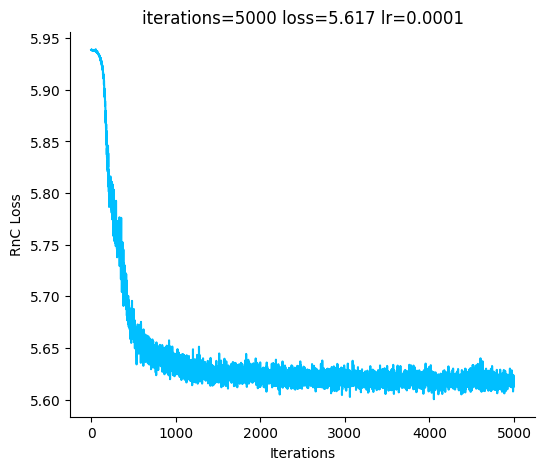

<Figure size 640x480 with 0 Axes>

In [10]:
### display the loss during model training process
import os
directory = "./data/"

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
train_loss = cebra_veldir_model.state_dict_['loss']
train_loss_stable = train_loss[-10:].numpy()
train_loss_stable = round(np.mean(train_loss_stable), 3)
ax.plot(train_loss, c='deepskyblue') ## label = 'continuous+discrete index'

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('RnC Loss')
plt.title('iterations='+str(iterations)+' loss='+str(train_loss_stable)+' lr='+str(lr))
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False )
plt.show()
filename = type_name+'='+str(full_types)+"_training loss_"+str(iterations)+"itr_lr"+\
    str(lr)+'_='+str(train_loss_stable)+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)

<IPython.core.display.Javascript object>


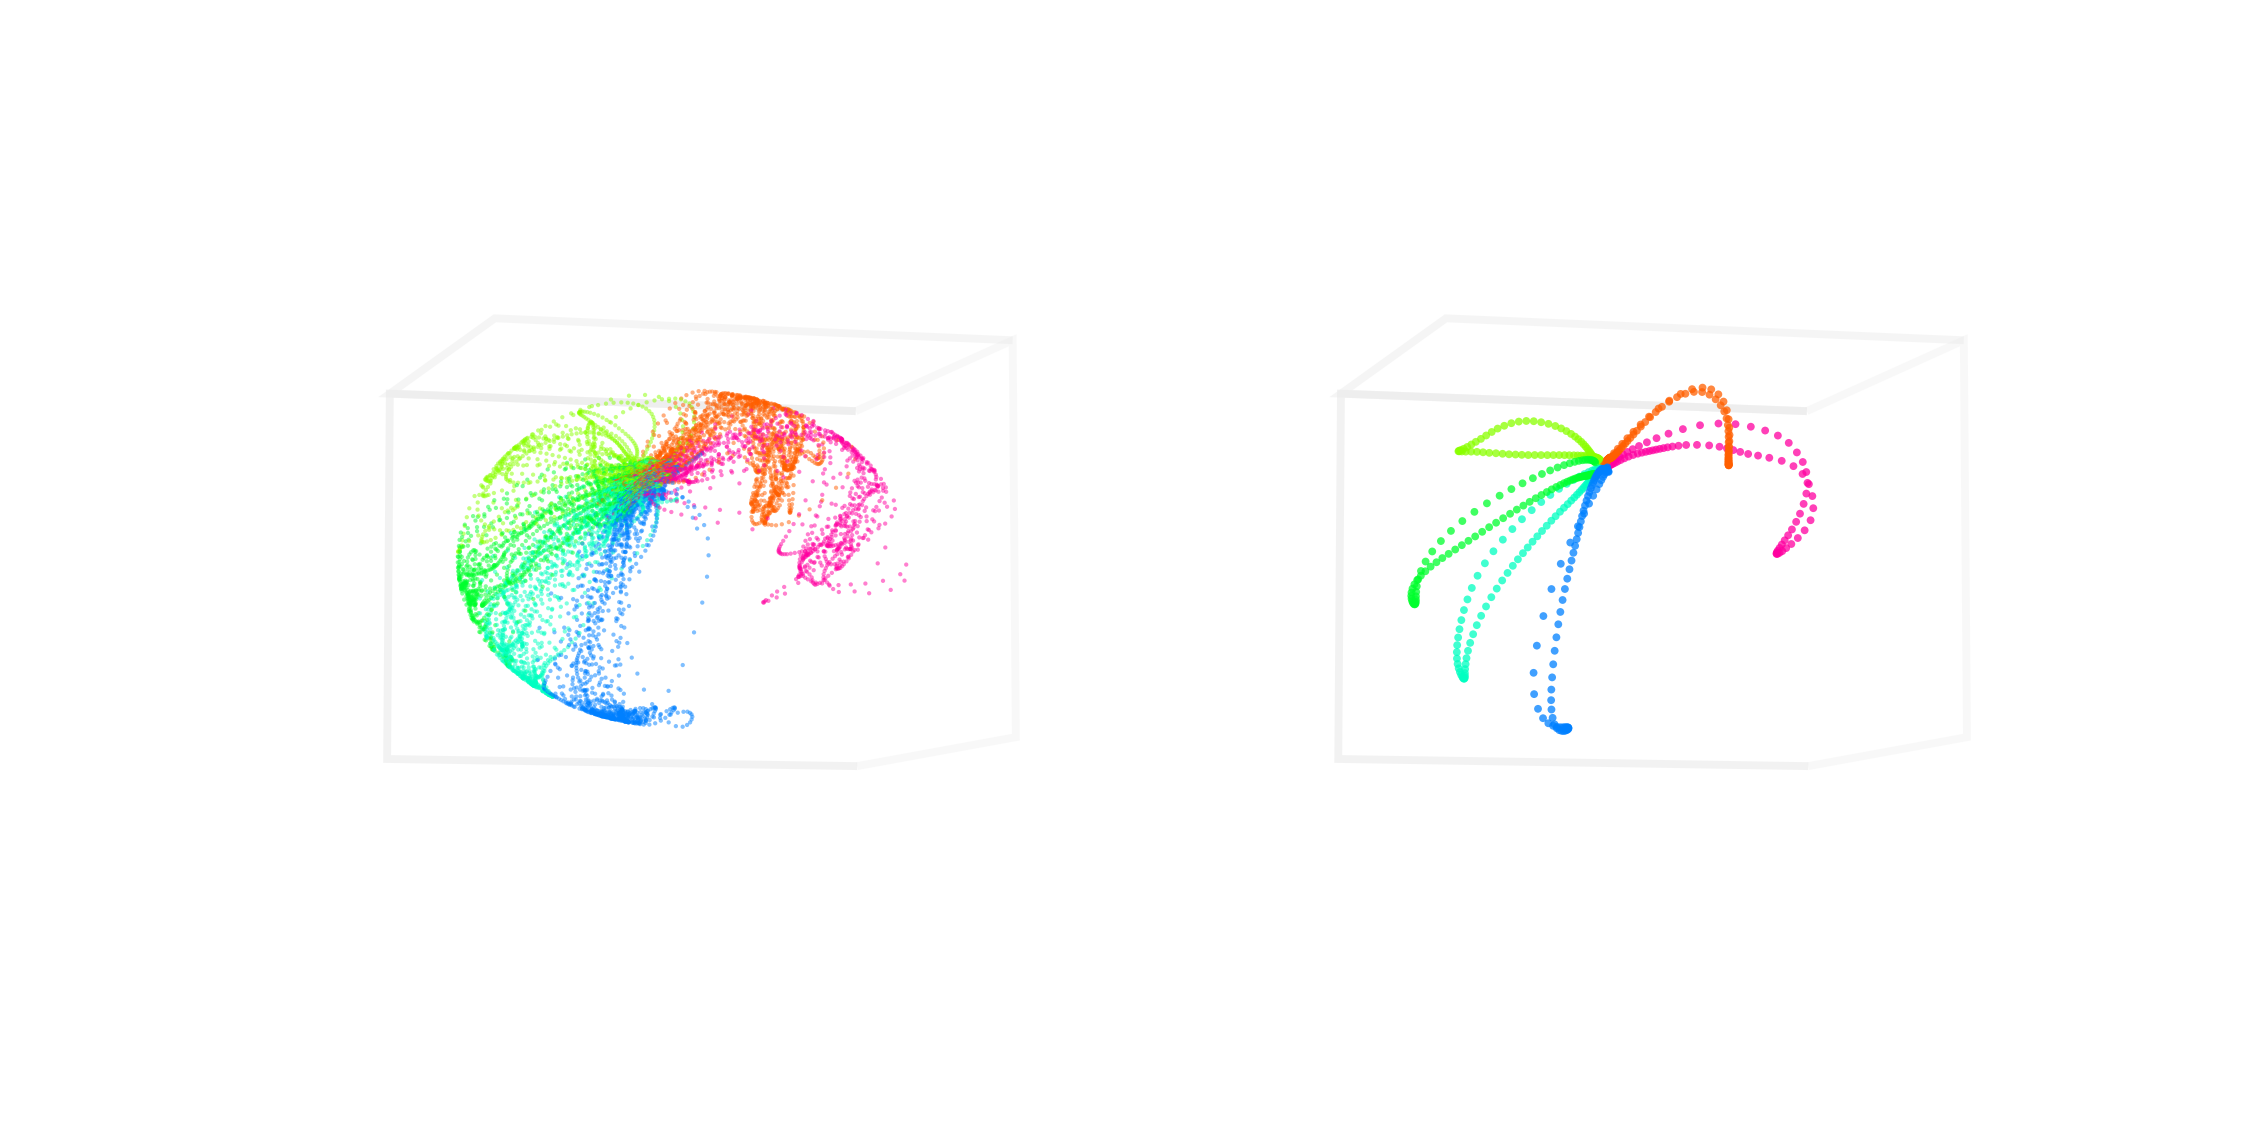

In [22]:
######****** used for one pair or two pairs of up-down curved hand motions
idx1, idx2, idx3 = 0, 1, 2
%matplotlib notebook
dur = 100
N_label = len(np.unique(discrete_index)) ## (28800,)

fig = plt.figure(figsize=(4, 2), dpi=500)
plt.subplots_adjust(wspace=0.2)
ax = plt.subplot(121, projection = '3d')
x = ax.scatter(cebra_veldir_train[:, idx1],
               cebra_veldir_train[:, idx2],
               cebra_veldir_train[:, idx3],
               color=plt.cm.hsv(1 / 360 * target_angle_train),
               edgecolors='none',
               alpha=0.5,
               s=0.3)
ax.set_facecolor('white')  # Set the background color to white
ax.grid(False)             # Remove the grid
ax.xaxis.pane.fill = False # Remove the background panes
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis.line.set_linewidth(0)
ax.view_init(elev=-6, azim=75)
plot_dur = 100
ax = plt.subplot(122, projection = '3d')

angle_1st = np.unique(target_angle_train)[0]
direction_trial = target_angle_train == angle_1st
trial_raw = cebra_veldir_train[direction_trial, :]    
trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
ax.scatter(trial_avg[:plot_dur, idx1],
           trial_avg[:plot_dur, idx2],
           trial_avg[:plot_dur, idx3],
           marker='o',
           color=plt.cm.hsv(1 / 360 * angle_1st),
           edgecolors='none',
           alpha=0.75,
           s=1)
angle_2nd = np.unique(target_angle_train)[1]
direction_trial = target_angle_train == angle_2nd
trial_raw = cebra_veldir_train[direction_trial, :] 
trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
ax.scatter(trial_avg[:plot_dur, idx1],
           trial_avg[:plot_dur, idx2],
           trial_avg[:plot_dur, idx3],
           marker='o',
           color=plt.cm.hsv(1 / 360 * angle_2nd),
           edgecolors='none',
           alpha=0.75,
           s=1)
if len(np.unique(target_angle_train))>2:
    angle_3rd = np.unique(target_angle_train)[2]
    direction_trial = target_angle_train == angle_3rd
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='o',color=plt.cm.hsv(1 / 360 * angle_3rd),edgecolors='none',alpha=0.75,s=1)
    angle_4th = np.unique(target_angle_train)[3]
    direction_trial = target_angle_train == angle_4th
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='o',color=plt.cm.hsv(1 / 360 * angle_4th),edgecolors='none',alpha=0.75,s=1)
if len(np.unique(target_angle_train))>4:
    angle_5th = np.unique(target_angle_train)[4]
    direction_trial = target_angle_train == angle_5th
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='o',color=plt.cm.hsv(1 / 360 * angle_5th),edgecolors='none',alpha=0.75,s=1)
    angle_6th = np.unique(target_angle_train)[5]
    direction_trial = target_angle_train == angle_6th
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='o',color=plt.cm.hsv(1 / 360 * angle_6th),edgecolors='none',alpha=0.75,s=1)
ax.set_facecolor('white')  # Set the background color to white
ax.grid(False)             # Remove the grid
ax.xaxis.pane.fill = False # Remove the background panes
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis.line.set_linewidth(0)
plt.show()
ax.view_init(elev=-6, azim=75)
filename = type_name+'='+str(full_types)+"_Embedding_"+str(iterations)+"itr_lr"+str(lr)+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)

In [24]:
filename = type_name+'='+str(full_types)+"_parameters_"+str(iterations)+"itr_lr"+str(lr)+".npz"
file_save = os.path.join(directory, filename)

np.savez(file_save,
         train_loss_stable=train_loss,
         cebra_veldir_train=cebra_veldir_train,
         cebra_veldir_test=cebra_veldir_test,
         continuous_index_train=continuous_index_train,
         continuous_index_test=continuous_index_test,
         target_angle_train=target_angle_train,
         target_angle_test=target_angle_test,
         version_index_train=version_index_train,
         version_index_test=version_index_test)

<IPython.core.display.Javascript object>


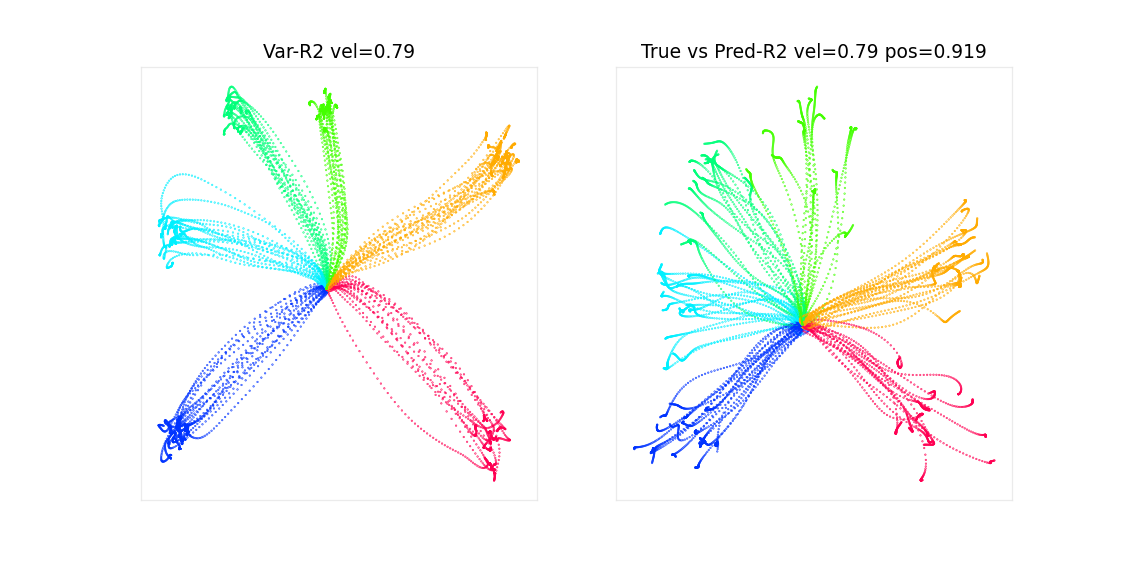

/tmp/ipykernel_14098/3365447500.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax1.scatter(truth_XY[trial_version_train, 0], truth_XY[trial_version_train, 1], alpha=1, marker='.',


In [27]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics

velocity_reshaped=continuous_index_train[:,0:2].reshape(train_trial,dur,2) ##(Xtrials*100bin,2)to(Xtrials,100bin,2)
locations = np.cumsum(velocity_reshaped/1000, axis=1) ## (Xtrials,100bin,2velocity>>location)
truth_XY = locations.reshape(train_trial*dur, 2) ## (Xtrials*100bin, 2=XY position)
truth_target = target_angle_train ## (Xtrials*100bin,) unique values are [0, 1, 2, 3, 4, 5, 6, 7]

X = cebra_veldir_train
y = continuous_index_train[:, 0:2]
reg = LinearRegression().fit(X, y) ### n_jobs = 8 >>> unnecessary
pred_vel = reg.predict(X) 
velocity_reshaped = pred_vel.reshape(train_trial, dur, 2)
locations = np.cumsum(velocity_reshaped/1000, axis=1)
pred_XY = locations.reshape(train_trial*dur, 2) ## (dur*number of trials, 2=XY position)

posi_r2 = sklearn.metrics.r2_score(truth_XY, pred_XY) ### proportion of total variation explained by model
vel_r2 = sklearn.metrics.r2_score(continuous_index_train[:, 0:2], pred_vel)
 ### same to "vel_r2" but don't need 3 steps "fit(X,Y)>>Z=predict(X)>>score(X,Z)", just "score(X,Y)"

fig = plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
trial_version_train = version_index_train ==0
norm = plt.Normalize(vmin=0, vmax=1)
ax1.scatter(truth_XY[trial_version_train, 0], truth_XY[trial_version_train, 1], alpha=1, marker='.', 
            norm=norm, color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_train]), s=0.5)
trial_version_train = version_index_train >0
ax1.scatter(truth_XY[trial_version_train, 0], truth_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_train]), s=0.5)
ax1.spines['bottom'].set_color((0.9, 0.9, 0.9, 0.8))
ax1.spines['top'].set_color((0.9, 0.9, 0.9, 0.8))
ax1.spines['right'].set_color((0.9, 0.9, 0.9, 0.8))
ax1.spines['left'].set_color((0.9, 0.9, 0.9, 0.8))
ax1.set_xticks([])
ax1.set_yticks([])
xlims = ax1.get_xlim()
ylims = ax1.get_ylim()
plt.title('Var-R2 vel='+str(round(reg.score(X, y), 3))) ## must be same as "vel_r2"


ax2 = plt.subplot(122)
trial_version_train = version_index_train ==0
ax2.scatter(pred_XY[trial_version_train, 0], pred_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_train]), s=0.5)
trial_version_train = version_index_train >0
ax2.scatter(pred_XY[trial_version_train, 0], pred_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_train]), s=0.5)

# ax2.set_xlim(xlims)
# ax2.set_ylim(ylims)
ax2.spines['bottom'].set_color((0.9, 0.9, 0.9, 0.8))
ax2.spines['top'].set_color((0.9, 0.9, 0.9, 0.8))
ax2.spines['right'].set_color((0.9, 0.9, 0.9, 0.8))
ax2.spines['left'].set_color((0.9, 0.9, 0.9, 0.8))
ax2.set_xticks([])
ax2.set_yticks([])
plt.title('True vs Pred-R2 vel='+str(round(vel_r2, 3))+' pos='+str(round(posi_r2, 3)))

filename = type_name+'='+str(full_types)+"_Decoding R2 Train_"+str(iterations)+\
        "itr_lr"+str(lr)+'_vel_'+str(round(vel_r2, 3))+'_pos_'+str(round(posi_r2, 3))+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)

<IPython.core.display.Javascript object>


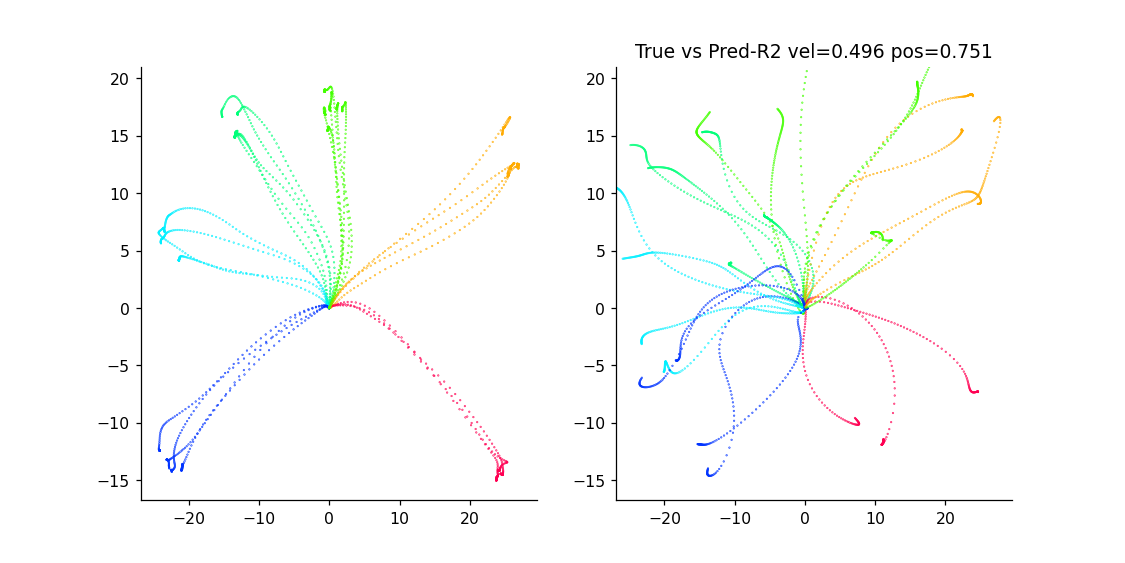

In [14]:
###*** decoding R2 on test trials ***######*** using previous "reg" ***###

fig = plt.figure(figsize=(10, 5))
initial_positions = np.zeros((test_trial, 1, 2))

velocity_reshaped = continuous_index_test[:, 0:2].reshape(test_trial, dur, 2)
locations = np.cumsum(velocity_reshaped, axis=1)/1000
pos_truth = locations.reshape(test_trial*dur, 2)
truth_XY = pos_truth[:, 0:2] 
truth_target = target_angle_test 

pred_vel = reg.predict(cebra_veldir_test)
velocity_reshaped = pred_vel.reshape(test_trial, dur, 2)
locations = np.cumsum(velocity_reshaped, axis=1)/1000
pred_XY = locations.reshape(test_trial*dur, 2)

posi_r2 = sklearn.metrics.r2_score(truth_XY, pred_XY)
vel_r2 = sklearn.metrics.r2_score(continuous_index_test[:, 0:2], pred_vel)

ax1 = plt.subplot(121)
trial_version_test = version_index_test ==0
ax1.scatter(truth_XY[trial_version_test, 0], truth_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_test]), s=0.5)
trial_version_test = version_index_test >0
ax1.scatter(truth_XY[trial_version_test, 0], truth_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_test]), s=0.5)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
xlims = ax1.get_xlim()
ylims = ax1.get_ylim()

ax2 = plt.subplot(122)
trial_version_test = version_index_test ==0
ax2.scatter(pred_XY[trial_version_test, 0], pred_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_test]), s=0.5)
trial_version_test = version_index_test >0
ax2.scatter(pred_XY[trial_version_test, 0], pred_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_test]), s=0.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
plt.title('True vs Pred-R2 vel='+str(round(vel_r2, 3)) + ' pos='+str(round(posi_r2, 3)))

filename = type_name+'='+str(full_types)+"_Decoding R2 Test_"+str(iterations)+\
        "itr_lr"+str(lr)+'_vel_'+str(round(vel_r2, 3))+'_pos_'+str(round(posi_r2, 3))+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)